### Notebook to search for long tracks in certain run

Run: 13838 -> Alphas

Look initially for wide s2 width, then voxelise tracks and check number of voxels, or check xyz positions based on sophronia output

In [1]:
import sys,os,os.path
sys.path.append("../../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'


import random
import tables as tb
import numpy  as np
import pandas as pd

import invisible_cities.io.mcinfo_io as mcio
from IC.invisible_cities.cities                 import beersheba as beerfun
import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio


from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

from invisible_cities.database.load_db  import DataPMT, DataSiPM, SiPMNoise
from concurrent.futures import ProcessPoolExecutor


from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from matplotlib.legend_handler import HandlerPatch



import imageio
from next_misc.core import functions as func


def load_sophronia_file(file_path):
    q = (pd.read_hdf(file_path, 'RECO/Events'), pd.read_hdf(file_path, 'DST/Events'))


    z_length = []
    z_df = []
    s2_width = []

    s2_df = []

    # apply q_cut
    q_cut = 4
    df_cut = q[0][q[0].Q > q_cut]
    #print("Before cuts")
    #display(df_cut.event.nunique())
    # only take ns2 ns1 == 1 for this to save sanity
    dst_cut = q[1][q[1].nS1 == 1]
    #dst_cut = q[1][q[1].nS2 == 1]

    # only keep df_cuts that are in dst_cut
    df_cut = df_cut[df_cut.event.isin(dst_cut.event.unique())]
    #print("After cuts")
    #display(df_cut.event.nunique())
    for evt, df in df_cut.groupby('event'):
        #print(evt)
        #print(df)

        z = dst_cut[dst_cut.event == evt].Xrms.values
        z_length.append(z)
        #z = df.Z
        #z_distance = np.max(z) - np.min(z)
        #z_length.append(z_distance)
        #display(q[1][q[1].event == evt].S2w.values)
        s2_val = np.max(dst_cut[dst_cut.event == evt].S2w.values)
        s2_width.append(s2_val)

        if np.max(z) > 150:
            s2_df.append(df)

        #if s2_val > 600:
        #    s2_df.append(df)

    if s2_df == []:
        d = {'event': [0, 1], 'data': [0,1]}
        s2_df = [pd.DataFrame(data = d)]


    try:
        s2_df = pd.concat(s2_df)
    except:
        print("No concatable")
        d = {'event': [0, 1], 'data': [0,1]}
        s2_df = [pd.DataFrame(data = d)]


        
    drop_dist       = [16, 16]

    for evt, df in s2_df.groupby('event'):

        try:
            cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
            drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])
            hits_cut = coref.timefunc(cut_sensors)(df.copy())
            hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
            pitch = 15.55
            # then applying transformations to convert to 'SiPM outputs'
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))


            xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
            yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
            zz = hits_cut.Z.unique()

            axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
            axes[0].set_xlabel('X (mm)');
            axes[0].set_ylabel('Y (mm)');

            axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
            axes[1].set_xlabel('X (mm)');
            axes[1].set_ylabel('Z (mm)');


            axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
            axes[2].set_xlabel('Y (mm)');
            axes[2].set_ylabel('Z (mm)');

            fig.suptitle('Processed Sensors Signal_' + str(evt), fontsize=30)
            fig.savefig(f'../pics/{evt}.png')
        except:
            print("One broke, ignoring")


def load_sophronia_fast(folder_path):

    # parallelise 
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_sophronia_file, file_paths))

    # Separate the results into respective lists
    #reco, dst = zip(*results)

    # Concatenate all the dataframes at once
    #reco = pd.concat(reco, axis=0, ignore_index=True)
    #dst = pd.concat(dst, ignore_index=True)

    #return reco, dst

In [2]:
load_sophronia_fast('../testing/')

Time spent in cut_over_Q: 0.026175260543823242 s
Time spent in drop_isolated: 0.16062664985656738 s
Time spent in cut_over_Q: 0.02111506462097168 s
Time spent in drop_isolated: 0.15182852745056152 s


In [13]:
folder_path = '../data/'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
file_paths = [os.path.join(folder_path, f) for f in file_names]


# read in

evt_interest = 23927

for i in file_paths:
        
    df = pd.read_hdf(i, 'RECO/Events', start = 0, stop = 100000)
    events = np.unique(df.event.to_numpy())

    if evt_interest in events:
        print(f"Good one found! At file {i}")
        file_interest = i
        print("{} events\nRange: {} - {}\nMC events are even and odd, unlike other events.".format(len(events), np.min(events), np.max(events)))
        break


Good one found! At file ../data/run_13838_0039_ldc4_trg0.v2.0.0.20240528.ArConf.sophronia.h5
61 events
Range: 23479 - 24067
MC events are even and odd, unlike other events.


### load in the relevant file

In [28]:
hdst = dstio.load_dst(file_interest, 'RECO', 'Events')#CHITS/lowTh

# then the relevant event
hits = hdst[hdst.event == evt_interest]

display(hits)

q_cut = 6
drop_dist       = [16, 16]
cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])
hits_cut = coref.timefunc(cut_sensors)(hits.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
pitch = 15.55
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
zz = hits_cut.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Processed Sensors Signal_' + str(evt_interest), fontsize=30)

#plt.tight_layout()

OSError: ``/home/e78368jw/Documents/NEXT_CODE/next_misc/alphas_muon_track/data/run_13838_0039_ldc4_trg0.v2.0.0.20240528.ArConf.sophronia.h5`` does not exist

In [20]:
display(q[0])
display(q[1])

NameError: name 'q' is not defined

In [5]:
def flatten(xss):
    return [x for xs in xss for x in xs]

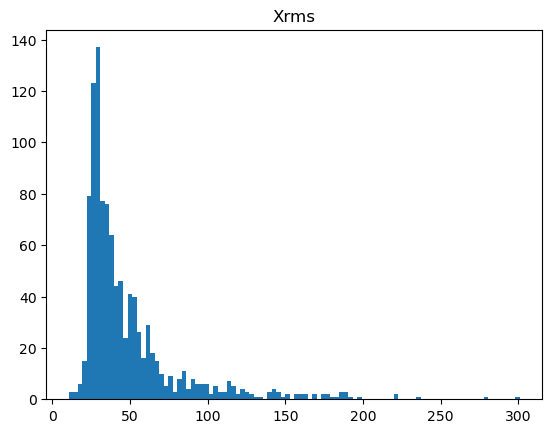

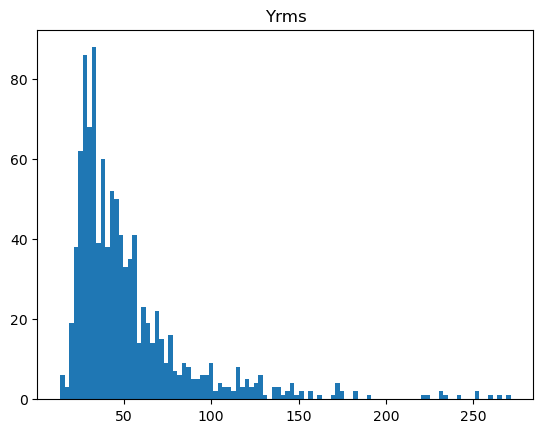

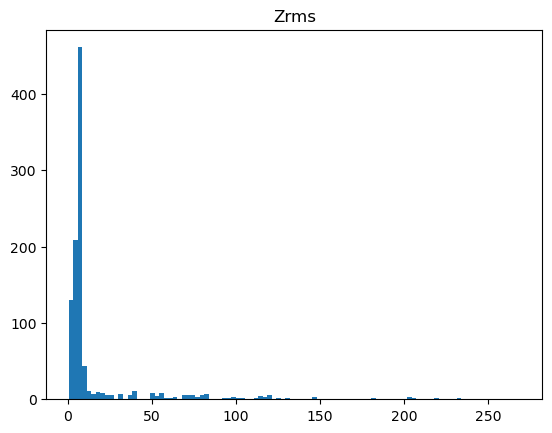

SyntaxError: 'break' outside loop (2645564942.py, line 49)

In [47]:
folder_path = '../data/'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
file_paths = [os.path.join(folder_path, f) for f in file_names]



reco_l = []
dst_l = []

Xrms = []
Yrms = []
Zrms = []

for i, file_path in enumerate(file_paths):
    q = (pd.read_hdf(file_path, 'RECO/Events'), pd.read_hdf(file_path, 'DST/Events'))
    #display(q[0])
    #display(q[1])
    
    #Separate the results into respective lists
    reco, dst = q #Concatenate all the dataframes at once

    Xrms.append(dst.Xrms.values)
    
    Yrms.append(dst.Yrms.values)
    Zrms.append(dst.Zrms.values)
    #reco_l.append(reco)
    #dst_l.append(dst)

    if i > 100:
        break

#reco = pd.concat(reco_l, axis=0, ignore_index=True)
#dst = pd.concat(dst_l, ignore_index=True)
Xrms = flatten(Xrms)
Yrms = flatten(Yrms)
Zrms = flatten(Zrms)
plt.hist(Xrms, bins = 100)
plt.title("Xrms")
plt.show()

plt.hist(Yrms, bins = 100)
plt.title("Yrms")
plt.show()

plt.hist(Zrms, bins = 100)
plt.title("Zrms")
plt.show()

break

z_length = []
z_df = []
s2_width = []

s2_df = []

# apply q_cut
q_cut = 4
df_cut = q[0][q[0].Q > q_cut]
print("Before cuts")
display(df_cut.event.nunique())
# only take ns2 ns1 == 1 for this to save sanity
dst_cut = q[1][q[1].nS1 == 1]
dst_cut = q[1][q[1].nS2 == 1]

# only keep df_cuts that are in dst_cut
df_cut = df_cut[df_cut.event.isin(dst_cut.event.unique())]
print("After cuts")
display(df_cut.event.nunique())
for evt, df in df_cut.groupby('event'):
    #print(evt)
    #print(df)
    z = df.Z

    z_distance = np.max(z) - np.min(z)
    
    
    z_length.append(z_distance)
    #display(q[1][q[1].event == evt].S2w.values)
    s2_val = np.max(dst_cut[dst_cut.event == evt].S2w.values)
    s2_width.append(s2_val)

    if s2_val > 400:
        s2_df.append(df)

s2_df = pd.concat(s2_df)




In [26]:
q[1].S2w

0       175.675
1       131.825
2       142.000
3       148.000
4       150.000
         ...   
9682    134.325
9683    370.150
9684    116.325
9685    370.150
9686    116.325
Name: S2w, Length: 9687, dtype: float64

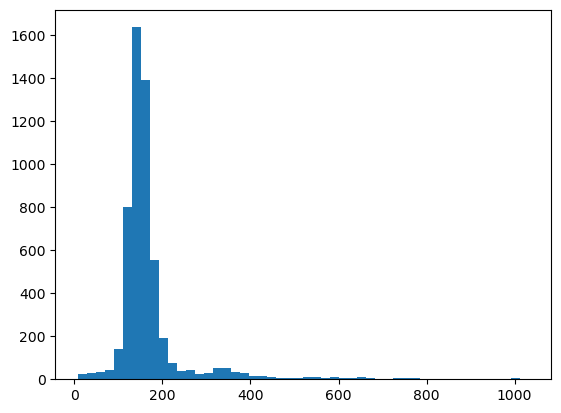

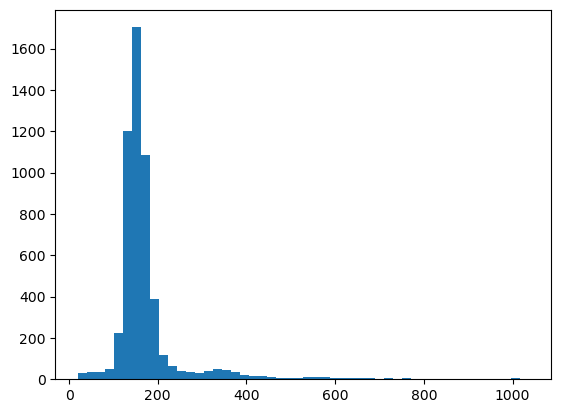

In [27]:
plt.hist(z_length, bins = 50)
plt.show()
#plt.hist(s2_width, bins = 50)
#plt.show()
plt.hist(s2_width, bins = 50)
plt.show()

In [9]:
# select events beyond 400mm in length
z_df = []
for df in df_cut.groupby('event'):
    
    z = df[1].Z
    z_distance = np.max(z) - np.min(z)
    if z_distance > 600:
        z_df.append(df[1])

z_df = pd.concat(z_df)
display(z_df)

event          time  npeak       Xpeak       Ypeak  nsipm        X  \
666399   999783  1.717306e+09      0 -241.895732 -201.467591      1 -204.725   
666407   999783  1.717306e+09      0 -241.895732 -201.467591      1 -204.725   
666413   999783  1.717306e+09      0 -241.895732 -201.467591      1 -220.275   
666417   999783  1.717306e+09      0 -241.895732 -201.467591      1 -297.025   
666420   999783  1.717306e+09      0 -241.895732 -201.467591      1 -281.475   
...         ...           ...    ...         ...         ...    ...      ...   
769295  1007350  1.717306e+09     13  -42.983887 -244.600183      1 -204.725   
769296  1007350  1.717306e+09     13  -42.983887 -244.600183      1 -204.725   
769297  1007350  1.717306e+09     13  -42.983887 -244.600183      1  319.975   
769298  1007350  1.717306e+09     13  -42.983887 -244.600183      1  335.525   
769305  1007350  1.717306e+09     13  -42.983887 -244.600183      1 -204.725   

              Y  Xrms  Yrms            Z          Q           E   Qc  \
666399 -402.175   0.0   0.0   627.369375  29.696970   22.837122 -1.0   
666407 -402.175   0.0   0.0   635.133875  15.151515  493.617306 -1.0   
666413 -217.575   0.0   0.0   635.133875  10.200000  332.303168 -1.0   
666417 -217.075   0.0   0.0   638.930750  12.044817  257.071069 -1.0   
666420 -217.075   0.0   0.0   638.930750  20.200001  431.126168 -1.0   
...         ...   ...   ...          ...        ...         ...  ...   
769295 -402.175   0.0   0.0  1385.242000  18.181818   27.829450 -1.0   
769296 -402.175   0.0   0.0  1392.746500  15.757576  300.214996 -1.0   
769297 -309.375   0.0   0.0  1392.746500  11.926605  227.226938 -1.0   
769298 -294.825   0.0   0.0  1392.746500  11.752854  223.916618 -1.0   
769305 -402.175   0.0   0.0  1416.616750  10.303030   75.460697 -1.0   

              Ec  track_id   Ep  
666399  0.000074        -1 -1.0  
666407  0.001606        -1 -1.0  
666413  0.000944        -1 -1.0  
666417  0.000750        -1 -1.0  
666420  0.001253        -1 -1.0  
...          ...       ...  ...  
769295  0.000099        -1 -1.0  
769296  0.001071        -1 -1.0  
769297  0.000816        -1 -1.0  
769298  0.000784        -1 -1.0  
769305  0.000270        -1 -1.0  

[25805 rows x 17 columns]

Time spent in cut_over_Q: 0.02525782585144043 s
Time spent in drop_isolated: 0.012412309646606445 s
Time spent in cut_over_Q: 0.012130498886108398 s
Time spent in drop_isolated: 0.009134769439697266 s
Time spent in cut_over_Q: 0.012650489807128906 s
Time spent in drop_isolated: 0.010721683502197266 s


/tmp/ipykernel_16279/2185398554.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Time spent in cut_over_Q: 0.014015436172485352 s
Time spent in drop_isolated: 0.011887788772583008 s
Time spent in cut_over_Q: 0.009784460067749023 s
Time spent in drop_isolated: 0.007938861846923828 s
One broke, ignoring
Time spent in cut_over_Q: 0.011300086975097656 s
Time spent in drop_isolated: 0.008898019790649414 s
Time spent in cut_over_Q: 0.010976076126098633 s
Time spent in drop_isolated: 0.007781505584716797 s
Time spent in cut_over_Q: 0.01396489143371582 s
Time spent in drop_isolated: 0.010914087295532227 s
Time spent in cut_over_Q: 0.01580953598022461 s
Time spent in drop_isolated: 0.012644529342651367 s
Time spent in cut_over_Q: 0.011097431182861328 s
Time spent in drop_isolated: 0.007914066314697266 s
Time spent in cut_over_Q: 0.01226043701171875 s
Time spent in drop_isolated: 0.010275125503540039 s
Time spent in cut_over_Q: 0.006605386734008789 s
Time spent in drop_isolated: 0.005738019943237305 s
One broke, ignoring
Time spent in cut_over_Q: 0.012036800384521484 s
Time 

/tmp/ipykernel_16279/2185398554.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 3, figsize=(18, 6))


Time spent in cut_over_Q: 0.016171932220458984 s
Time spent in drop_isolated: 0.01128077507019043 s
Time spent in cut_over_Q: 0.006070375442504883 s
Time spent in drop_isolated: 0.005615234375 s
One broke, ignoring
Time spent in cut_over_Q: 0.006890773773193359 s
Time spent in drop_isolated: 0.004445314407348633 s
One broke, ignoring
Time spent in cut_over_Q: 0.011593818664550781 s
Time spent in drop_isolated: 0.007819414138793945 s
Time spent in cut_over_Q: 0.011708259582519531 s
Time spent in drop_isolated: 0.008279800415039062 s
Time spent in cut_over_Q: 0.011958599090576172 s
Time spent in drop_isolated: 0.00918436050415039 s
Time spent in cut_over_Q: 0.01300501823425293 s
Time spent in drop_isolated: 0.009192228317260742 s
Time spent in cut_over_Q: 0.013966560363769531 s
Time spent in drop_isolated: 0.010623693466186523 s
Time spent in cut_over_Q: 0.010791301727294922 s
Time spent in drop_isolated: 0.008081436157226562 s
Time spent in cut_over_Q: 0.010933160781860352 s
Time spent 

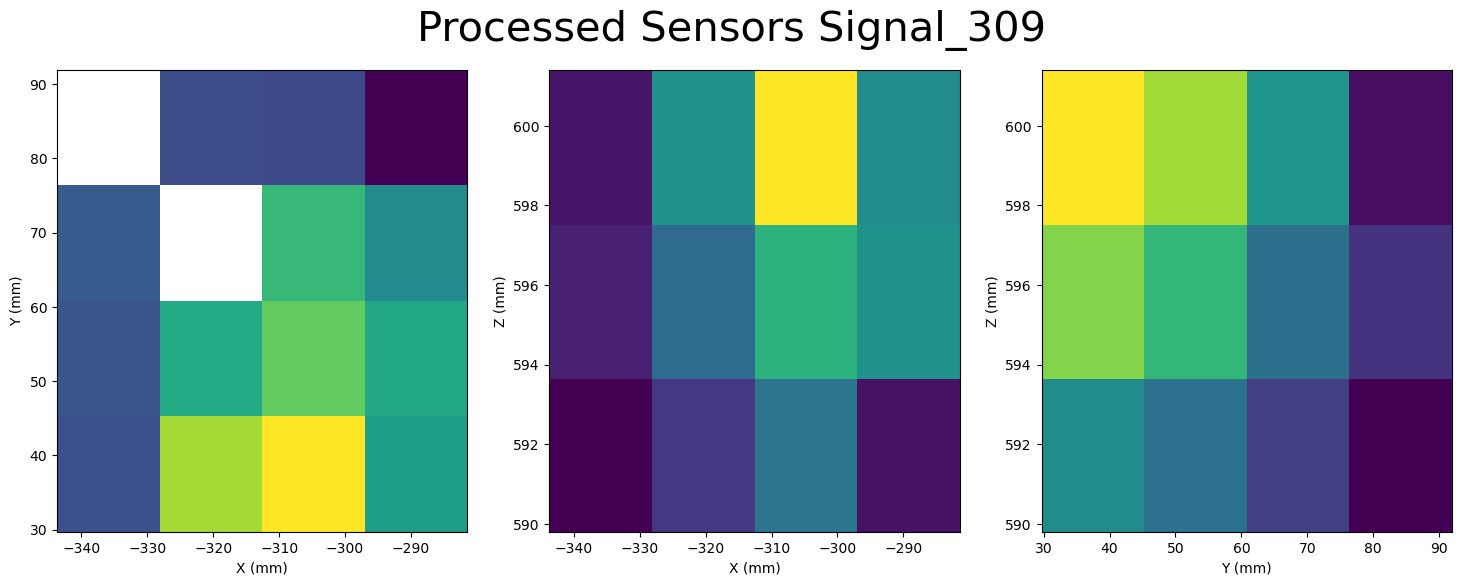

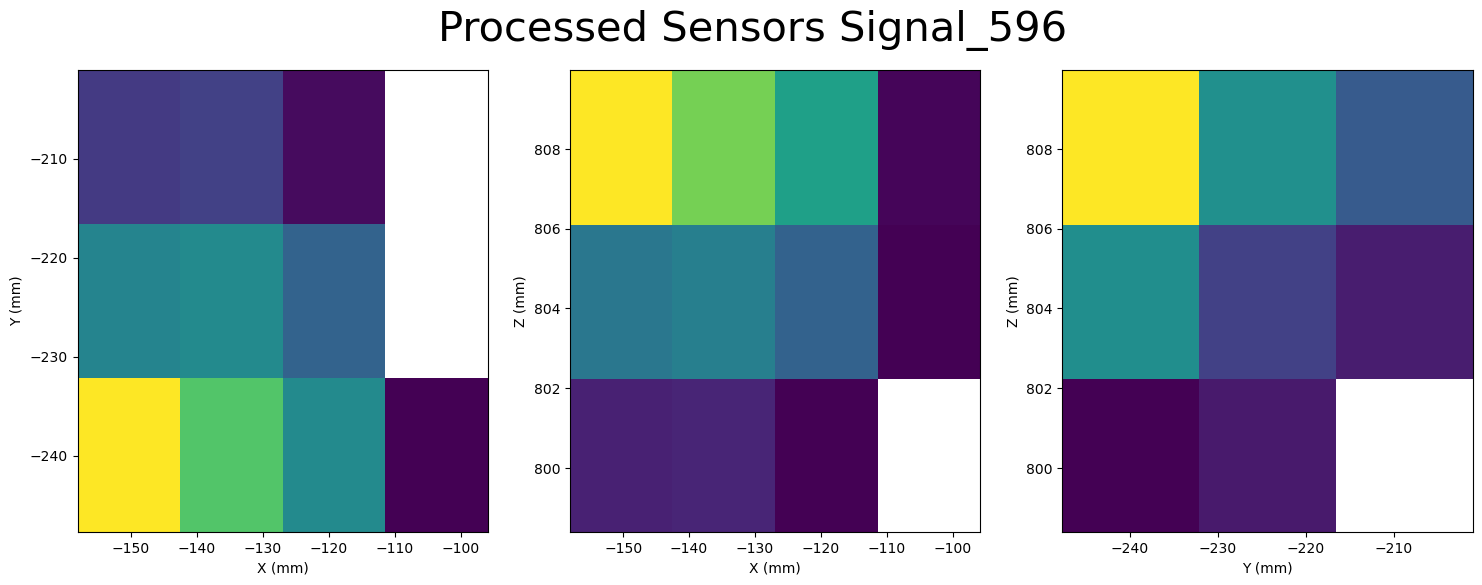

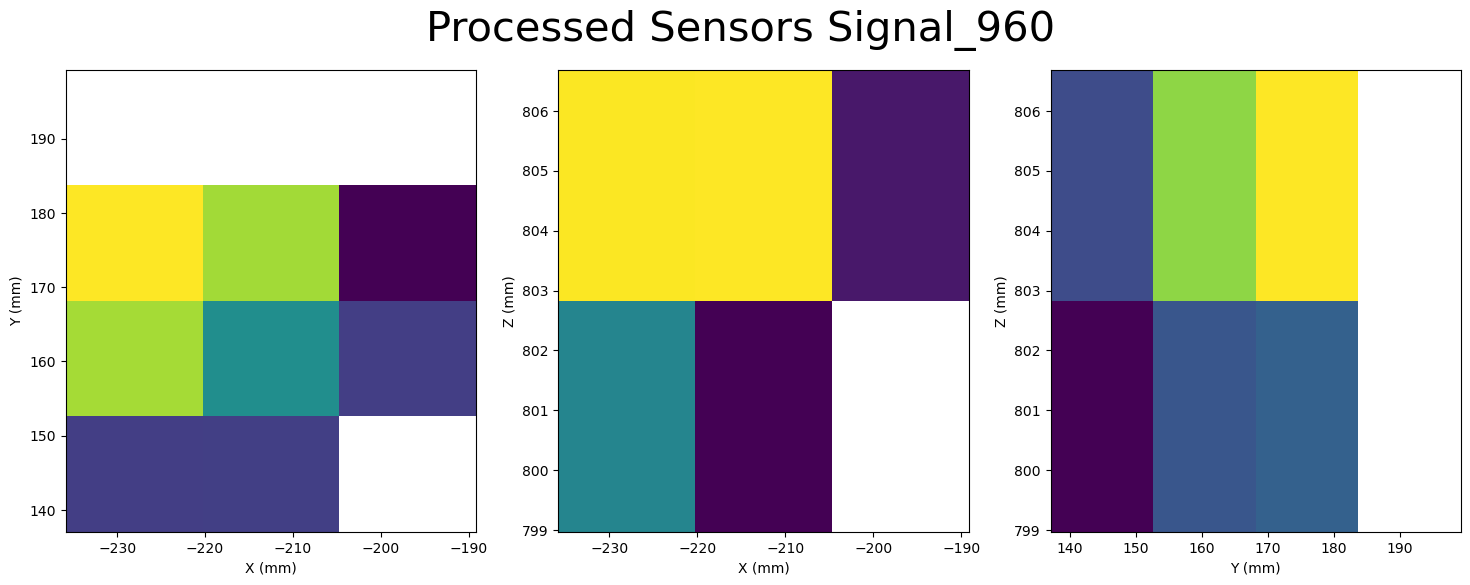

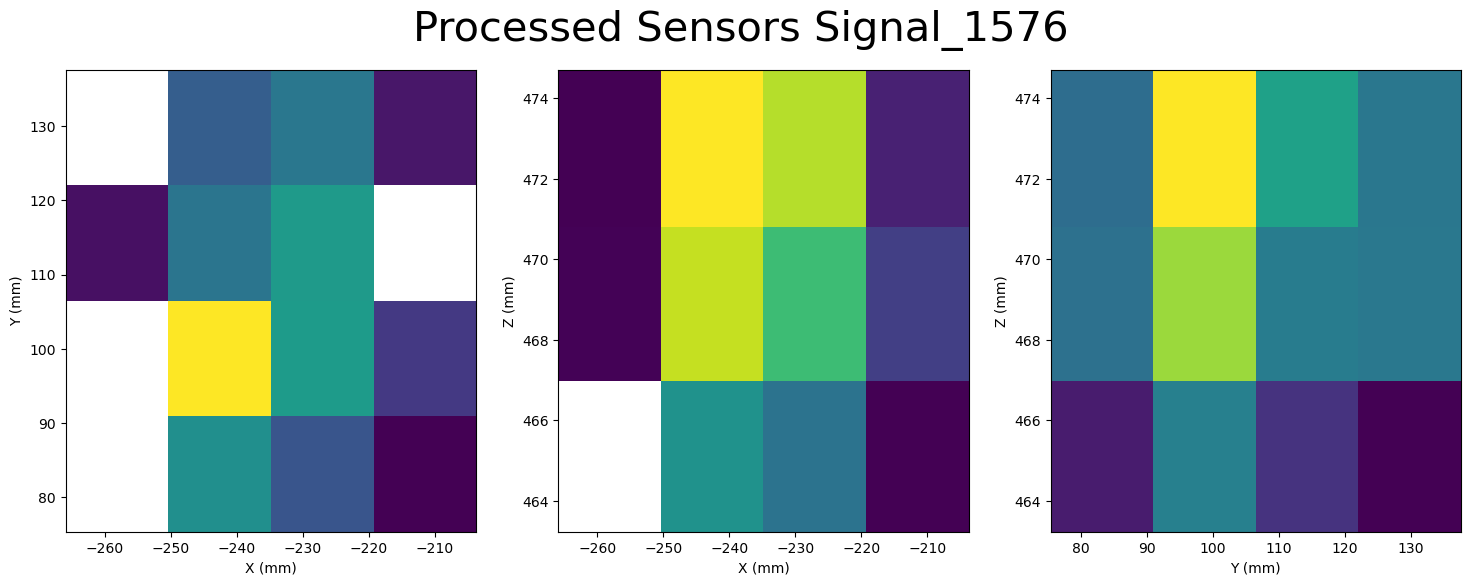

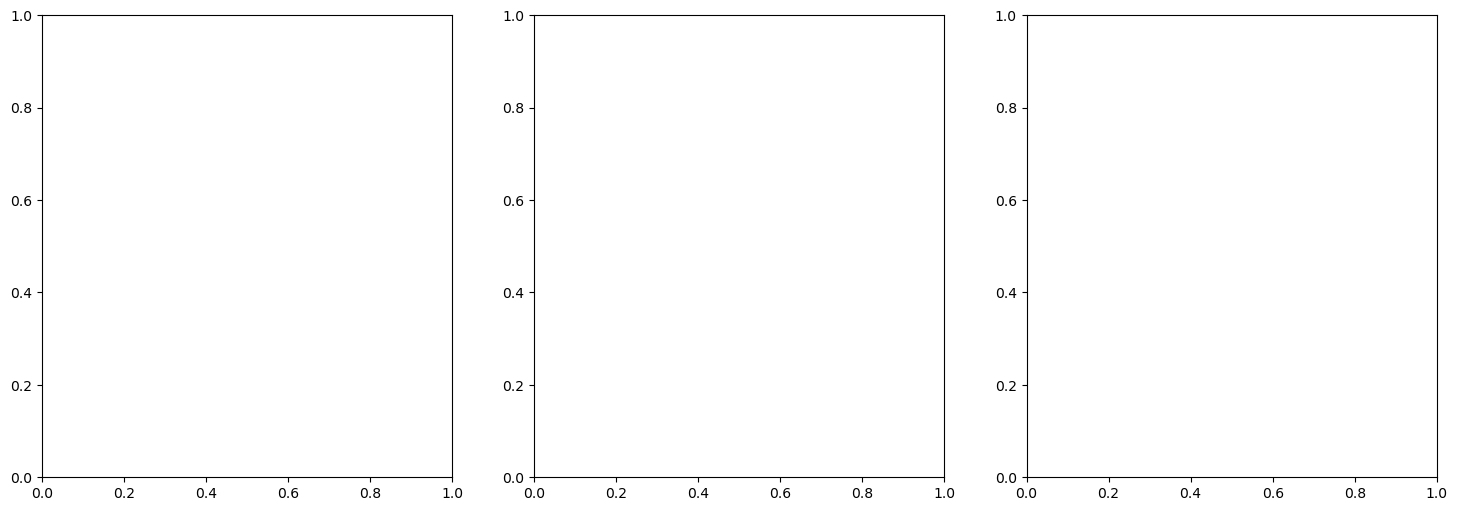

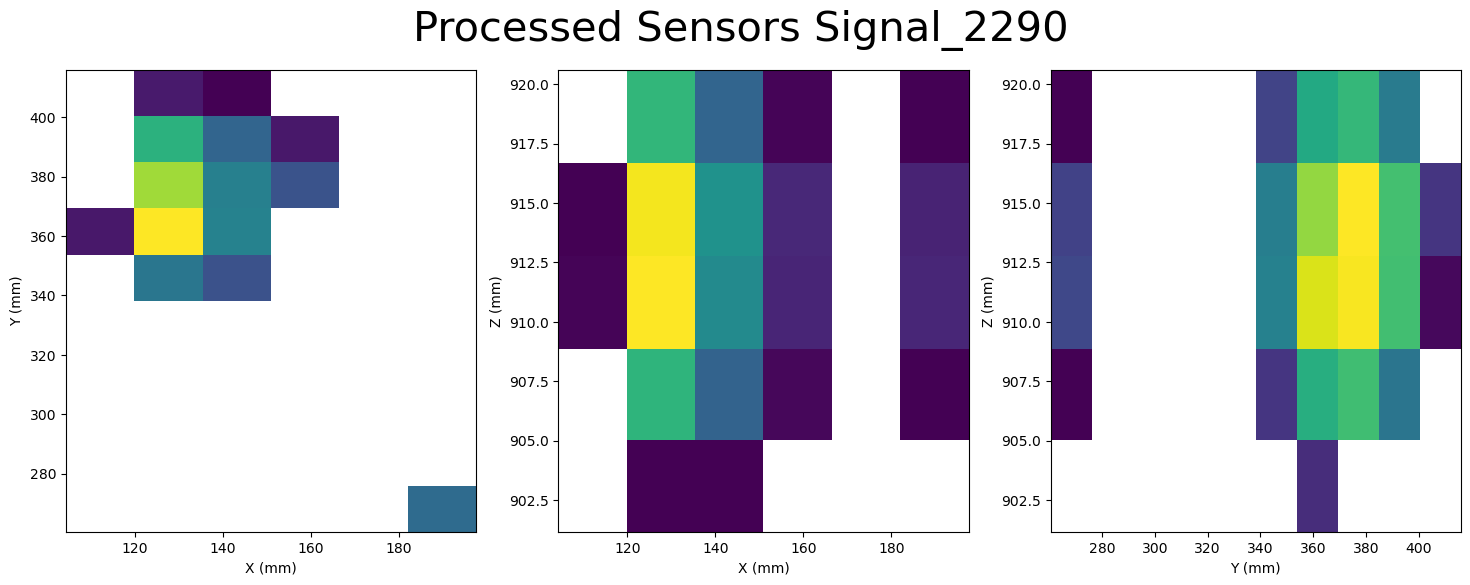

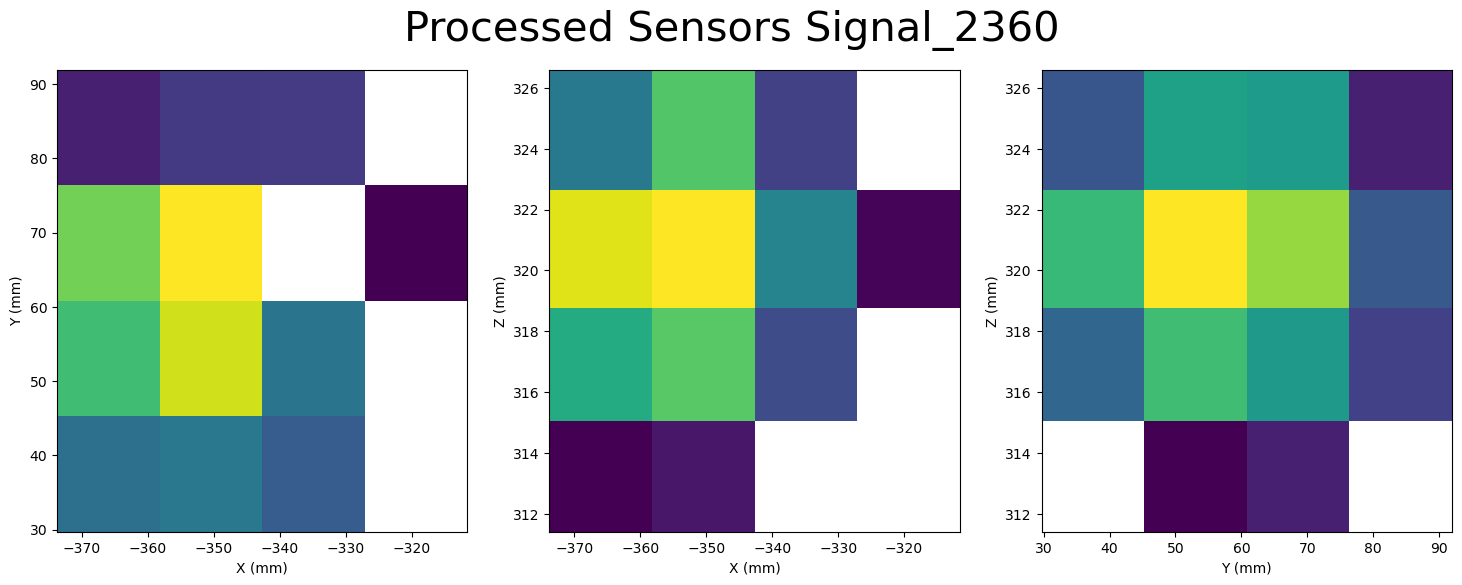

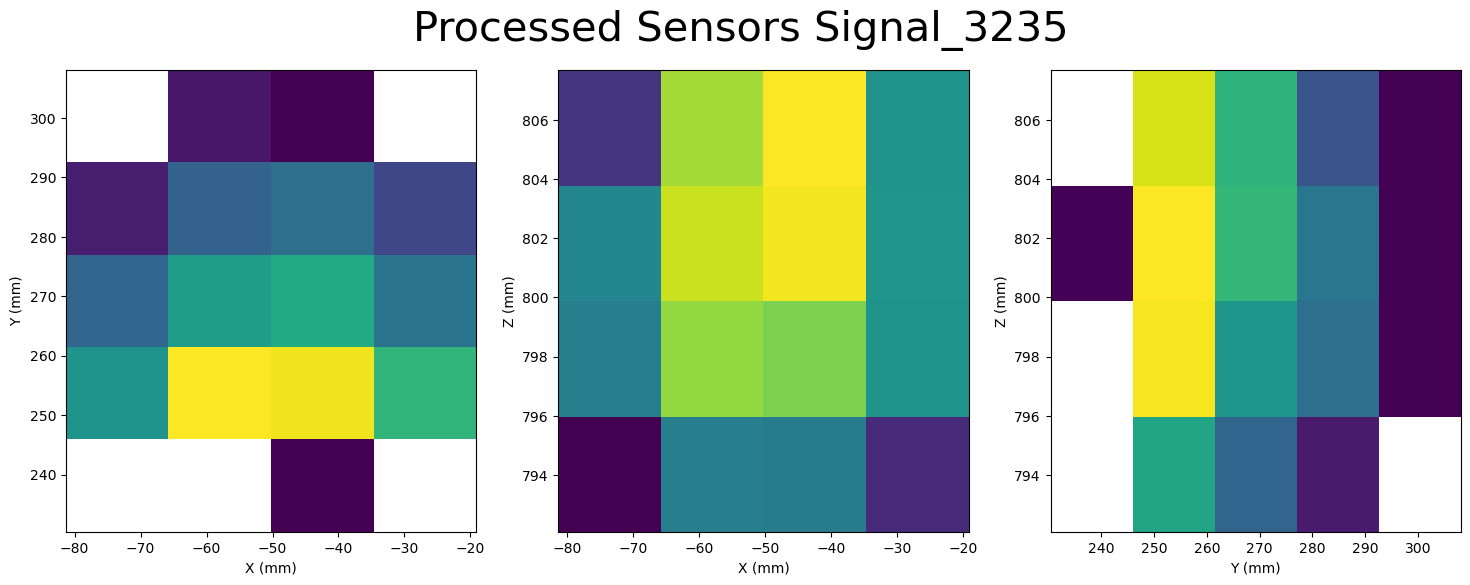

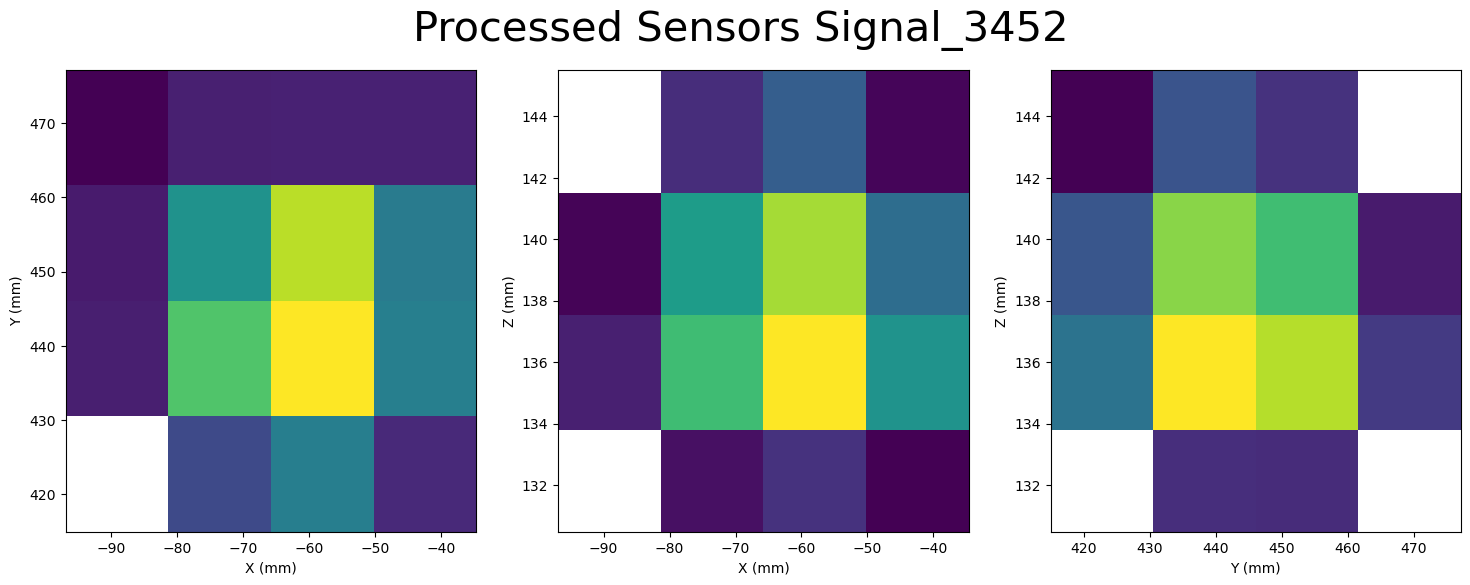

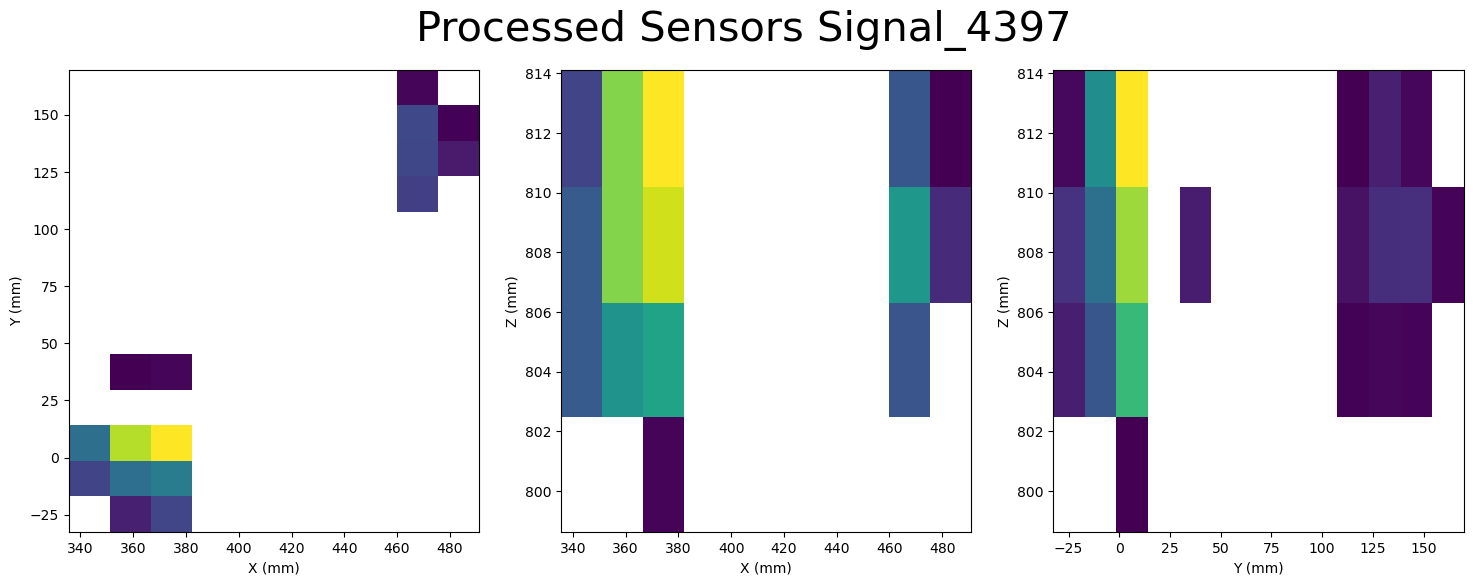

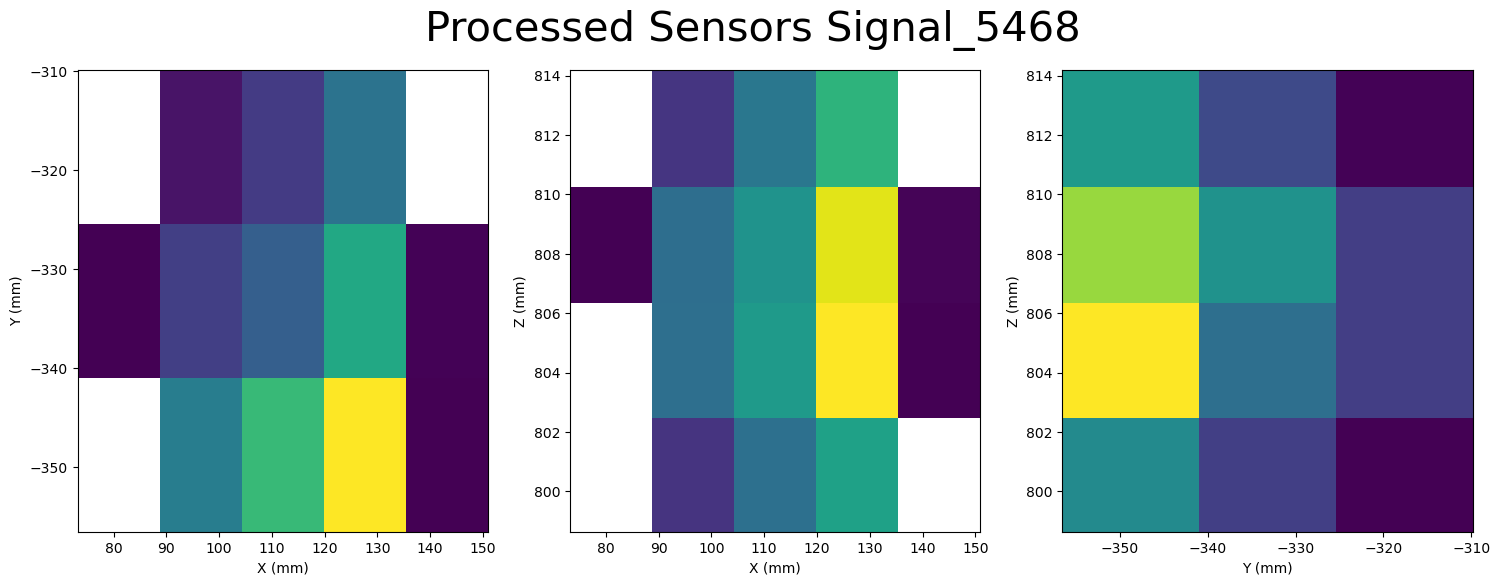

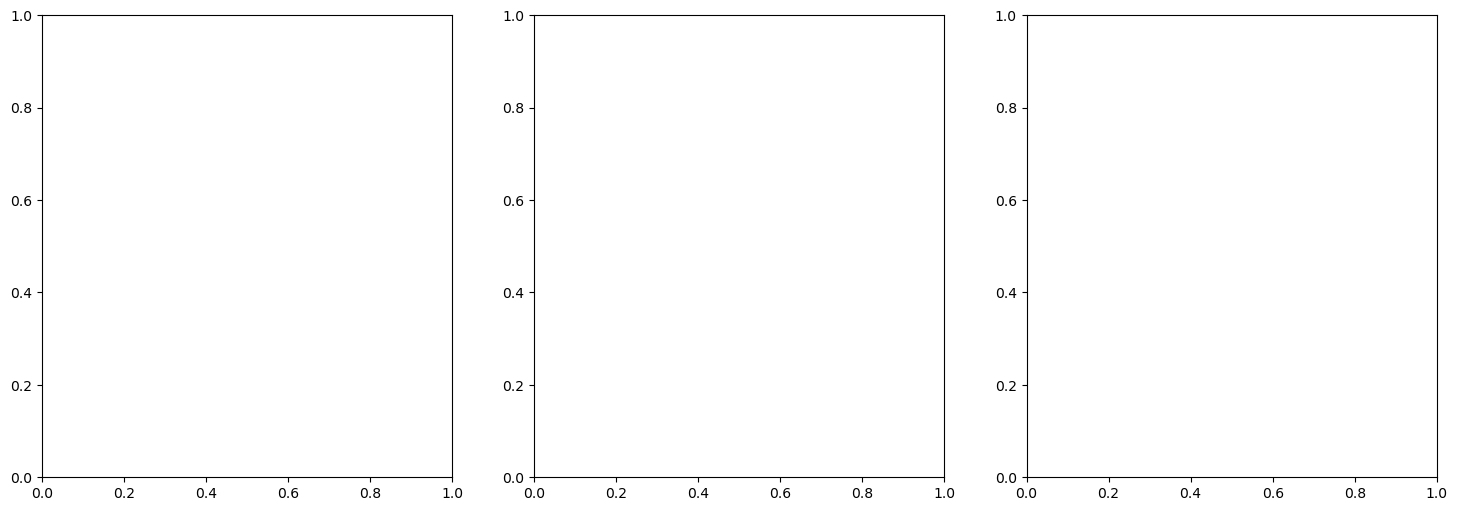

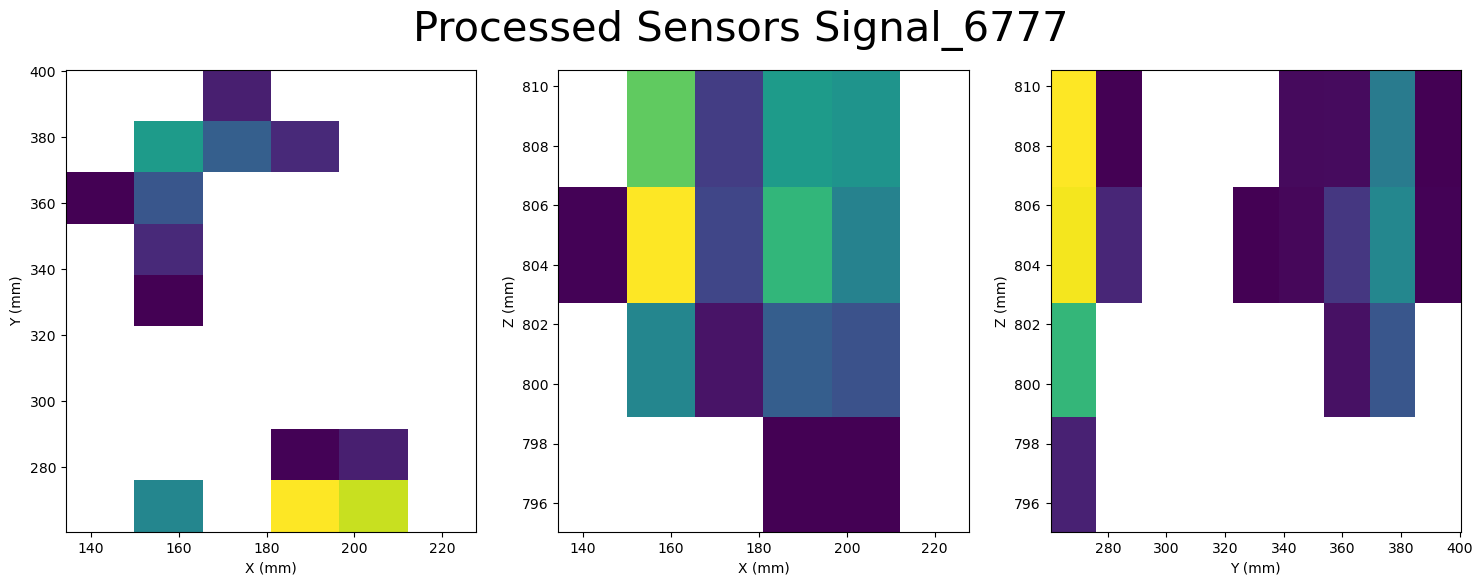

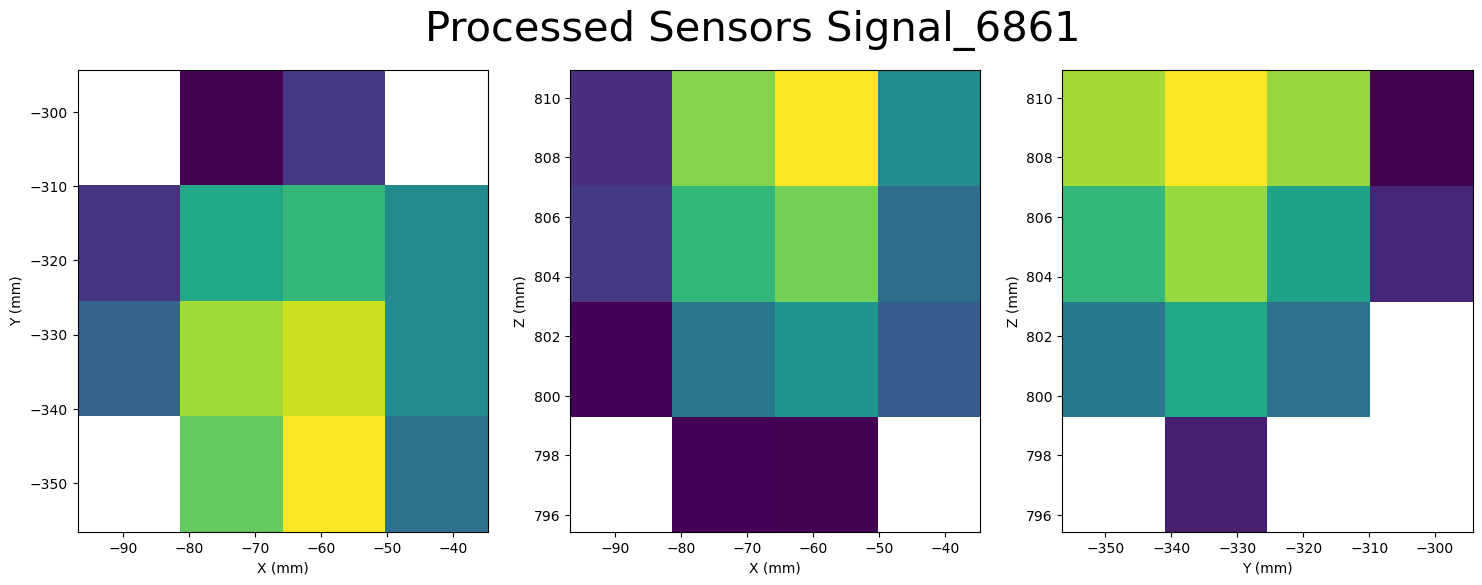

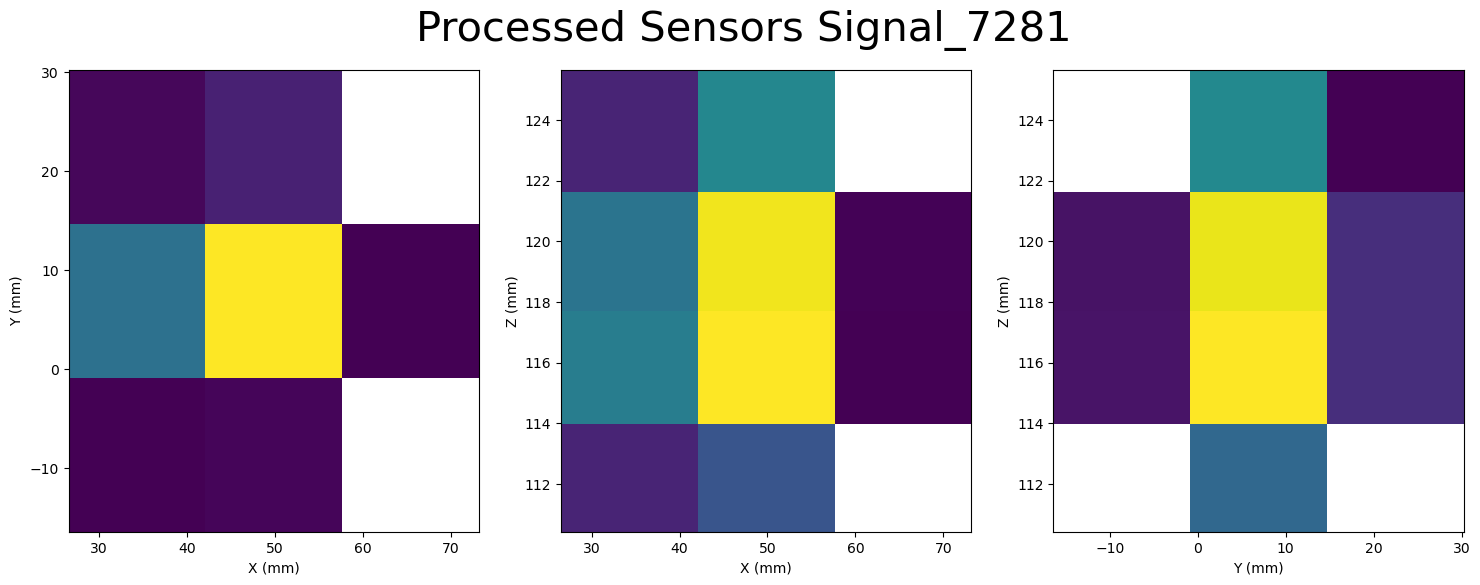

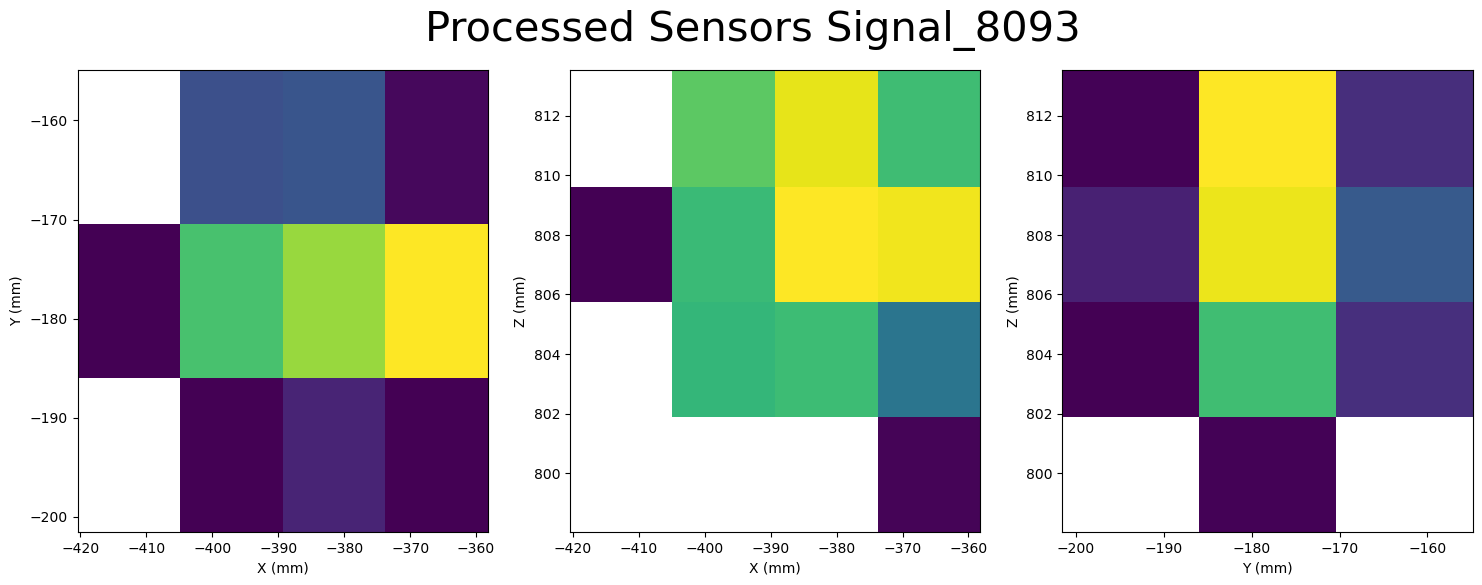

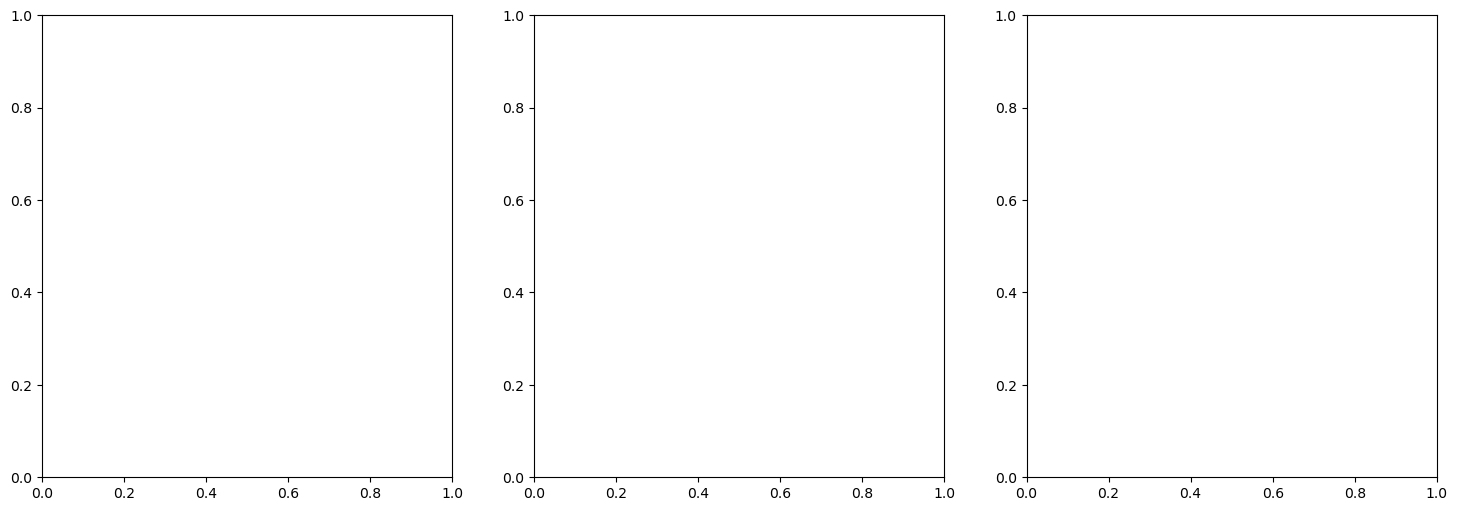

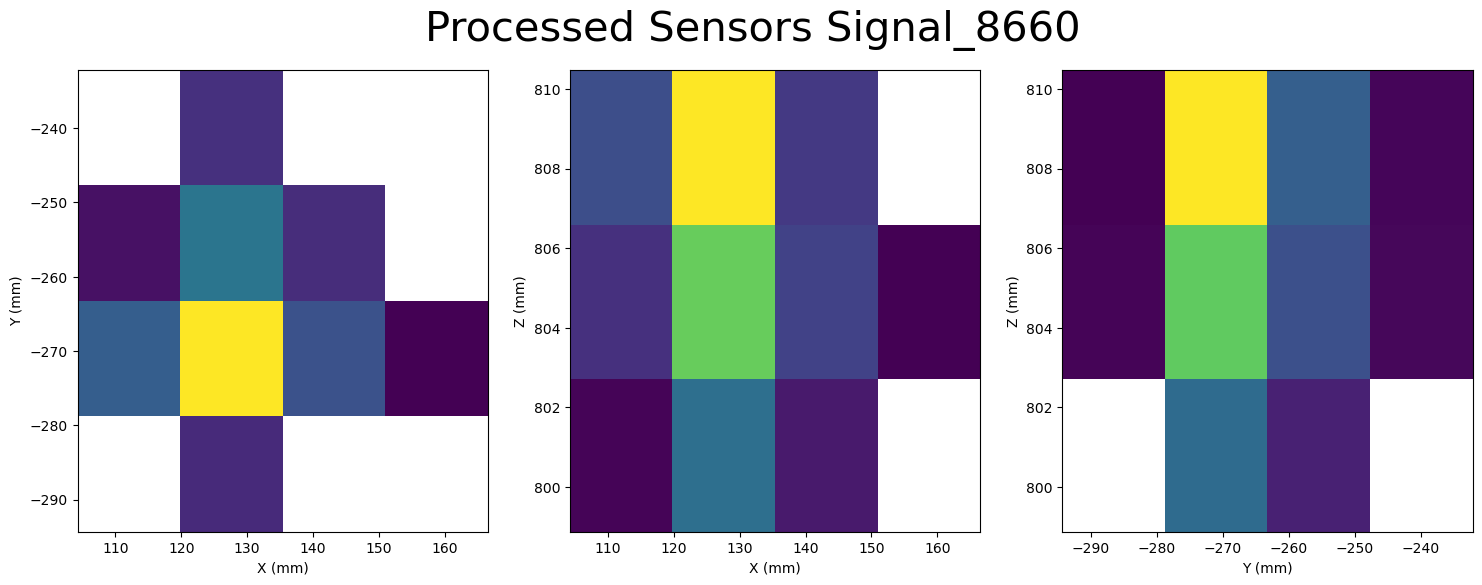

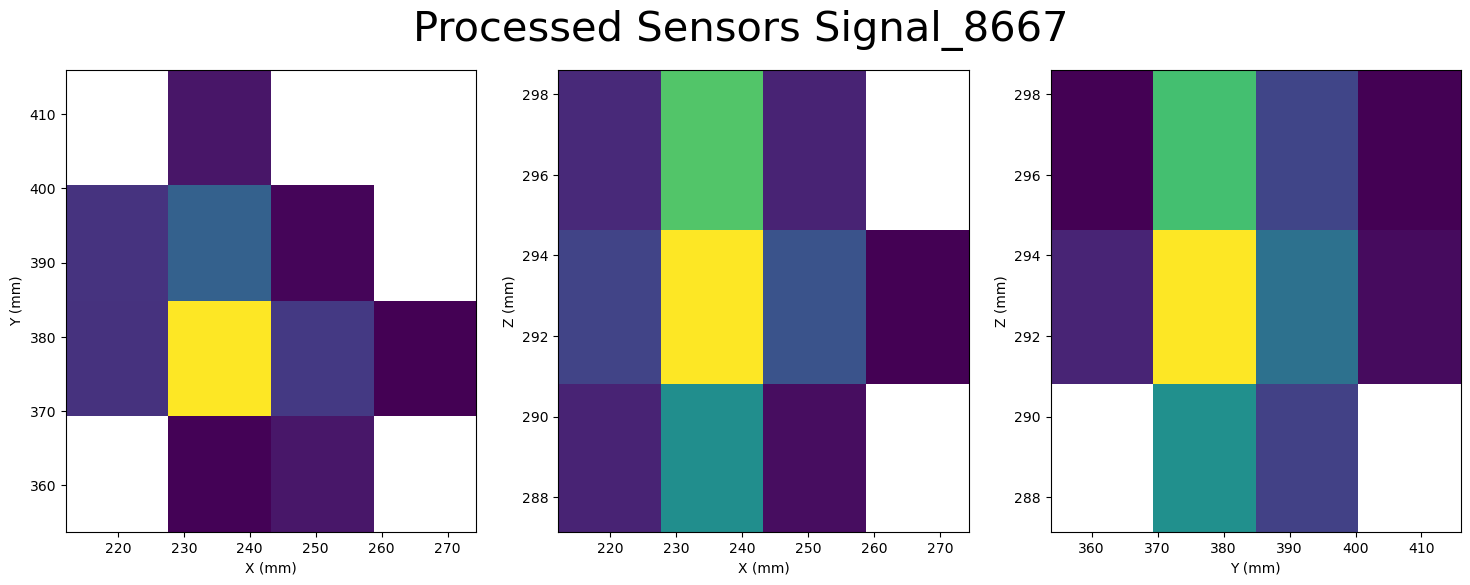

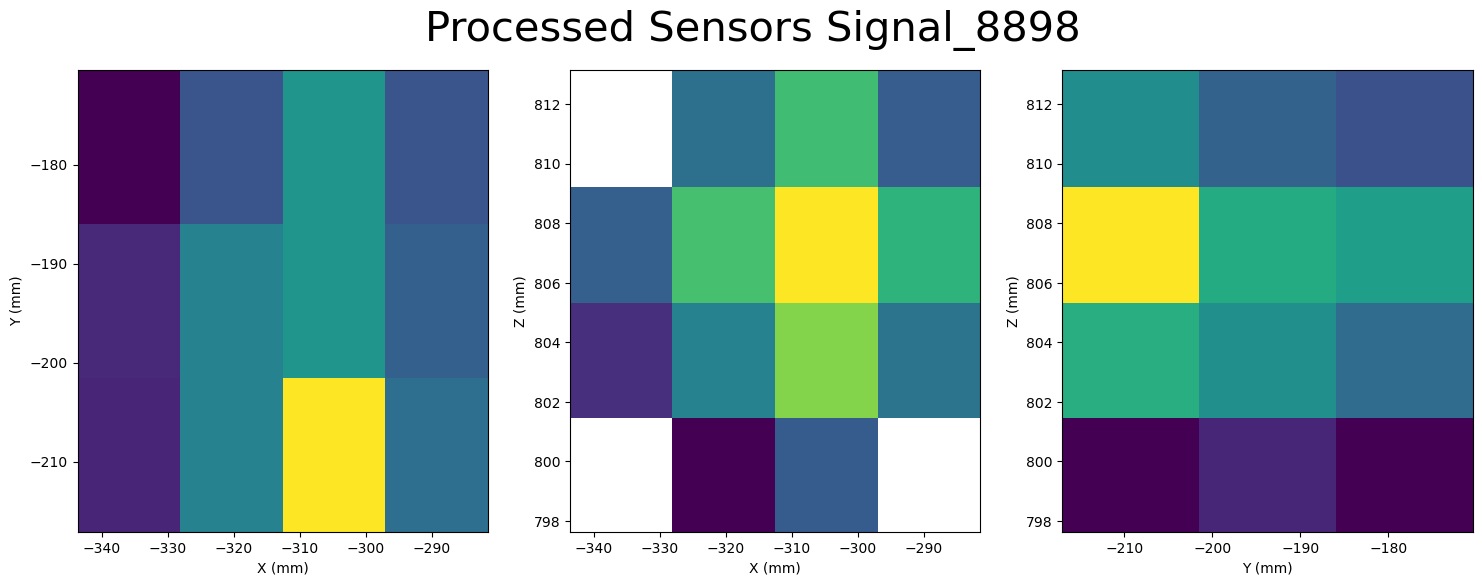

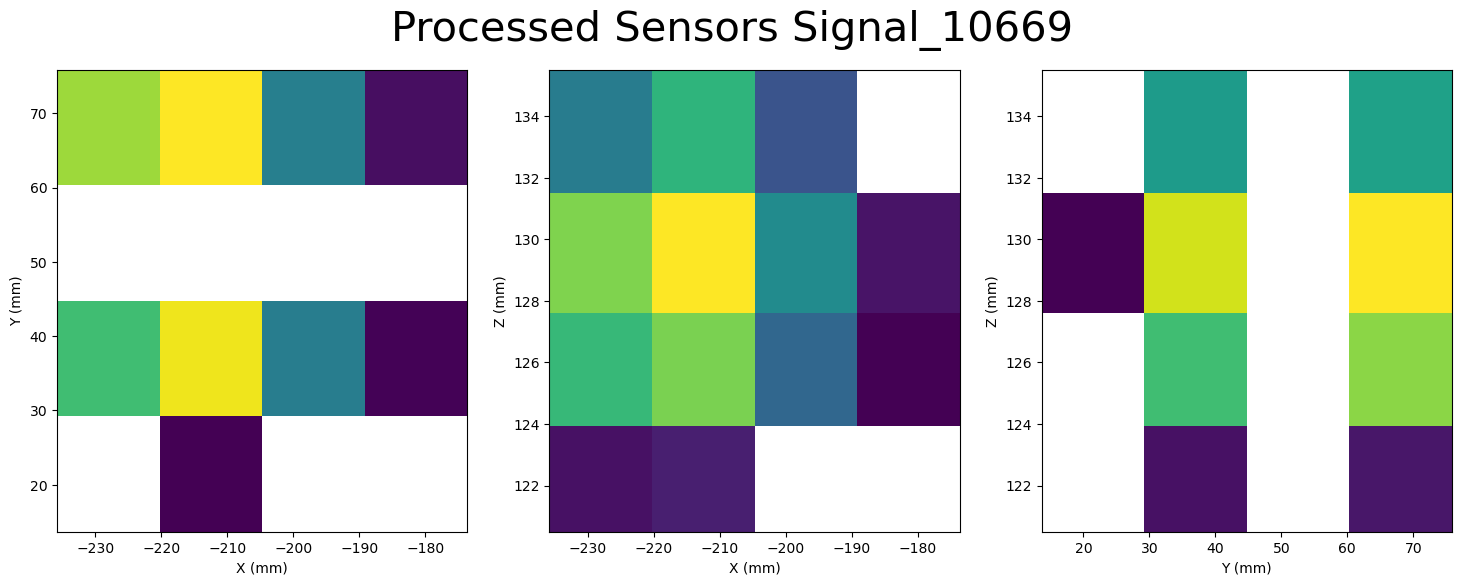

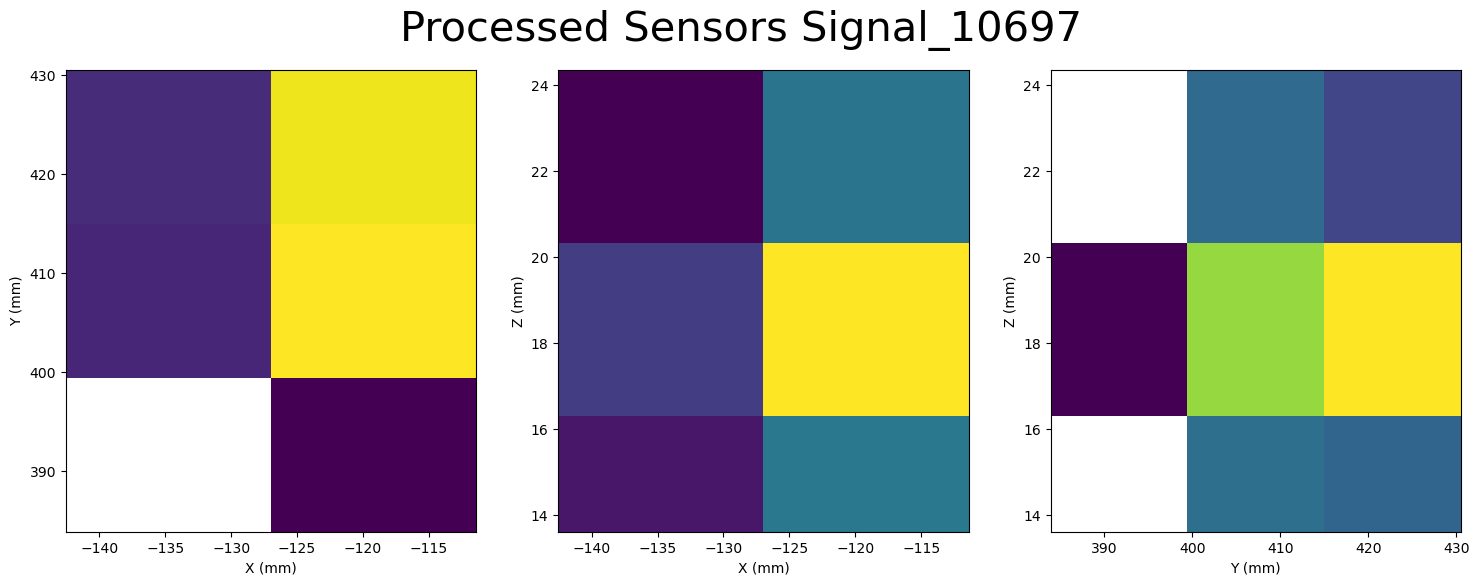

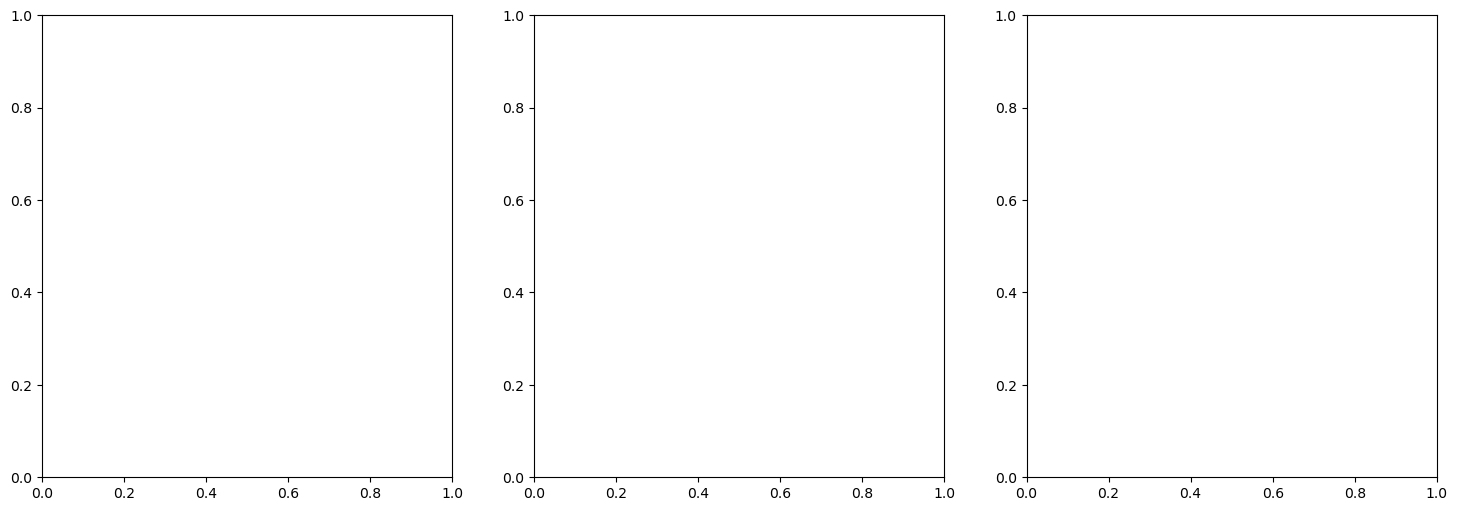

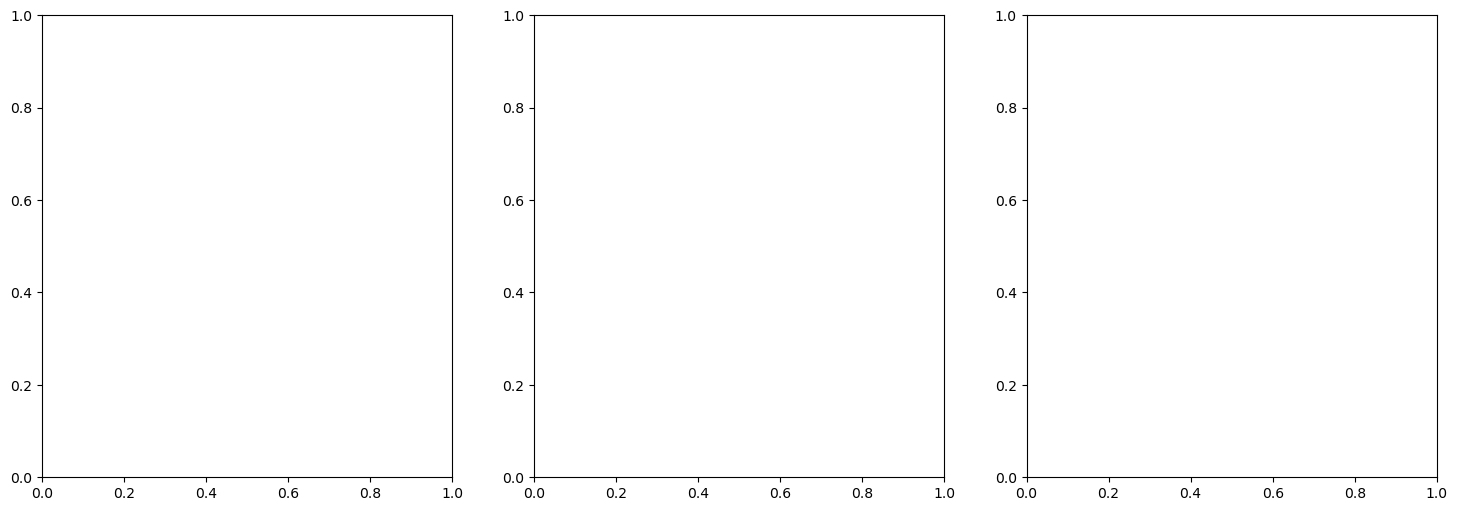

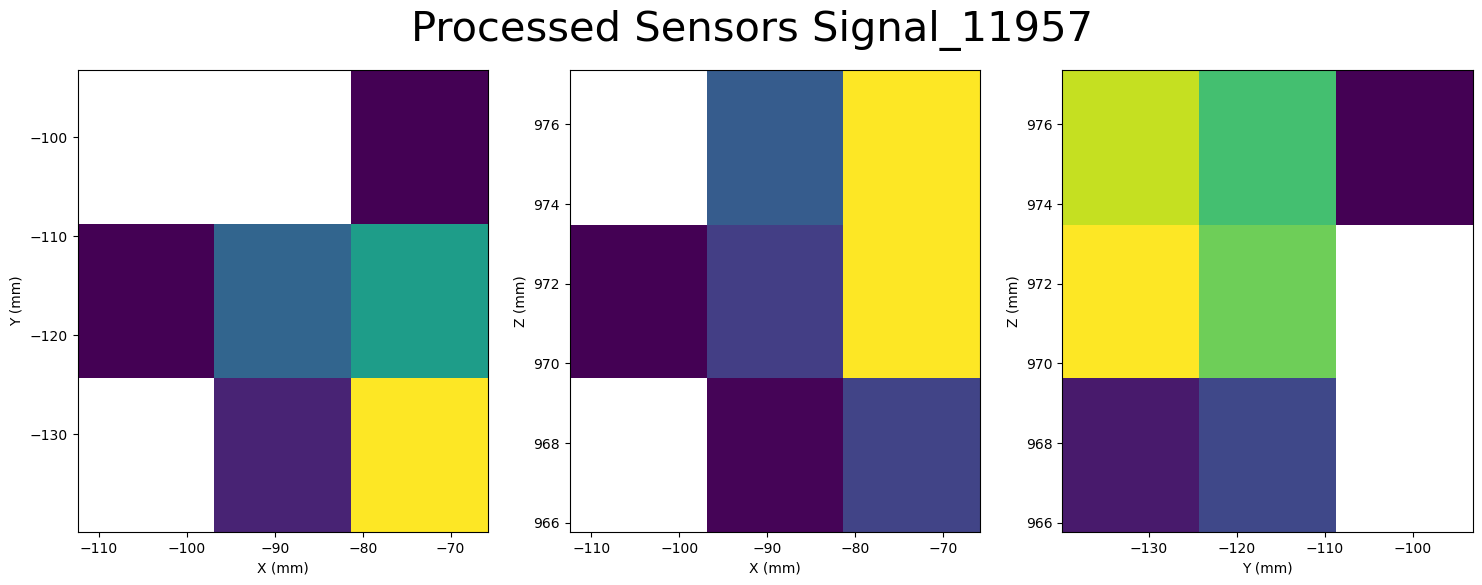

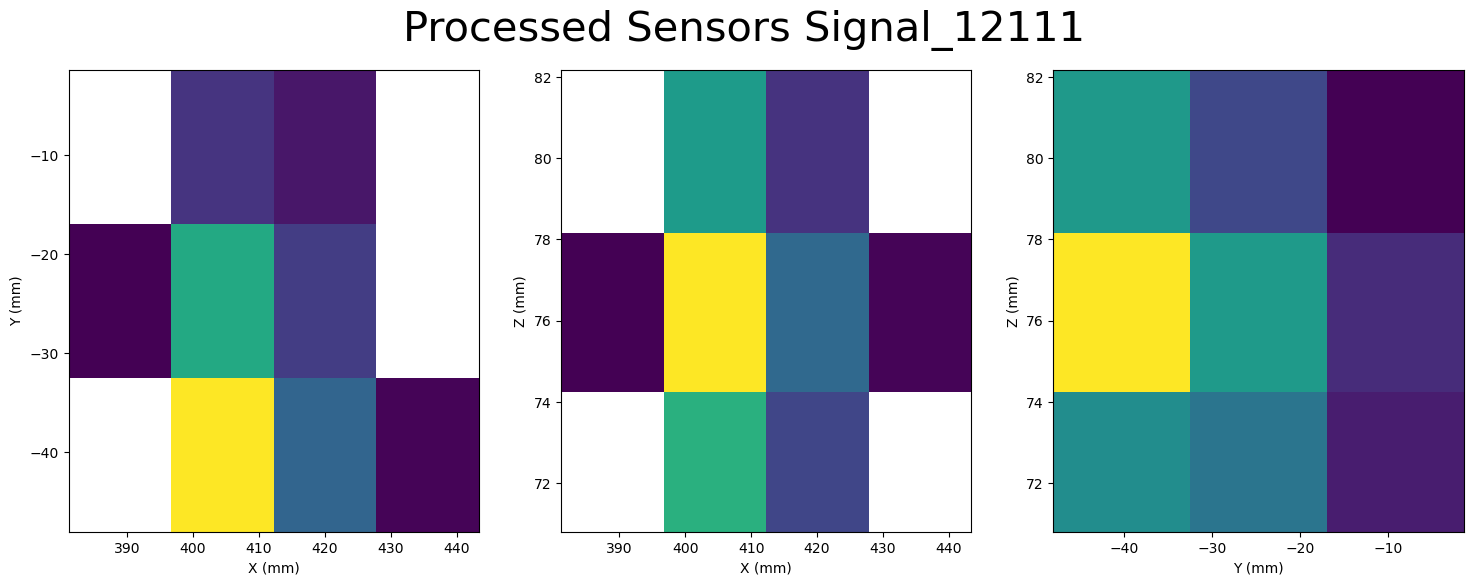

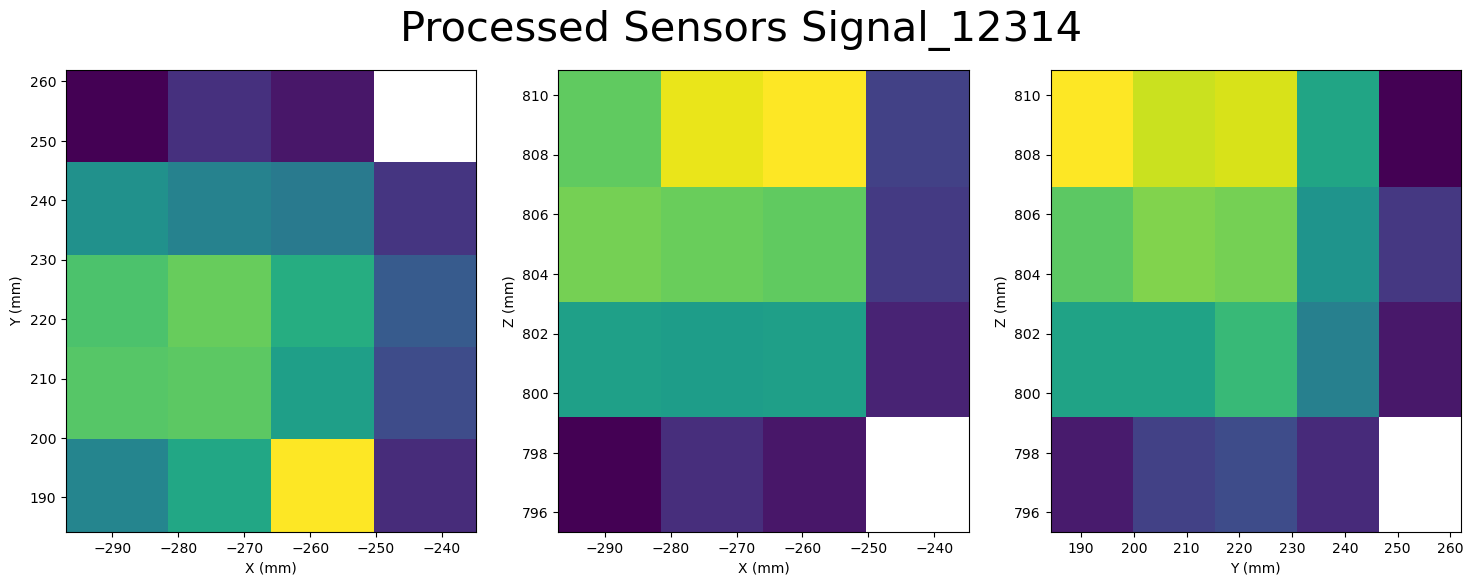

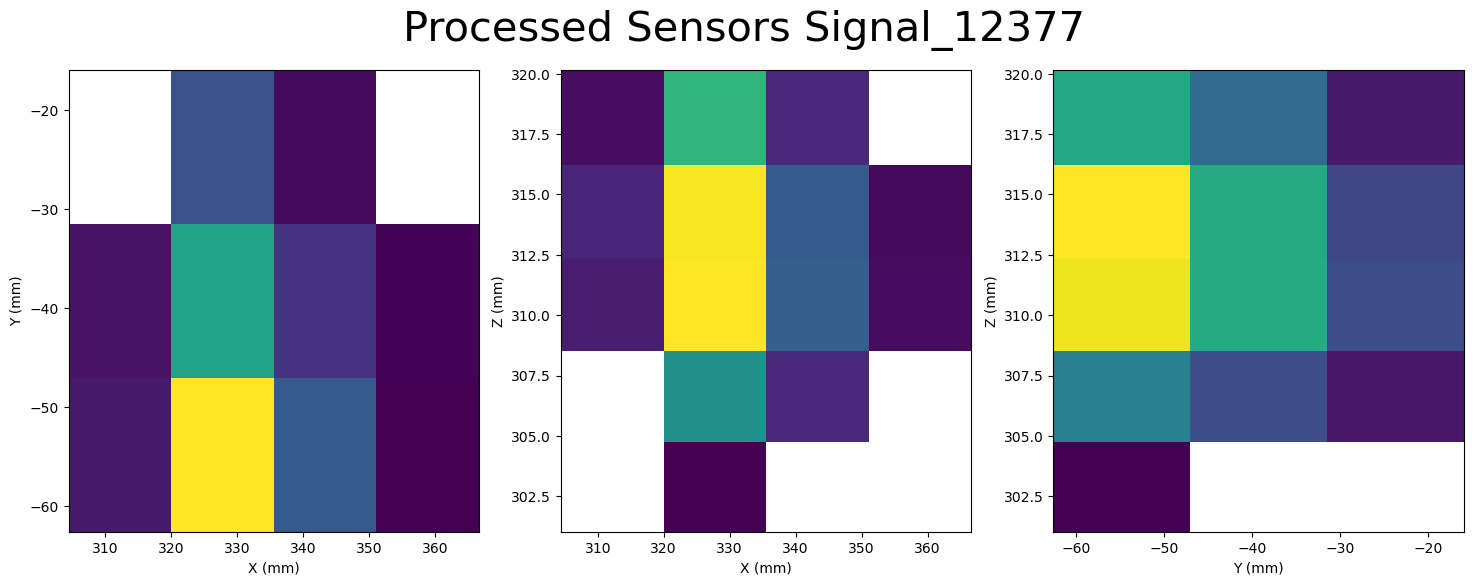

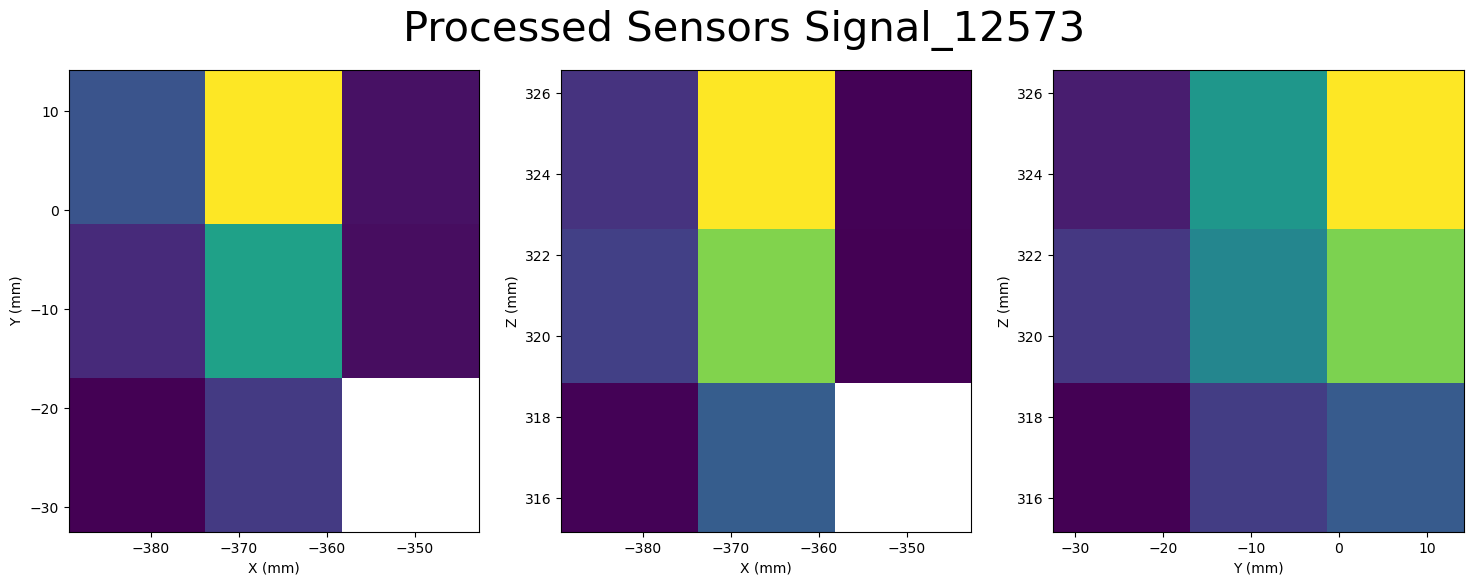

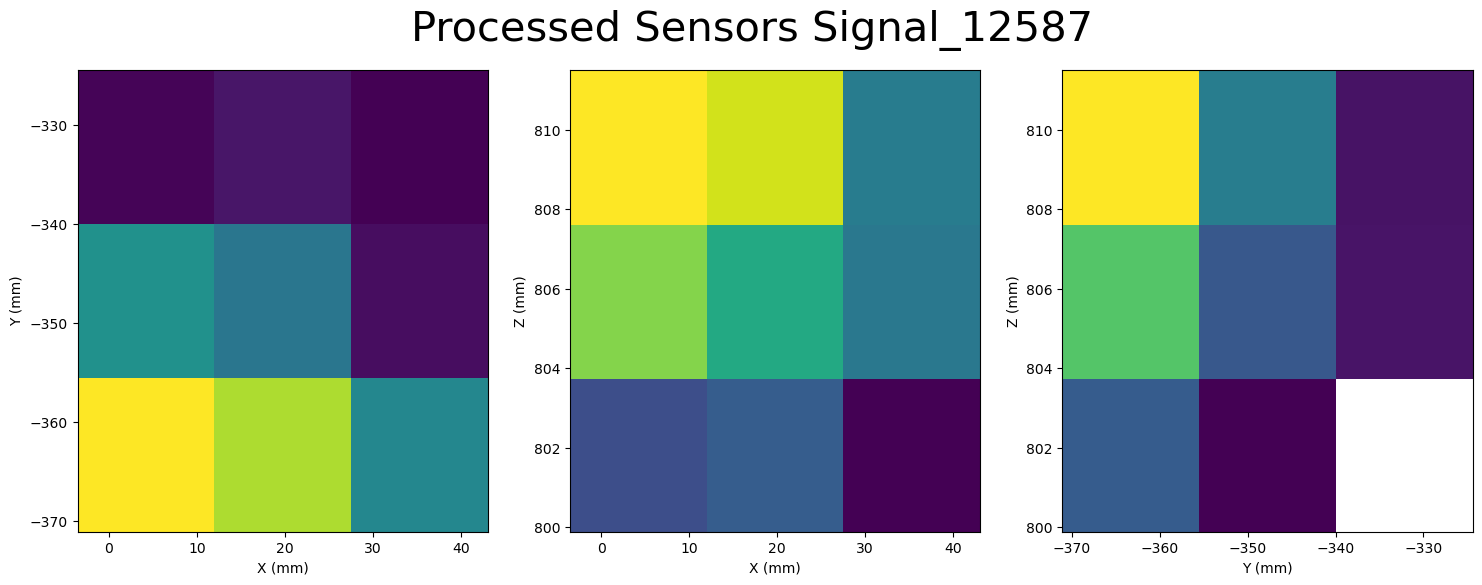

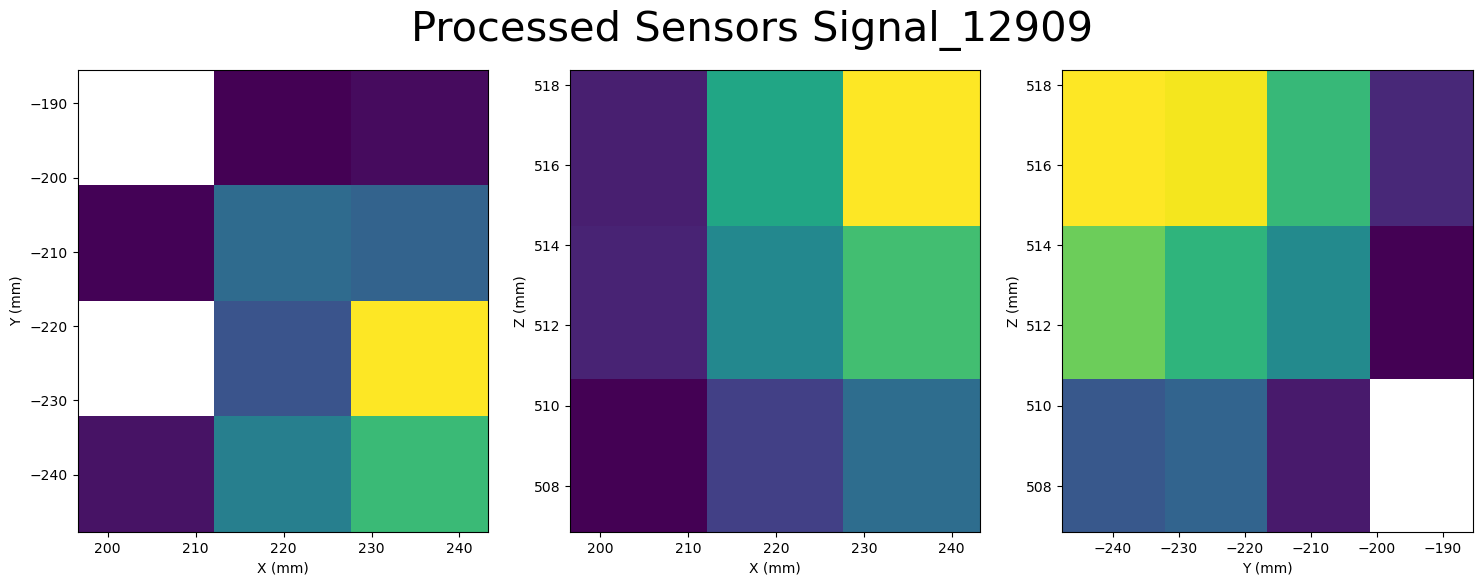

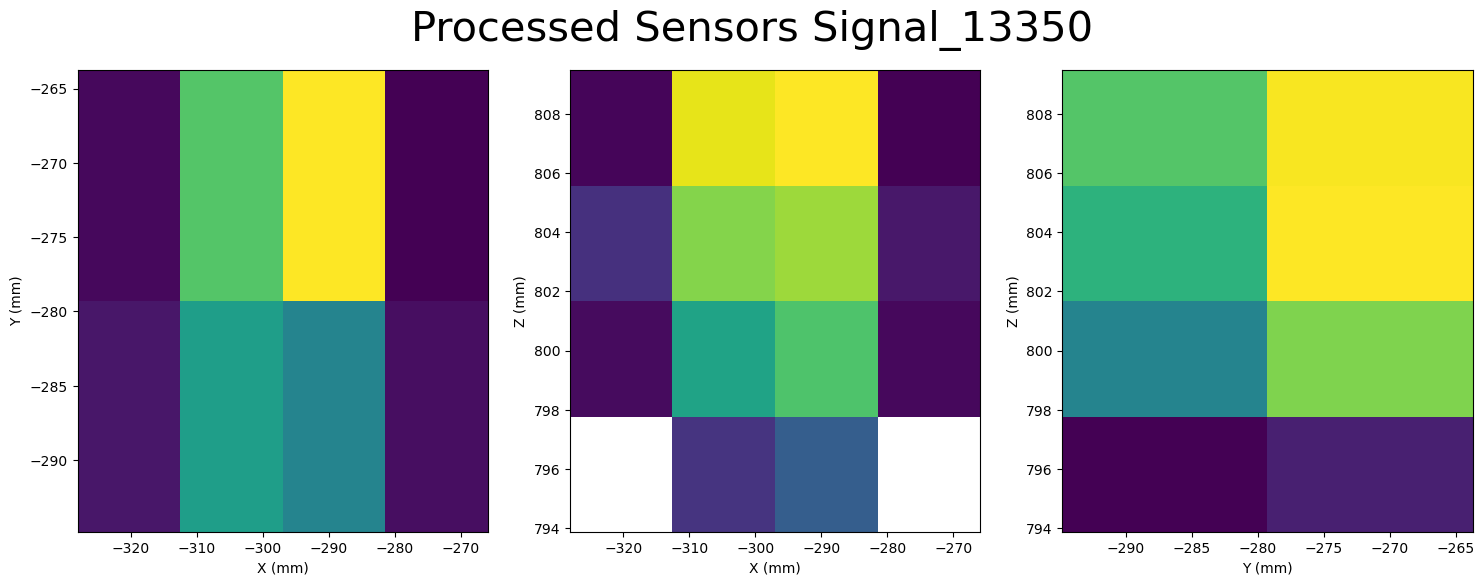

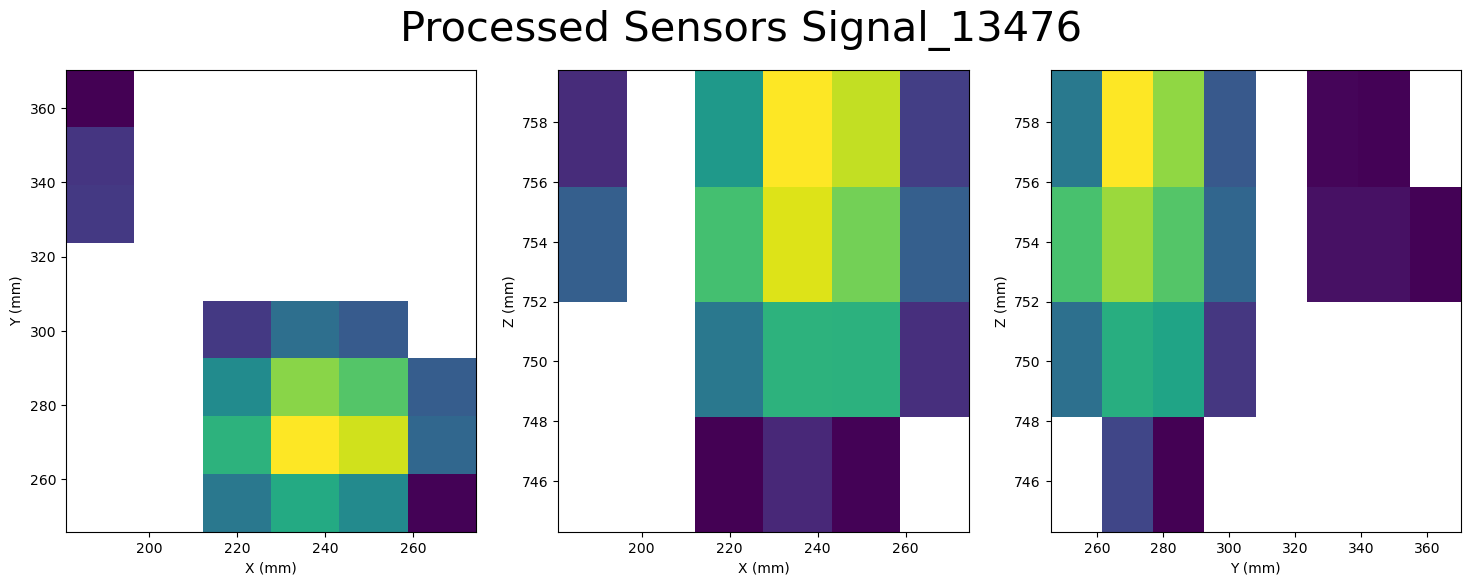

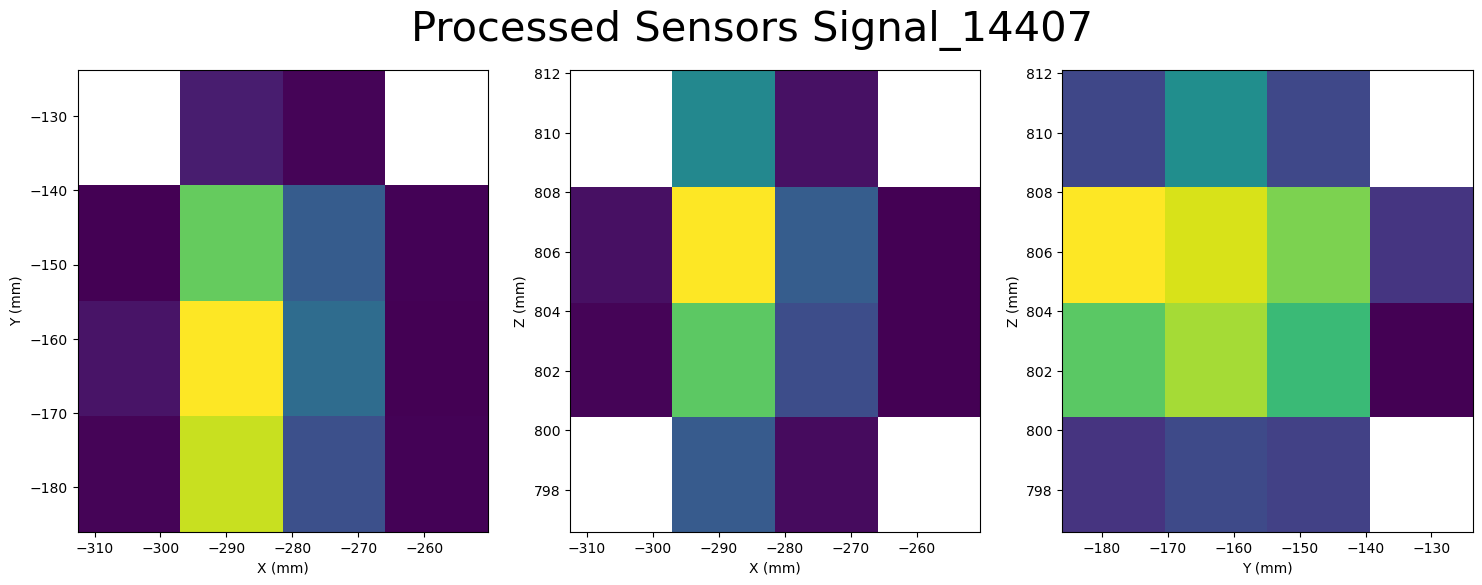

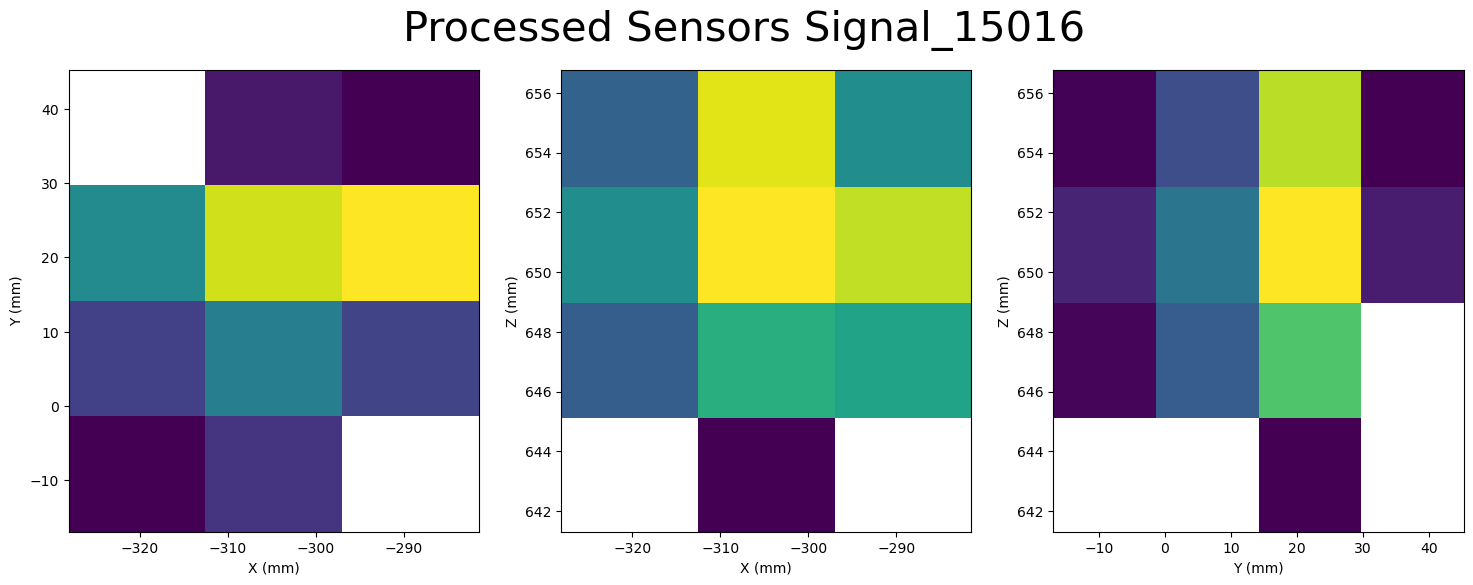

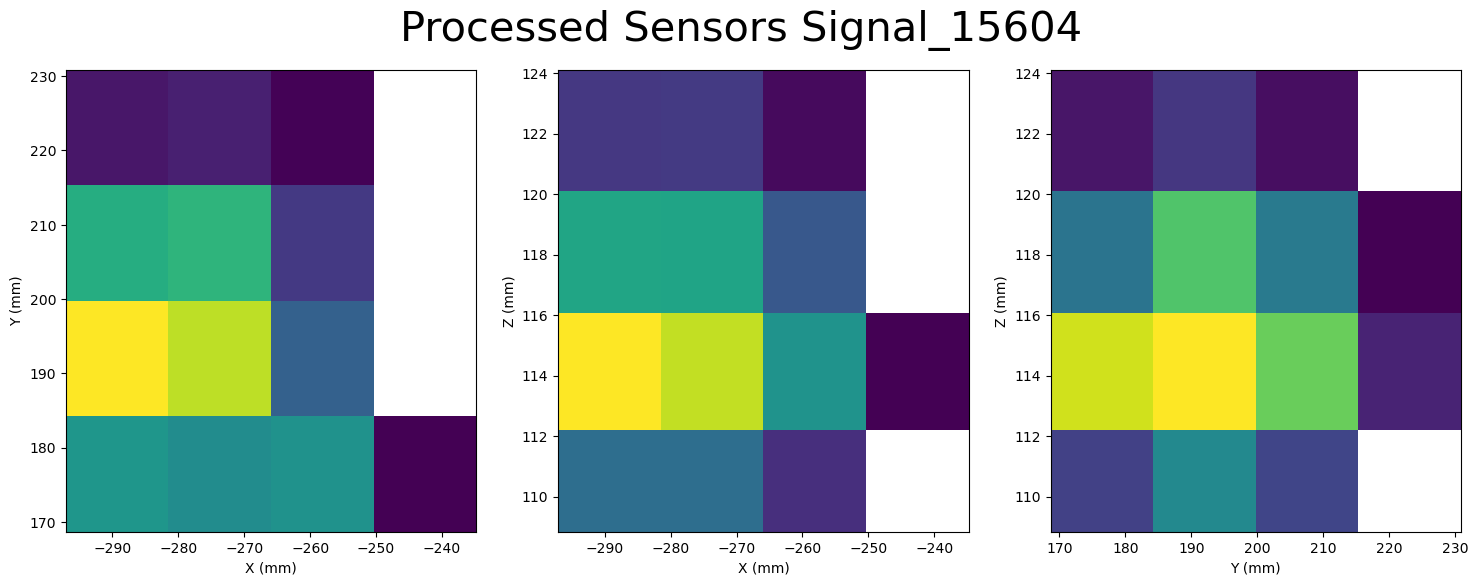

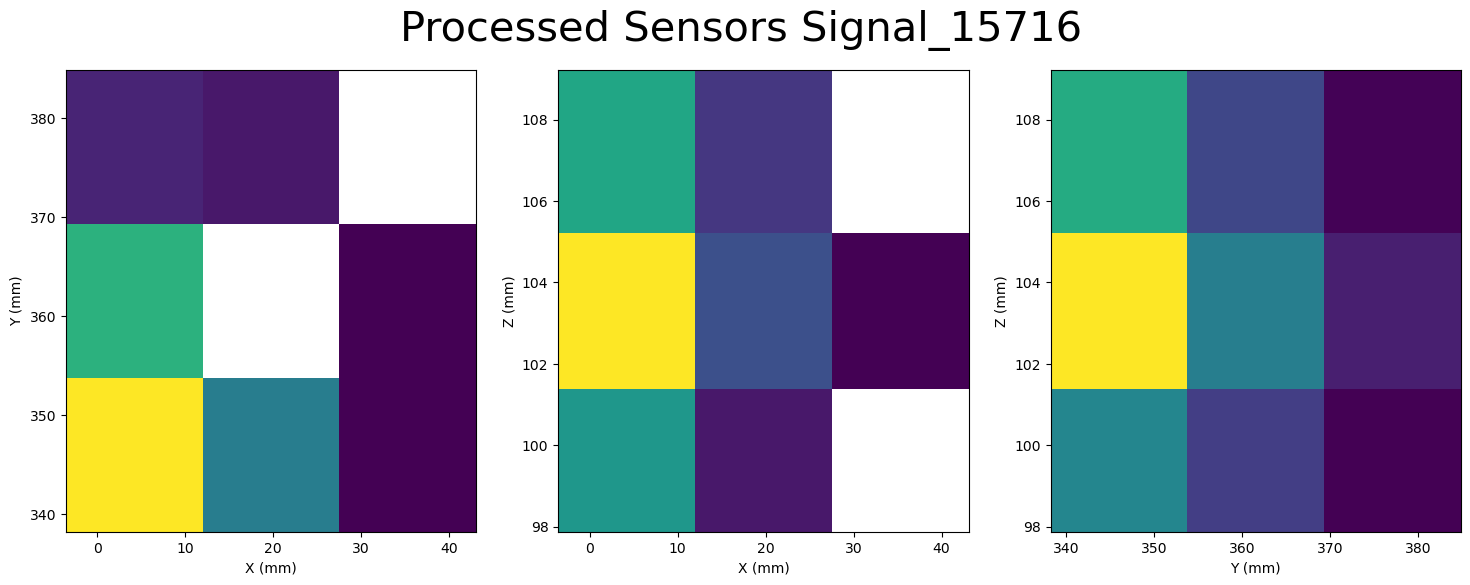

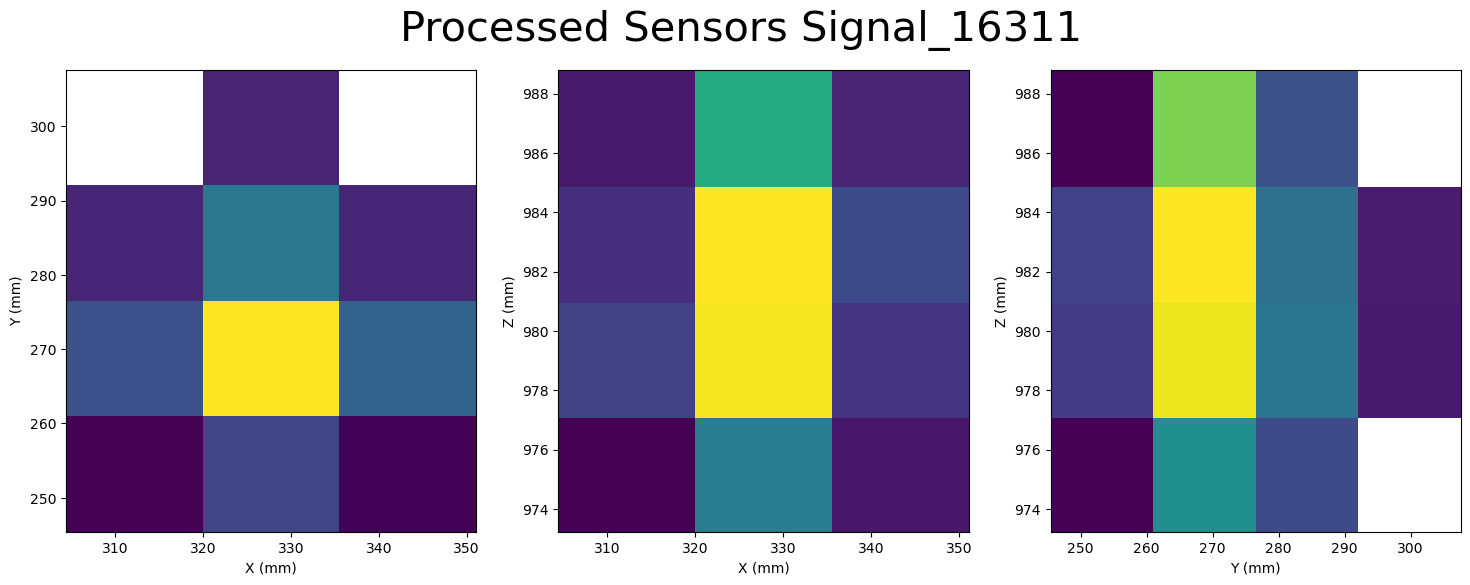

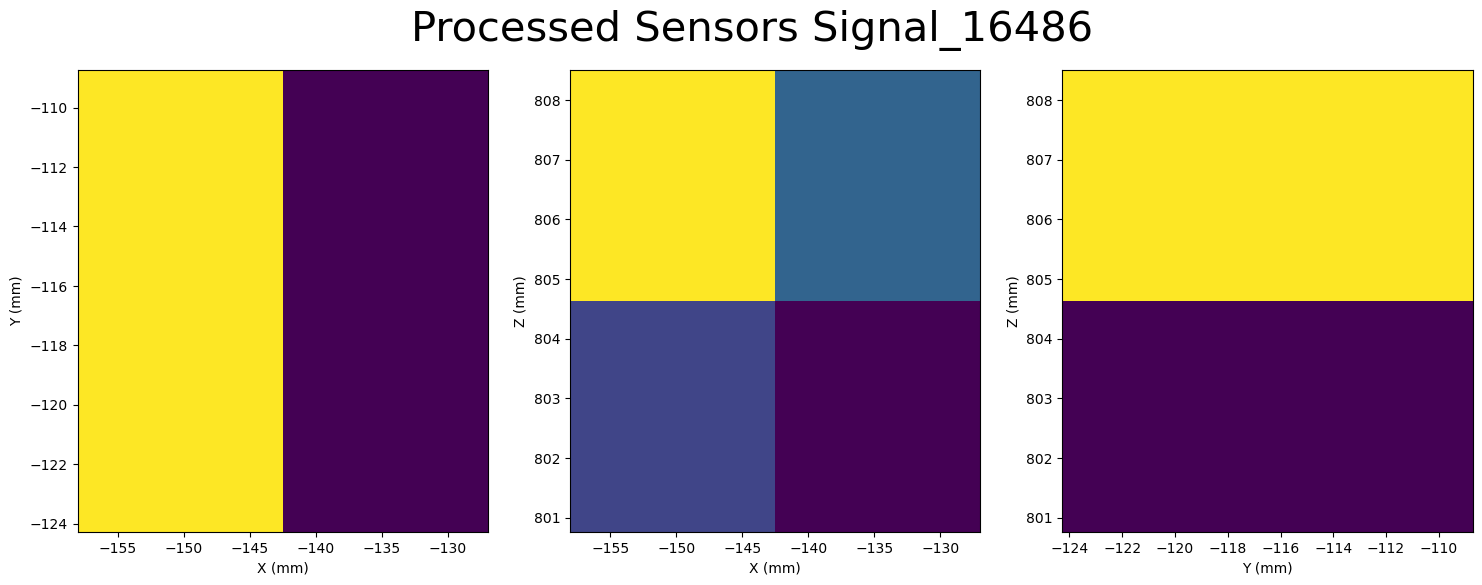

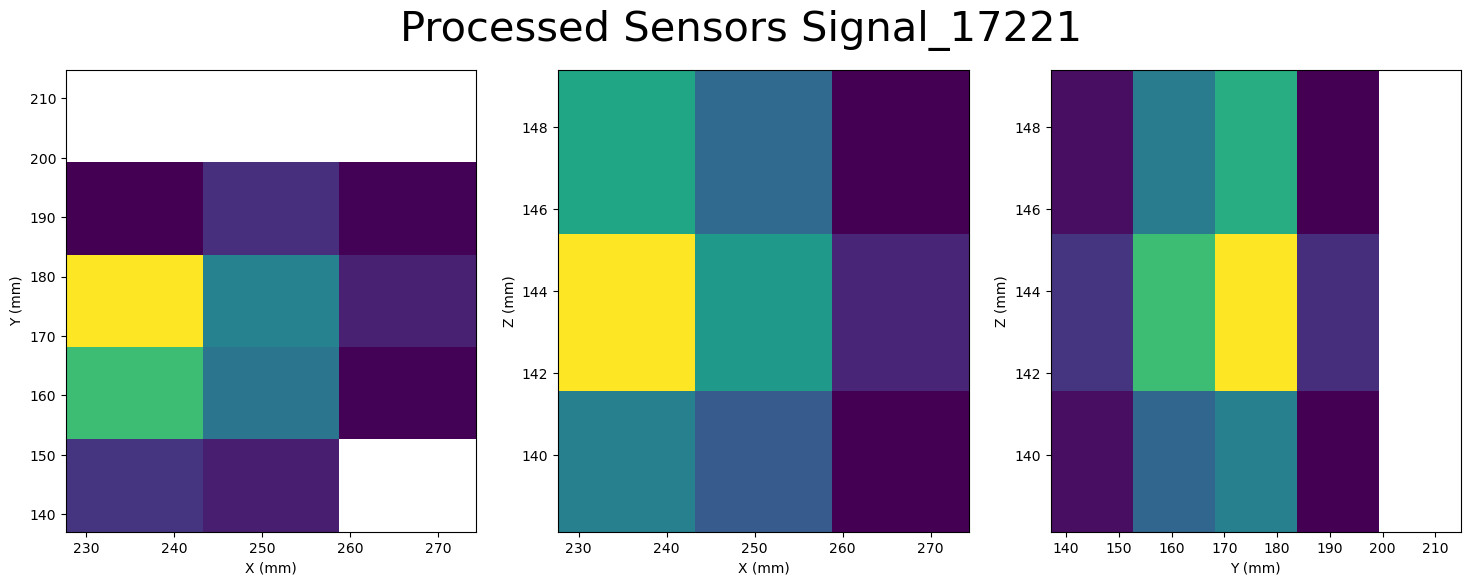

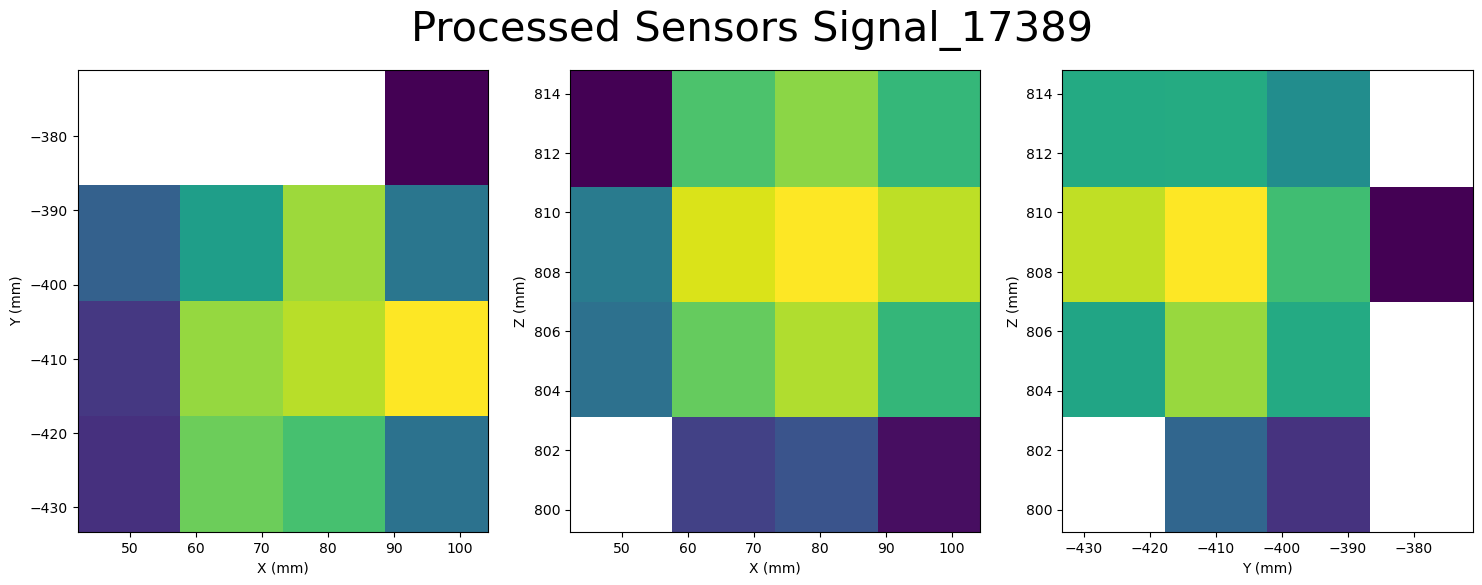

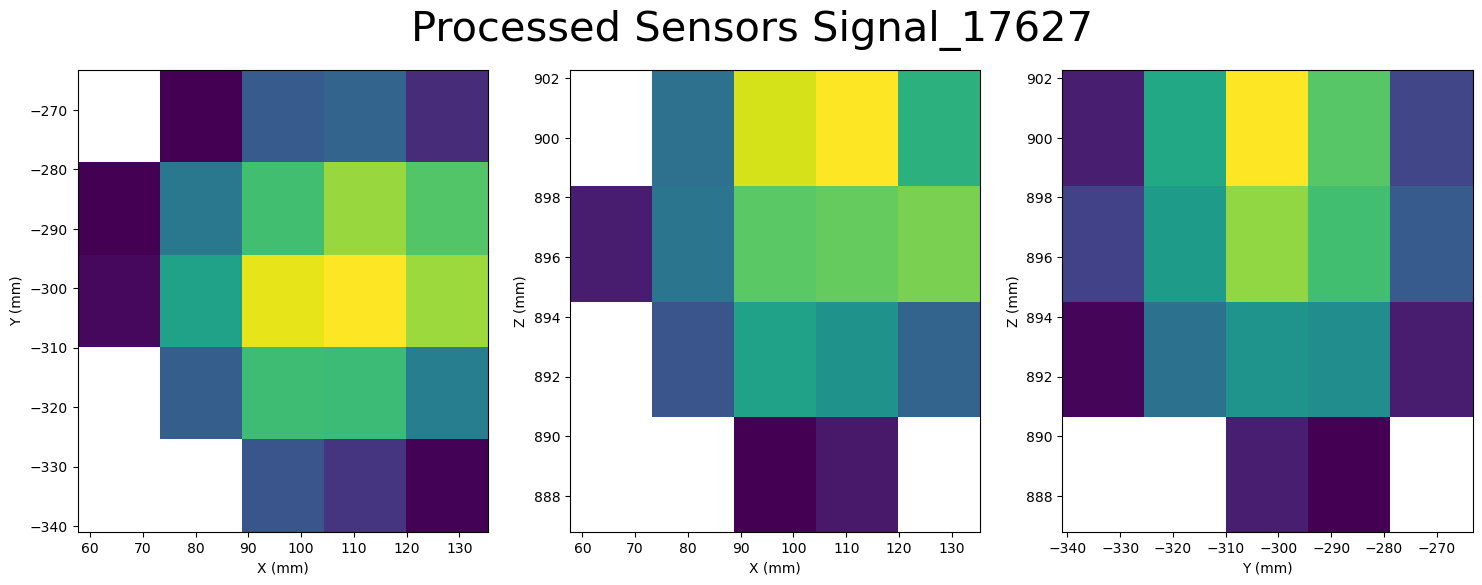

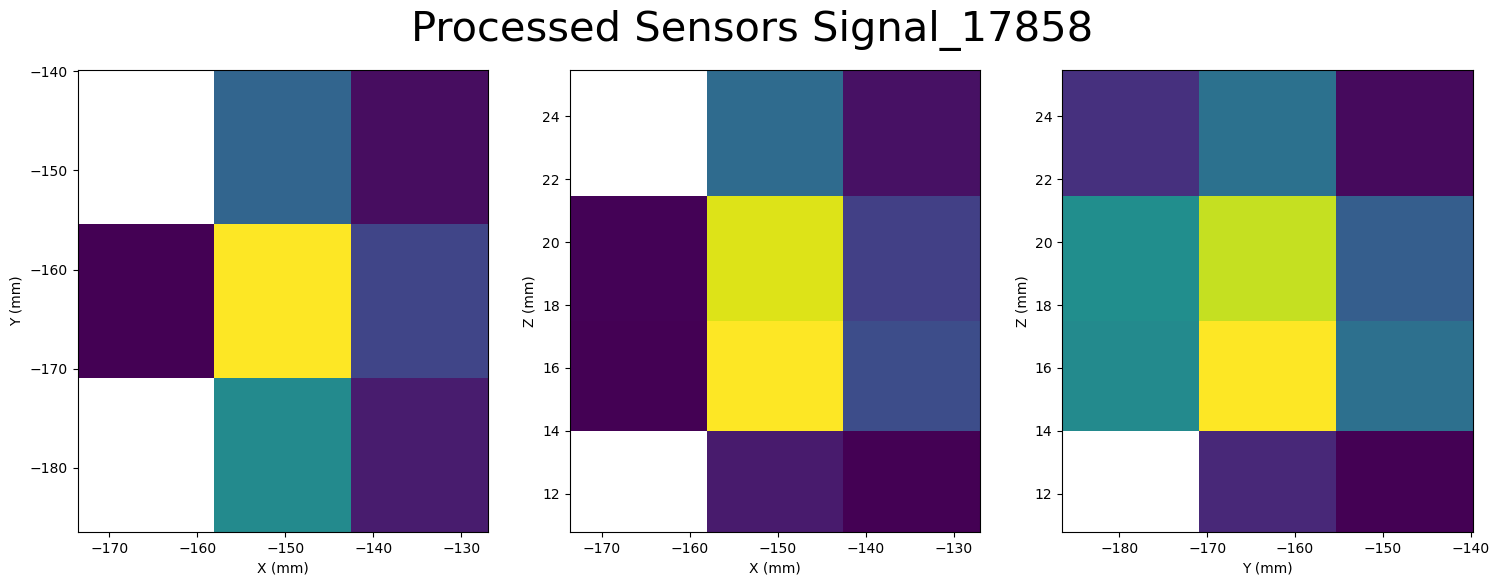

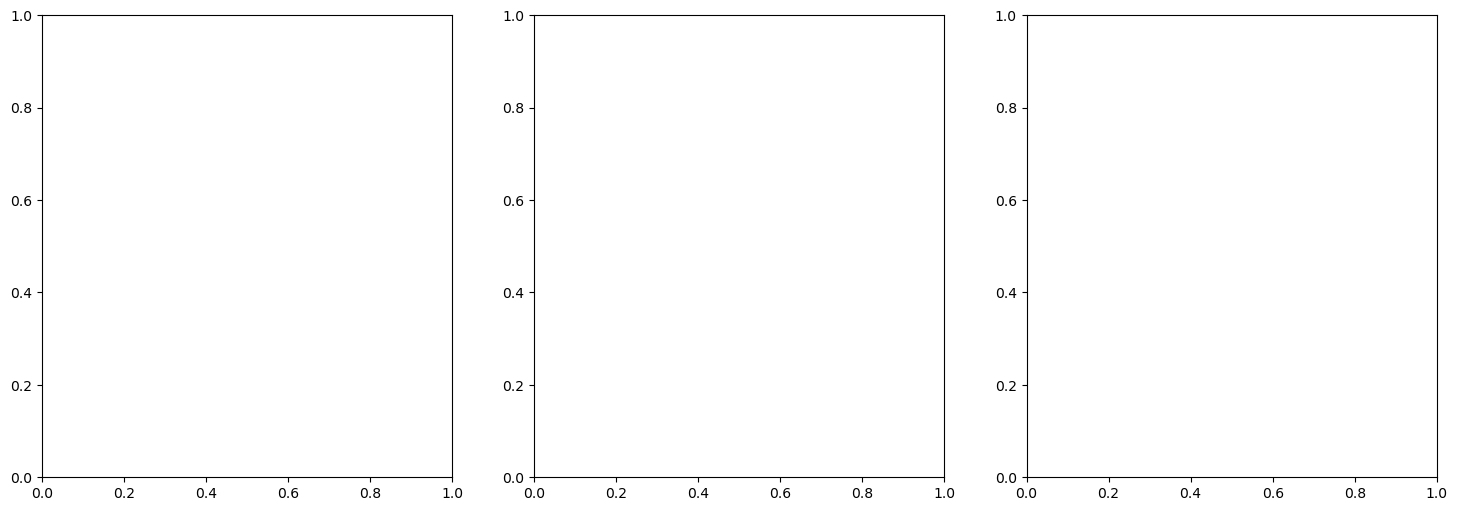

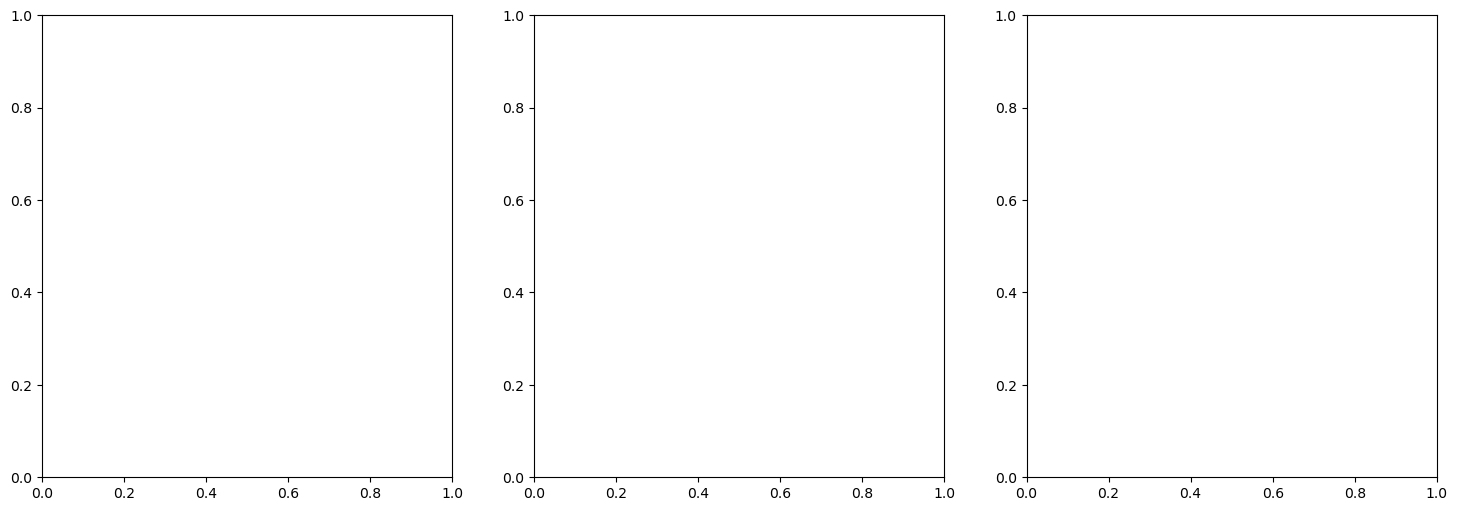

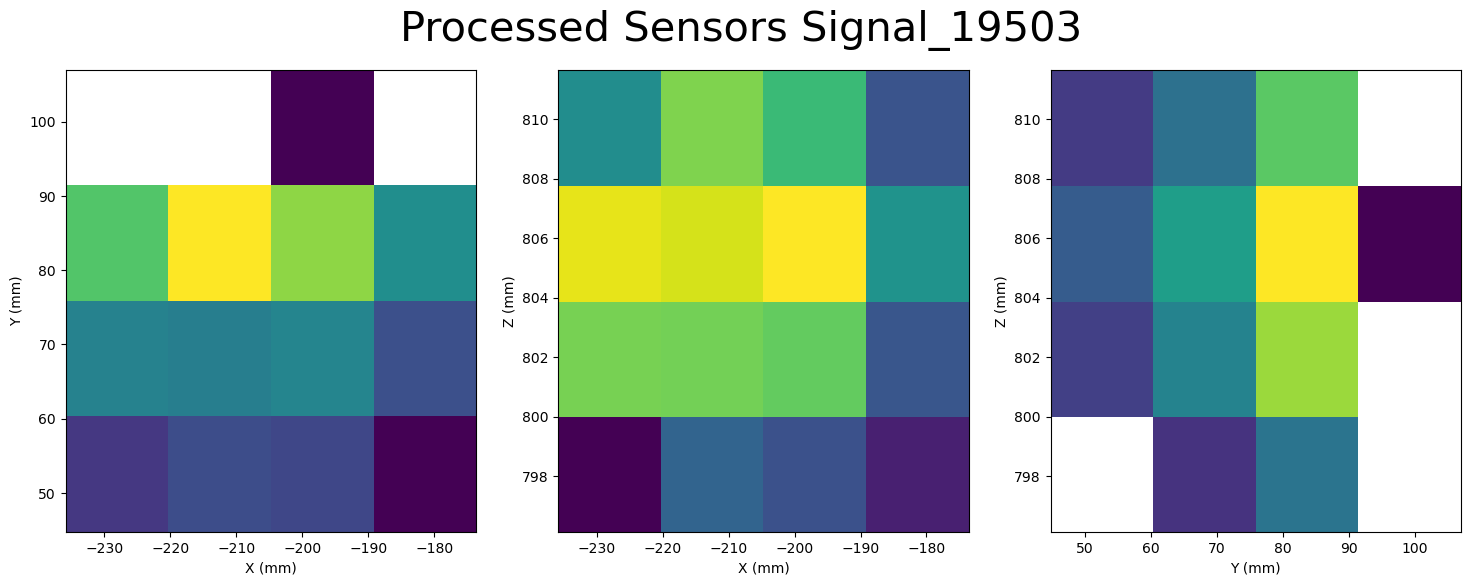

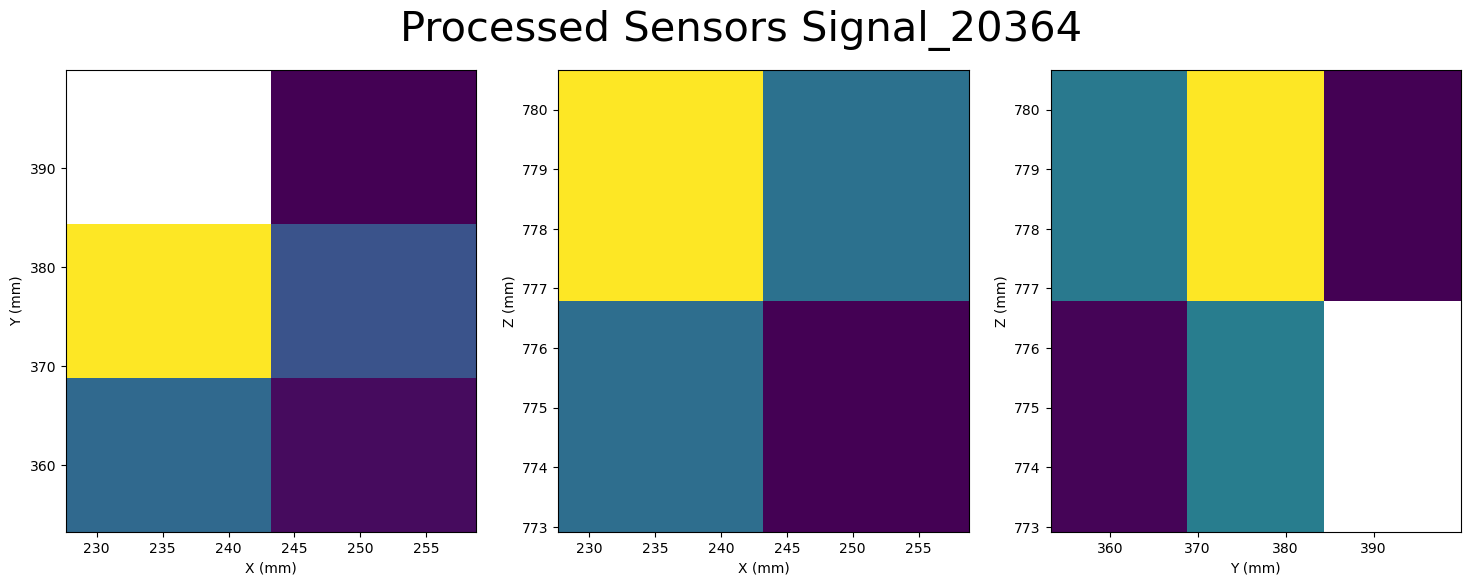

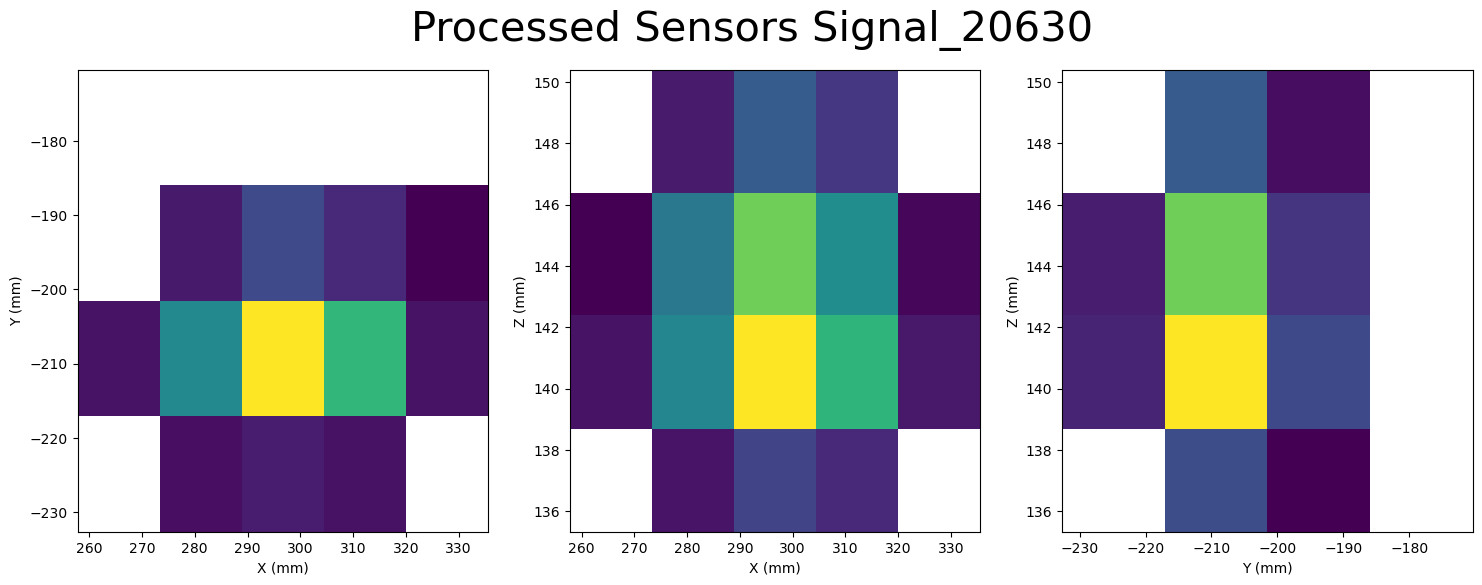

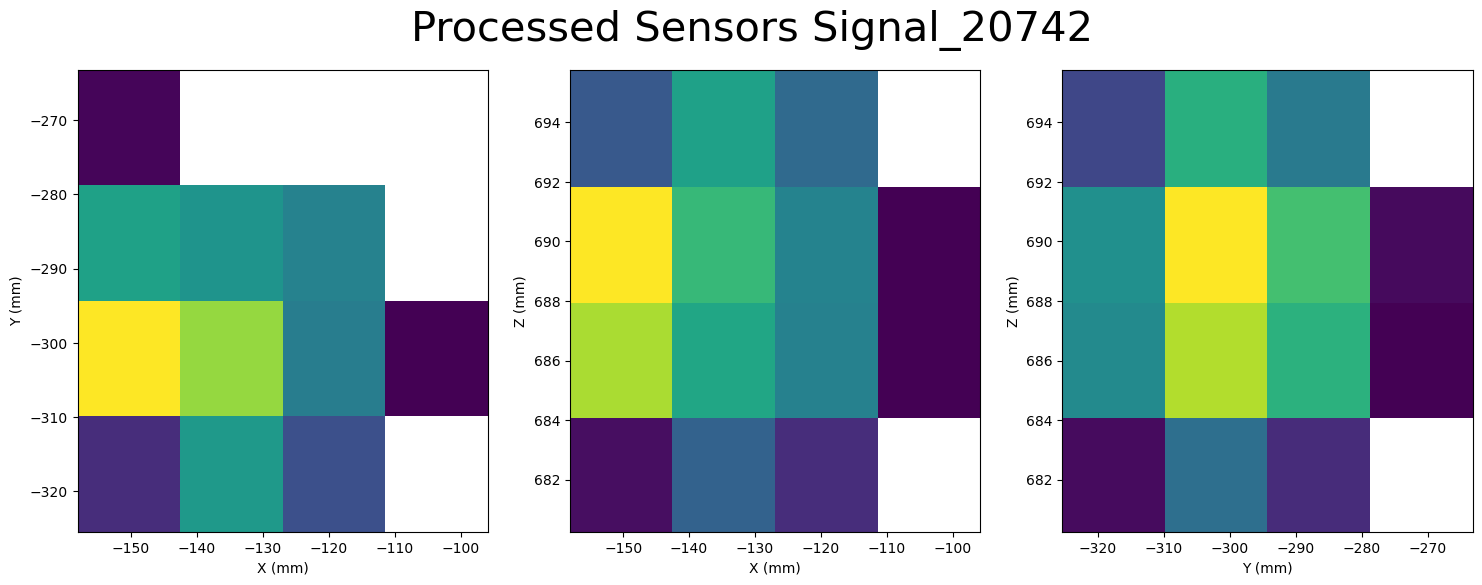

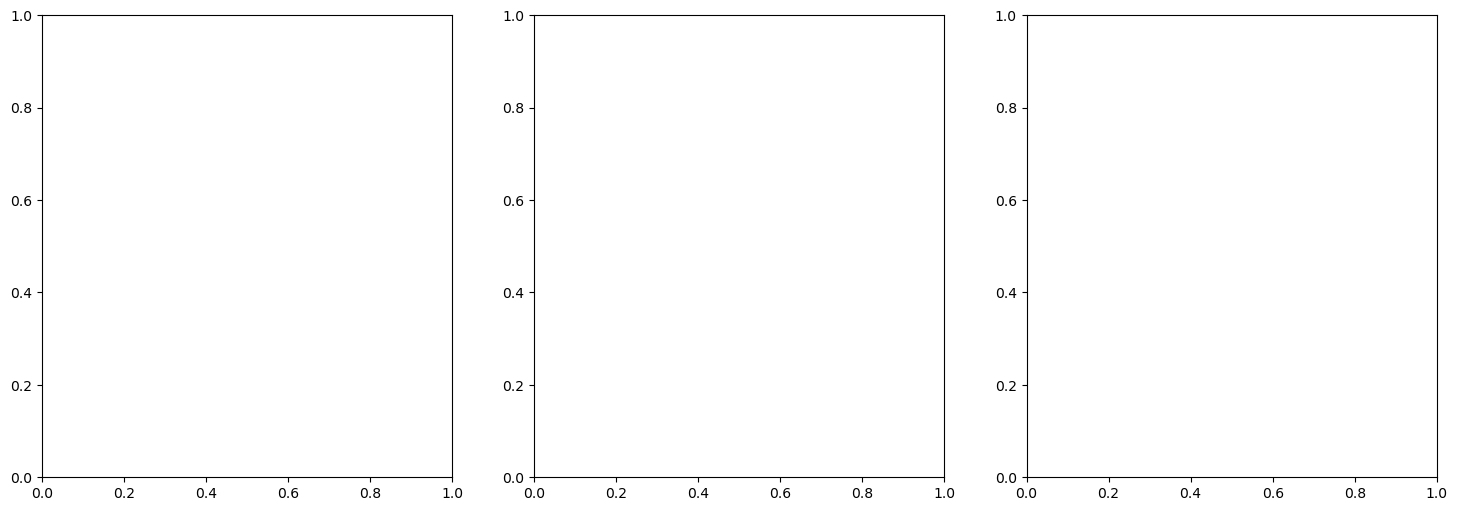

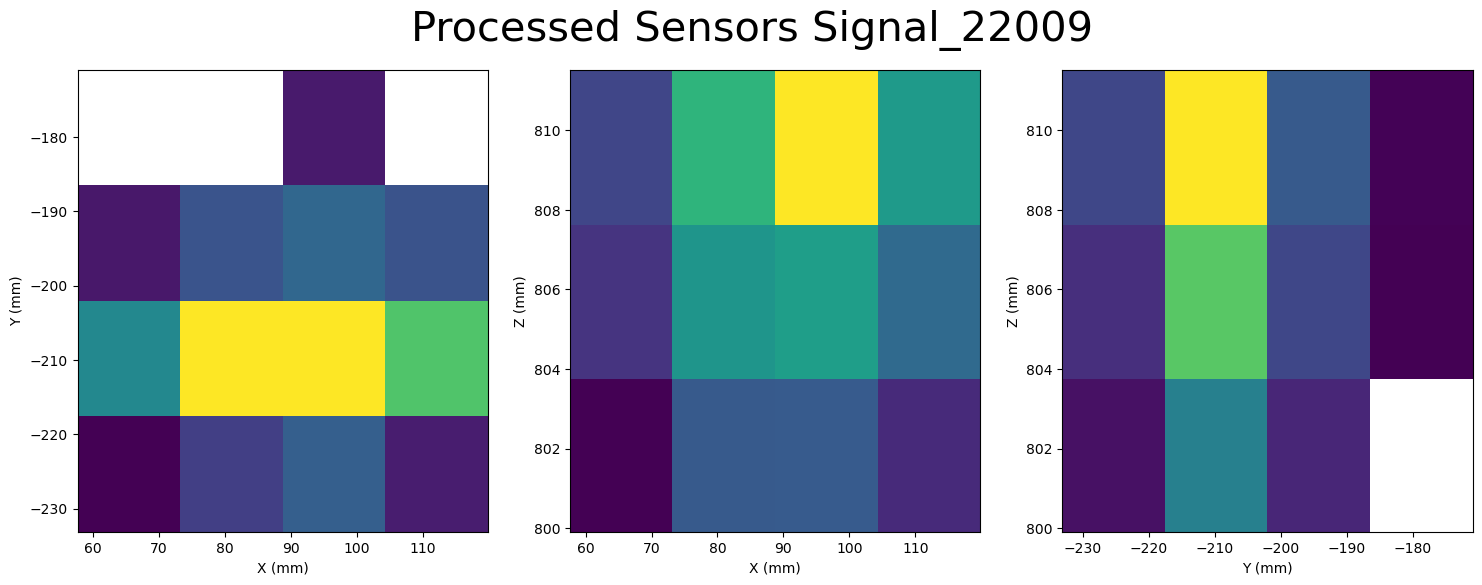

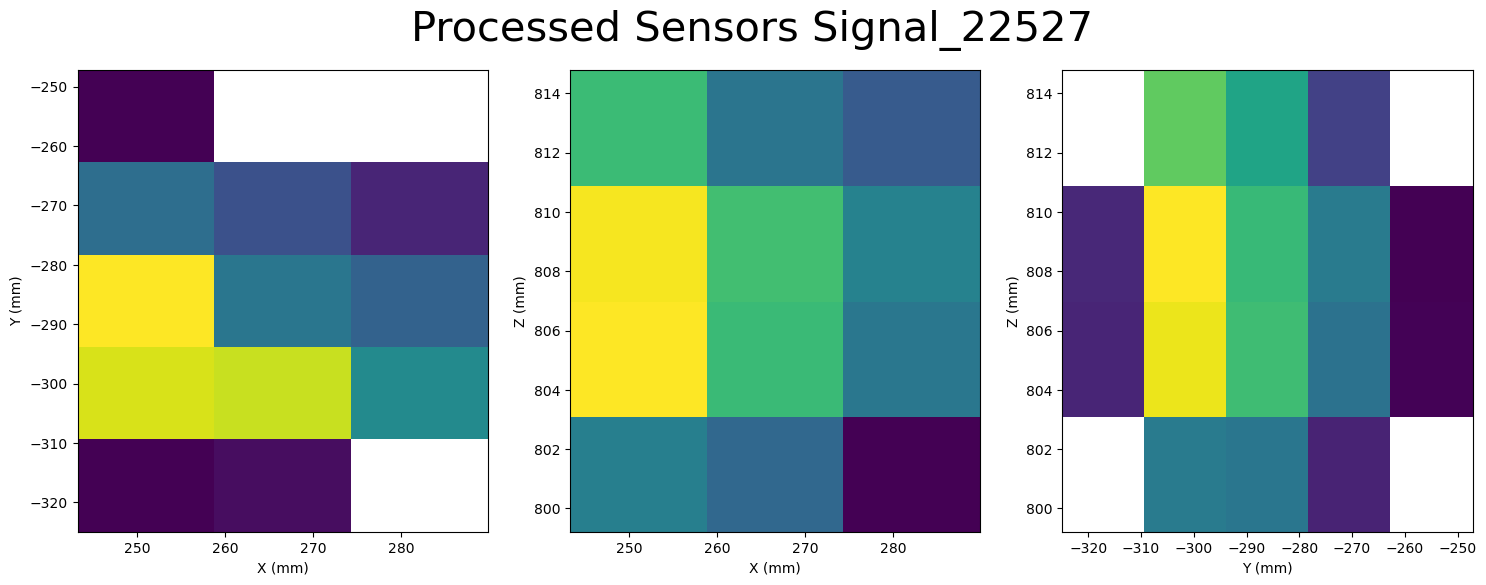

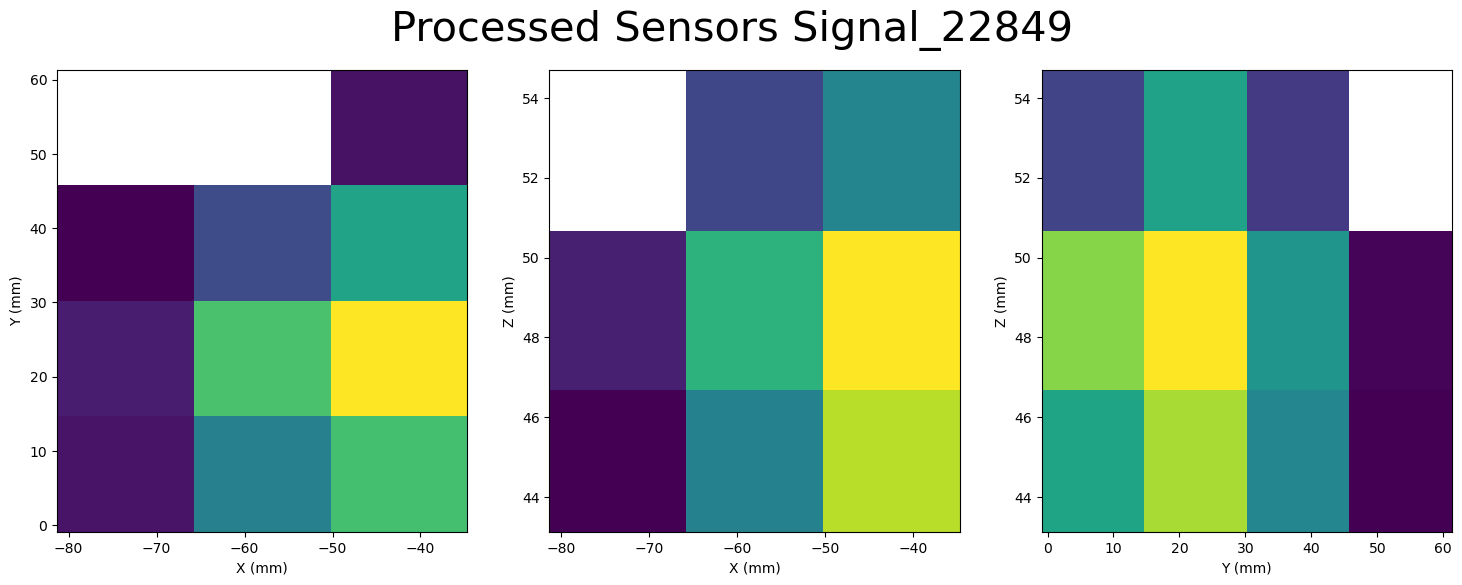

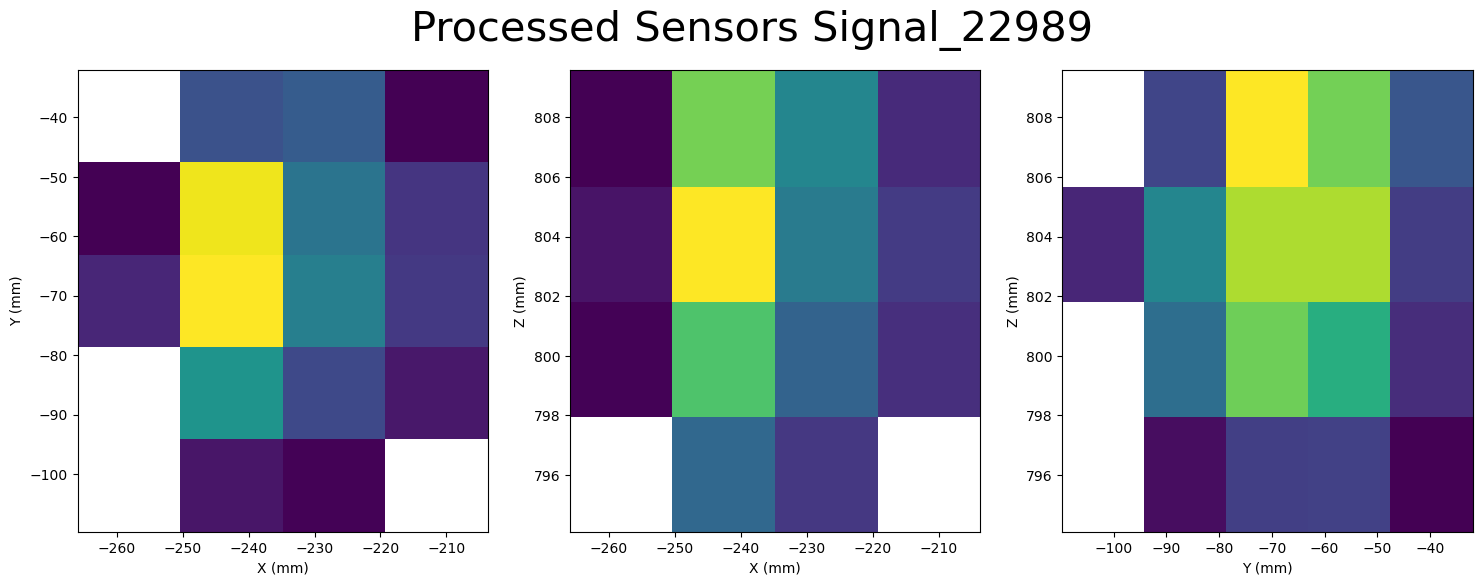

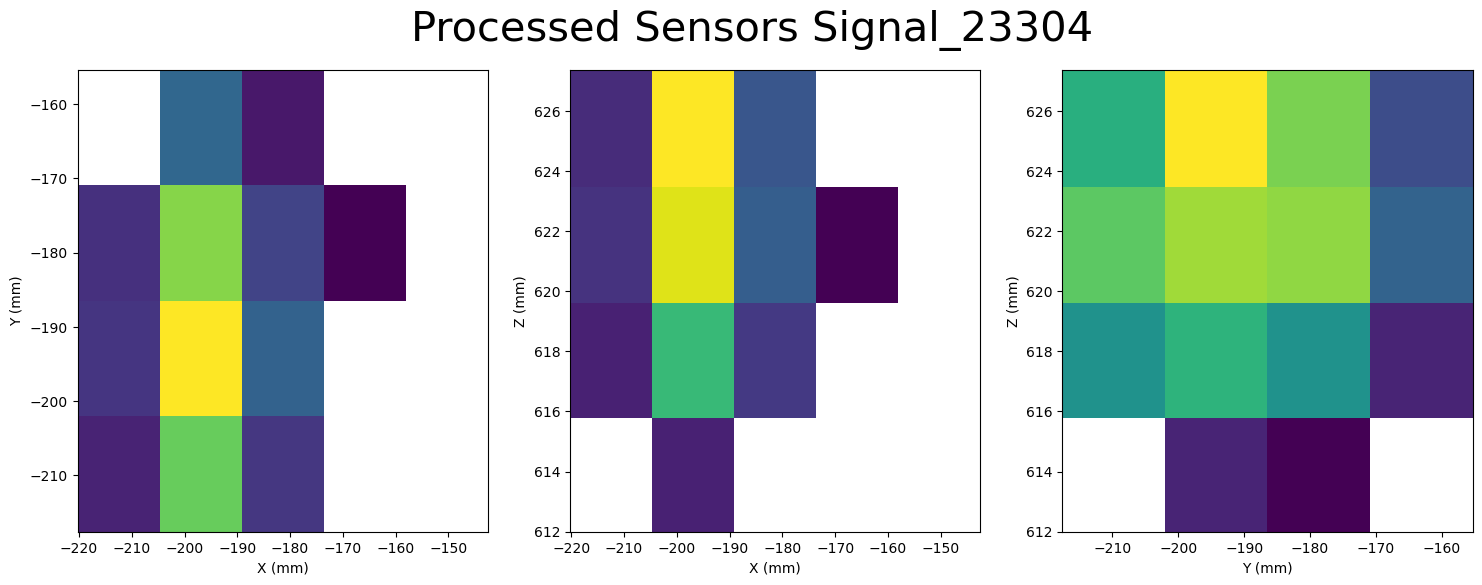

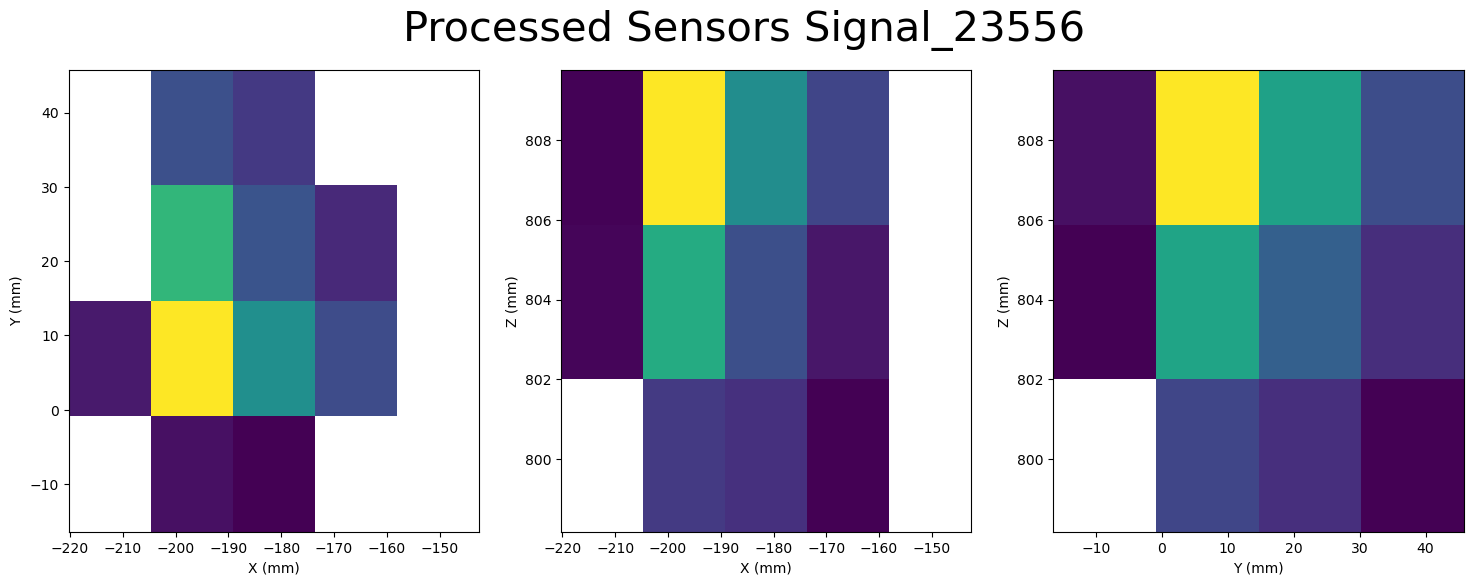

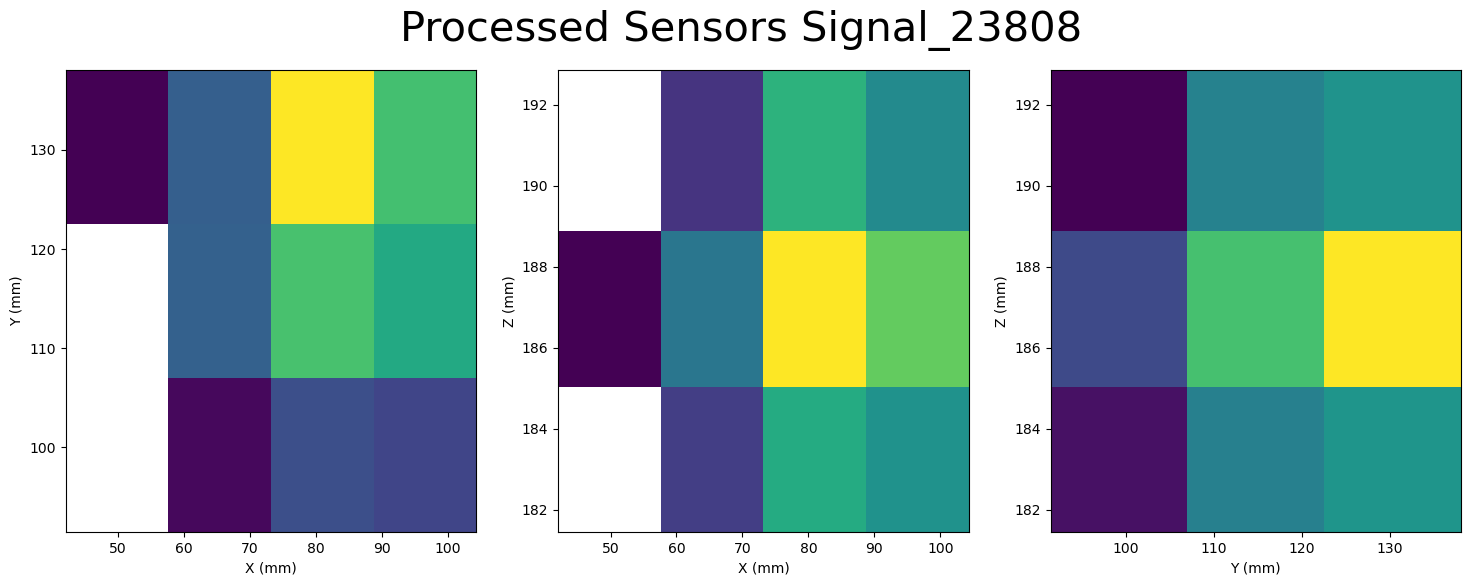

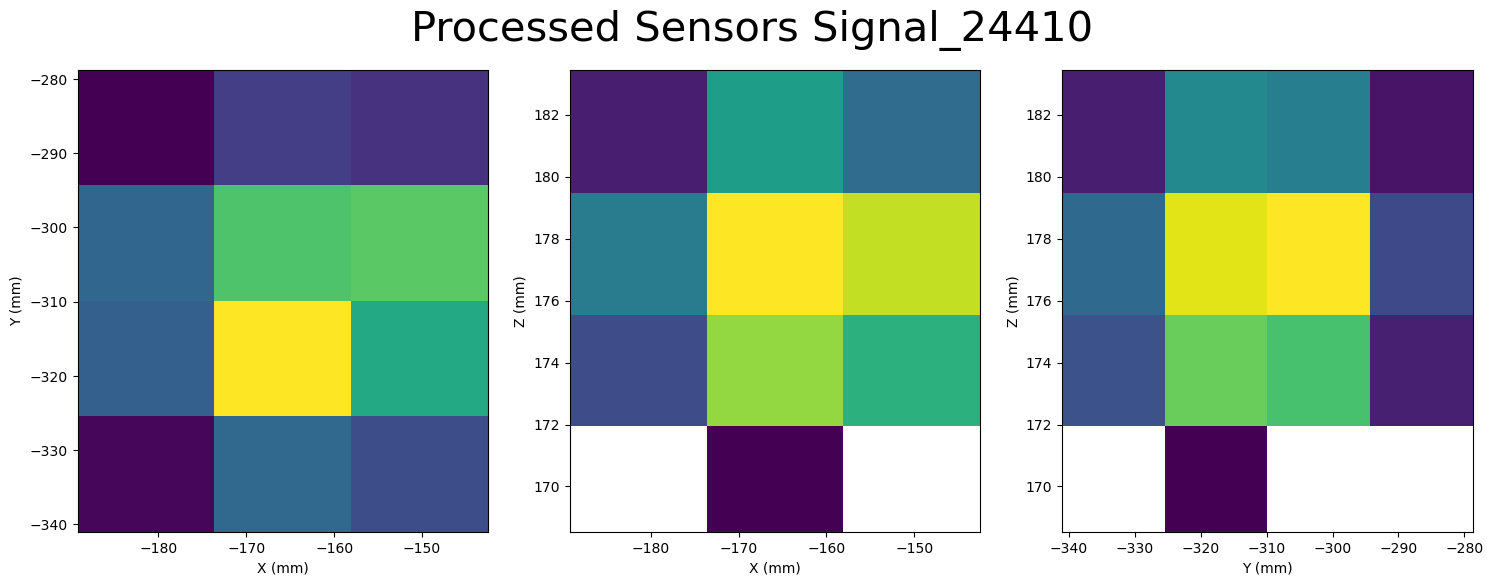

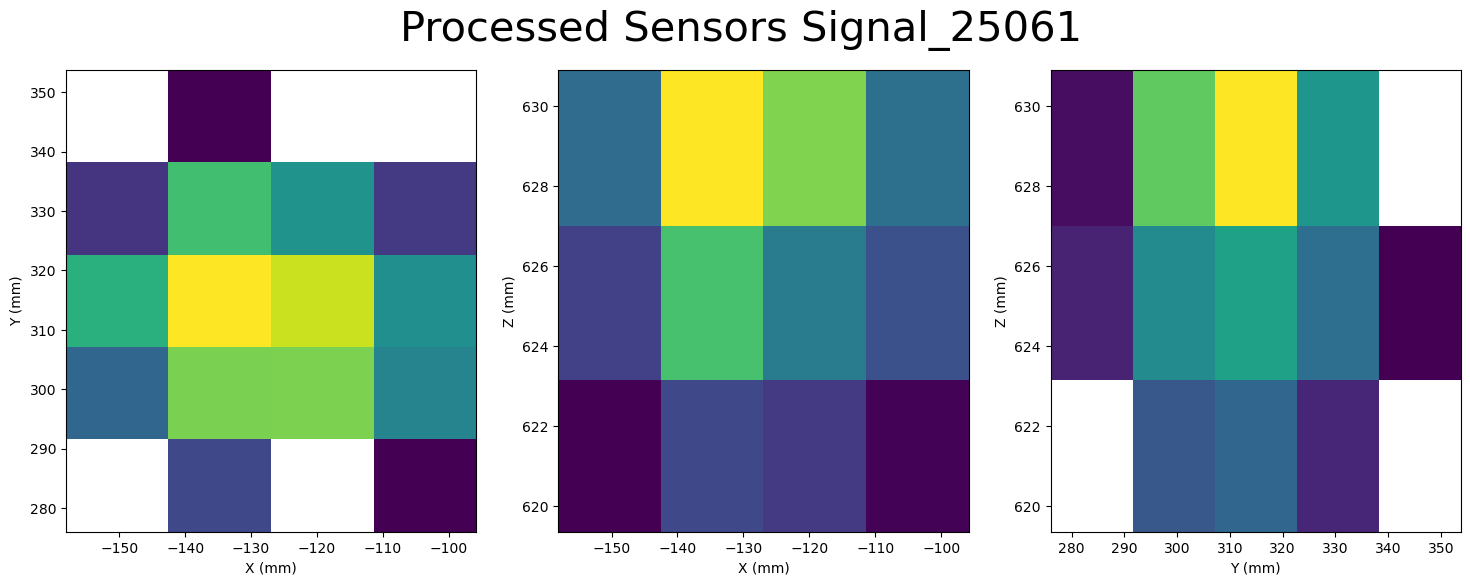

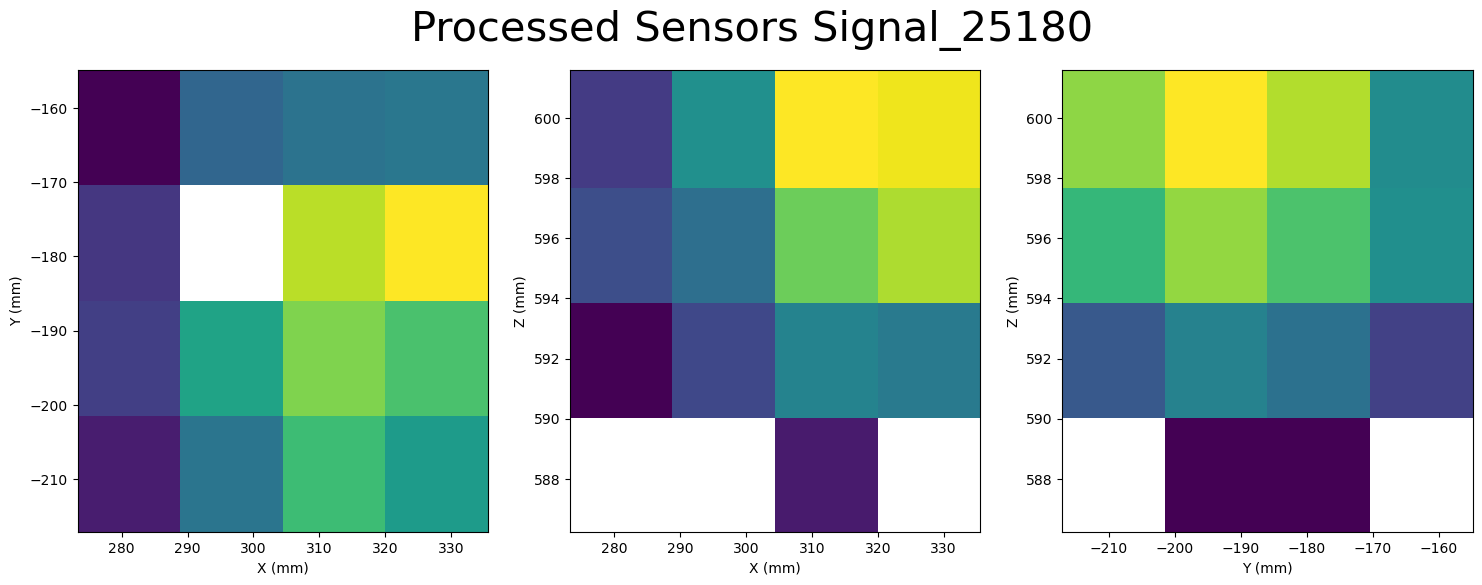

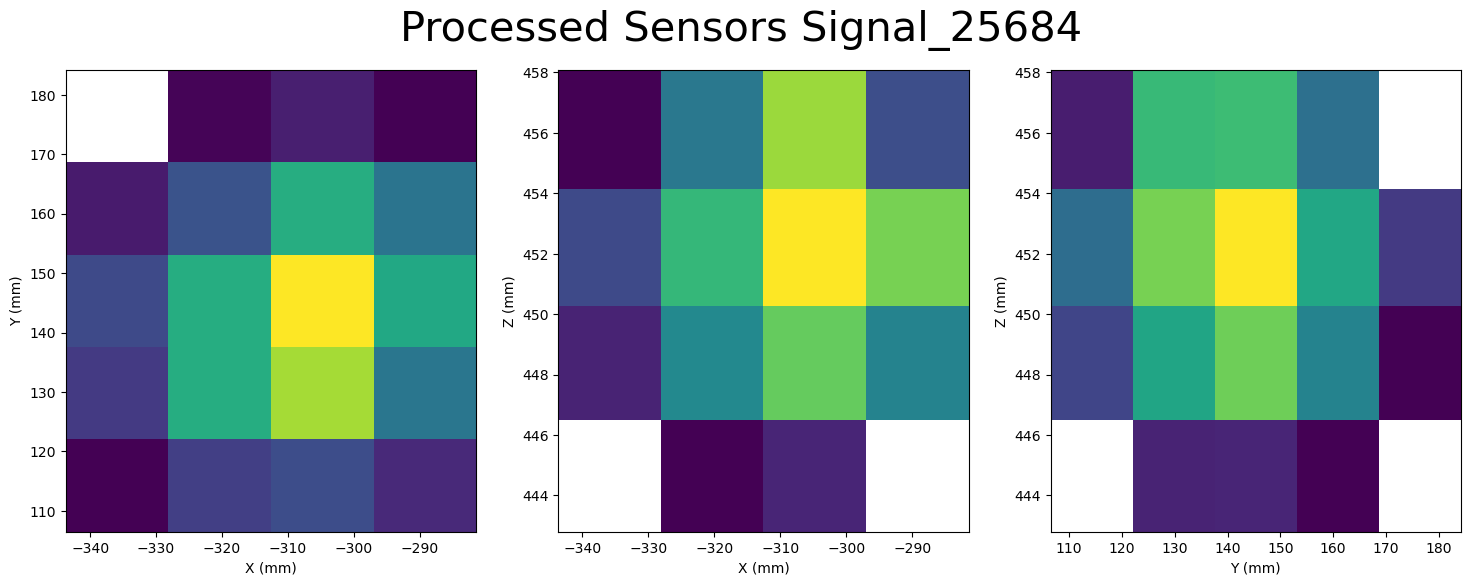

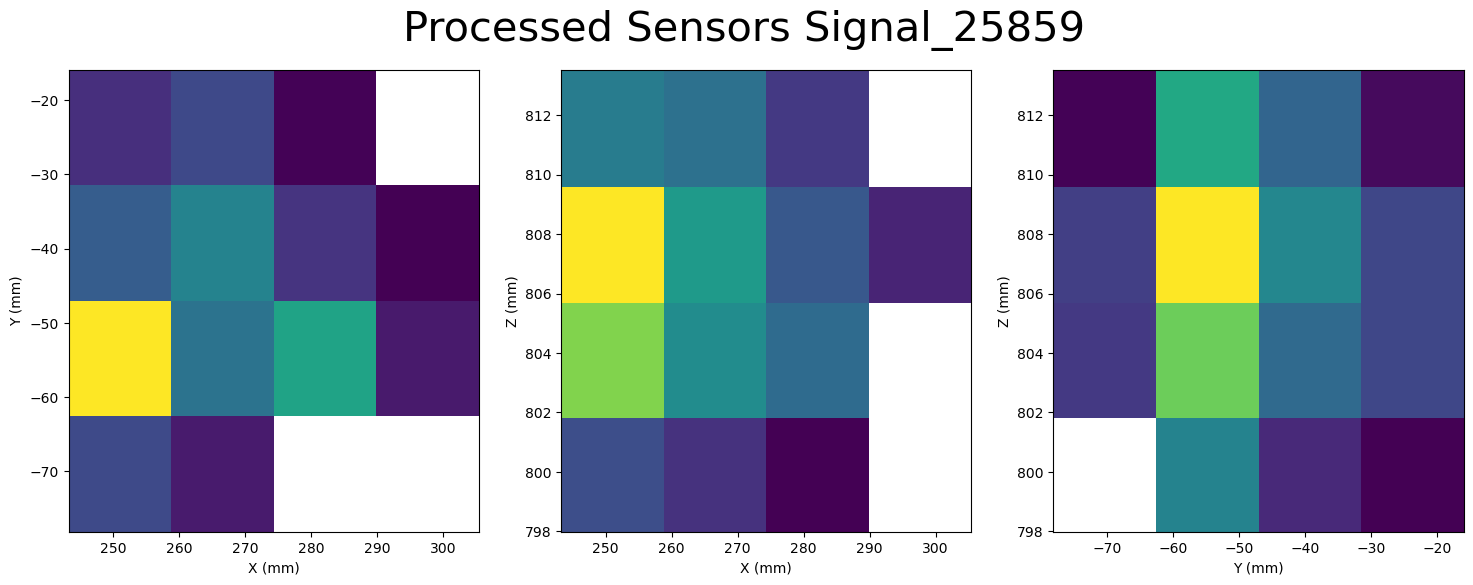

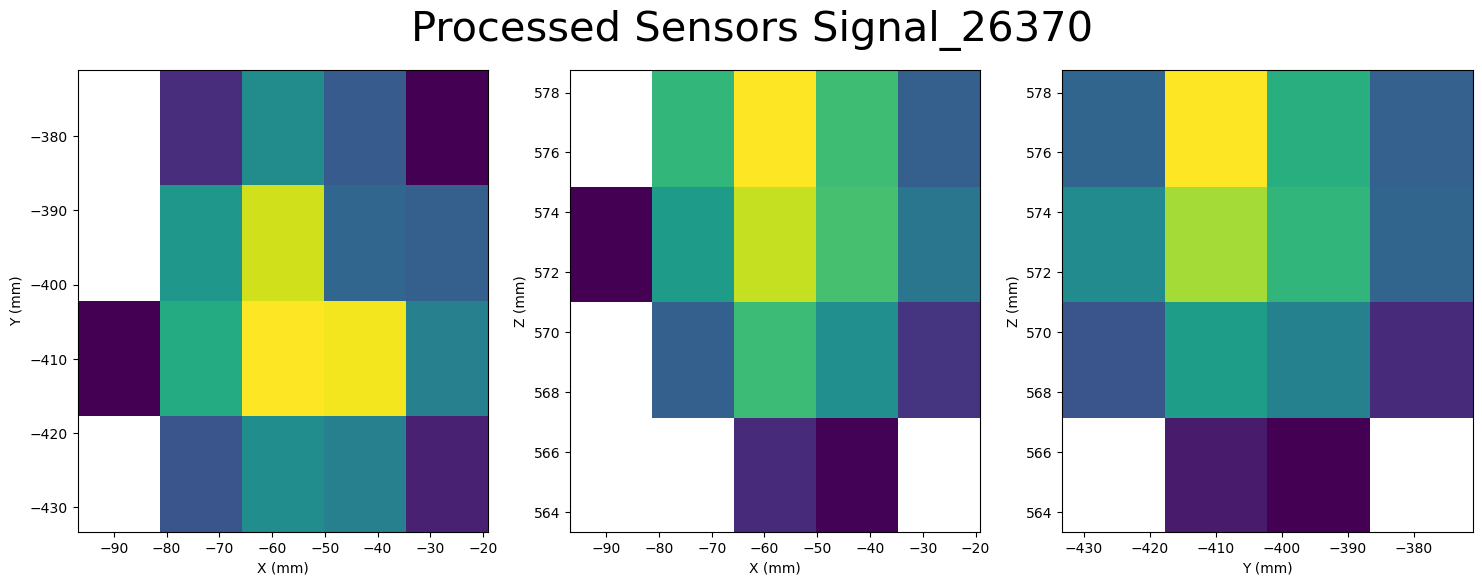

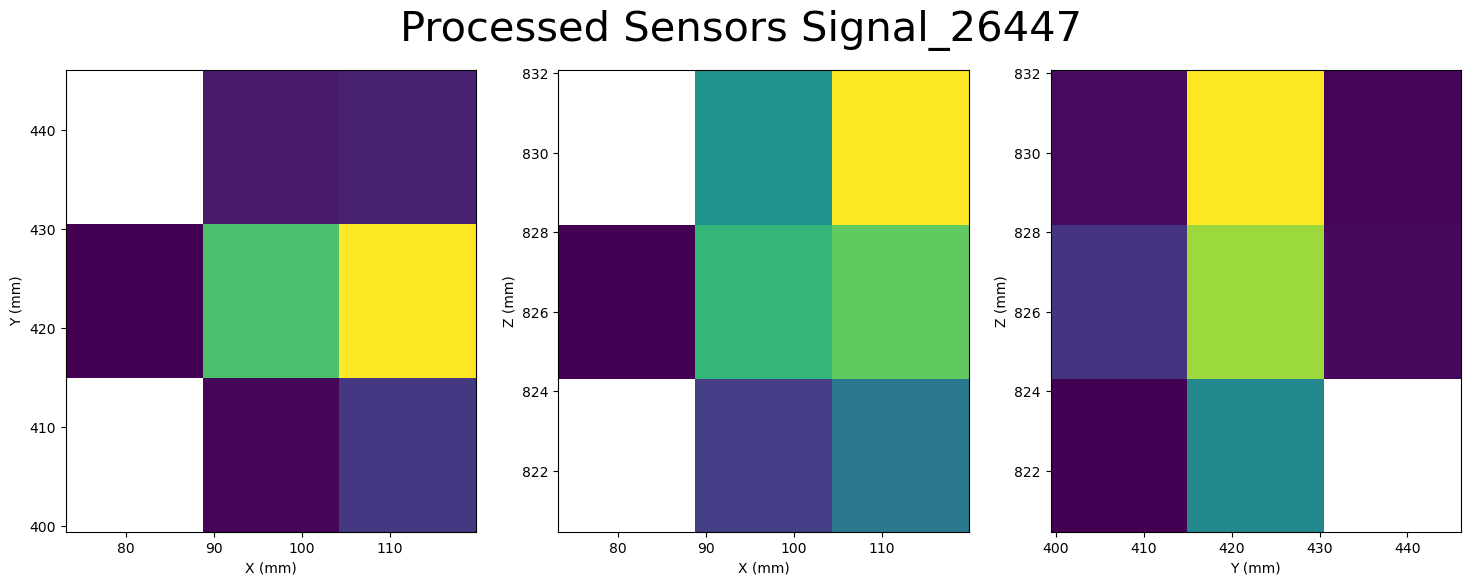

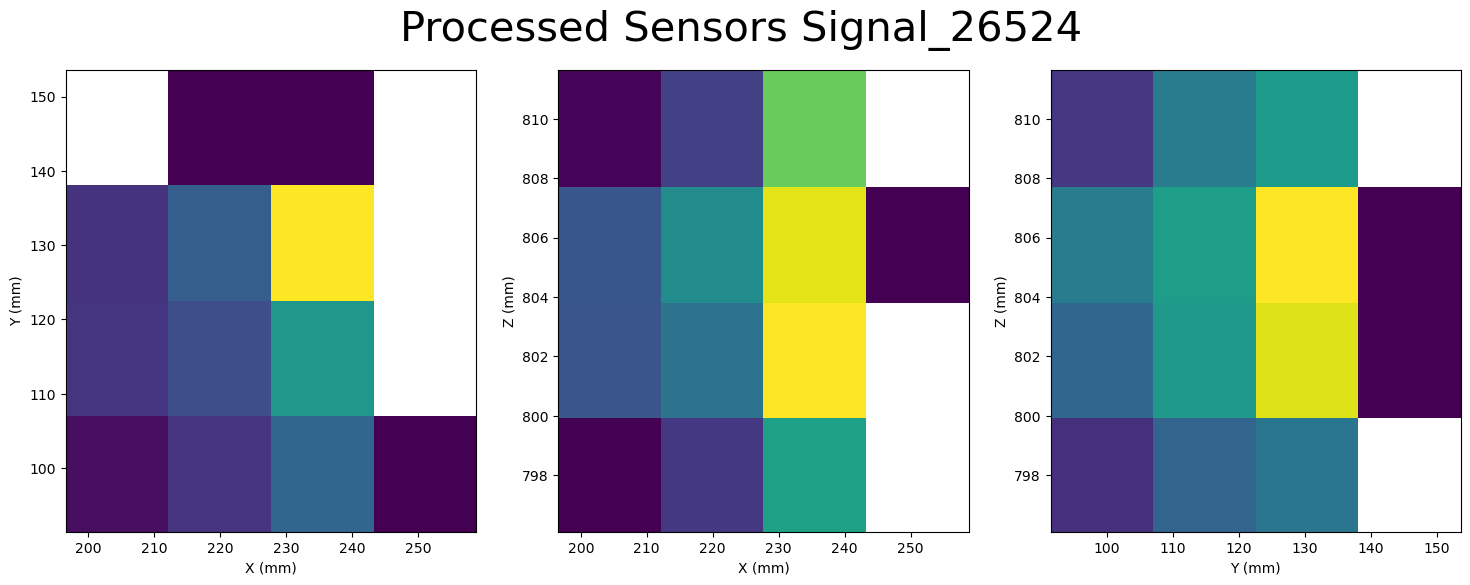

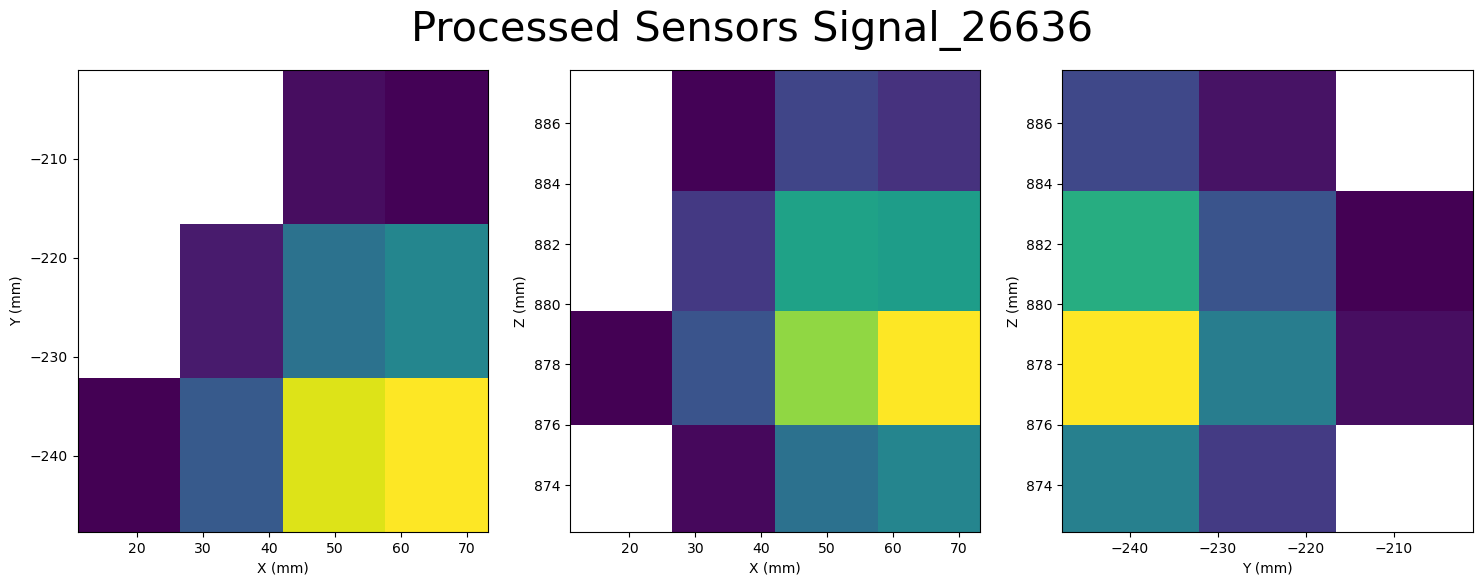

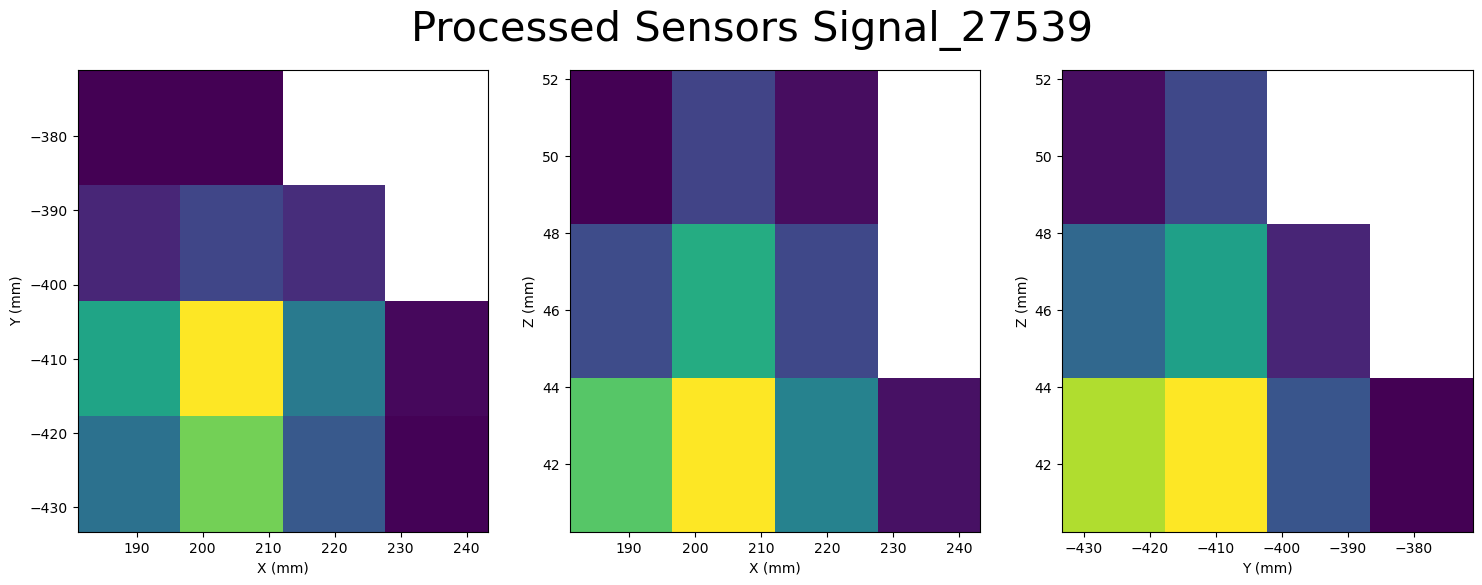

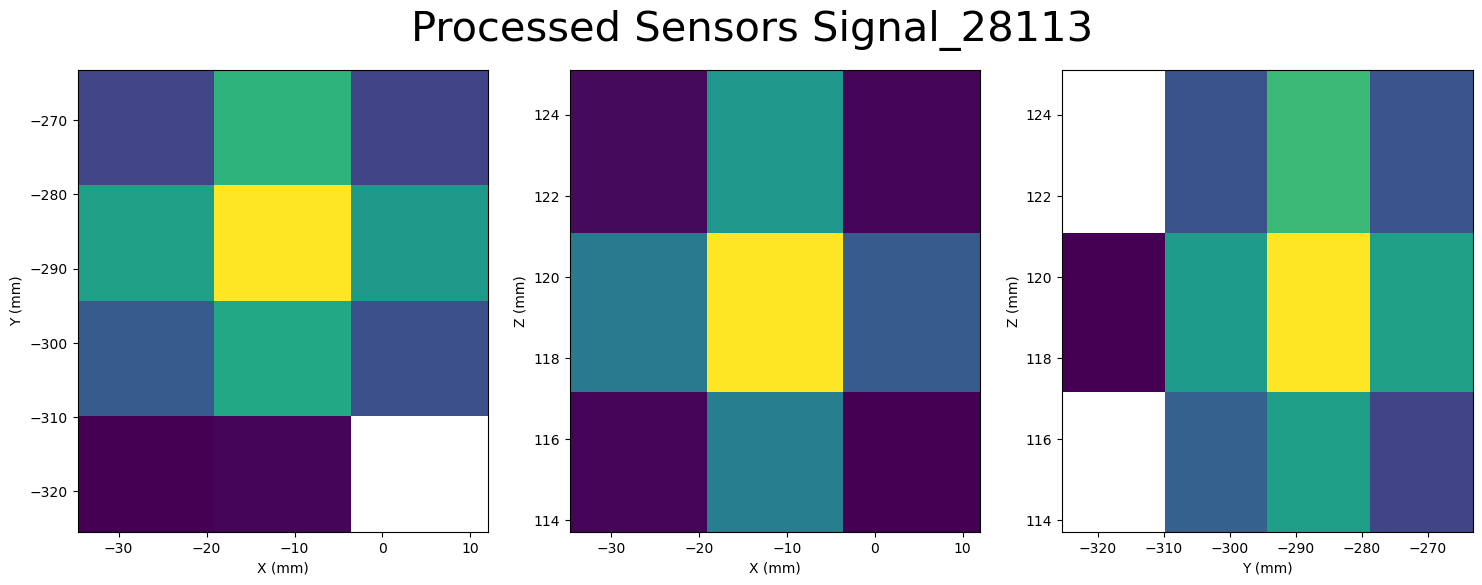

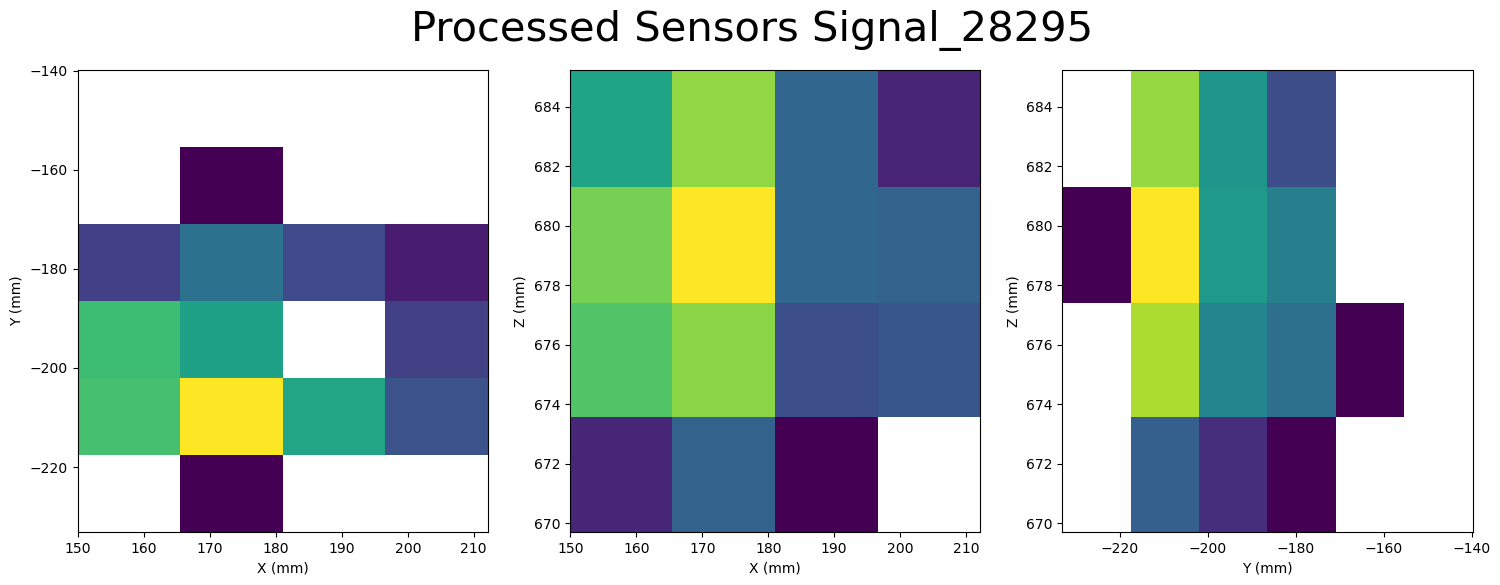

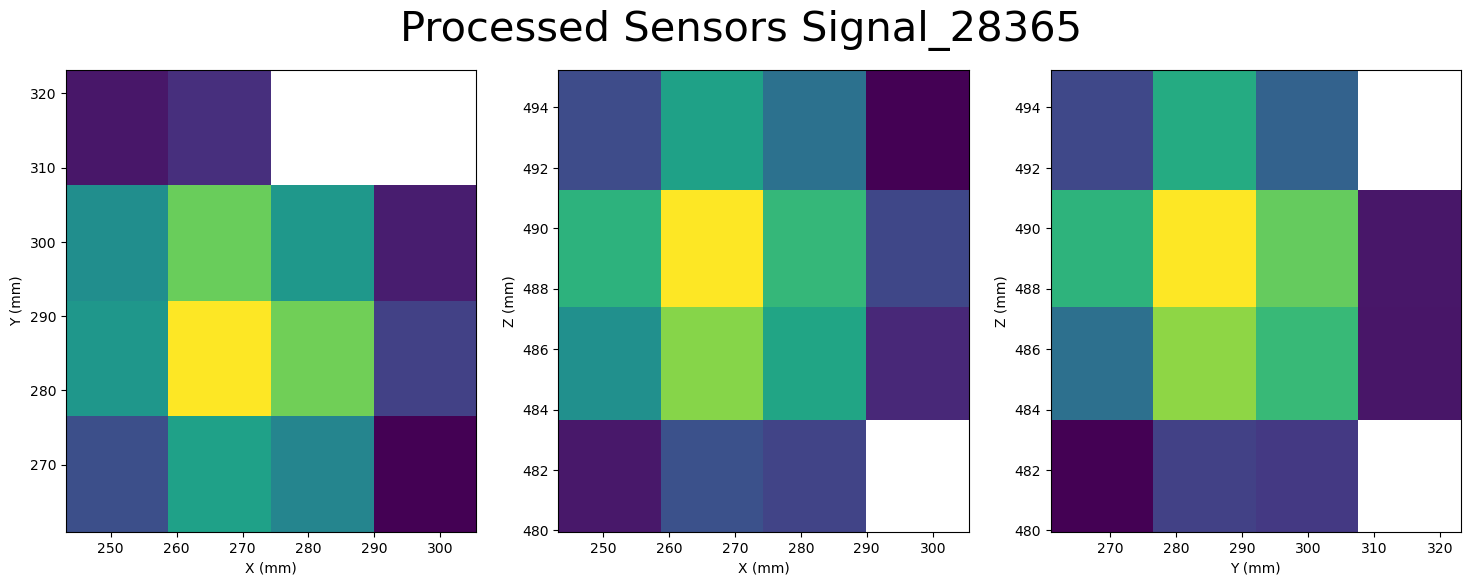

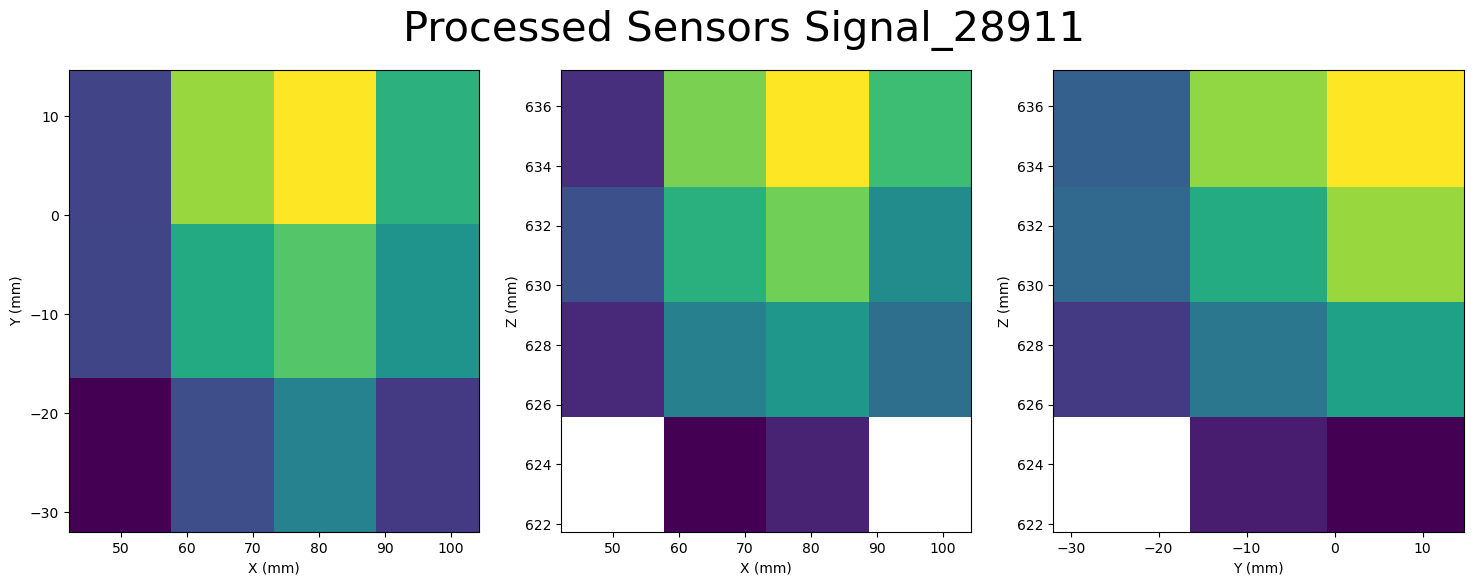

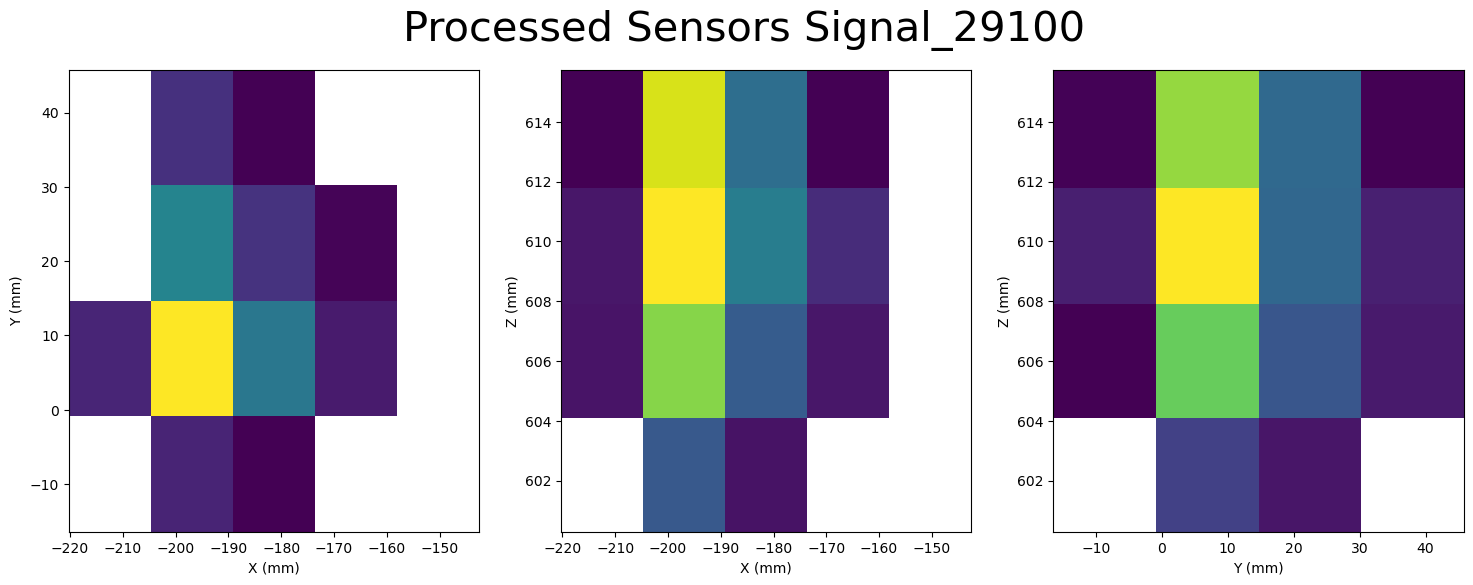

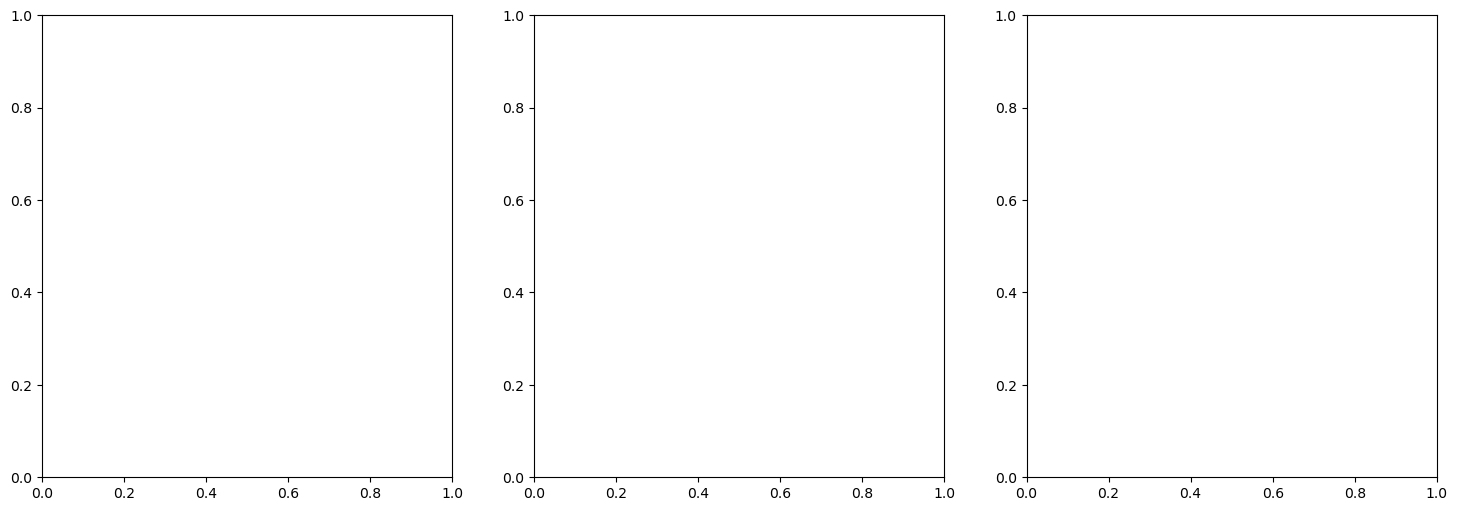

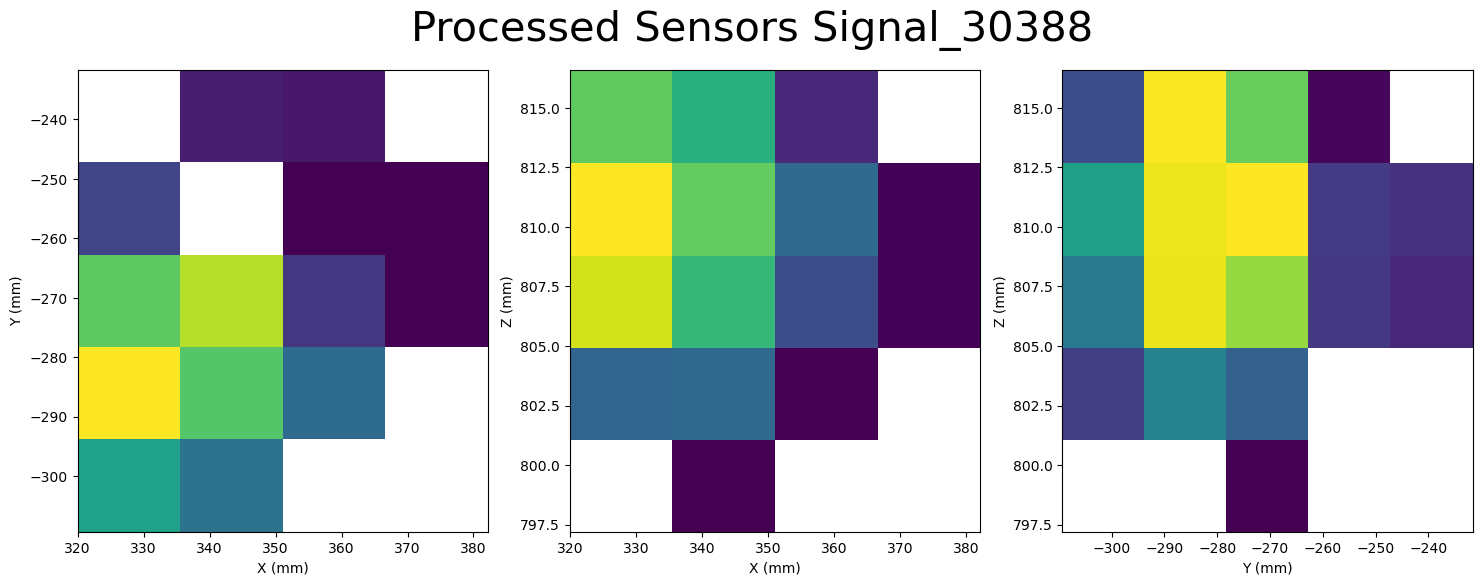

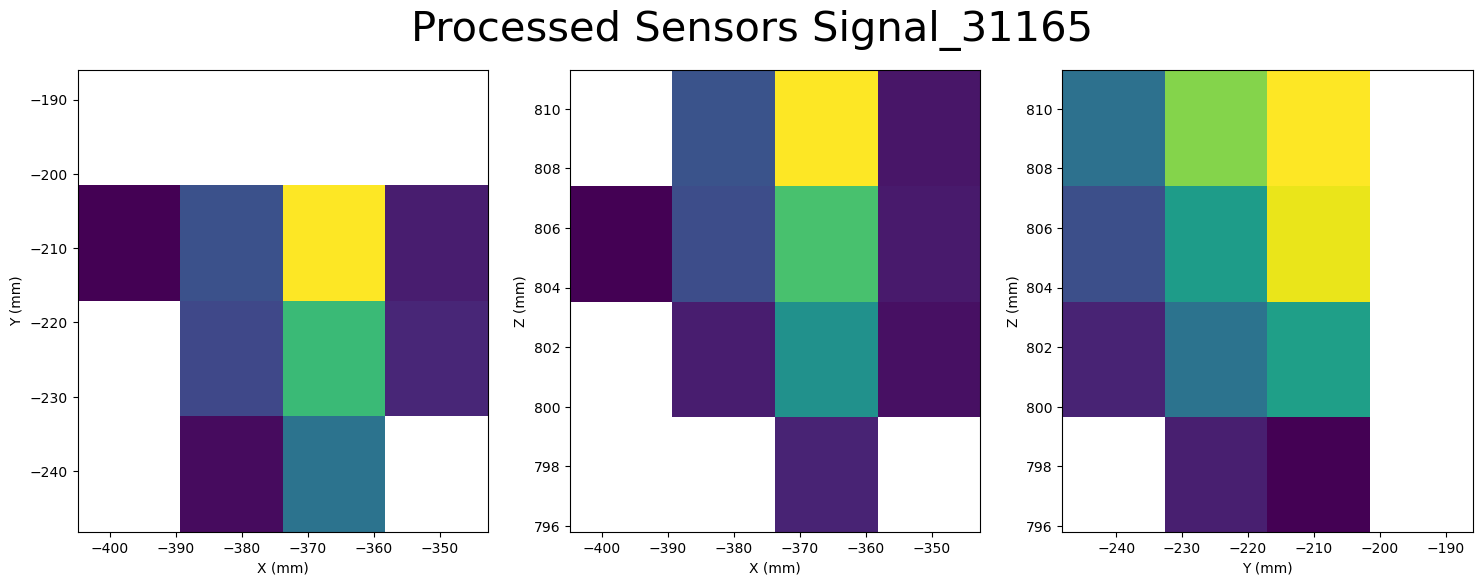

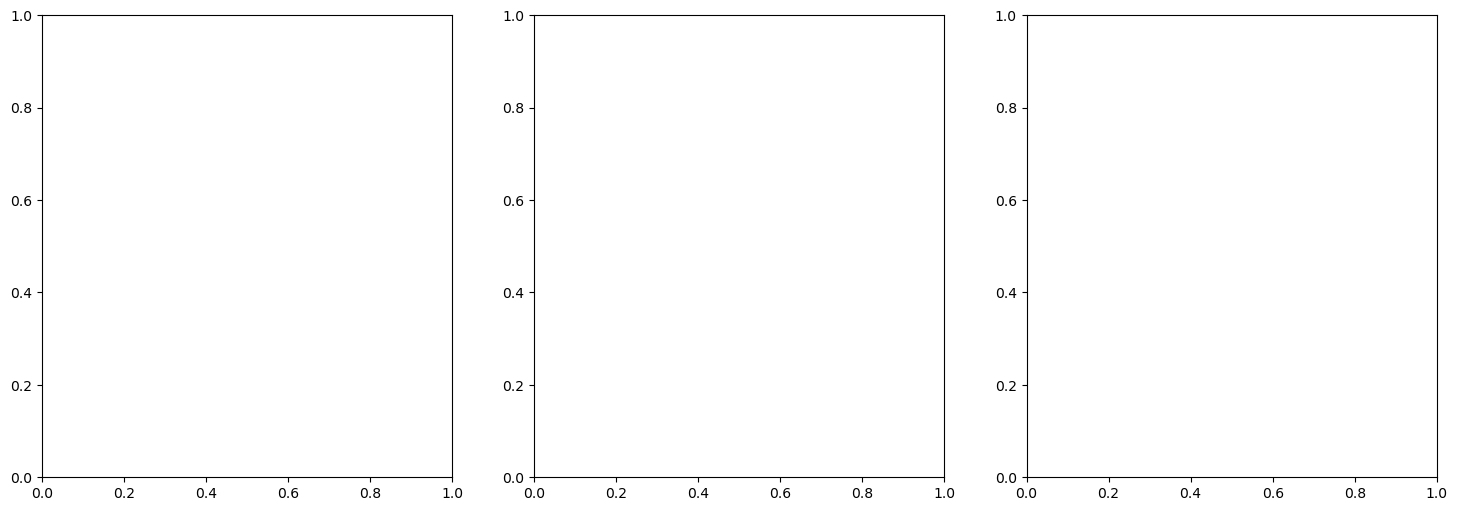

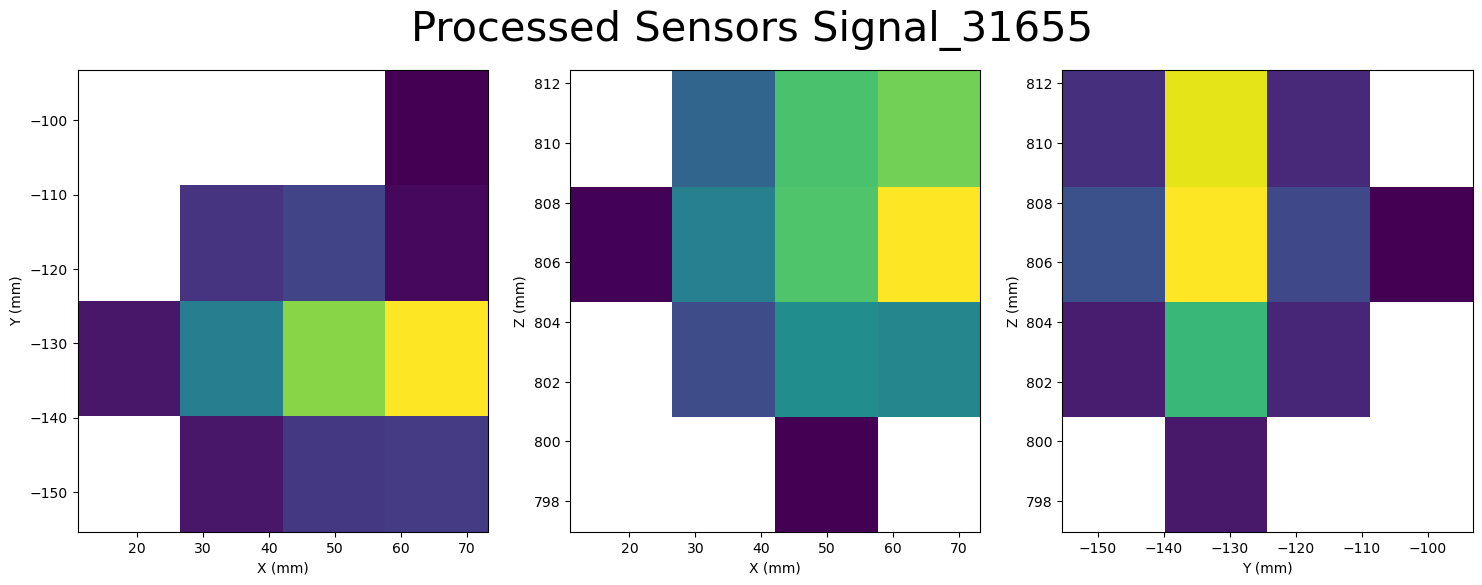

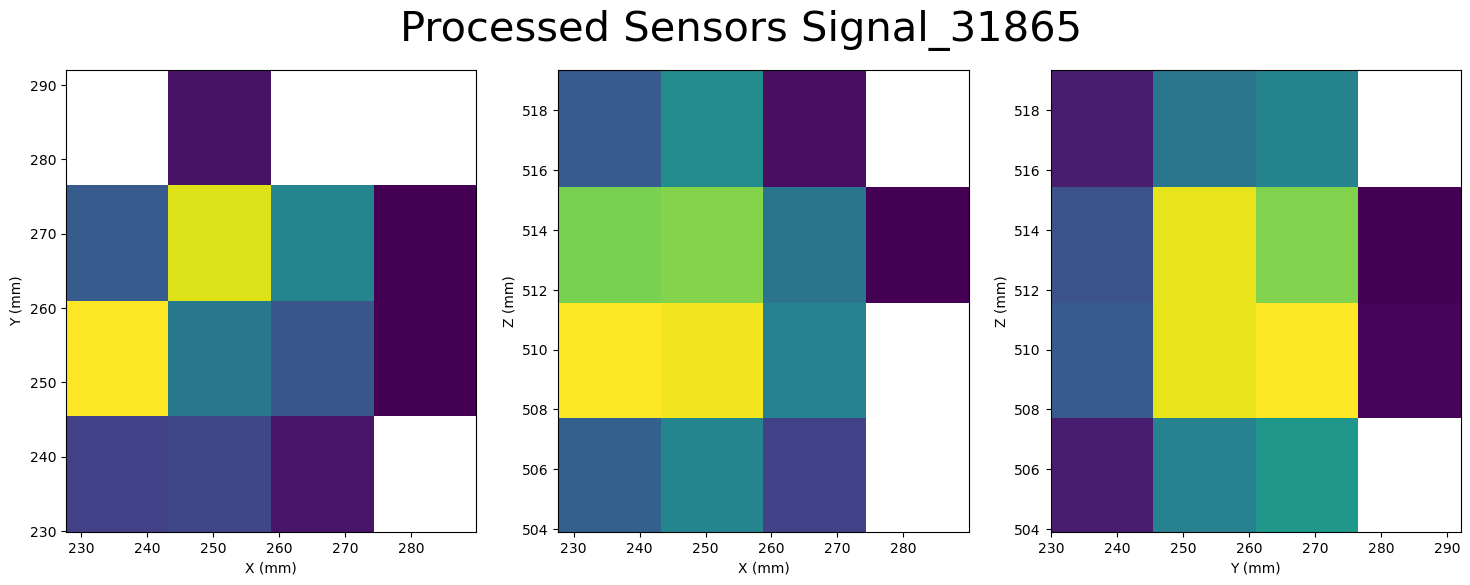

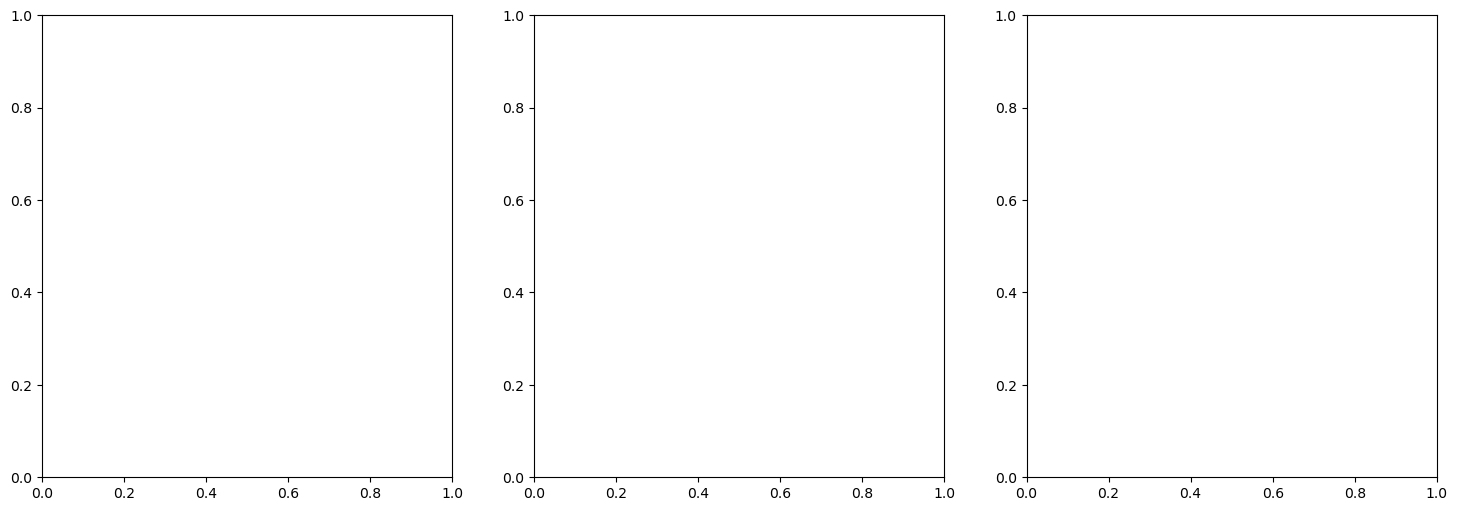

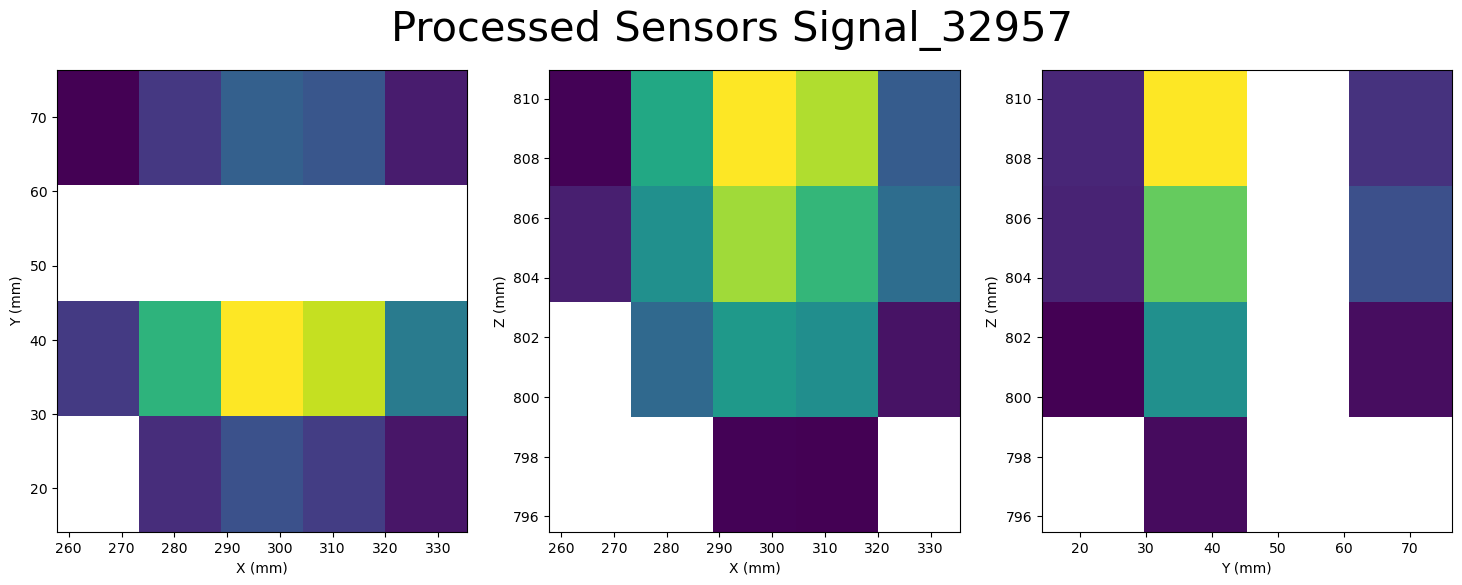

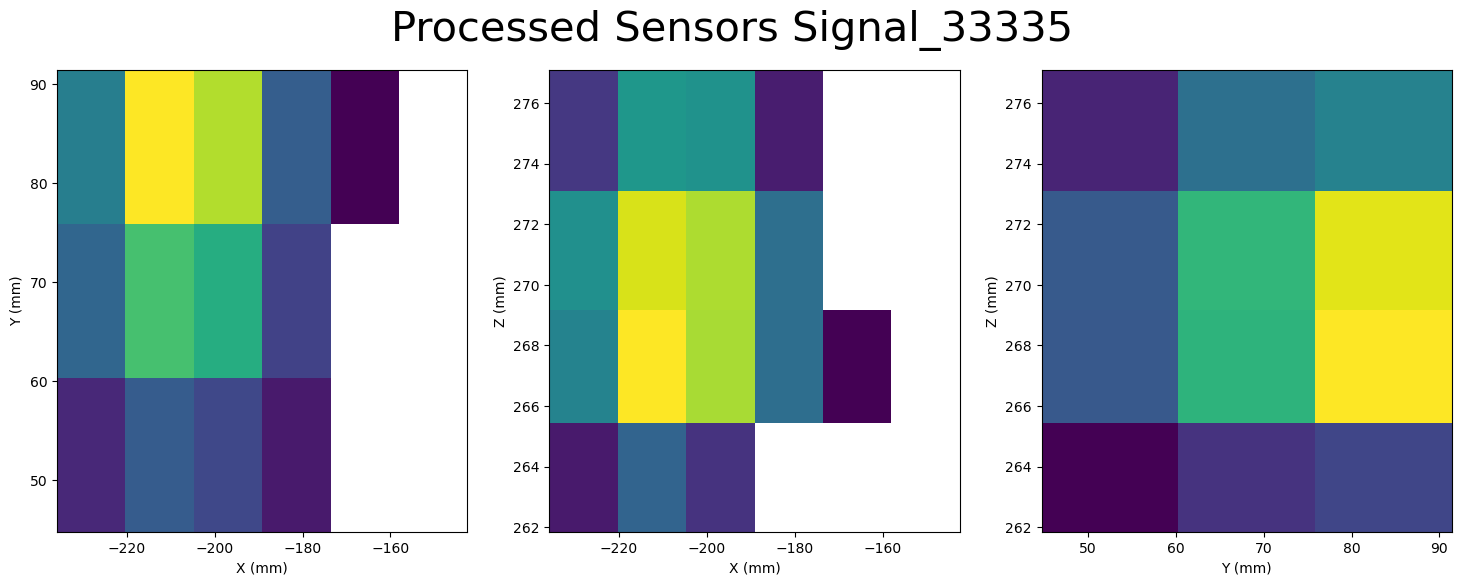

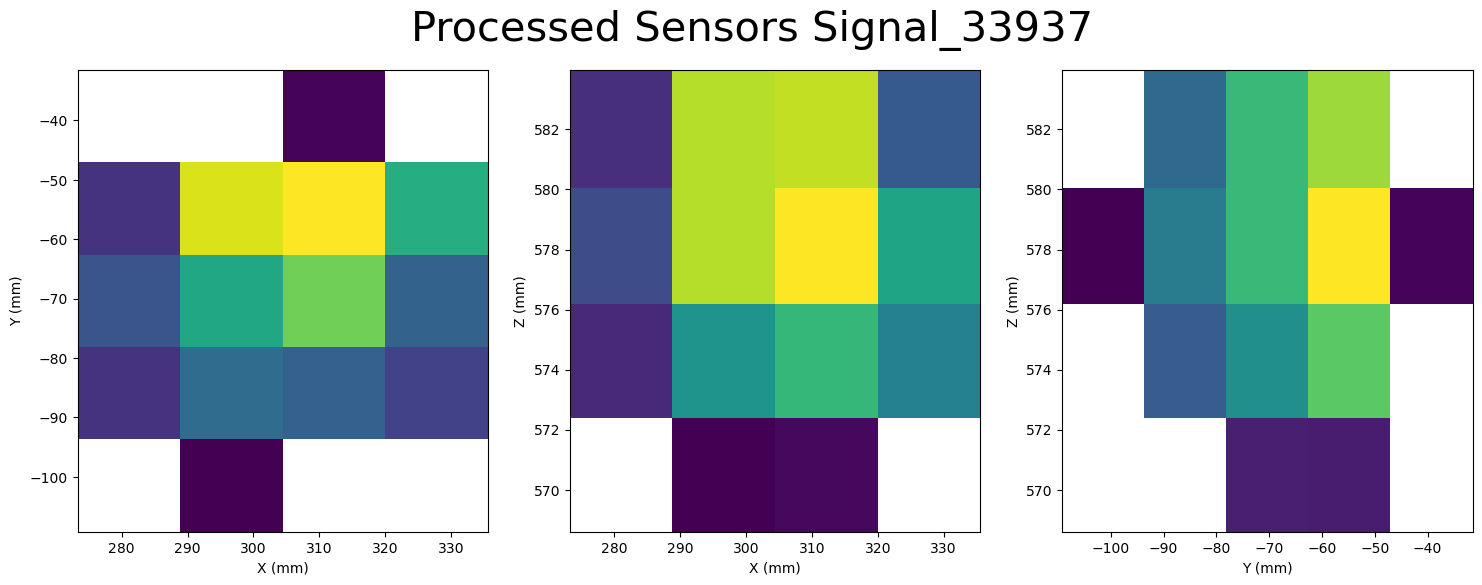

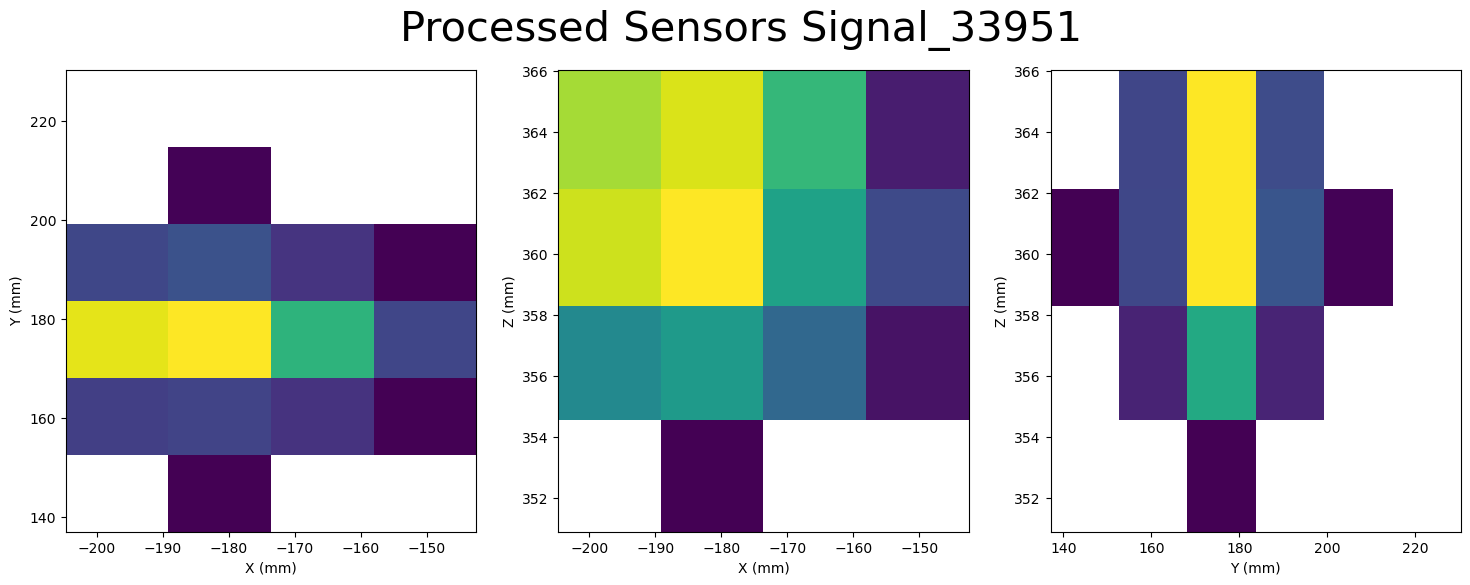

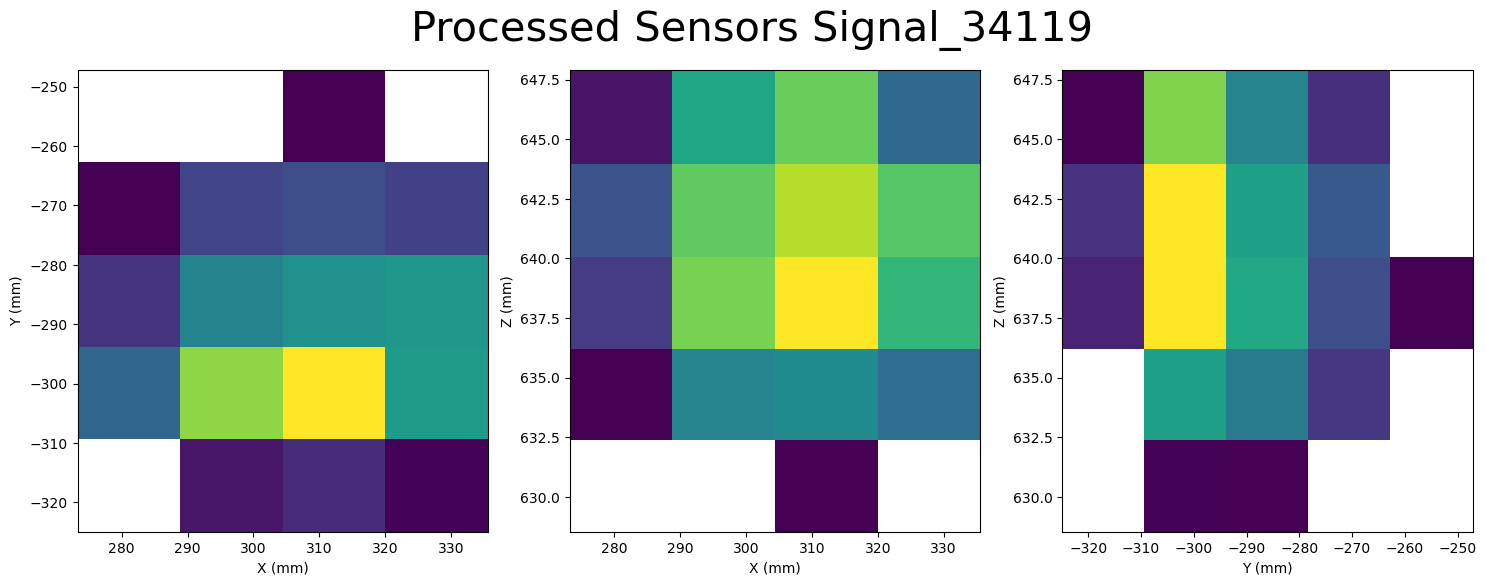

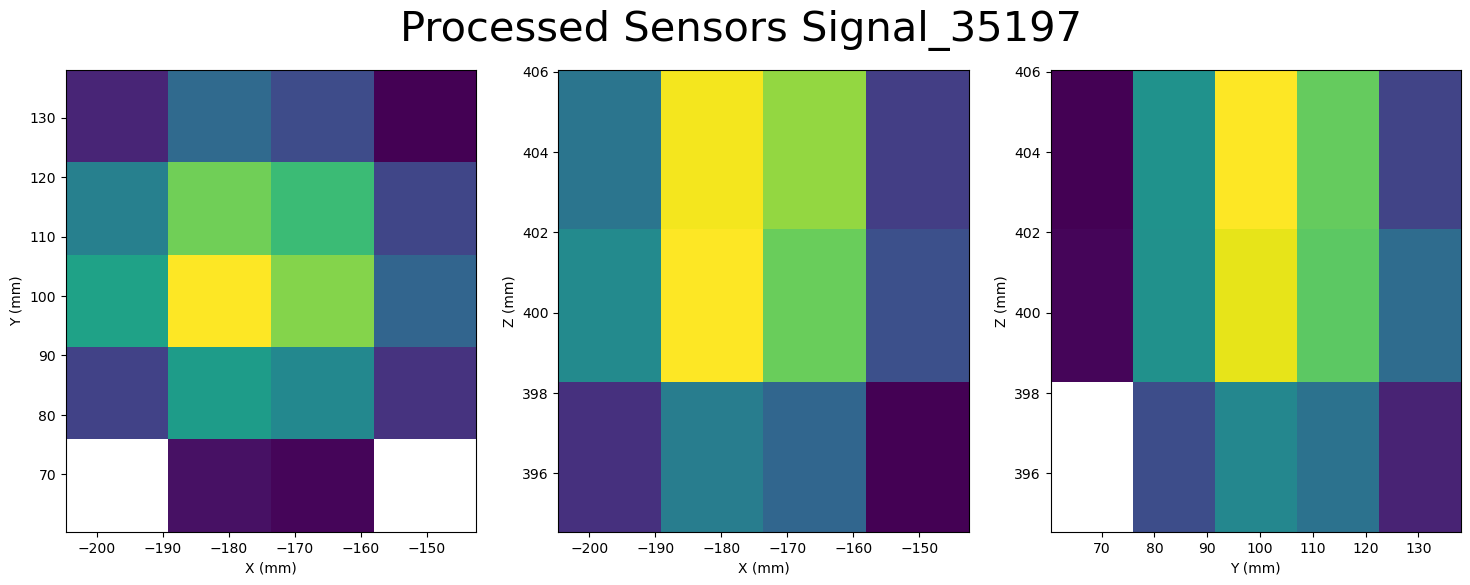

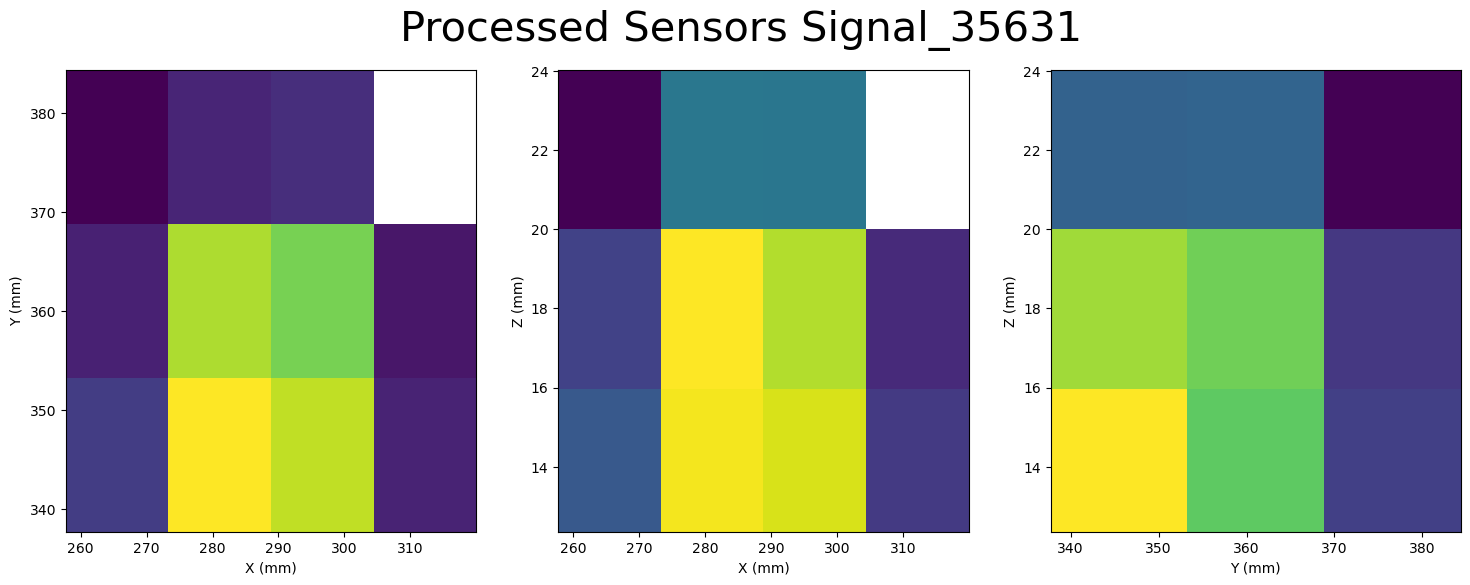

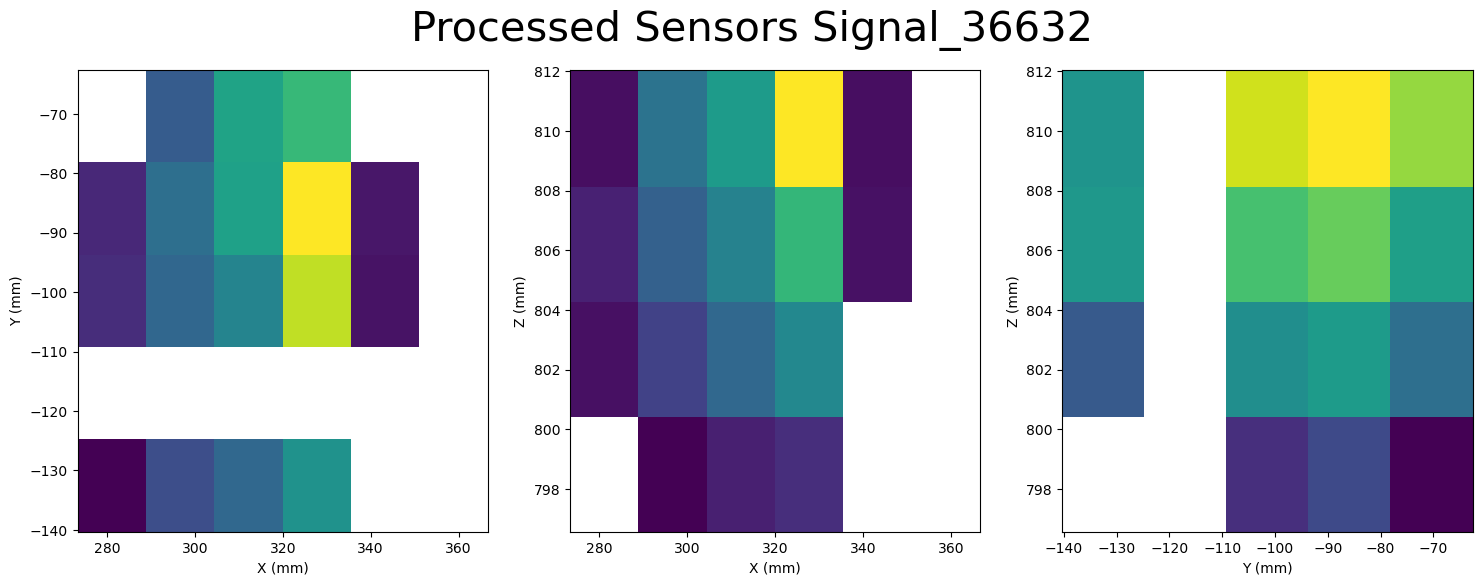

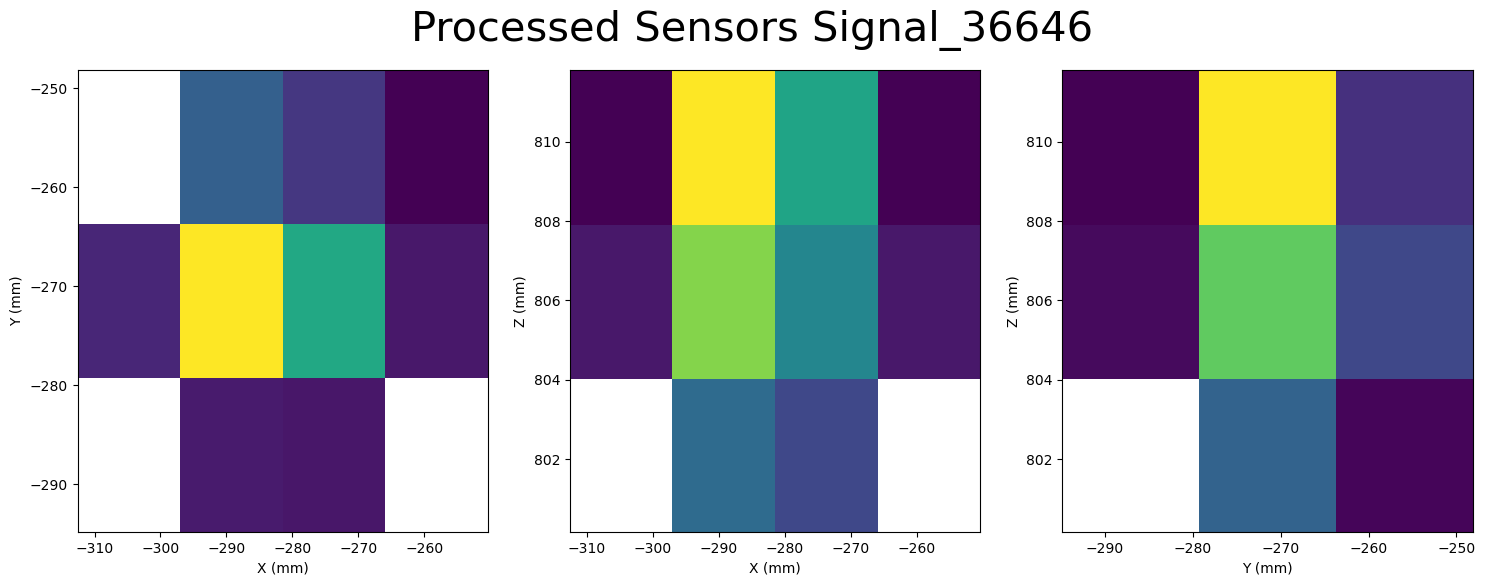

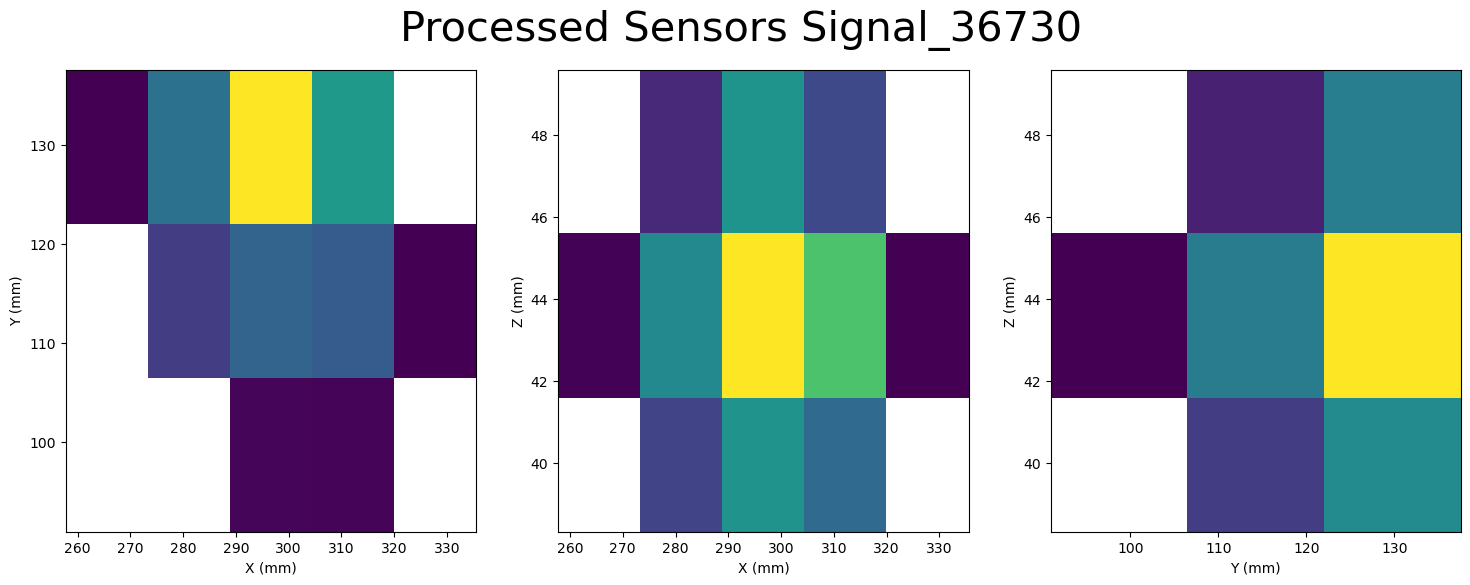

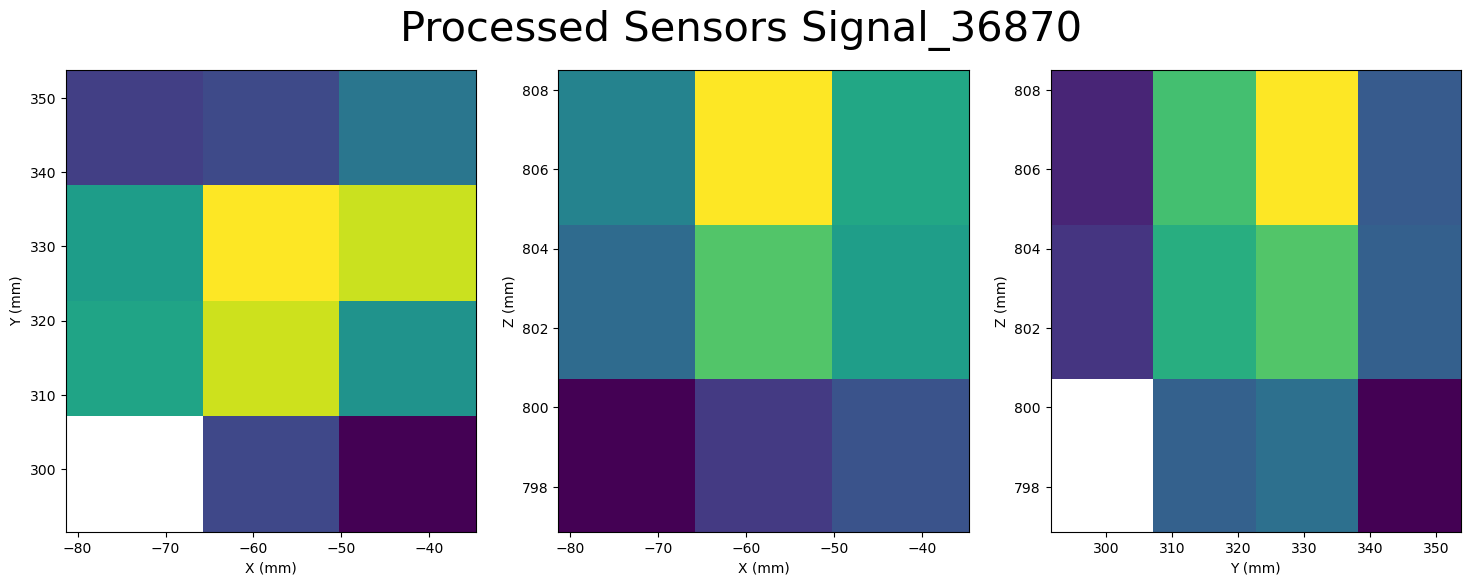

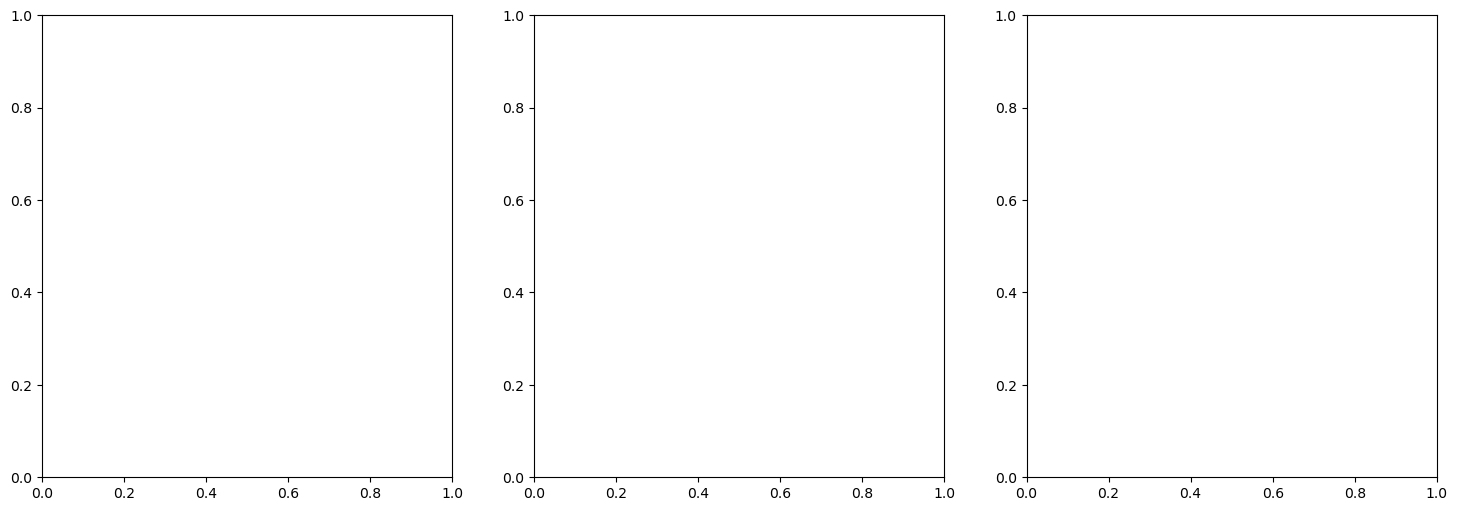

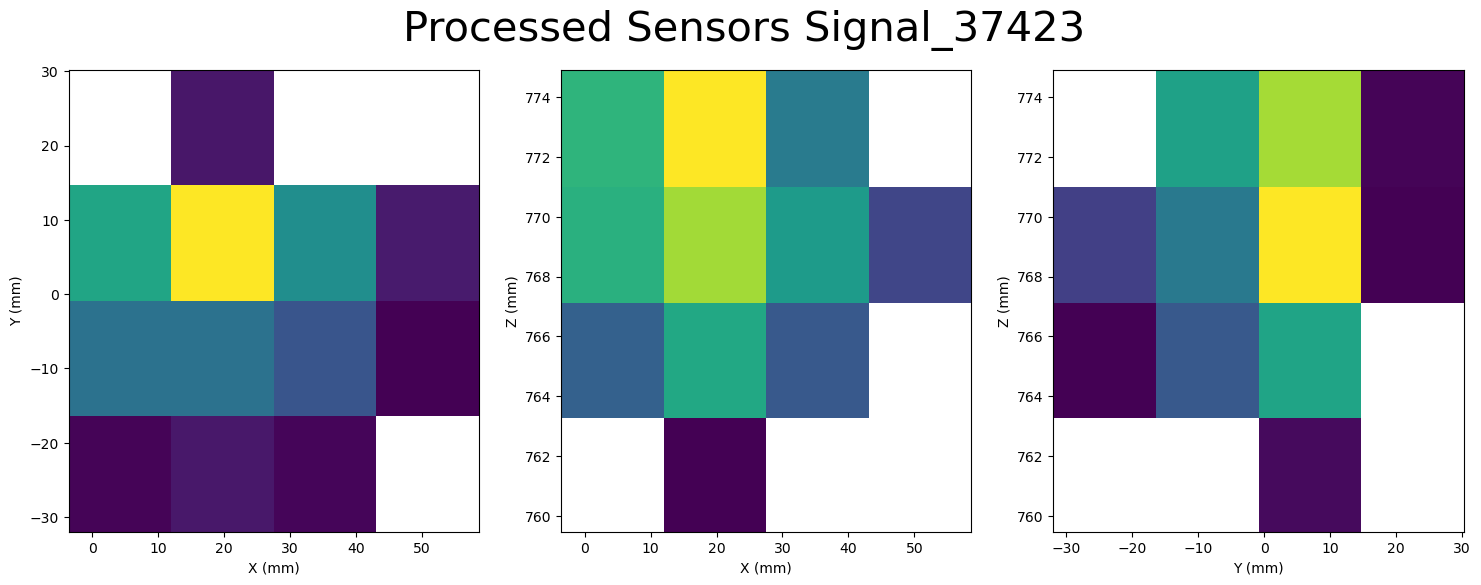

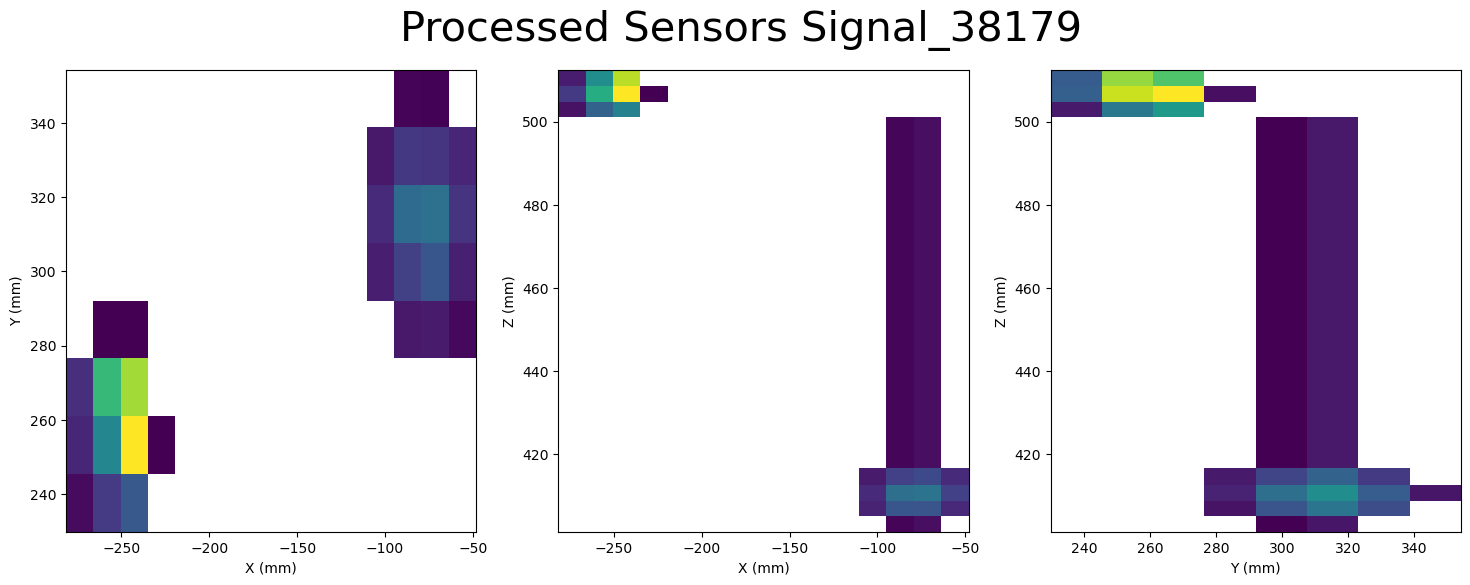

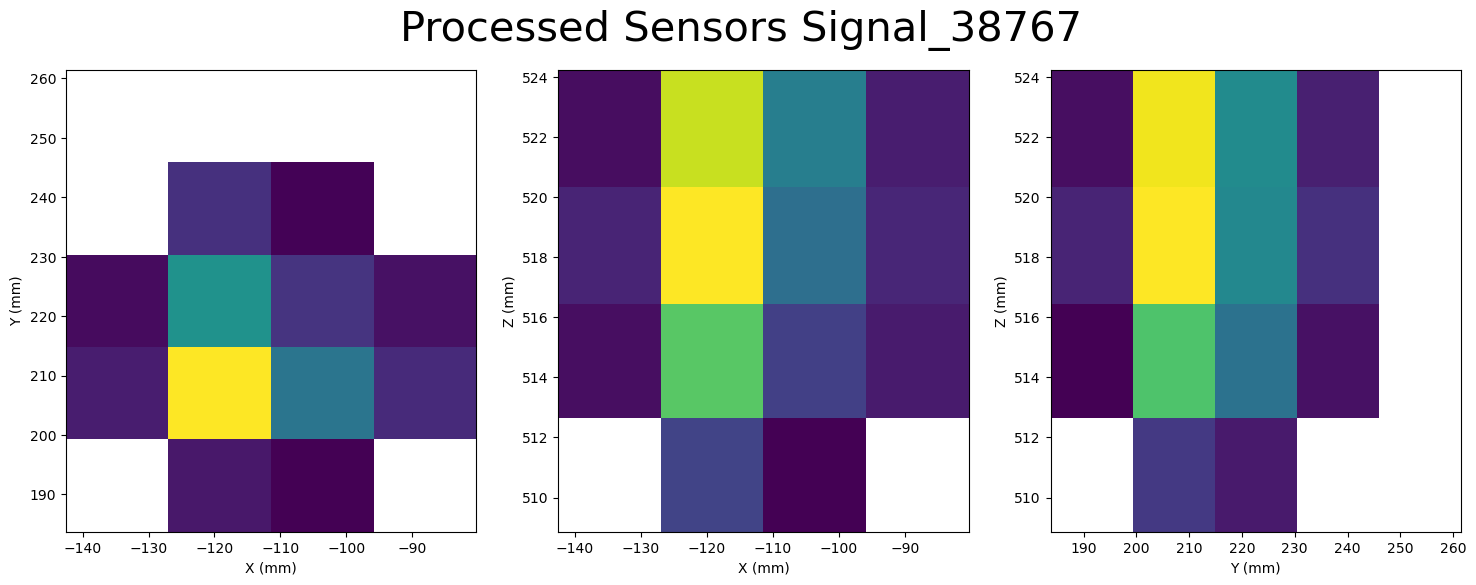

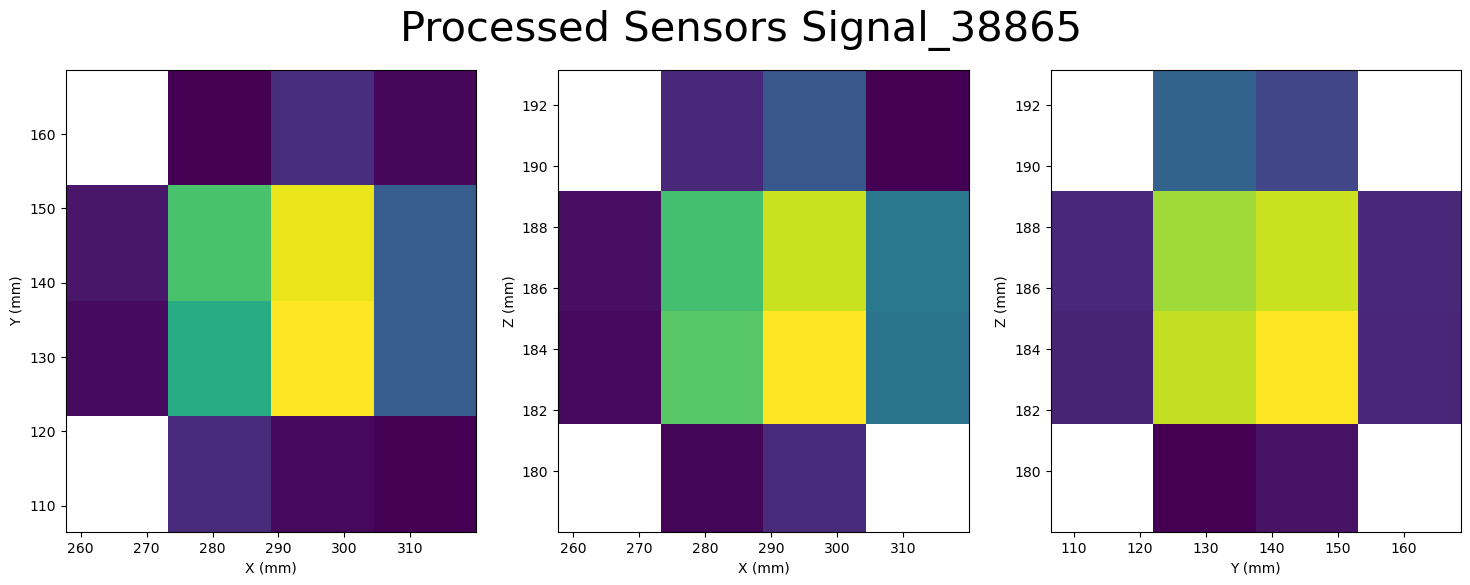

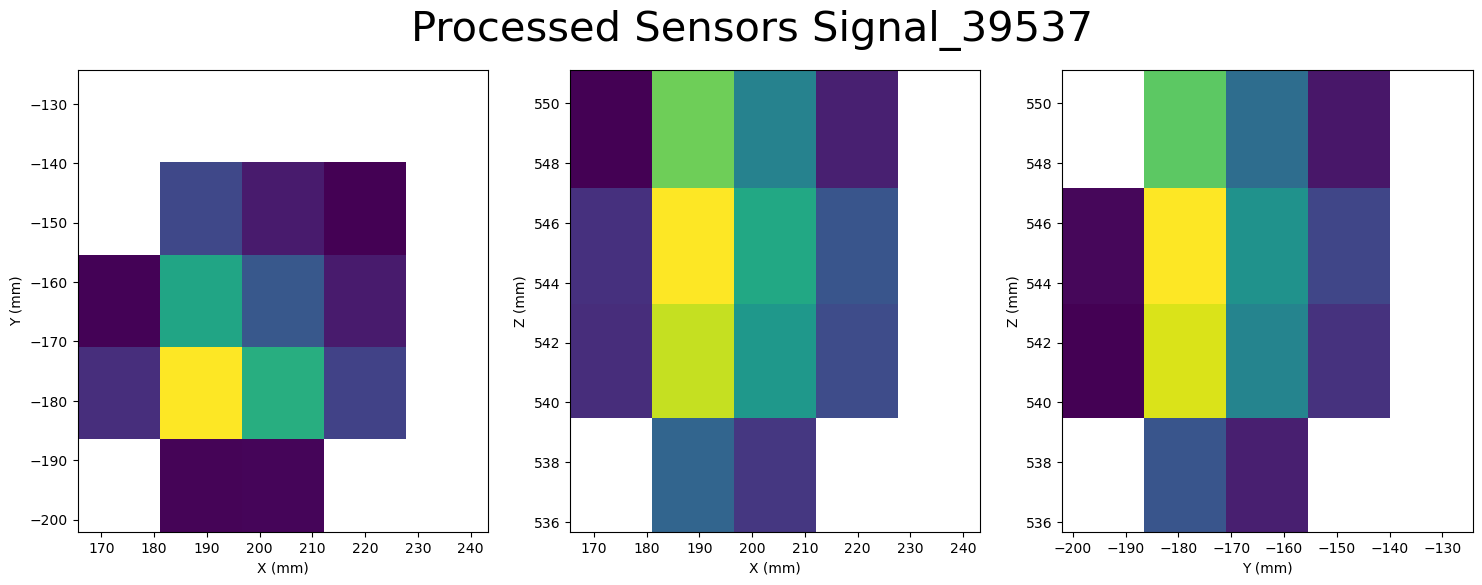

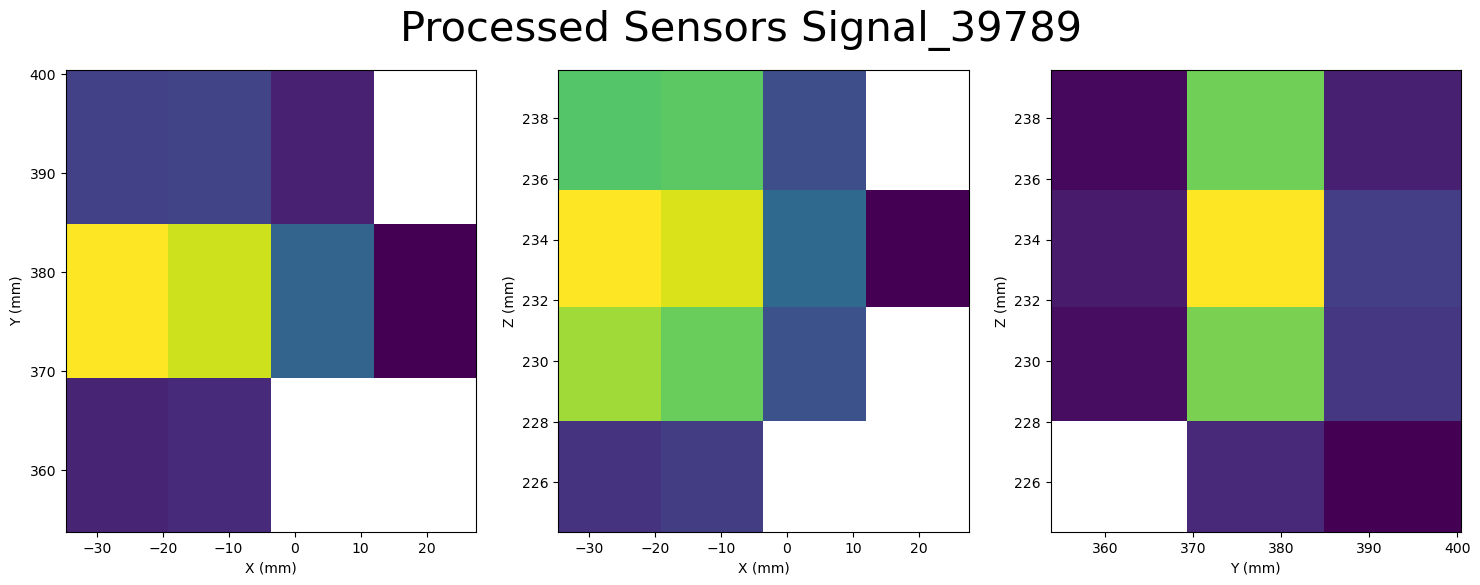

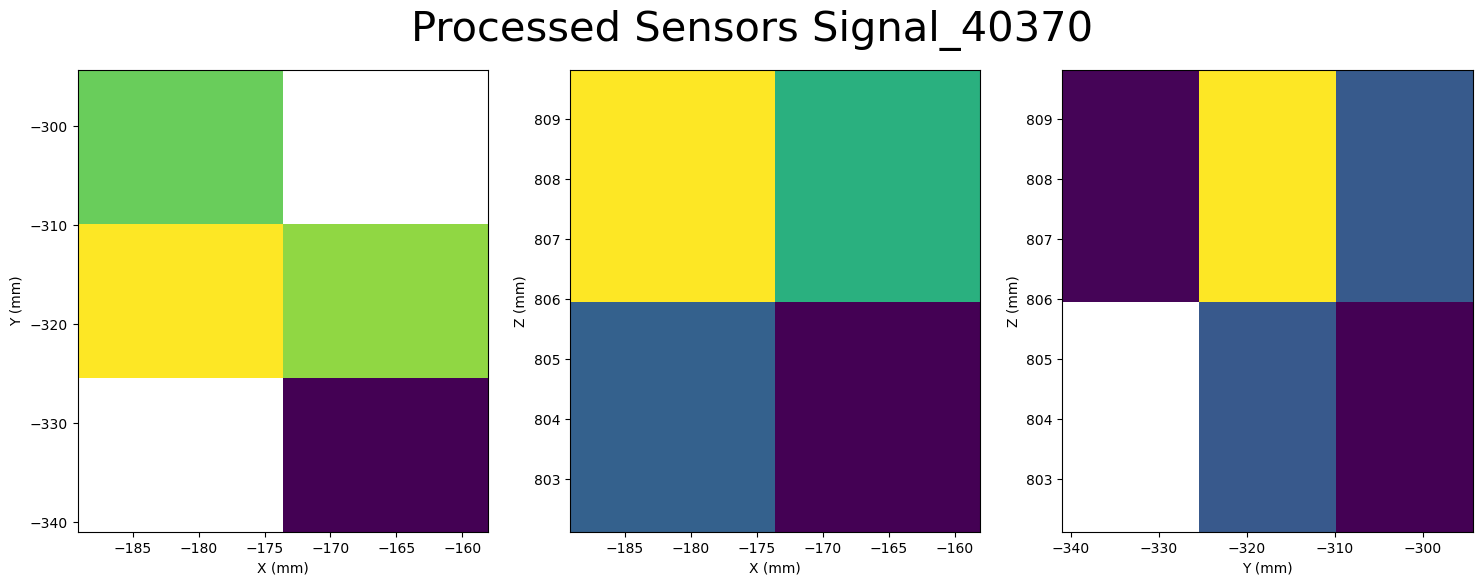

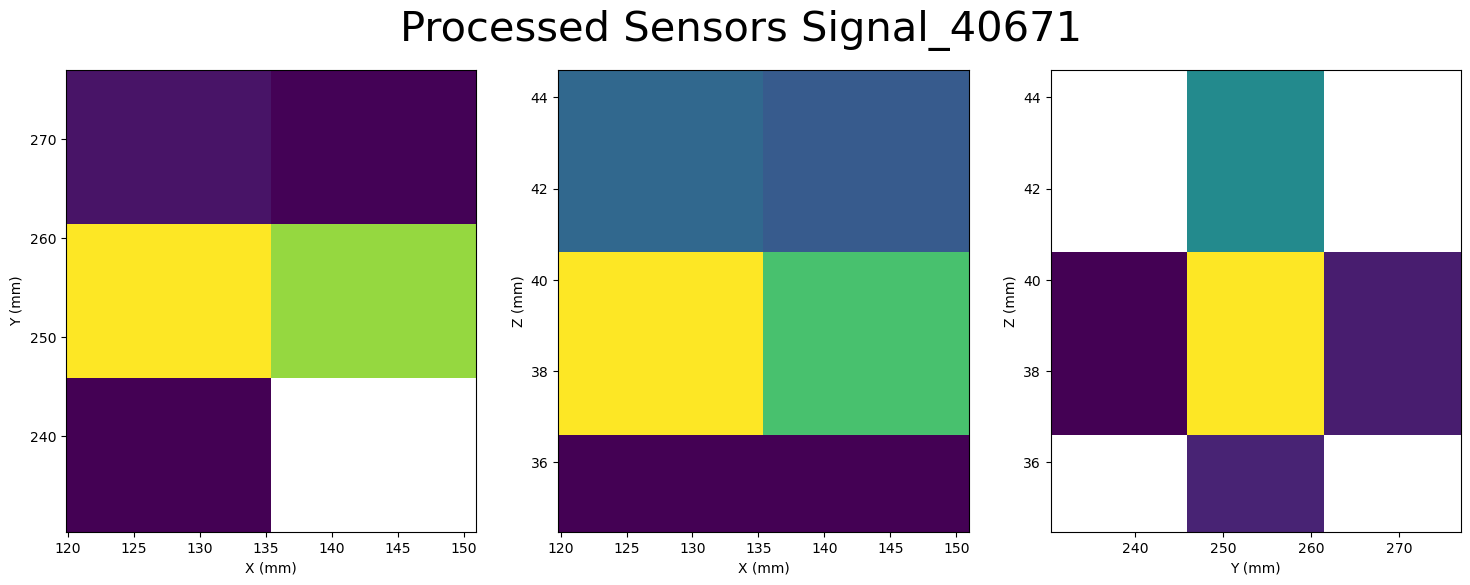

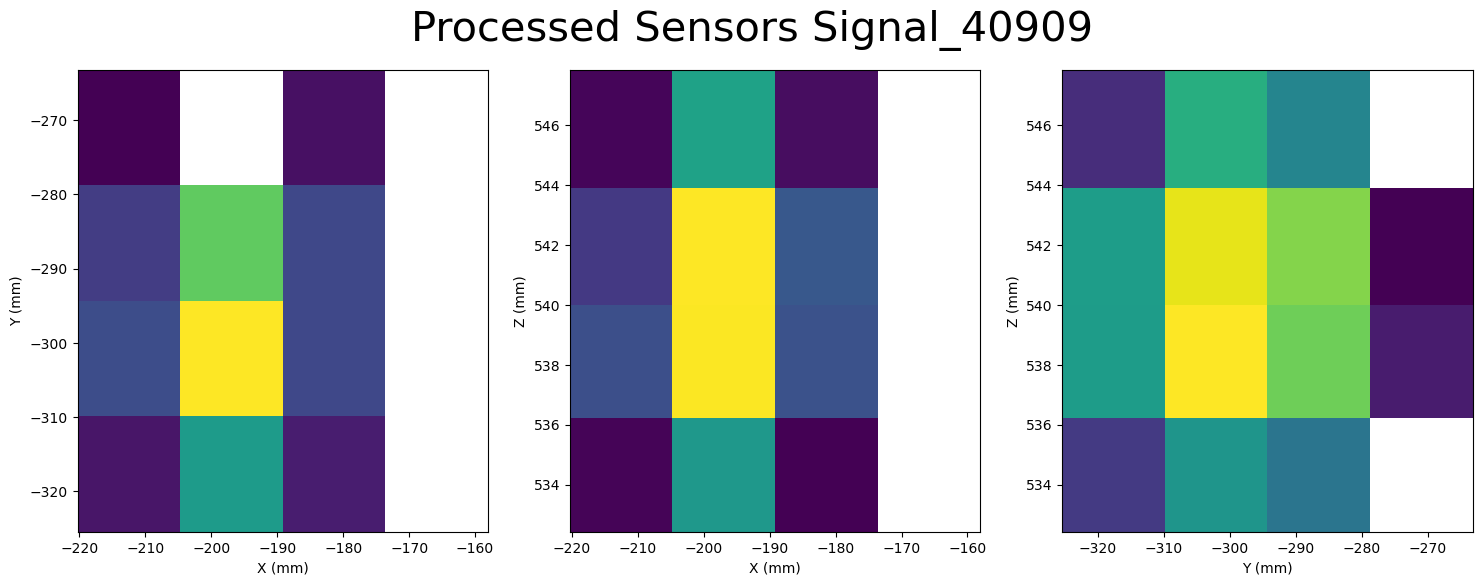

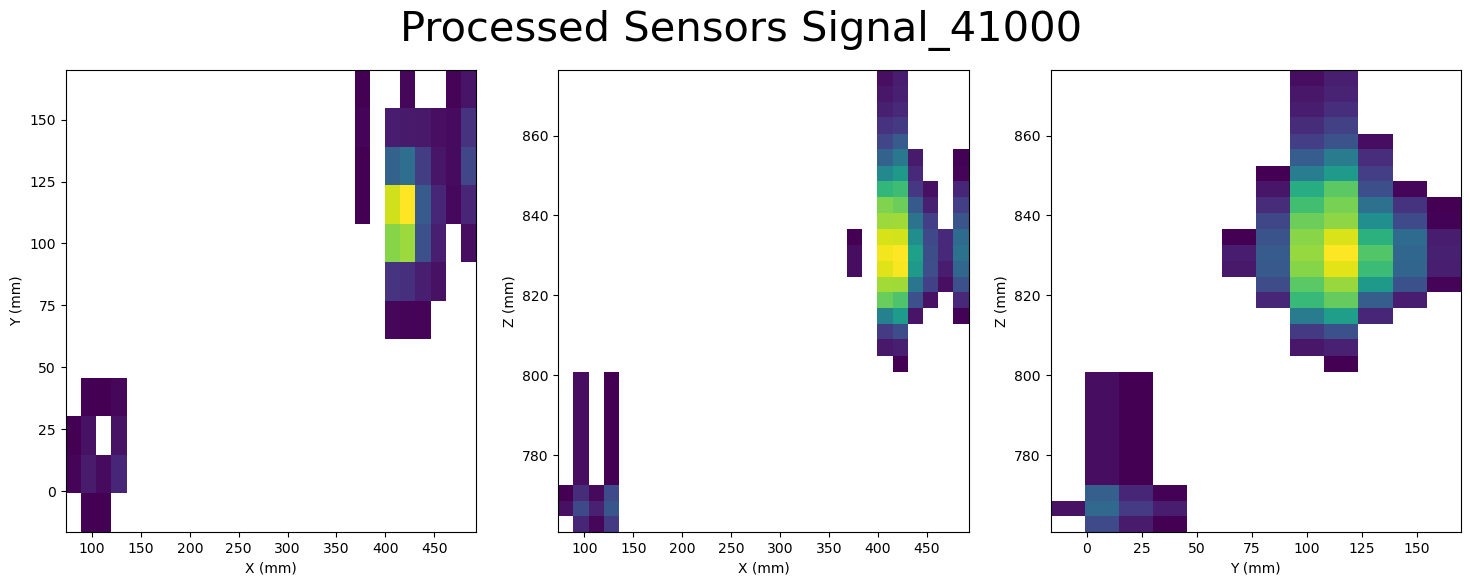

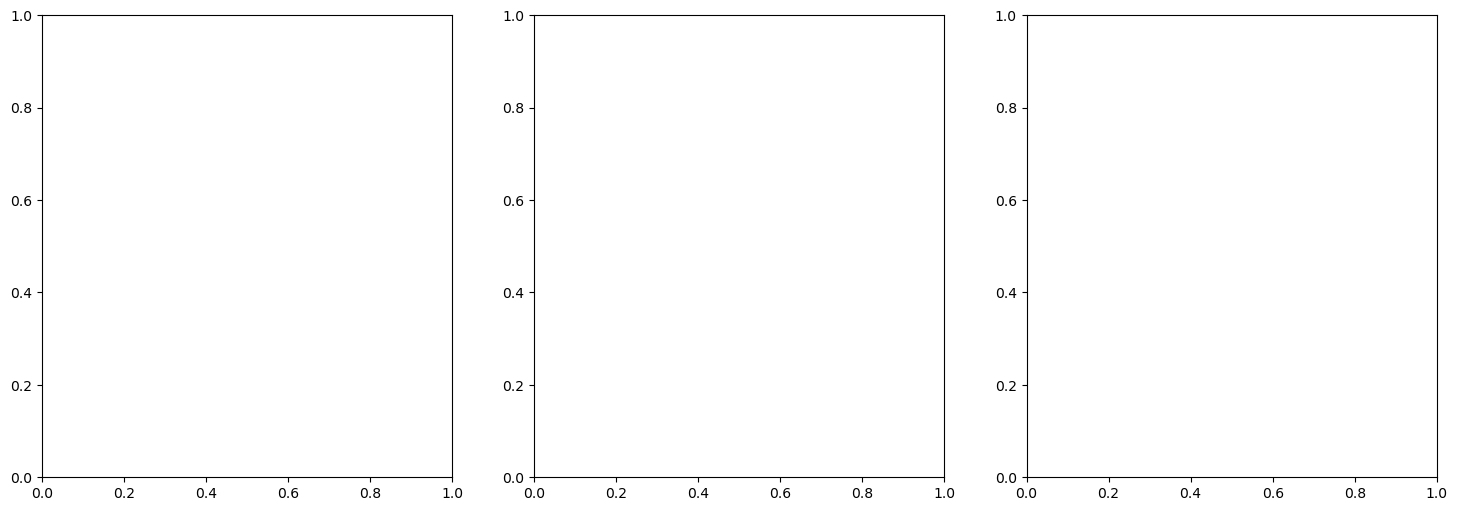

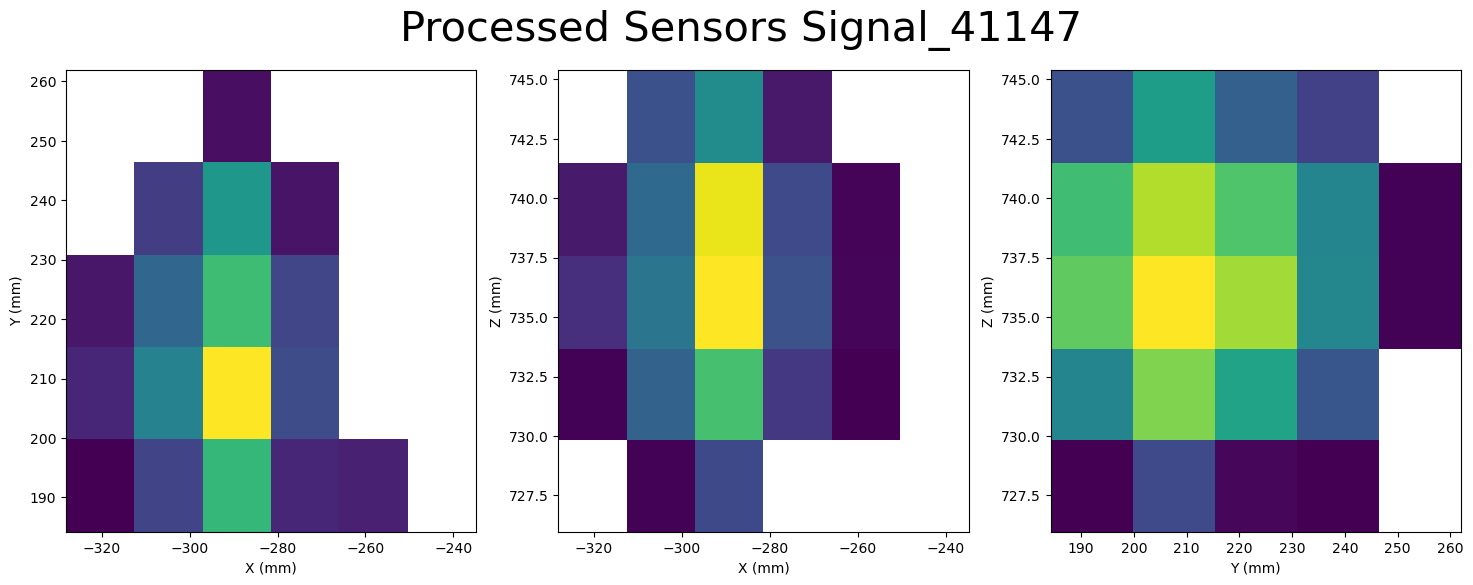

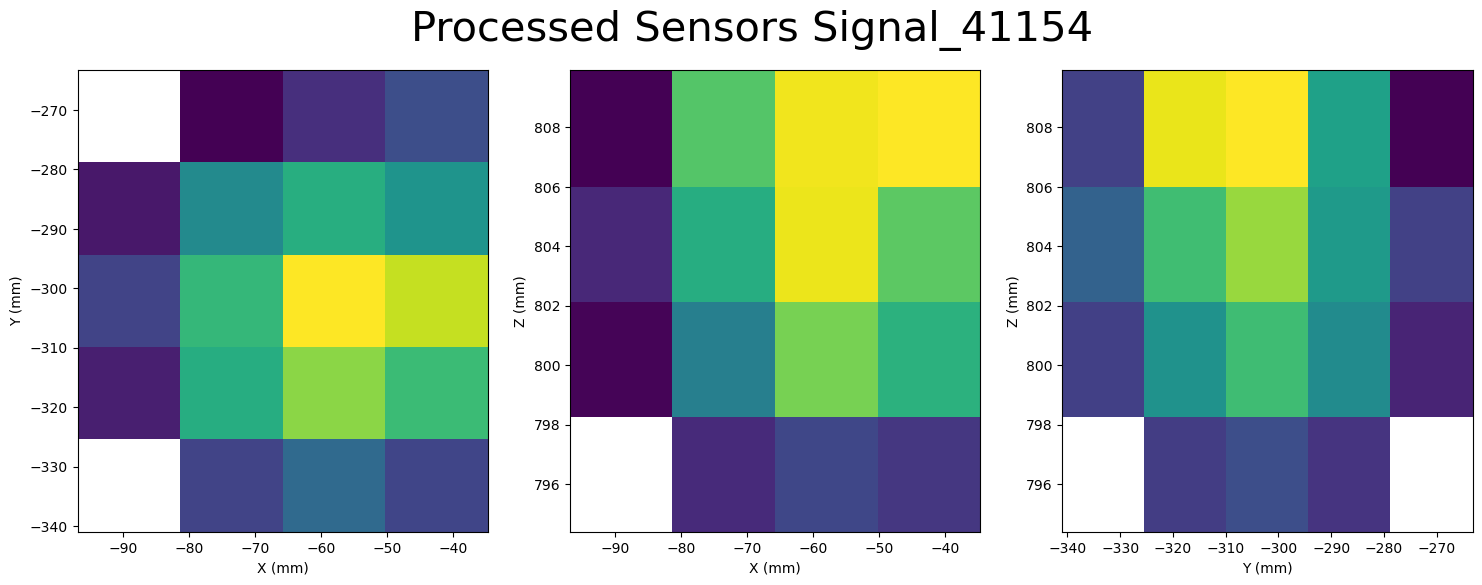

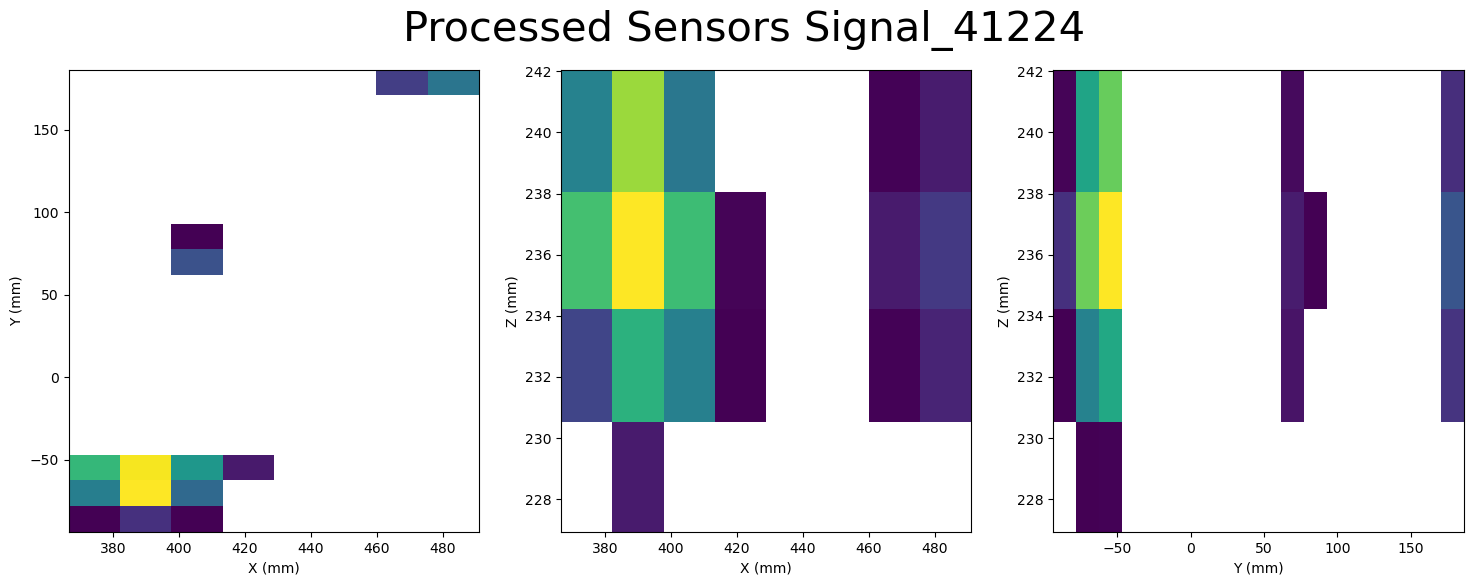

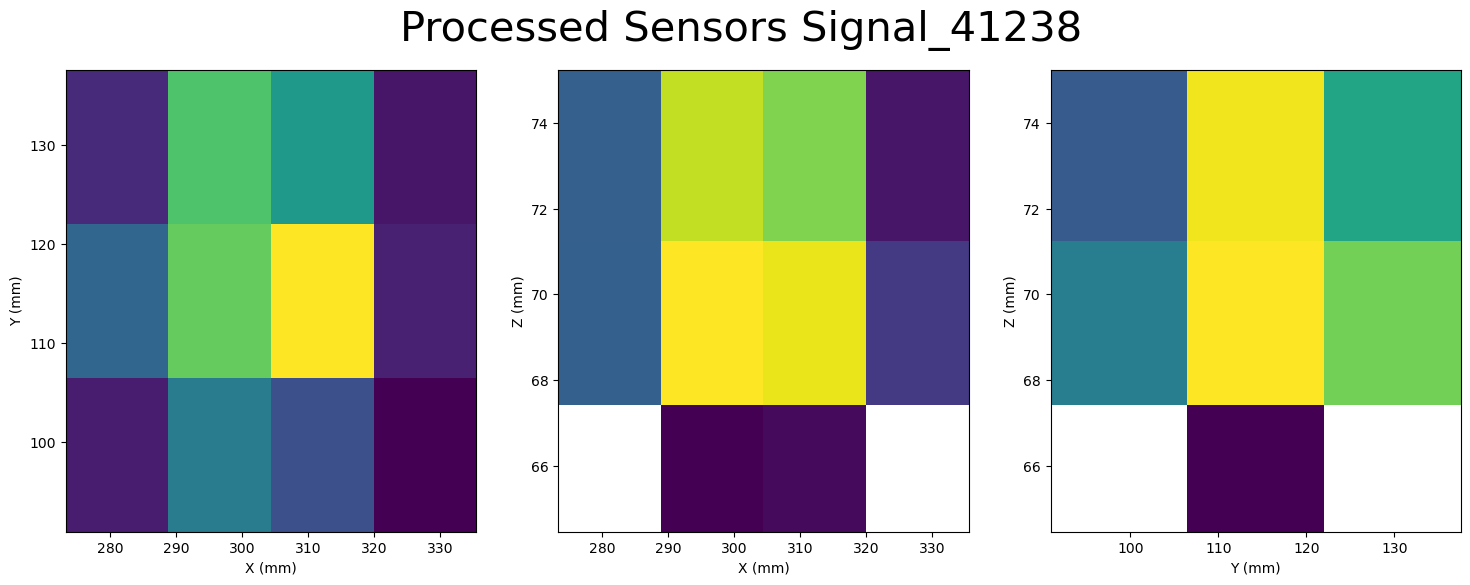

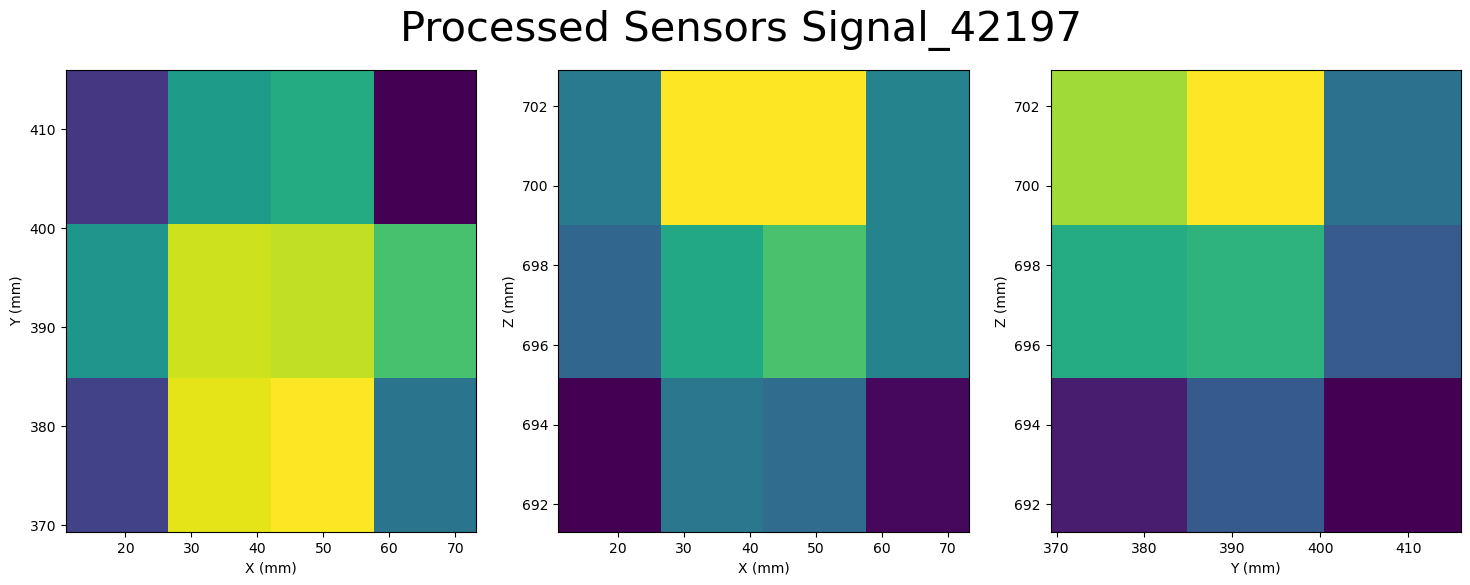

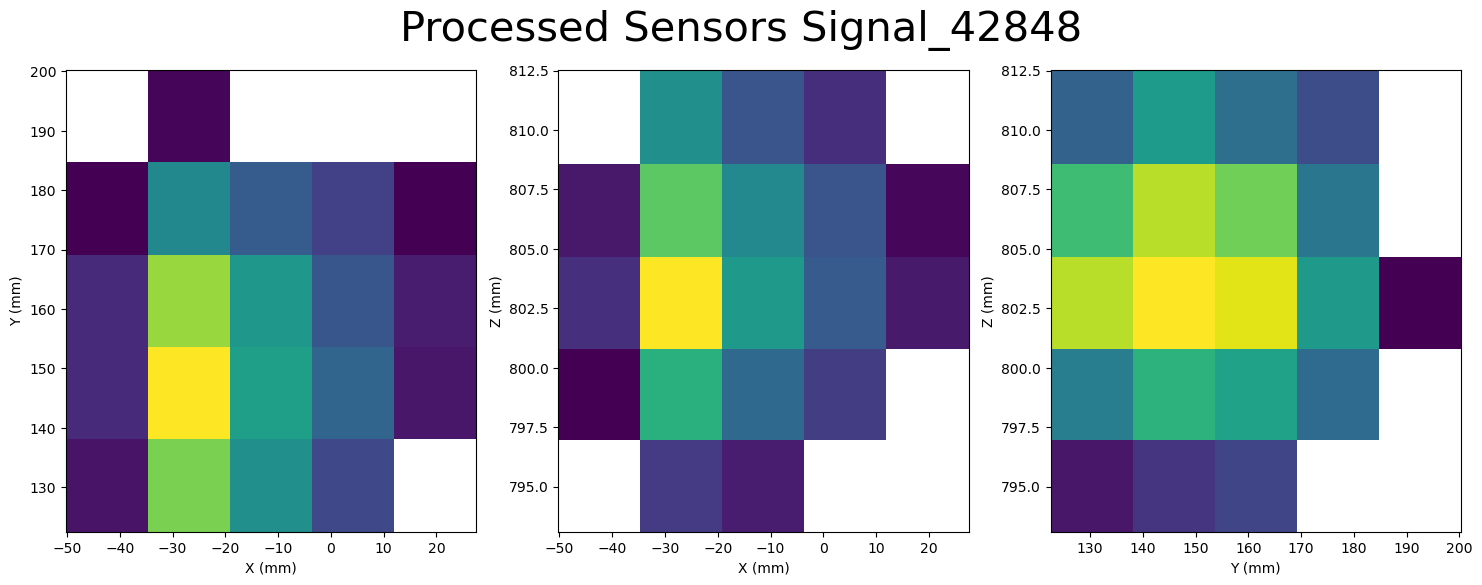

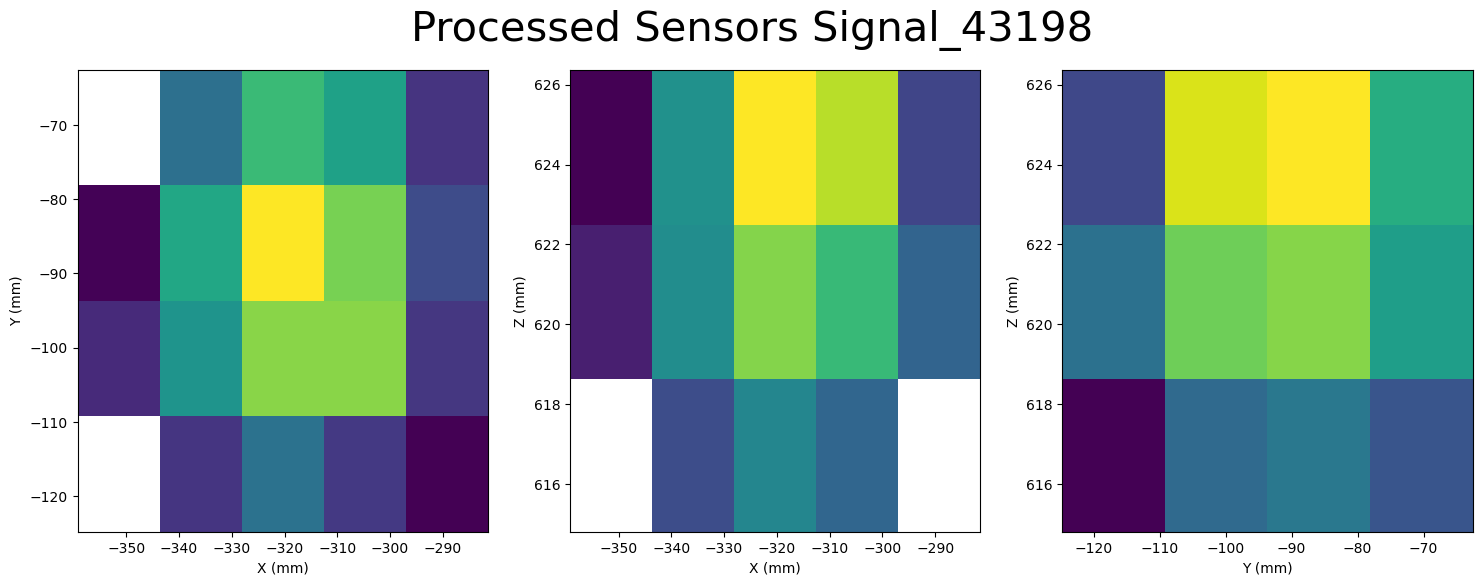

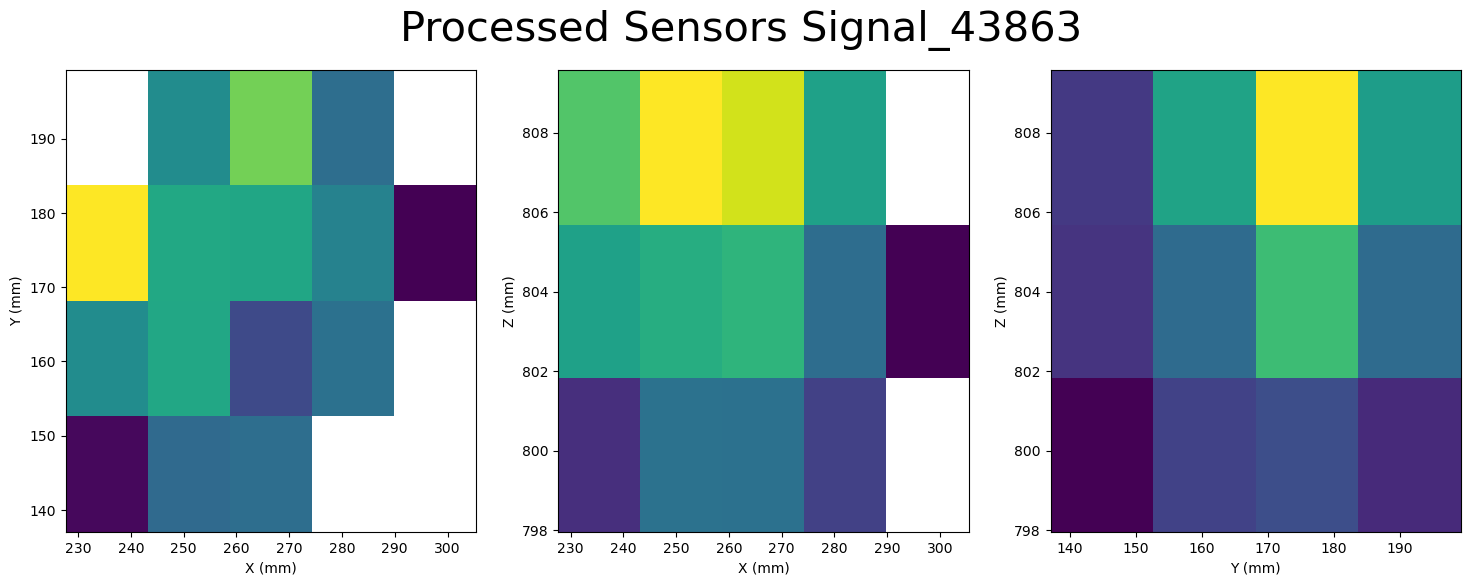

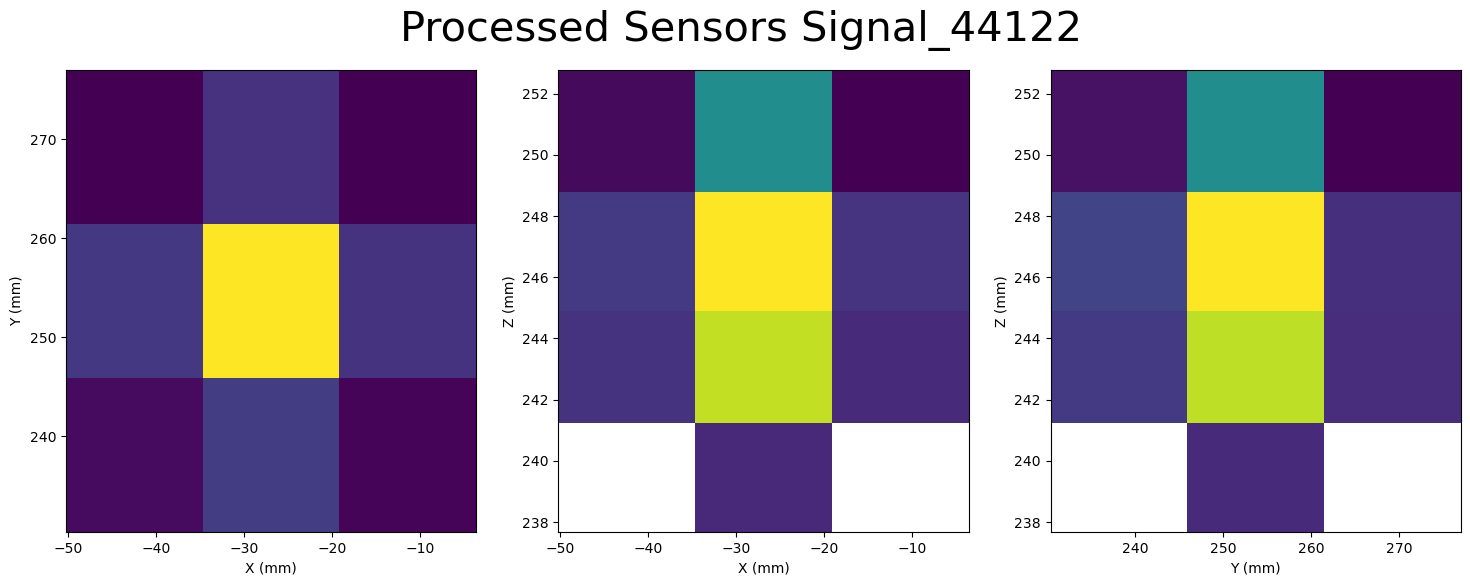

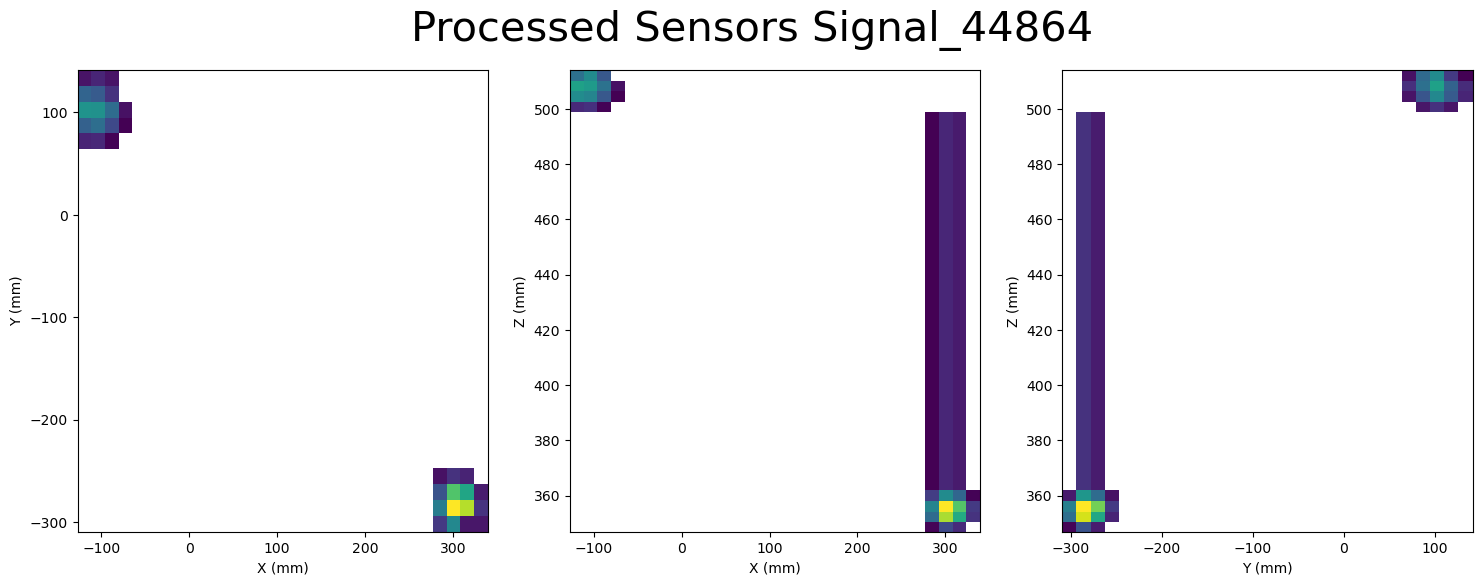

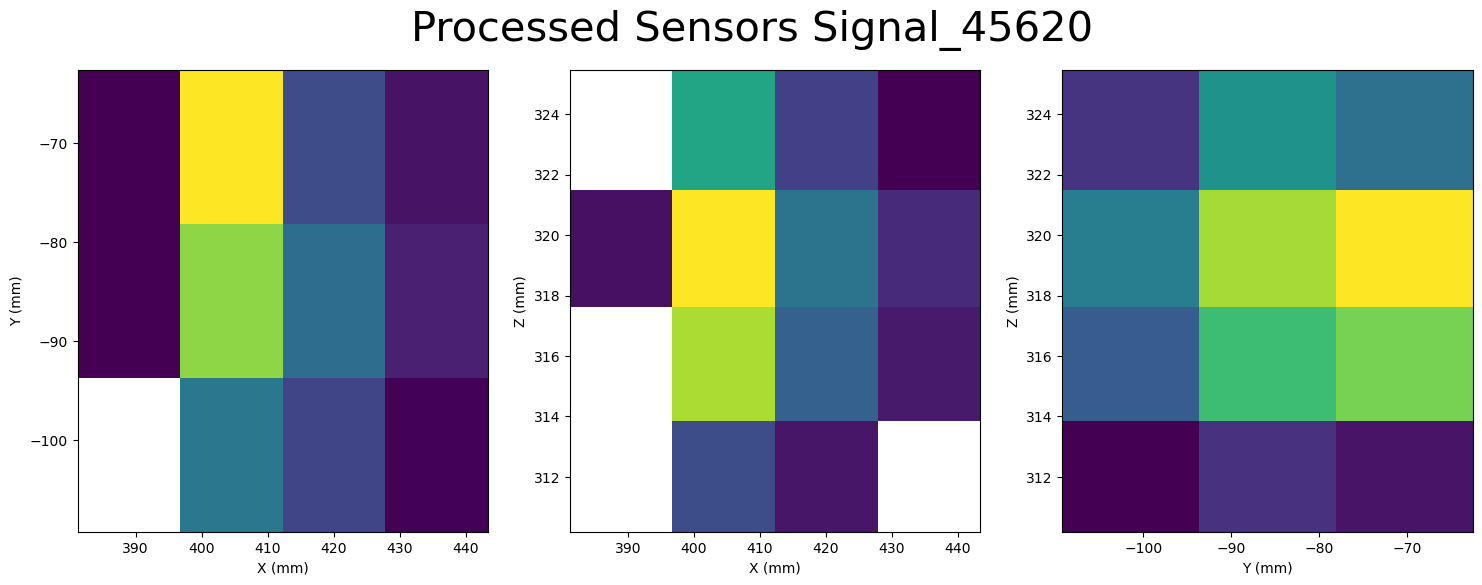

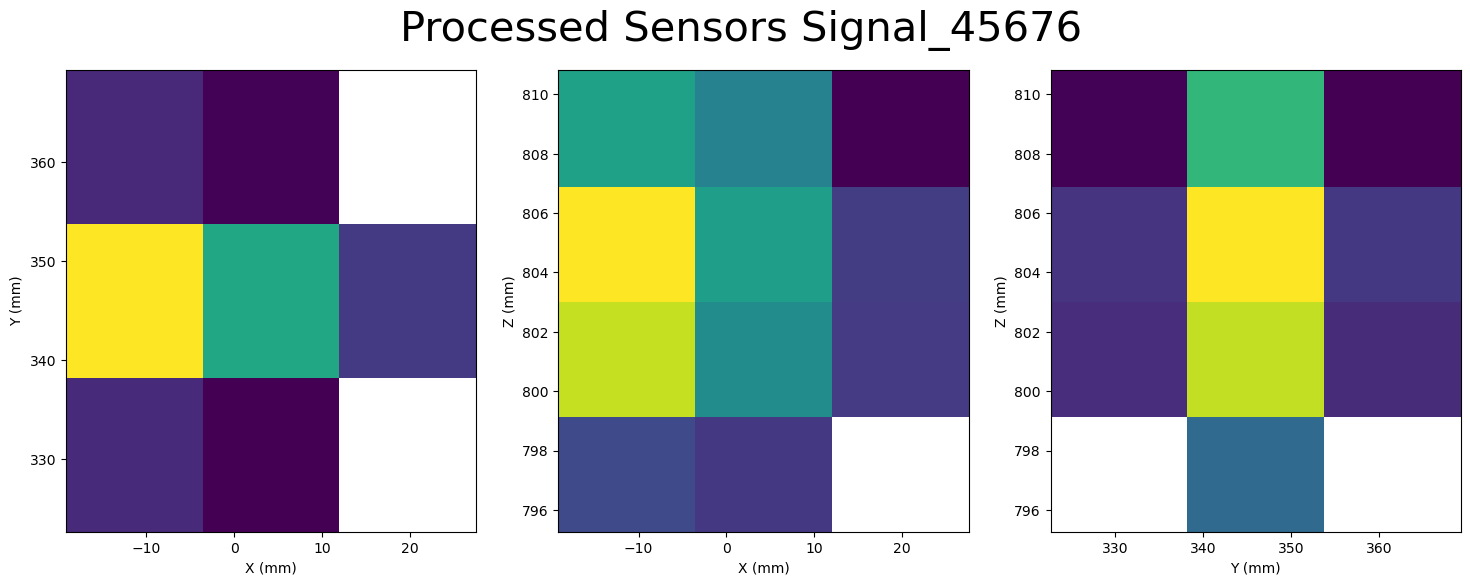

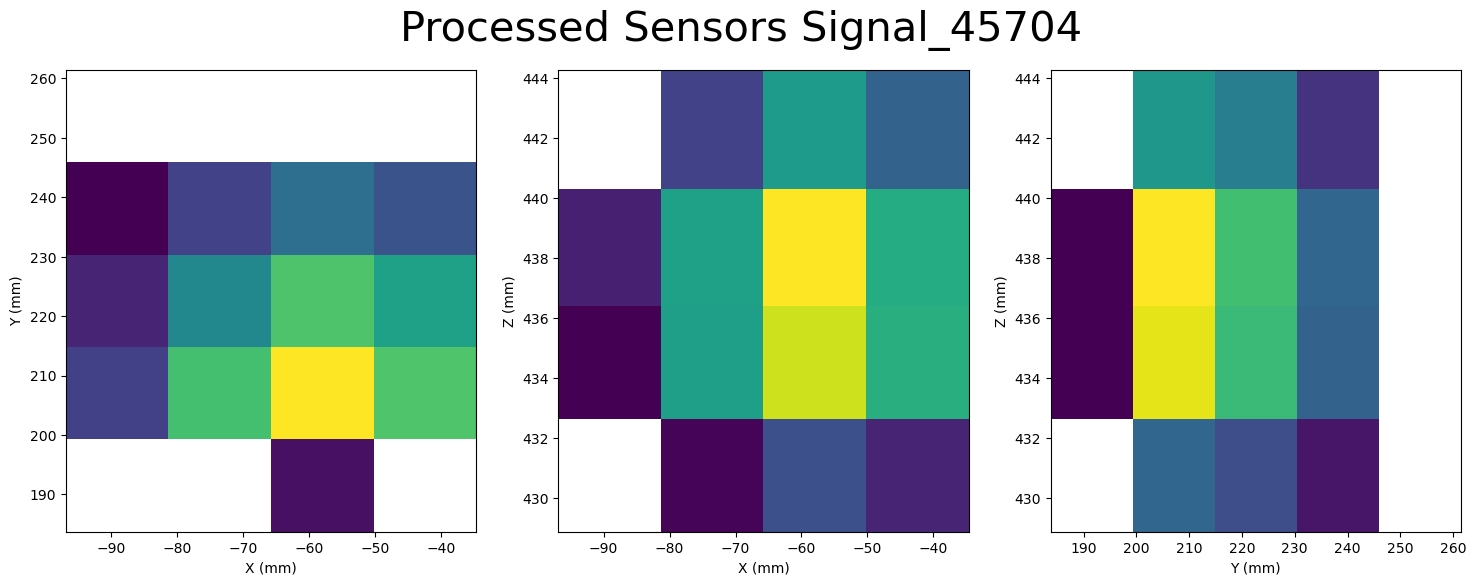

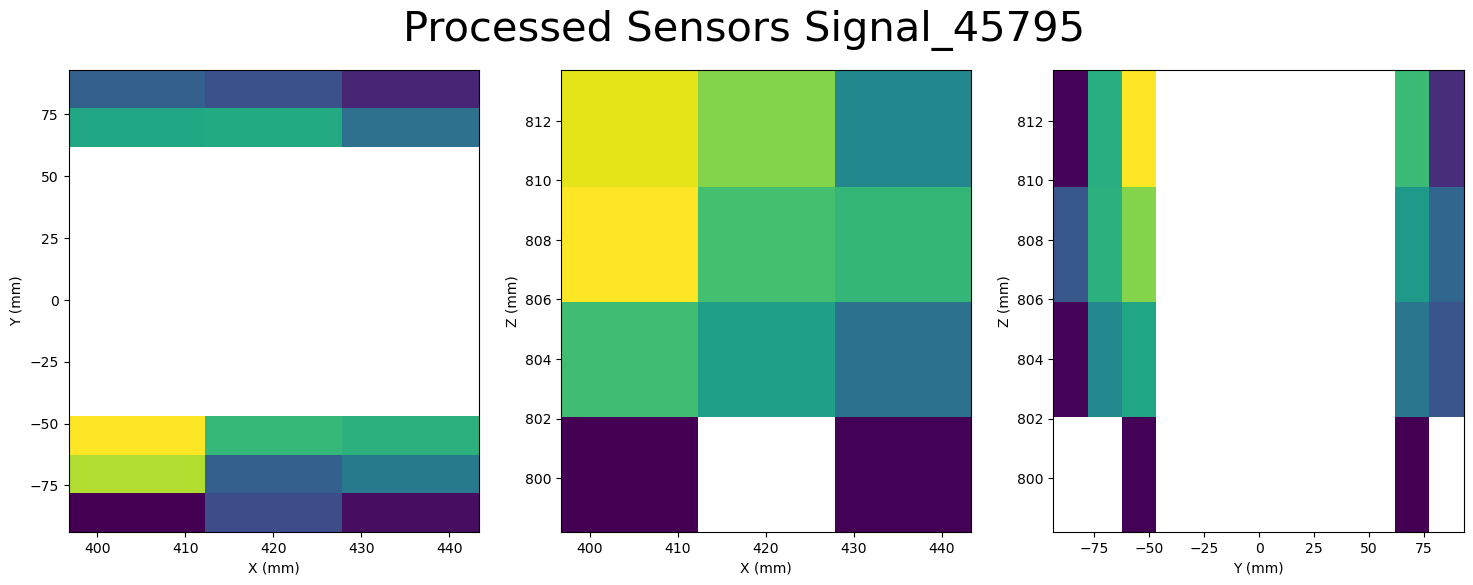

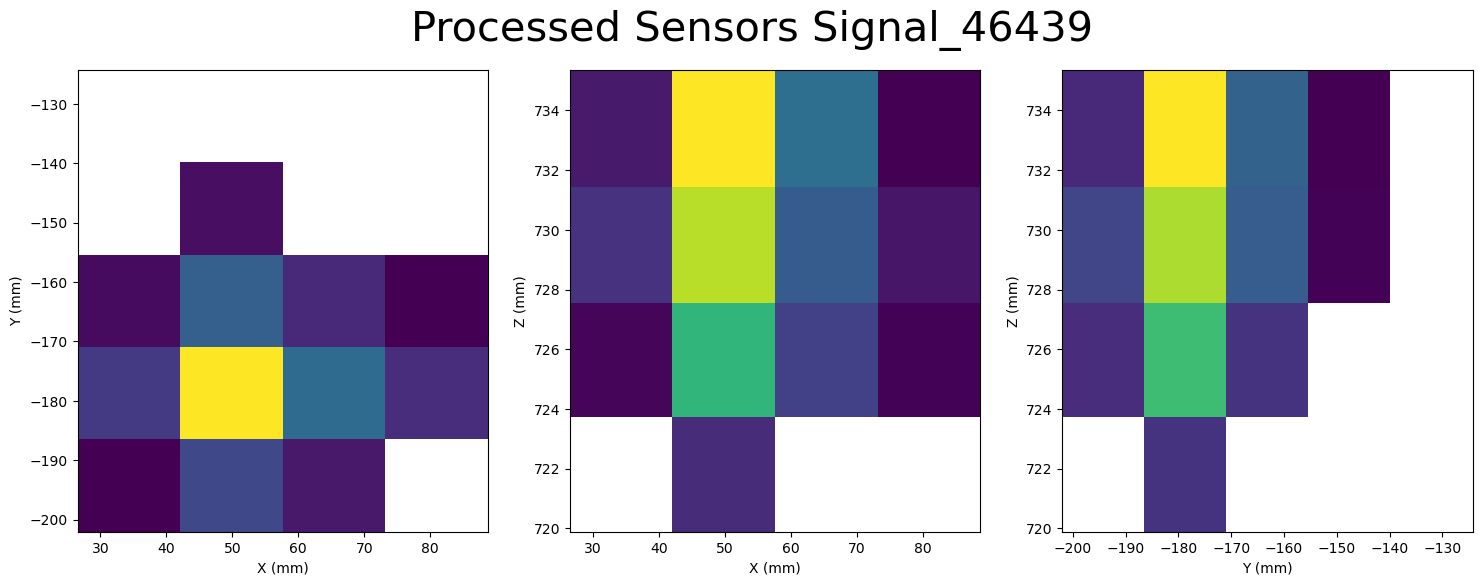

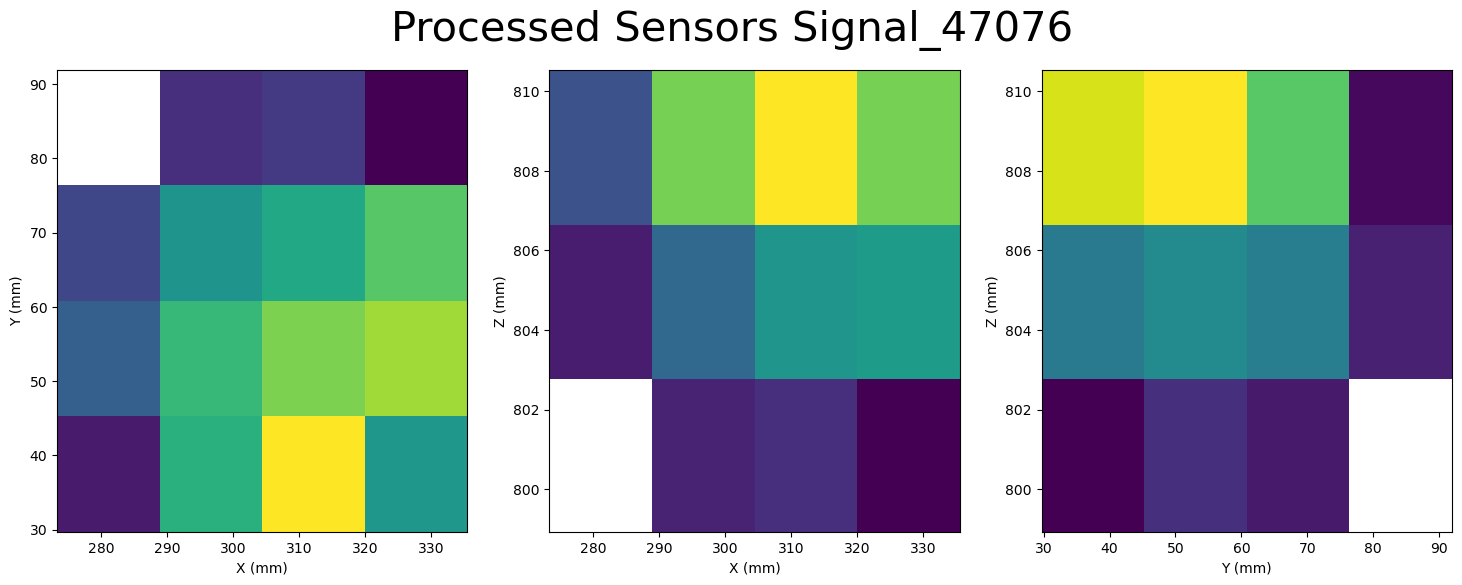

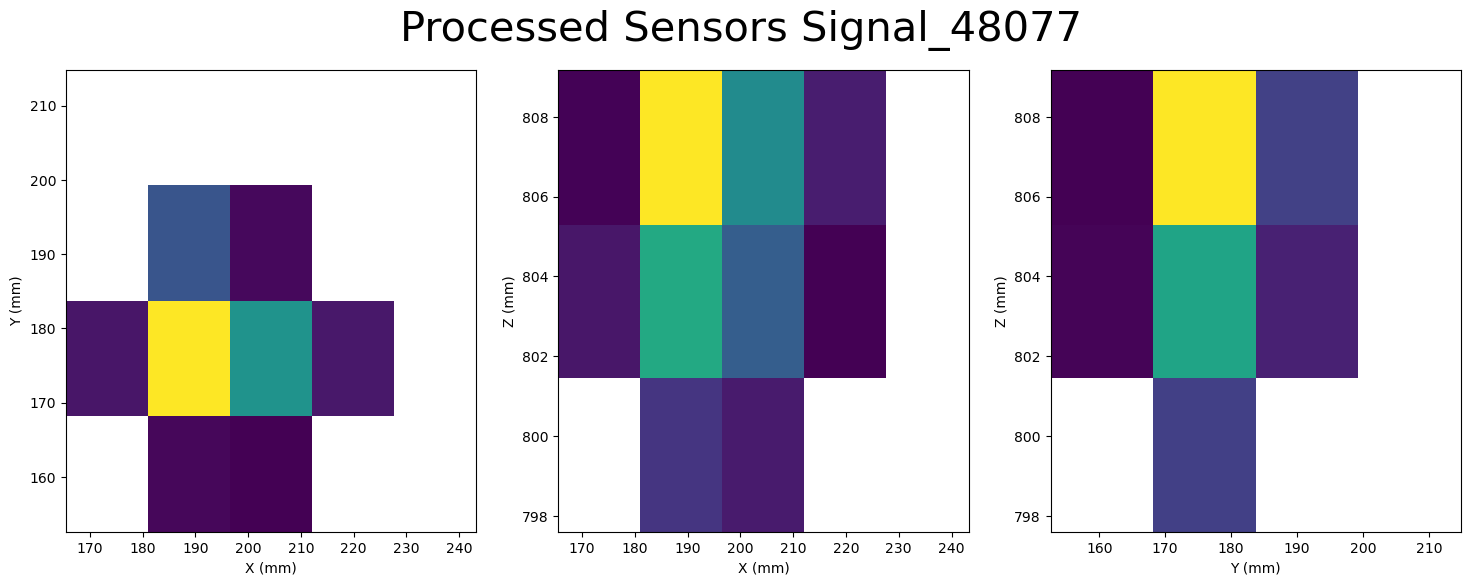

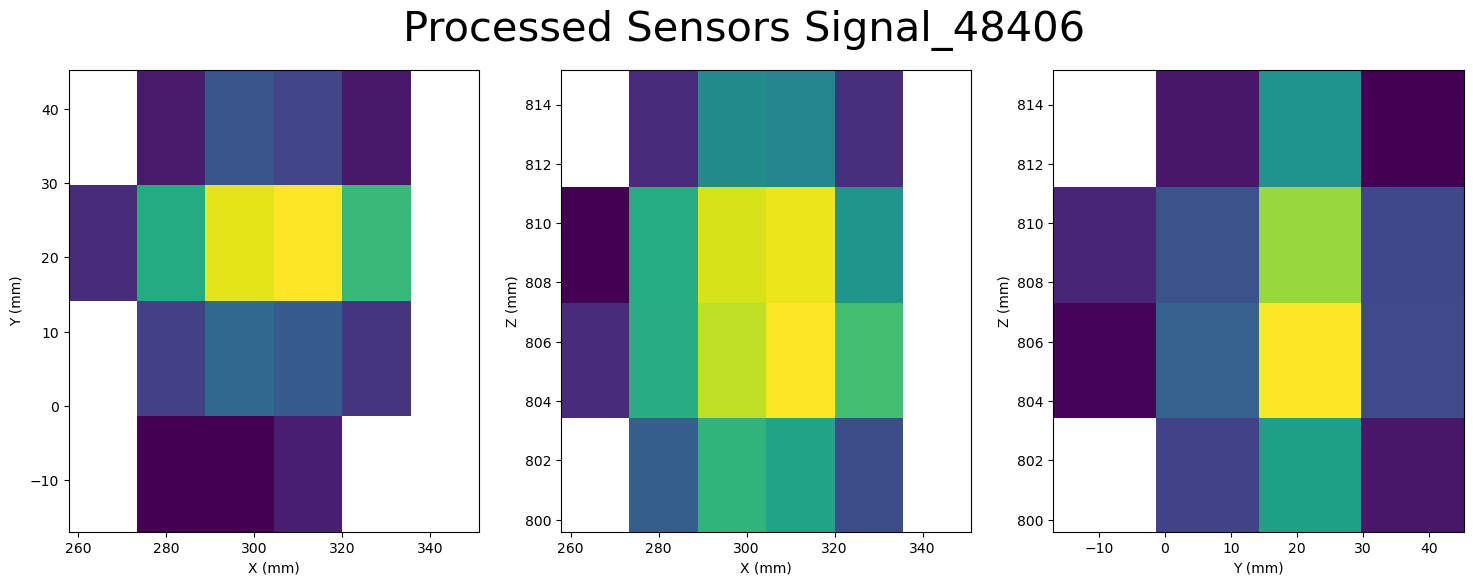

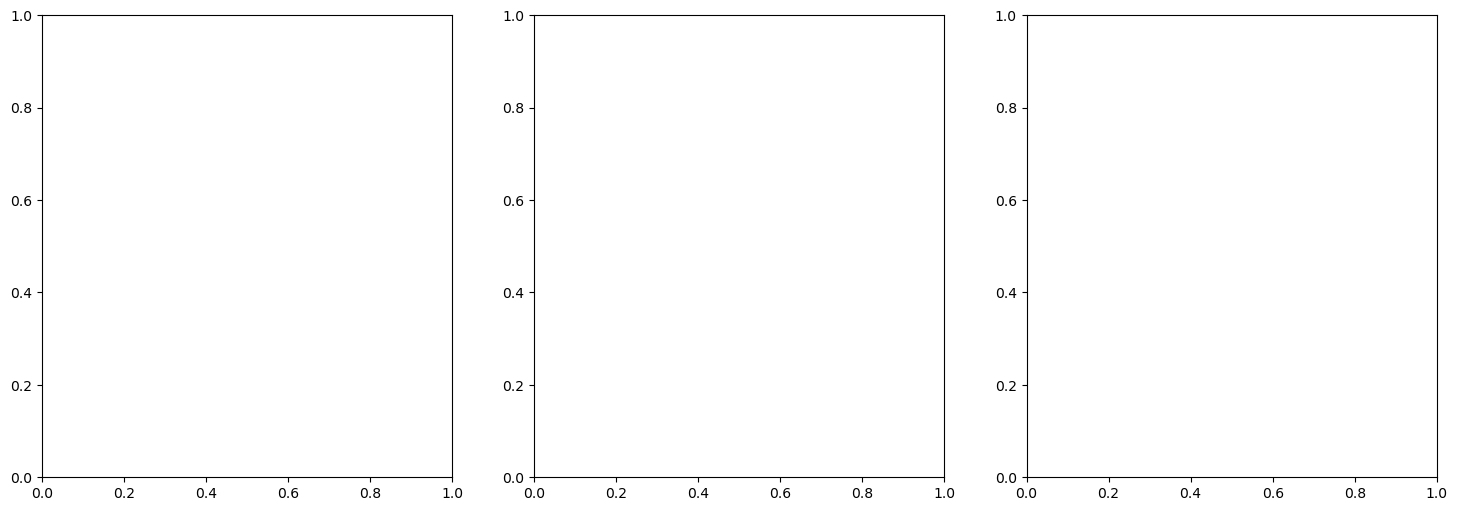

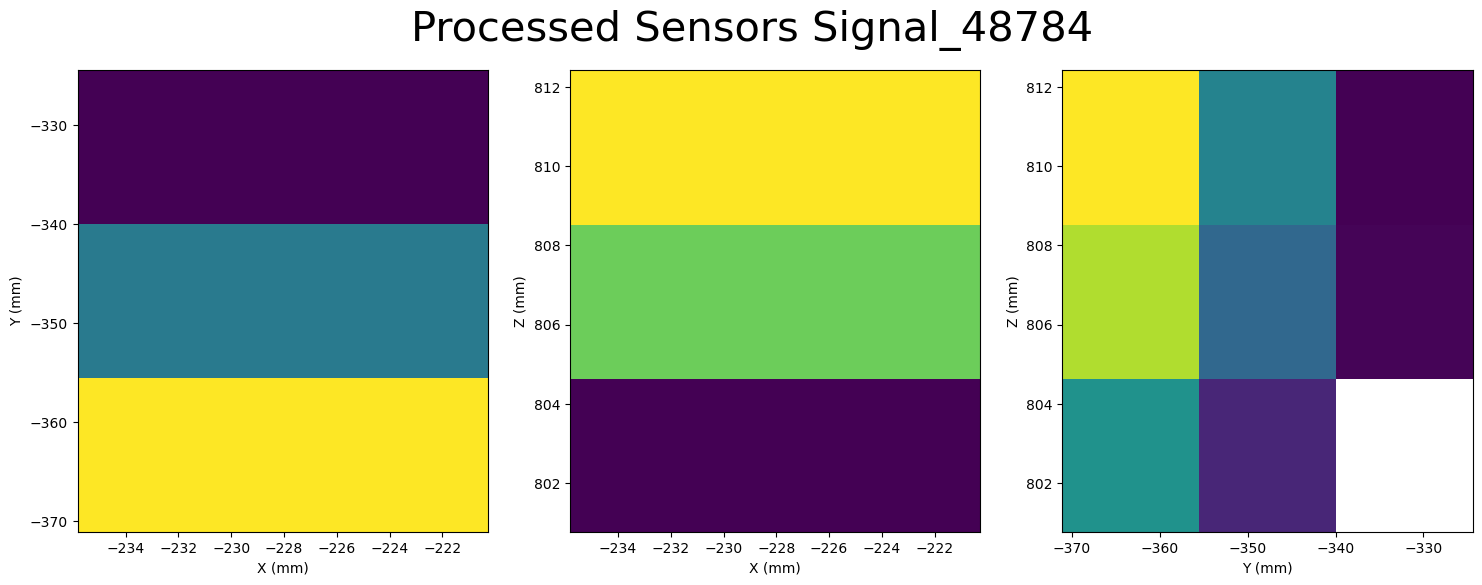

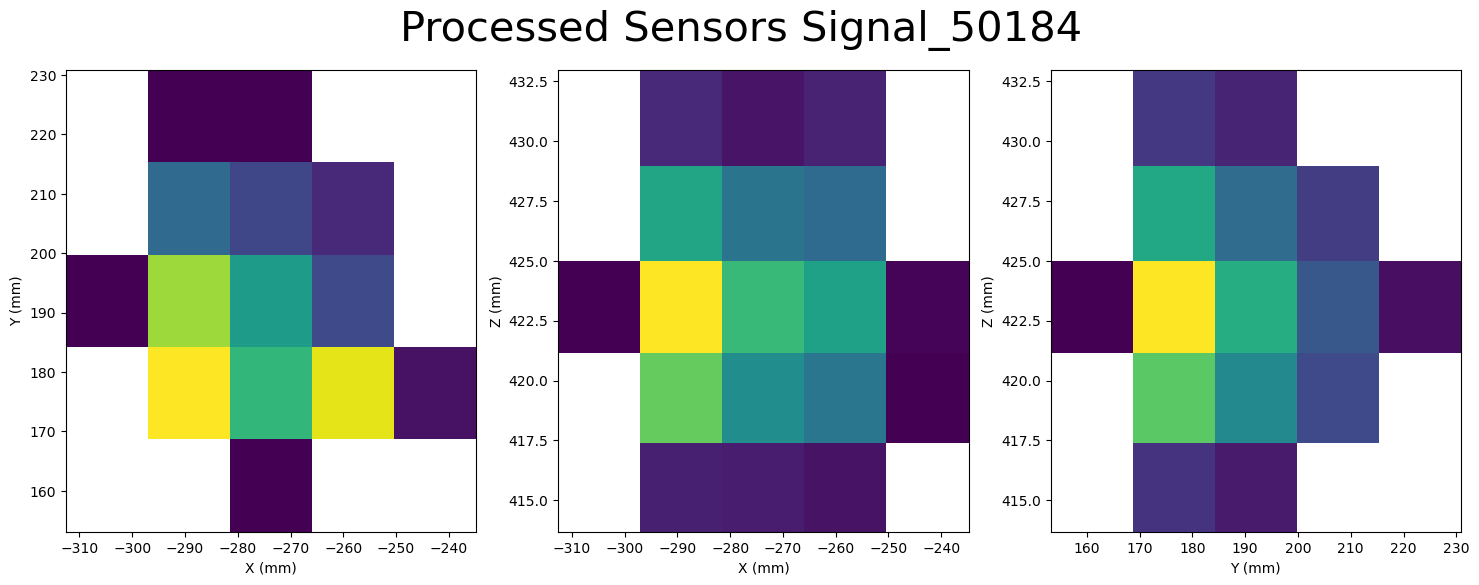

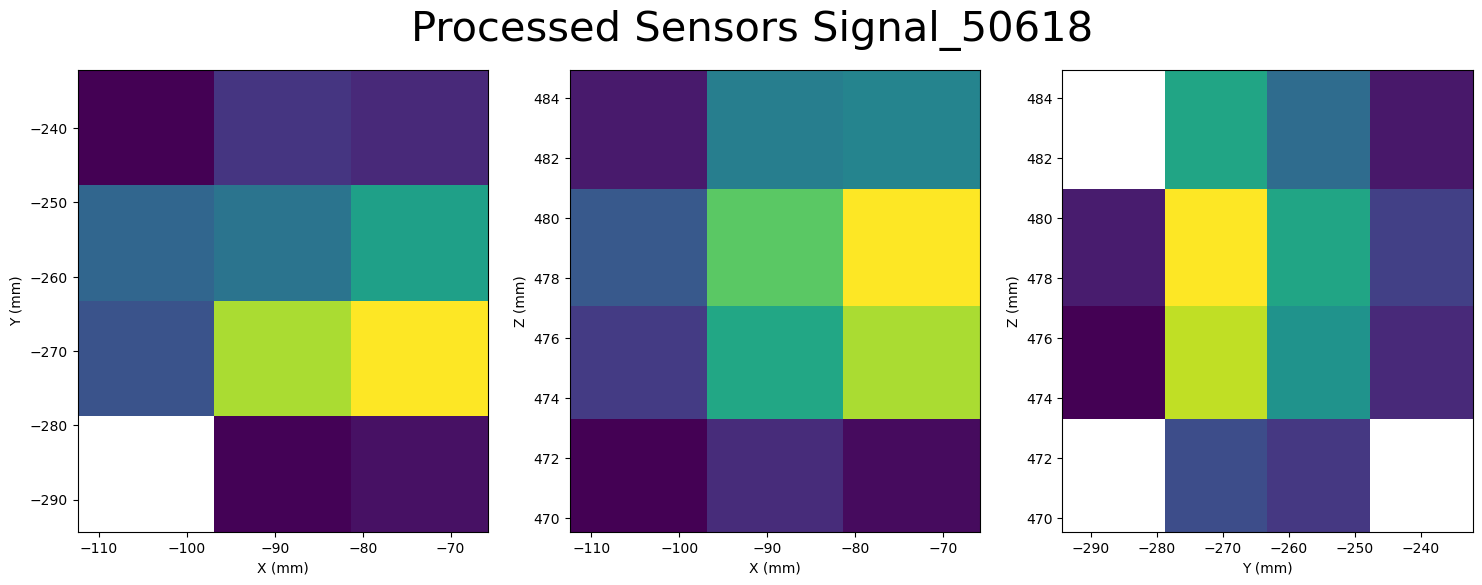

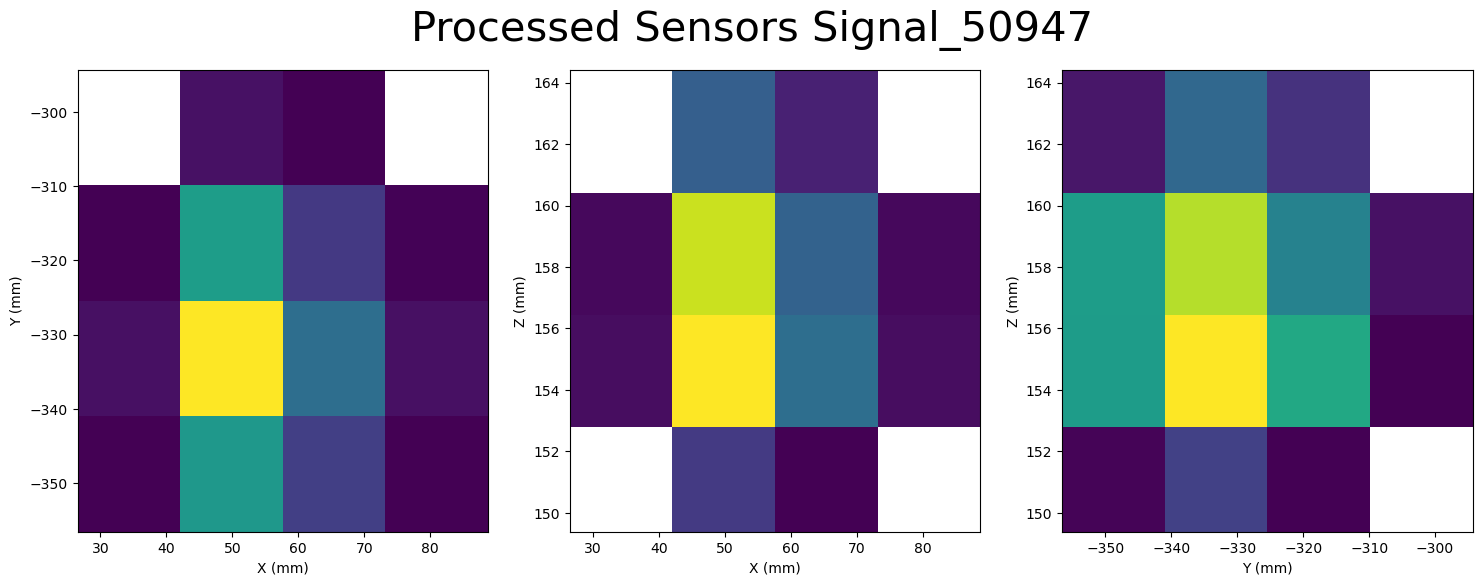

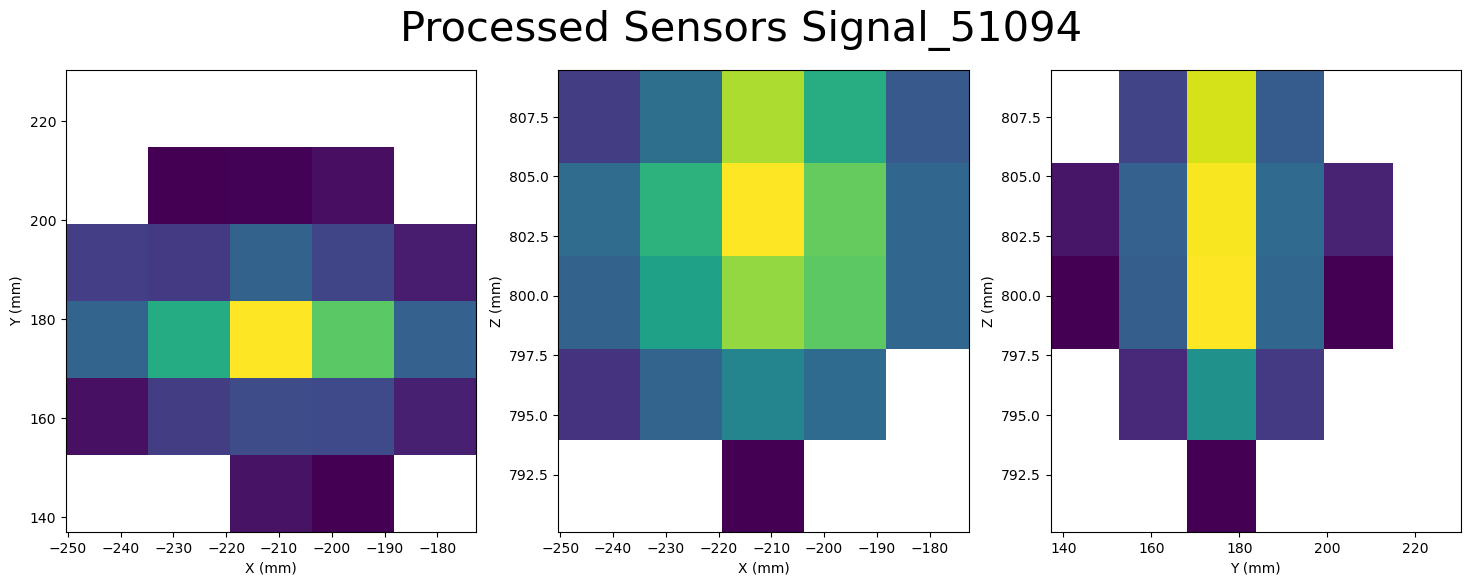

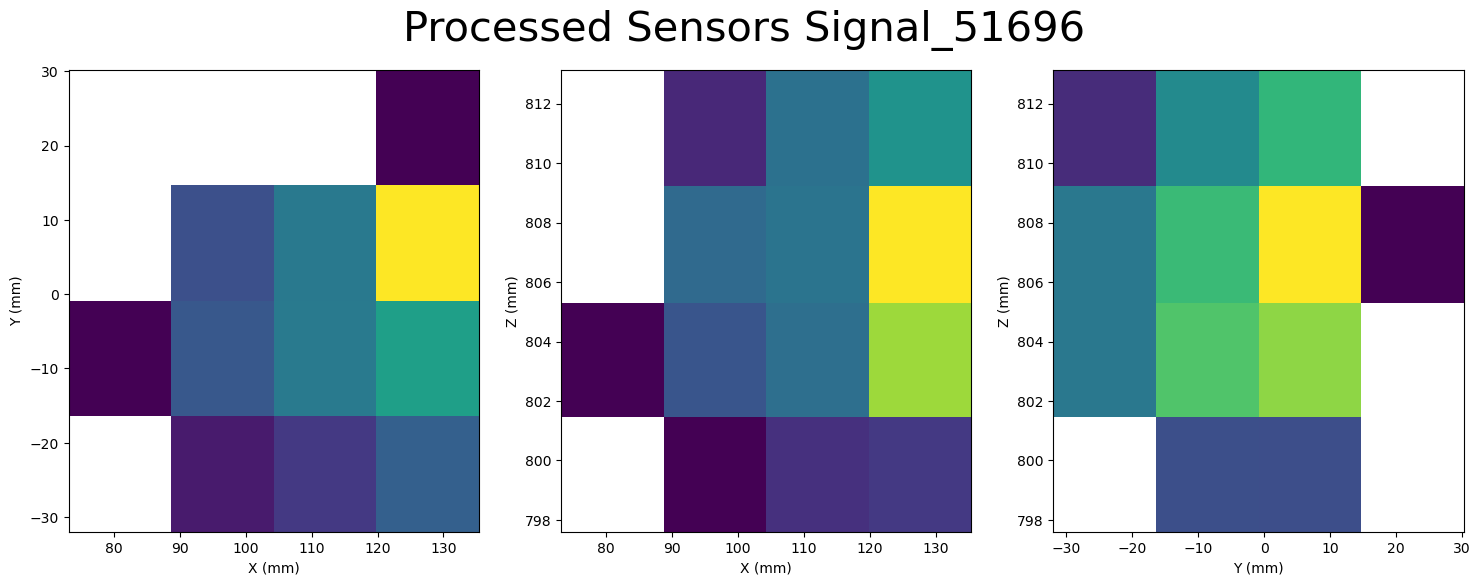

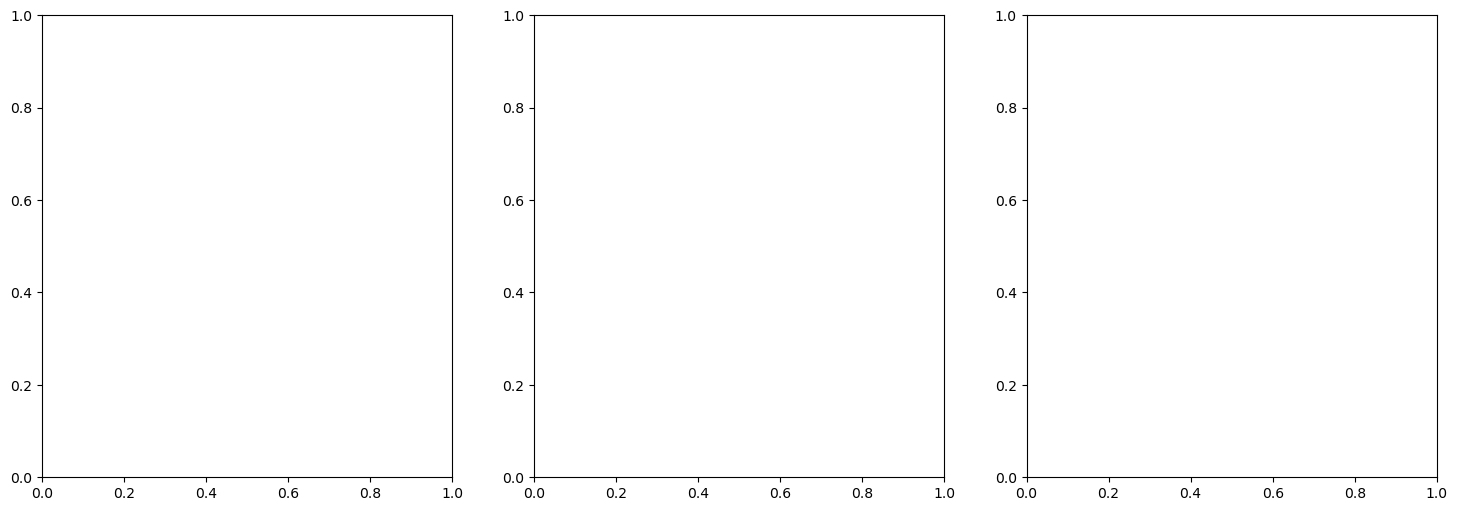

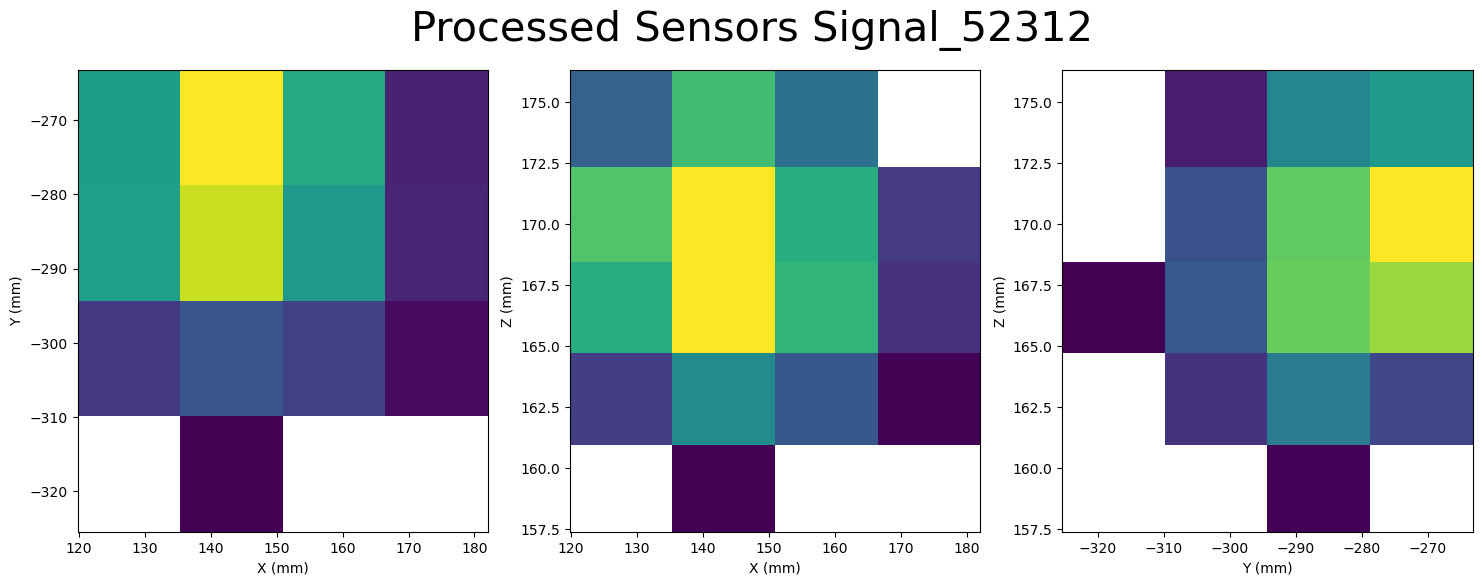

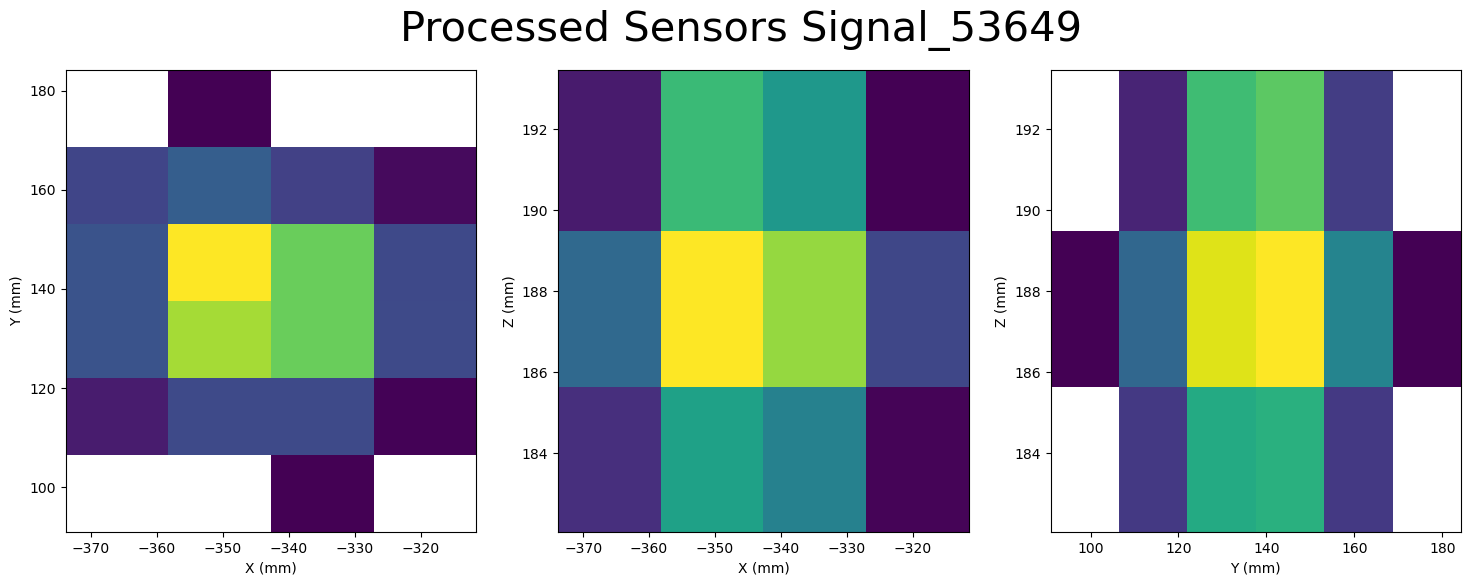

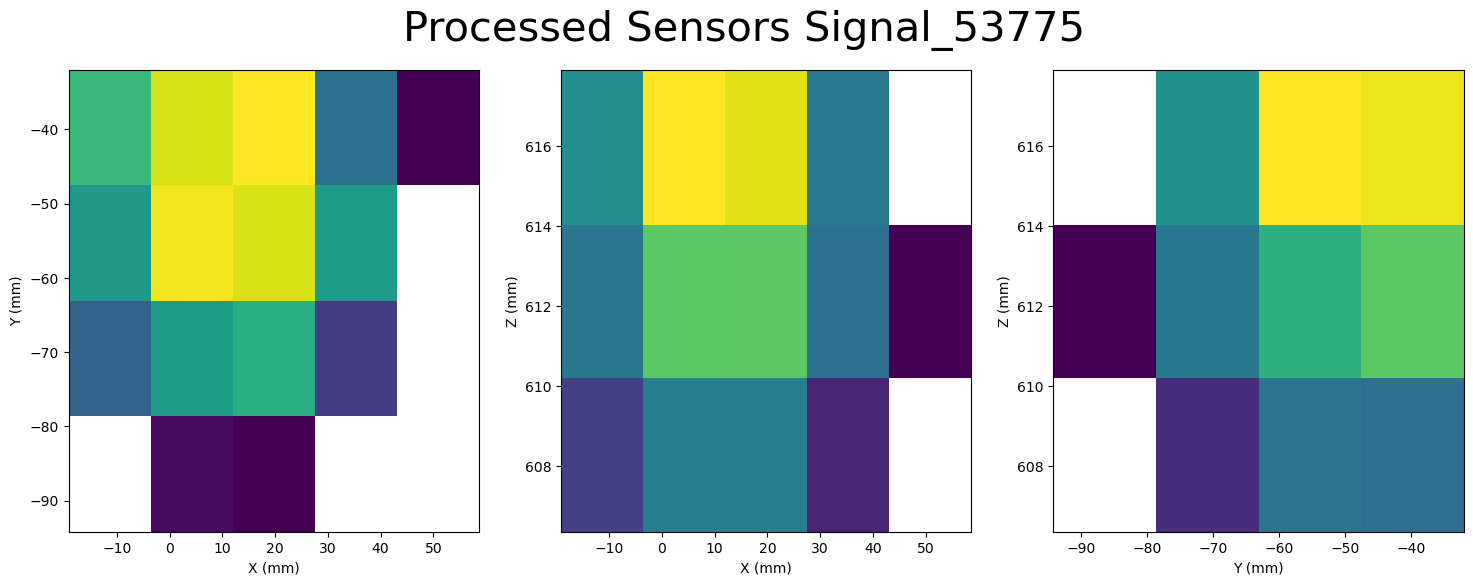

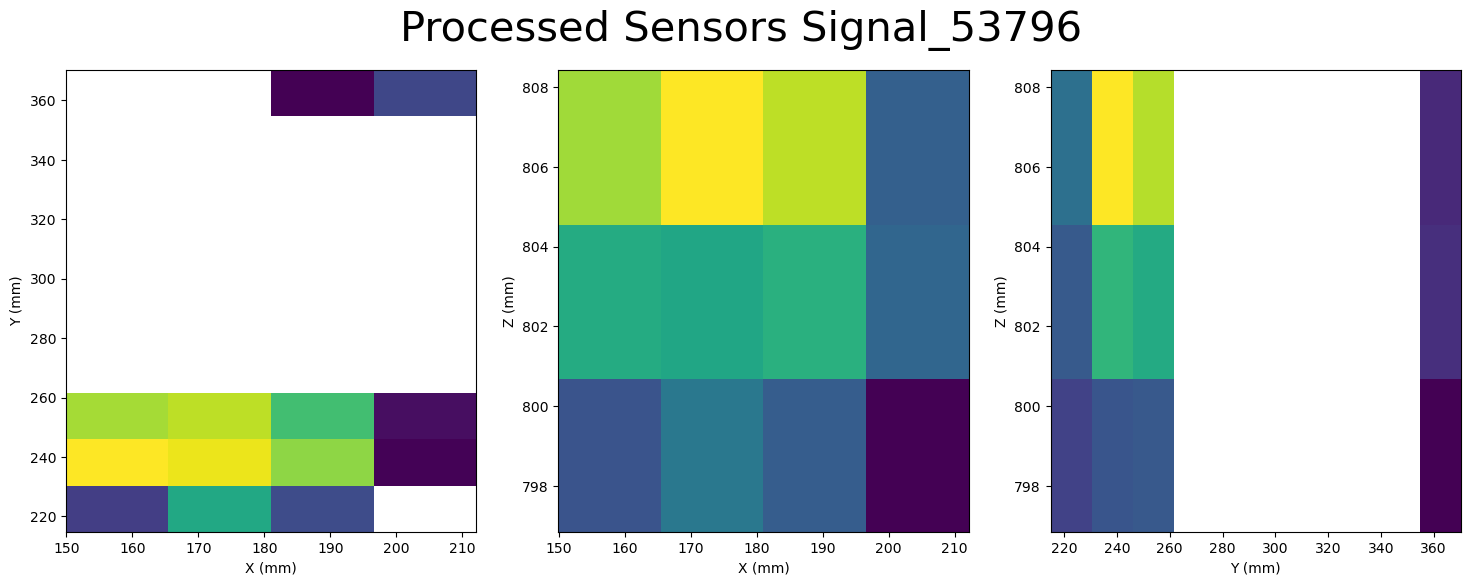

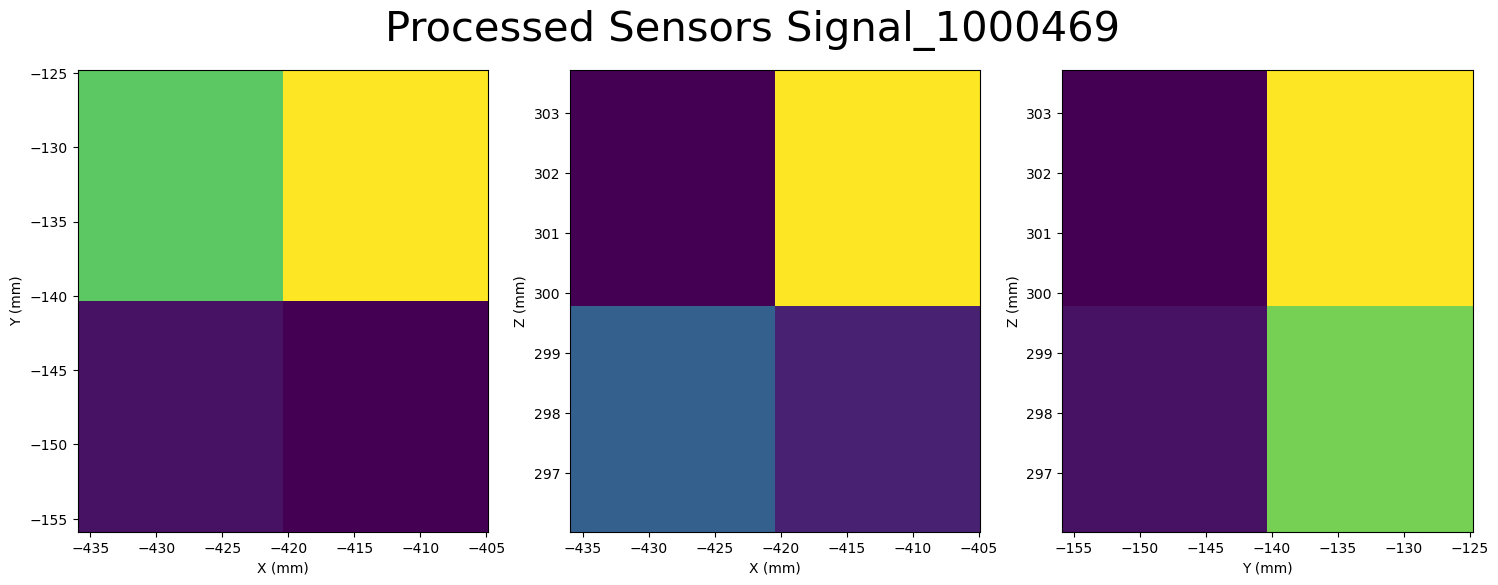

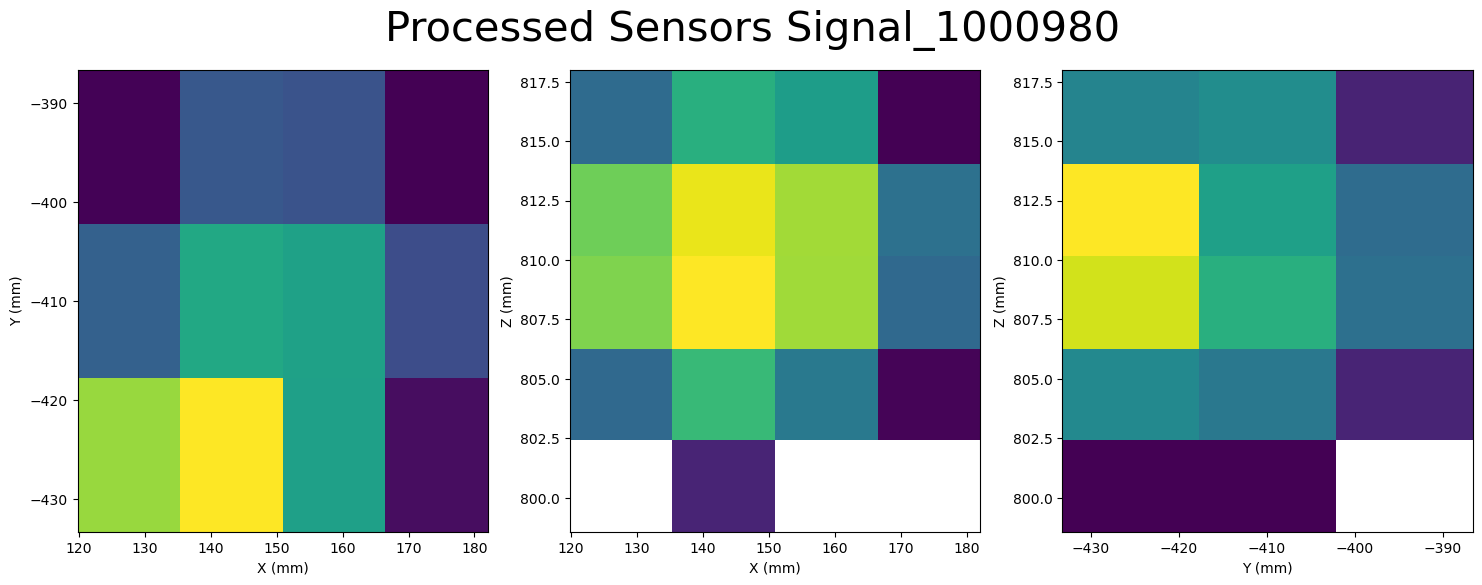

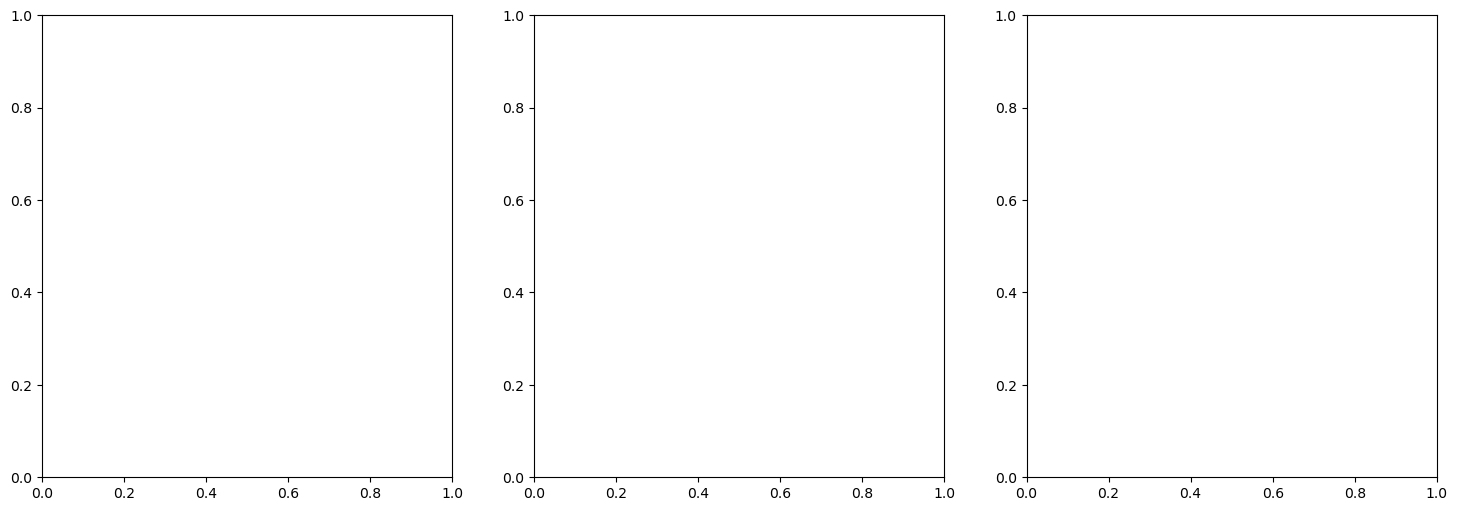

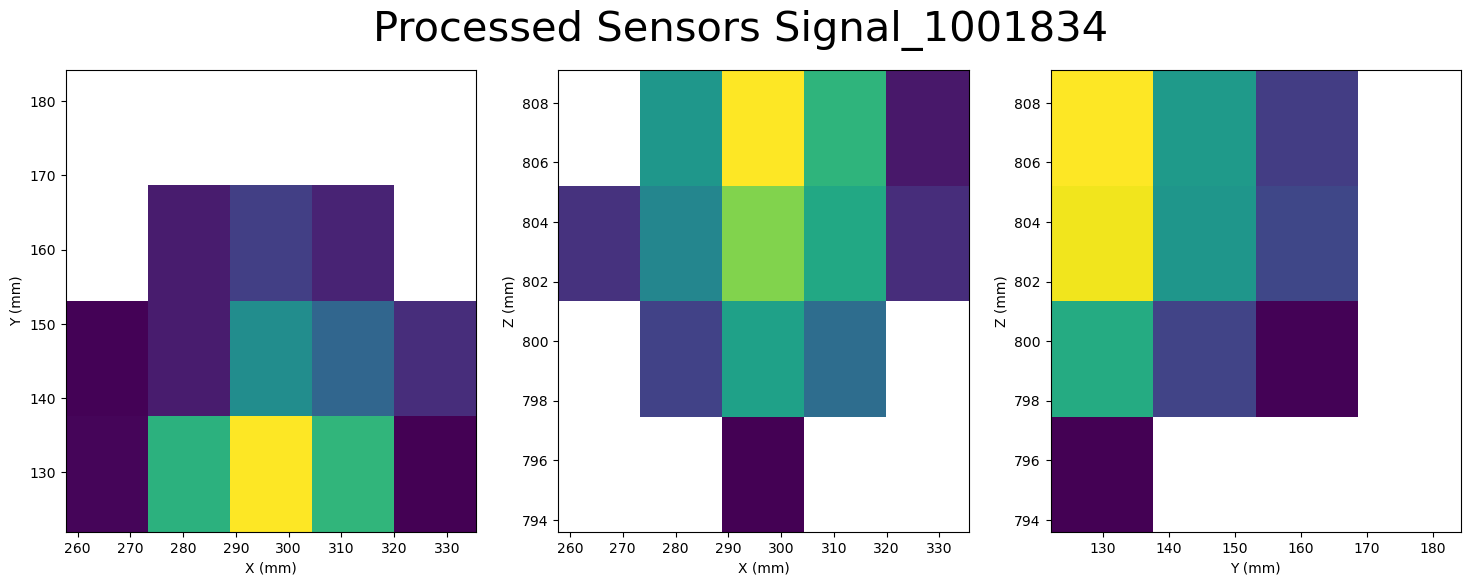

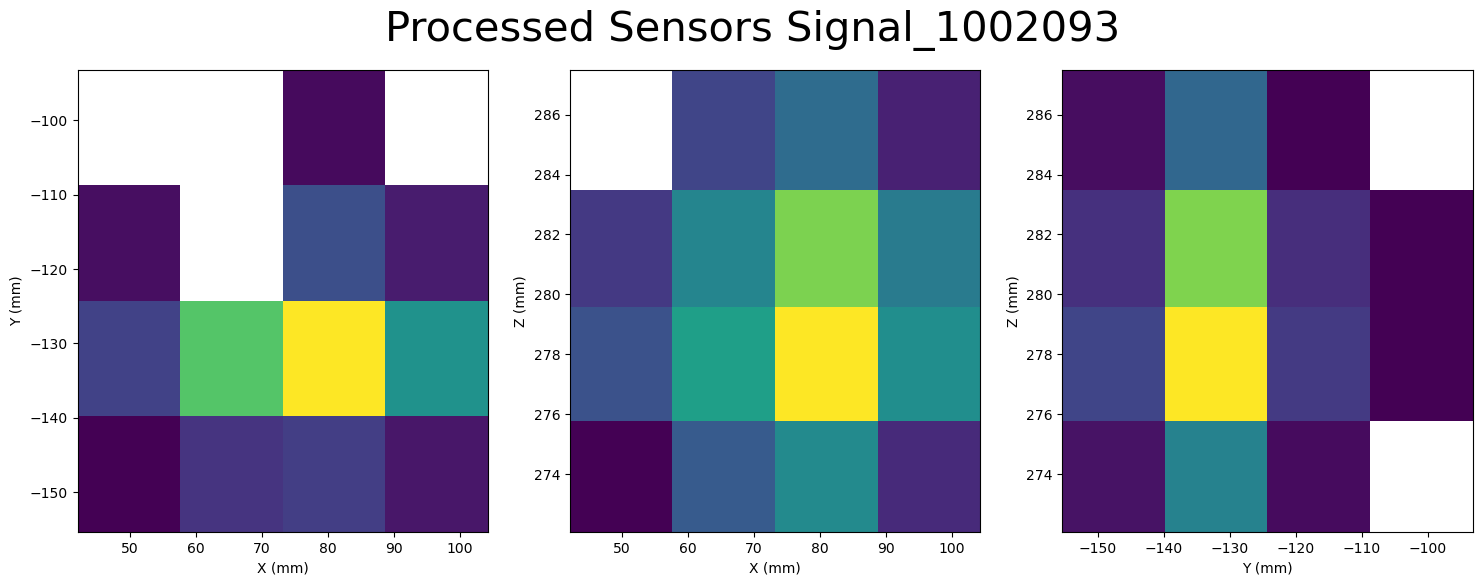

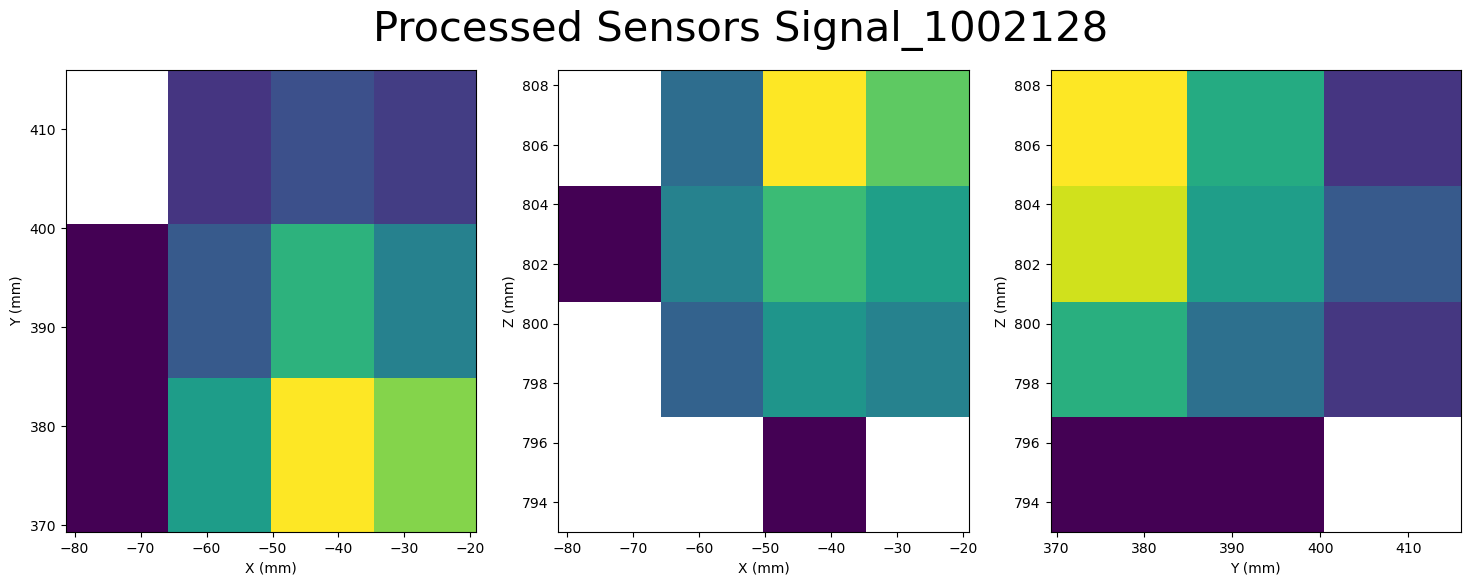

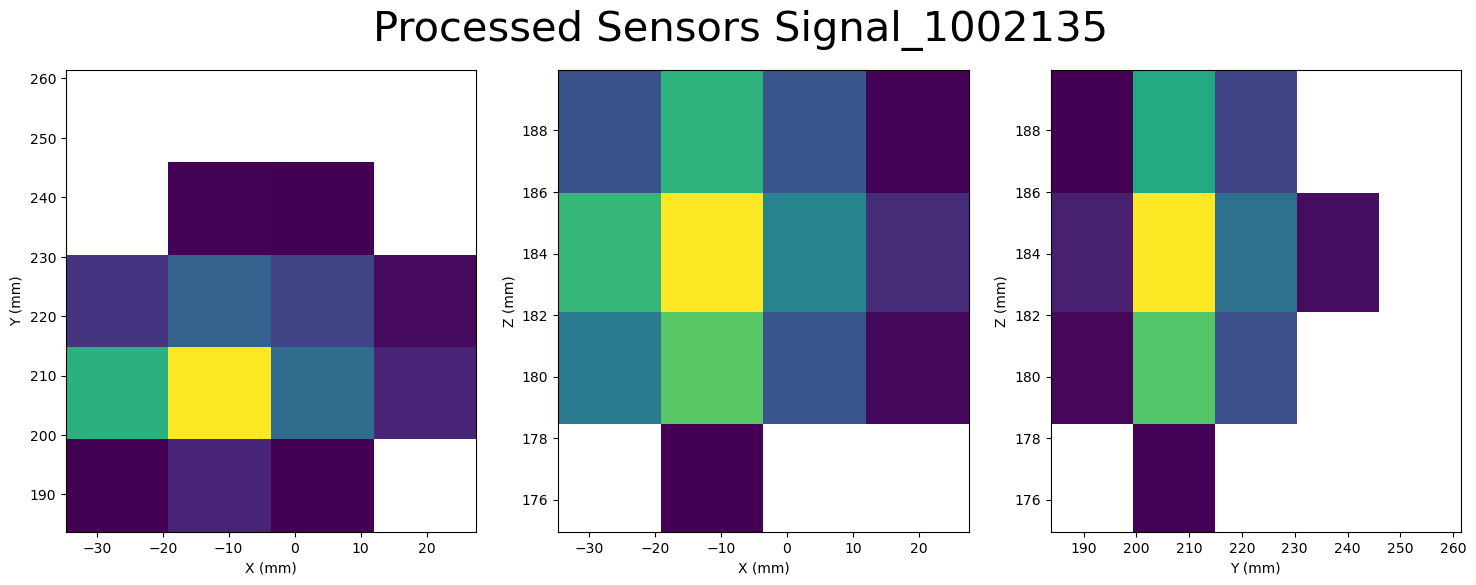

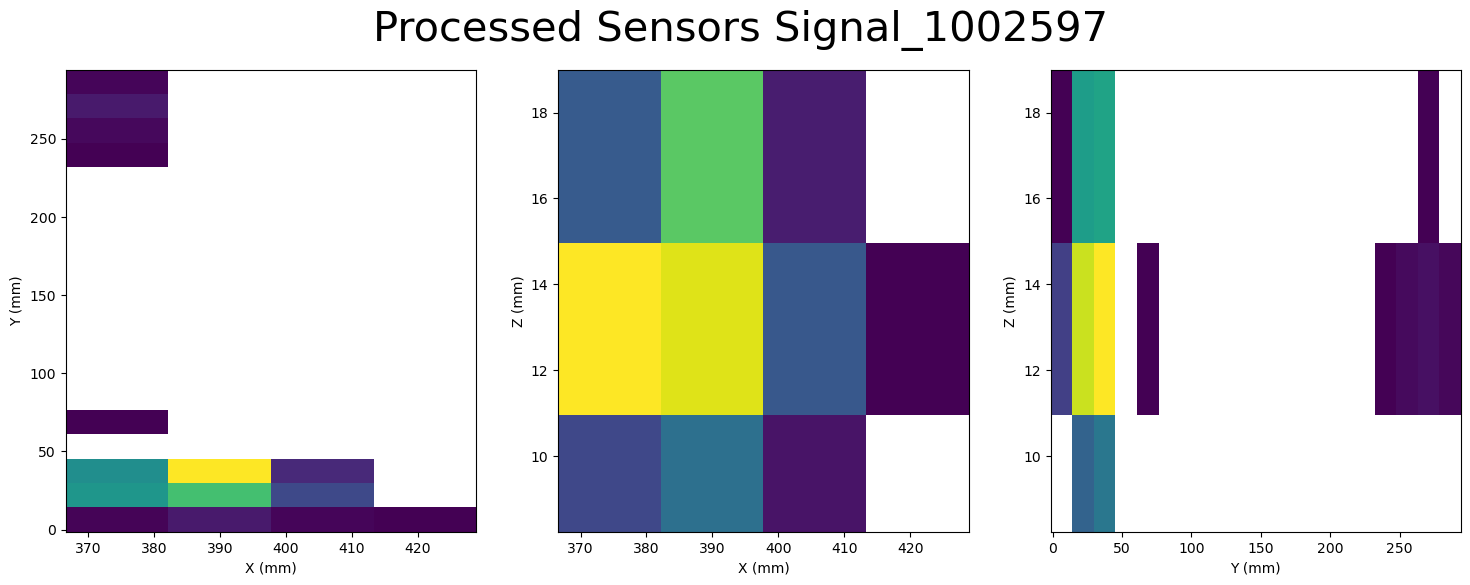

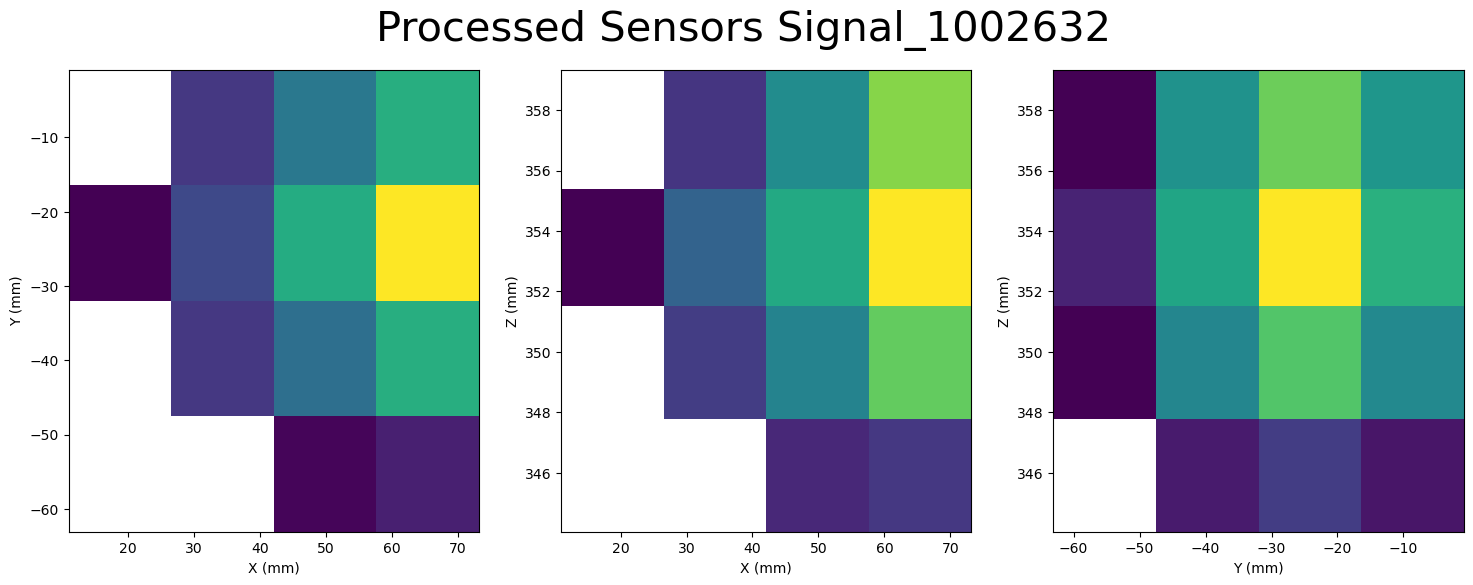

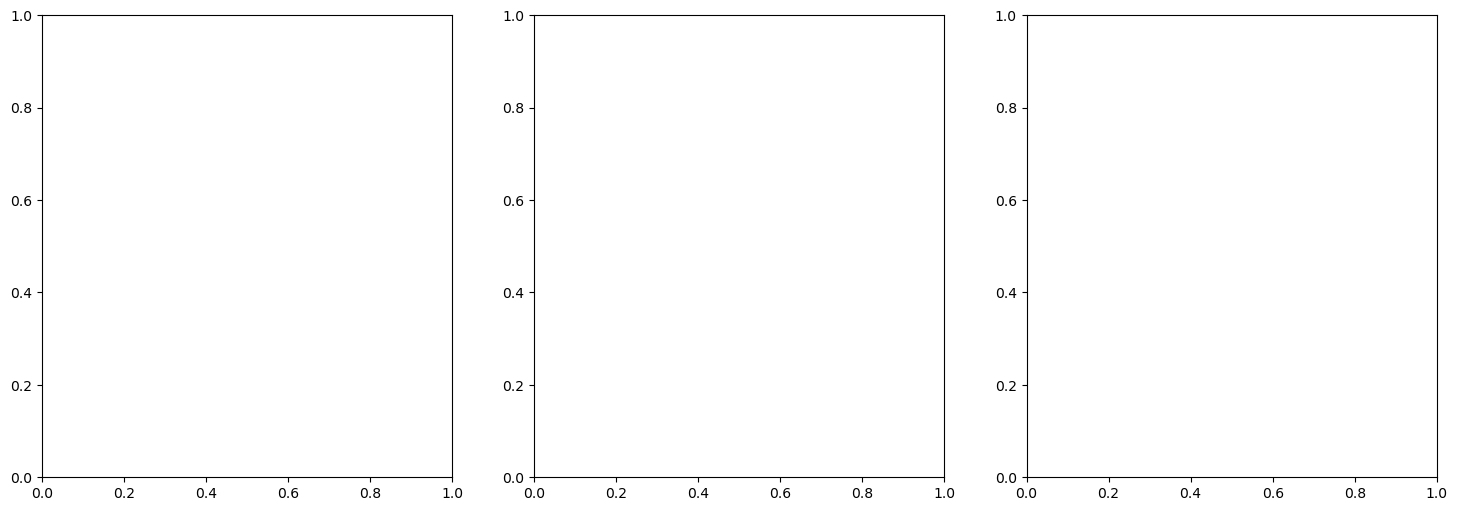

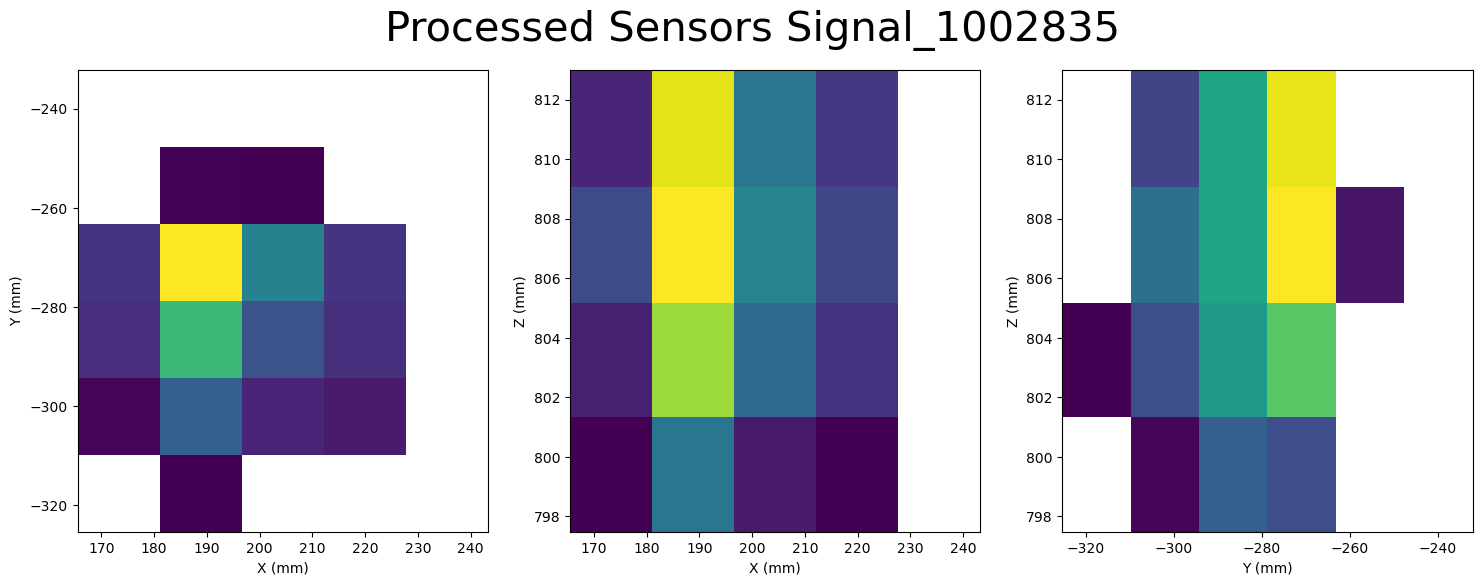

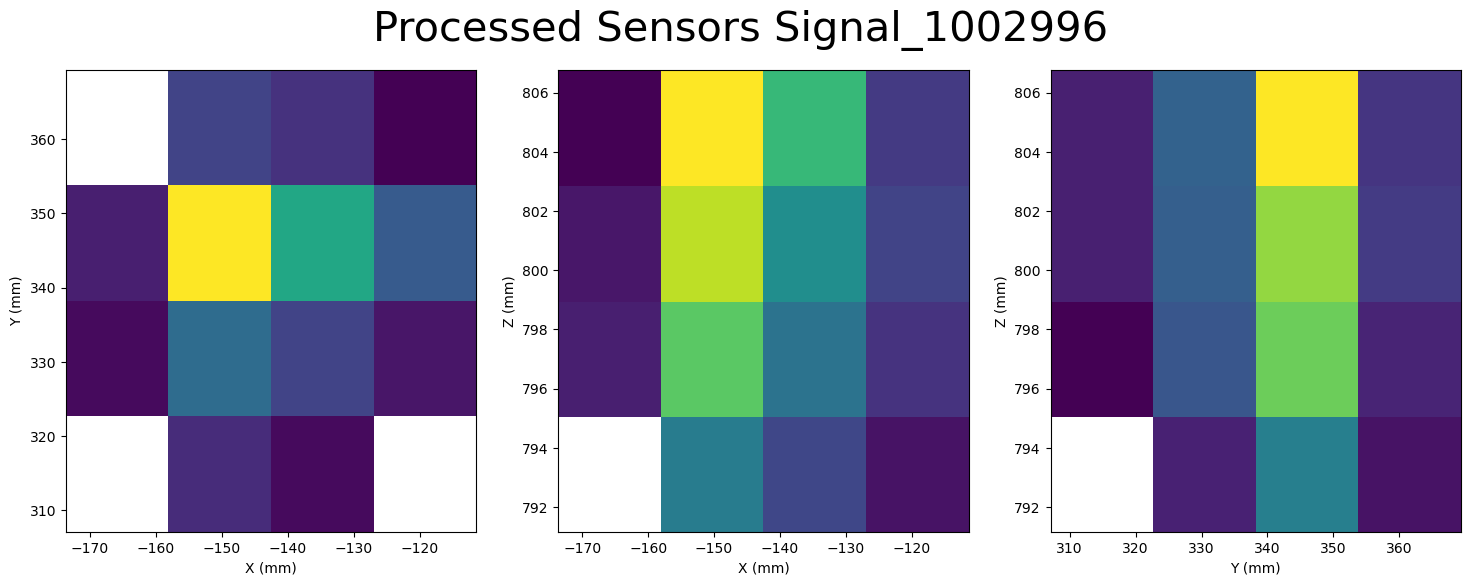

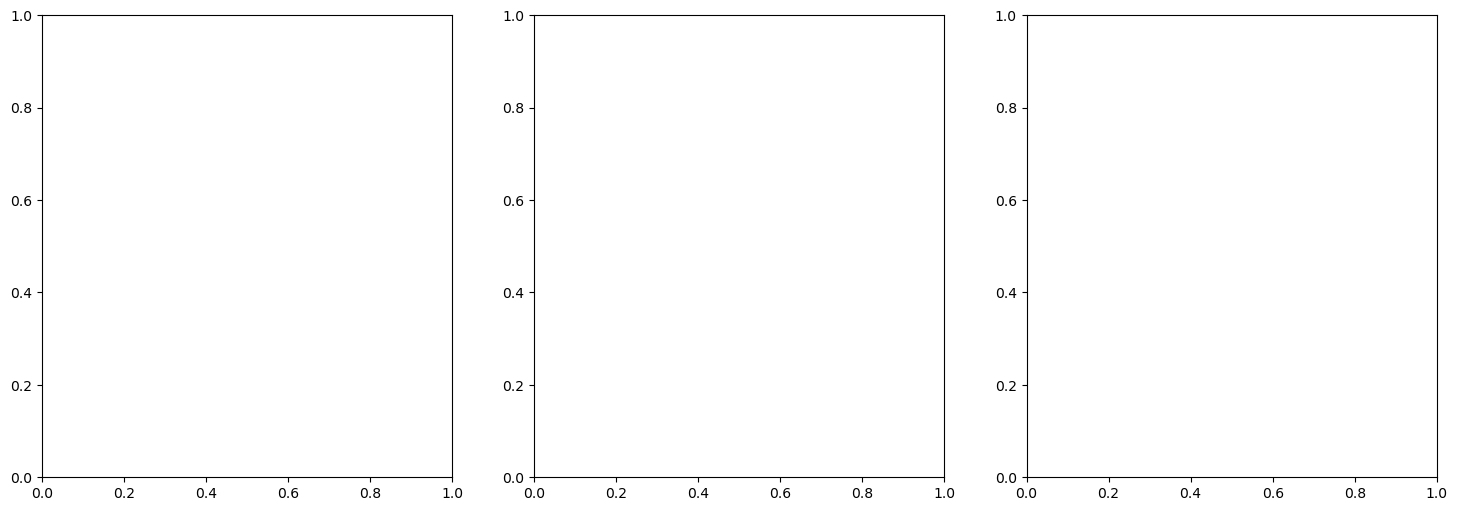

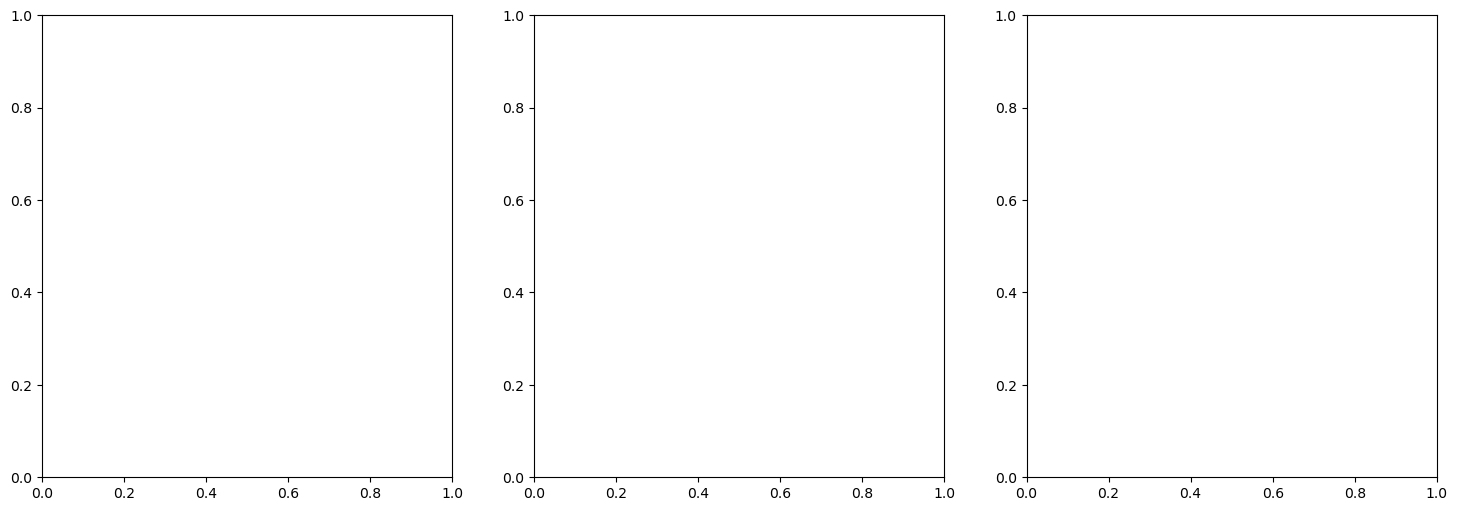

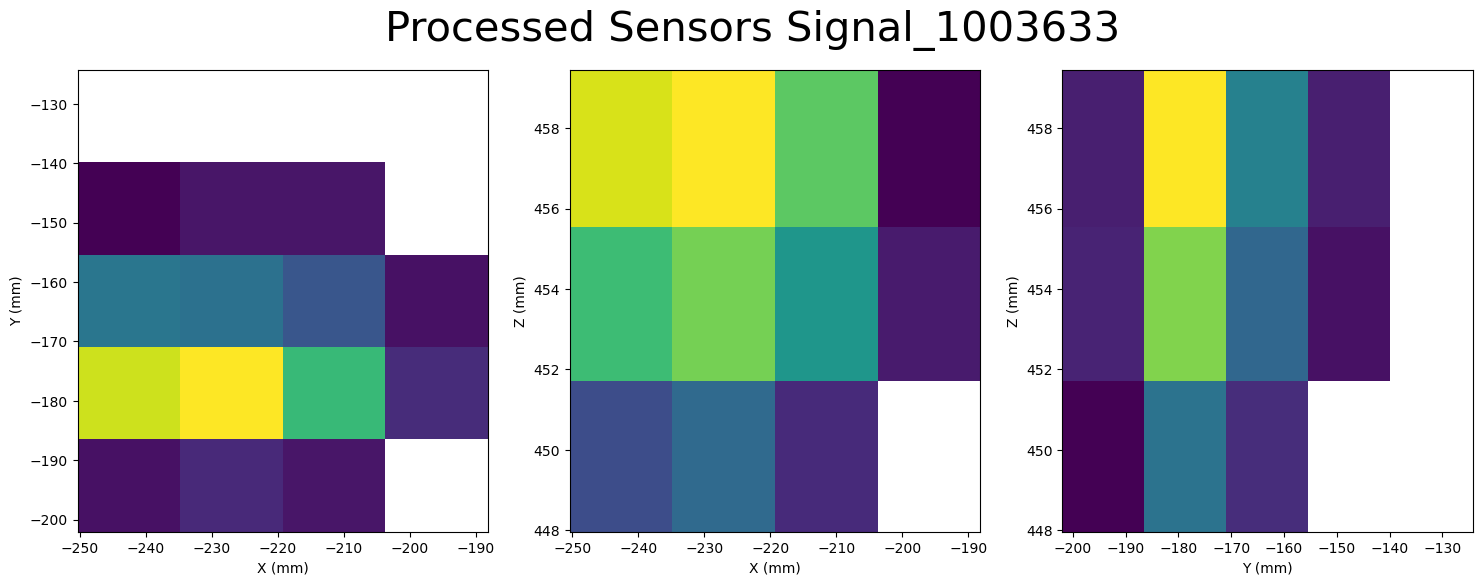

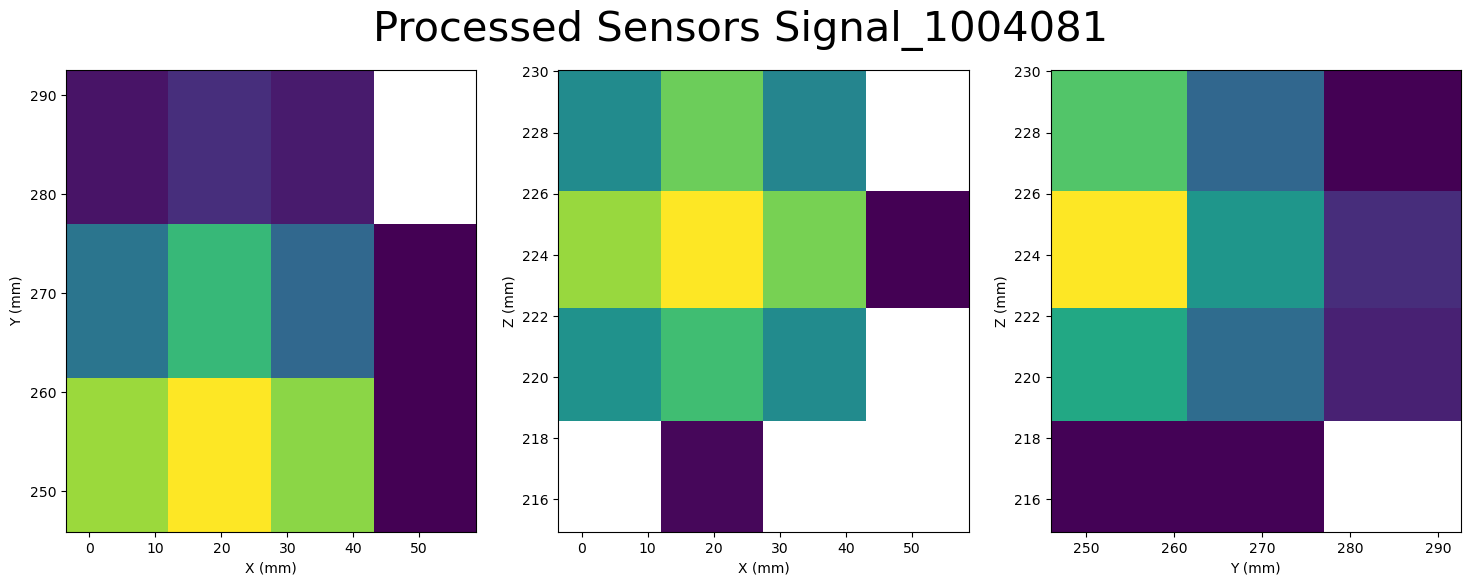

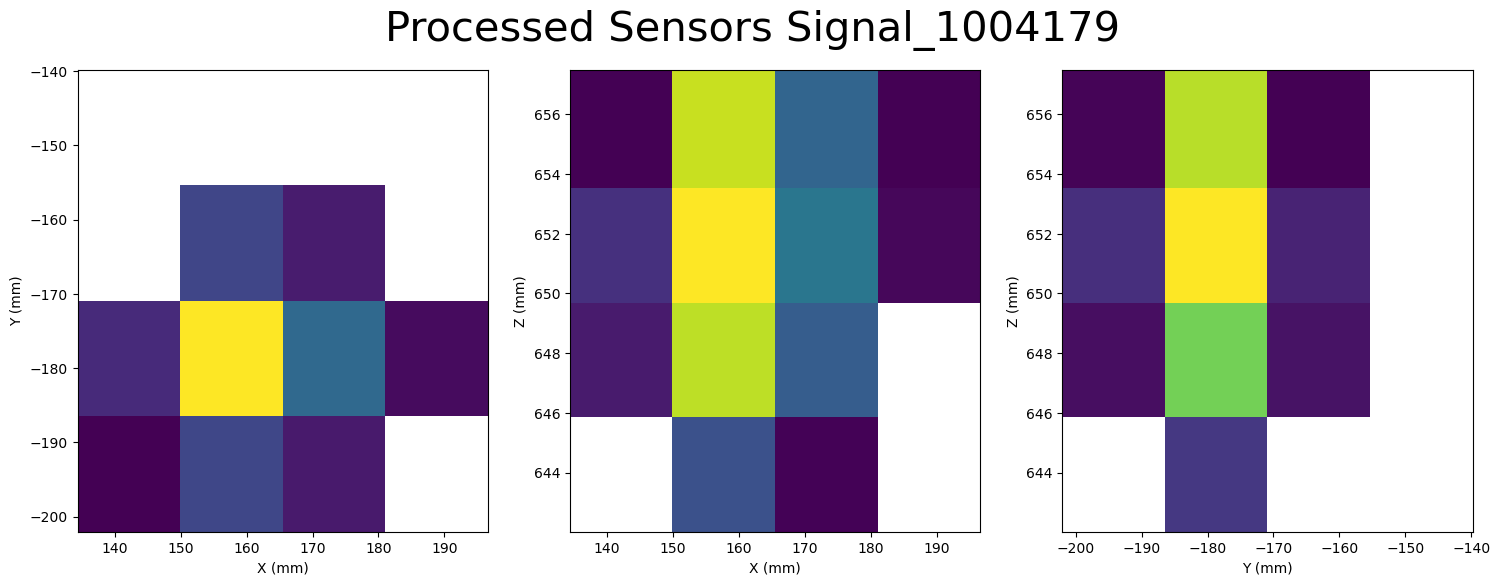

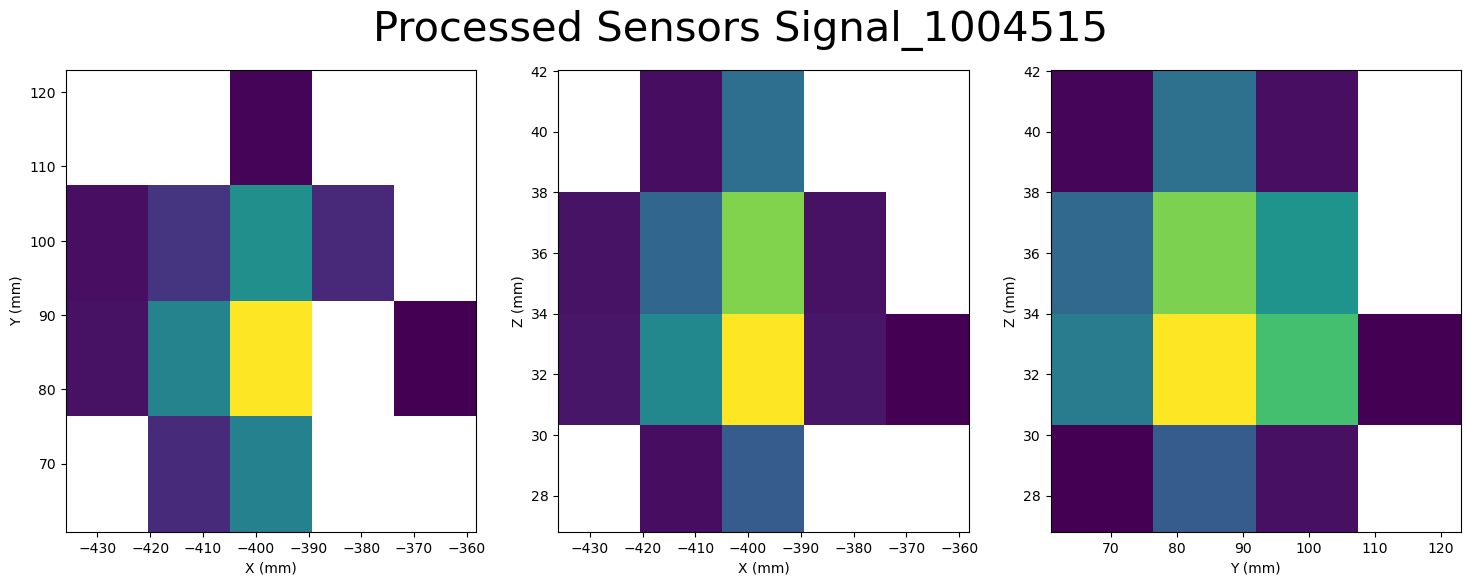

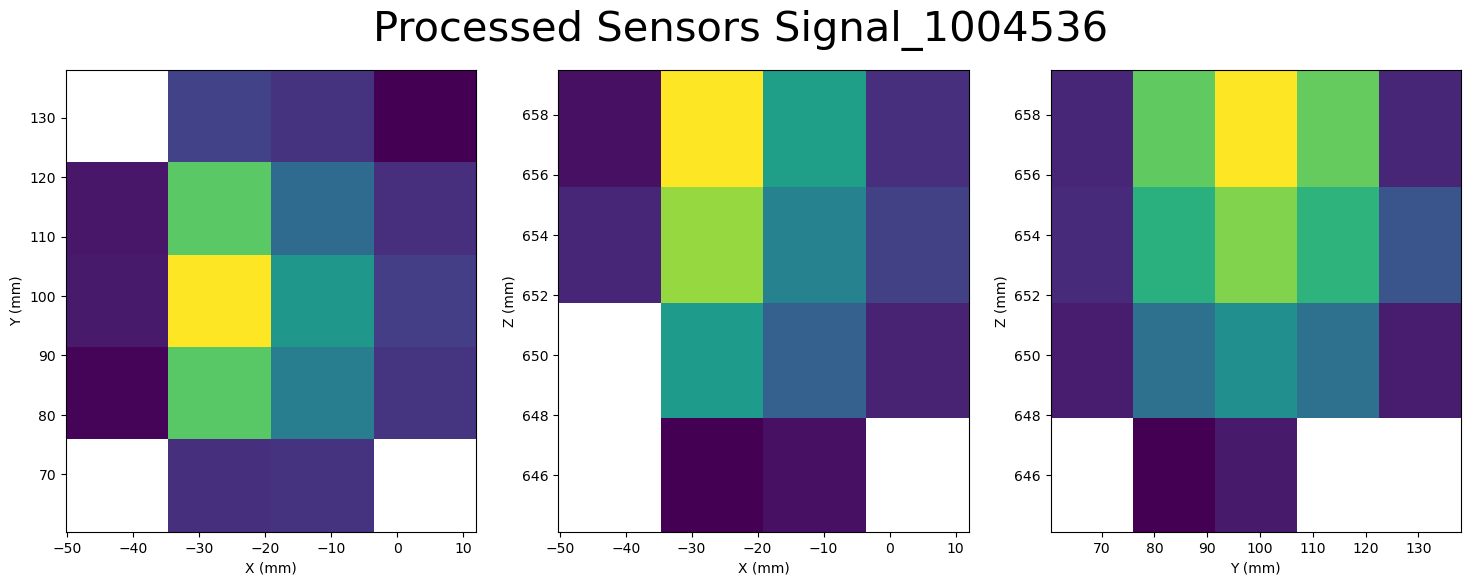

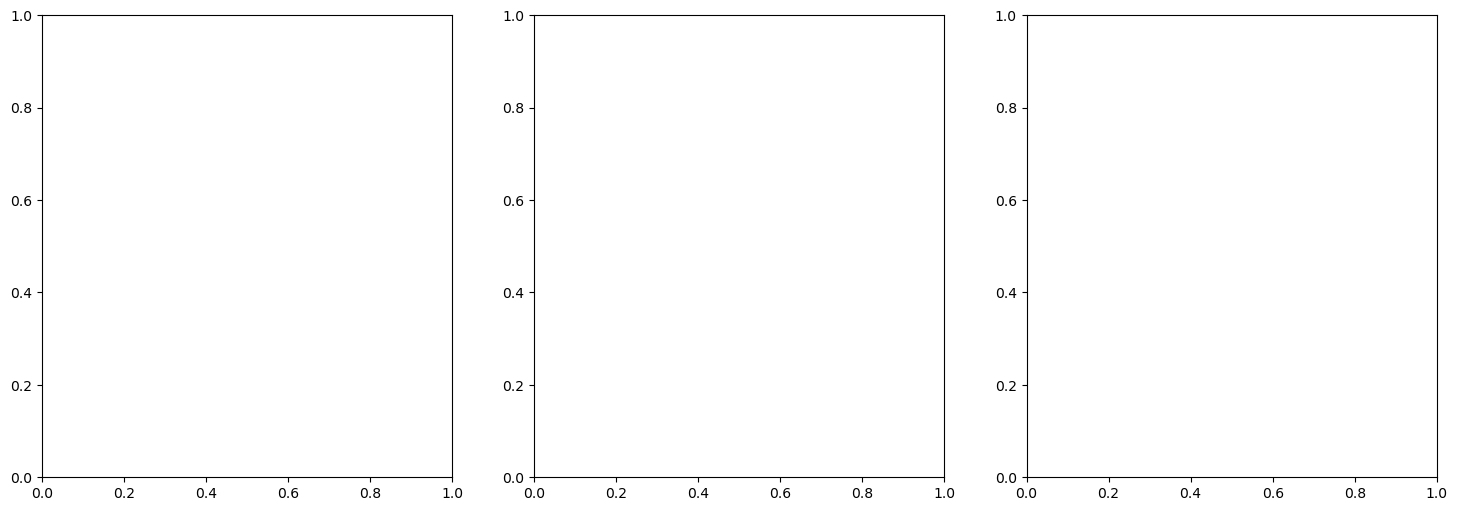

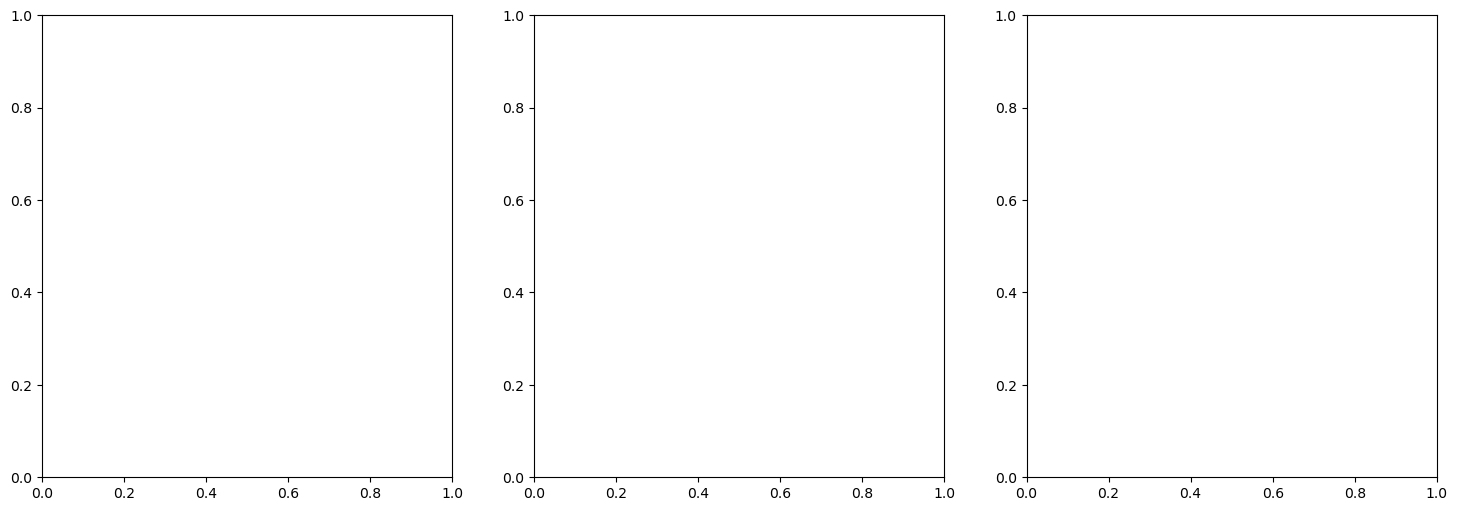

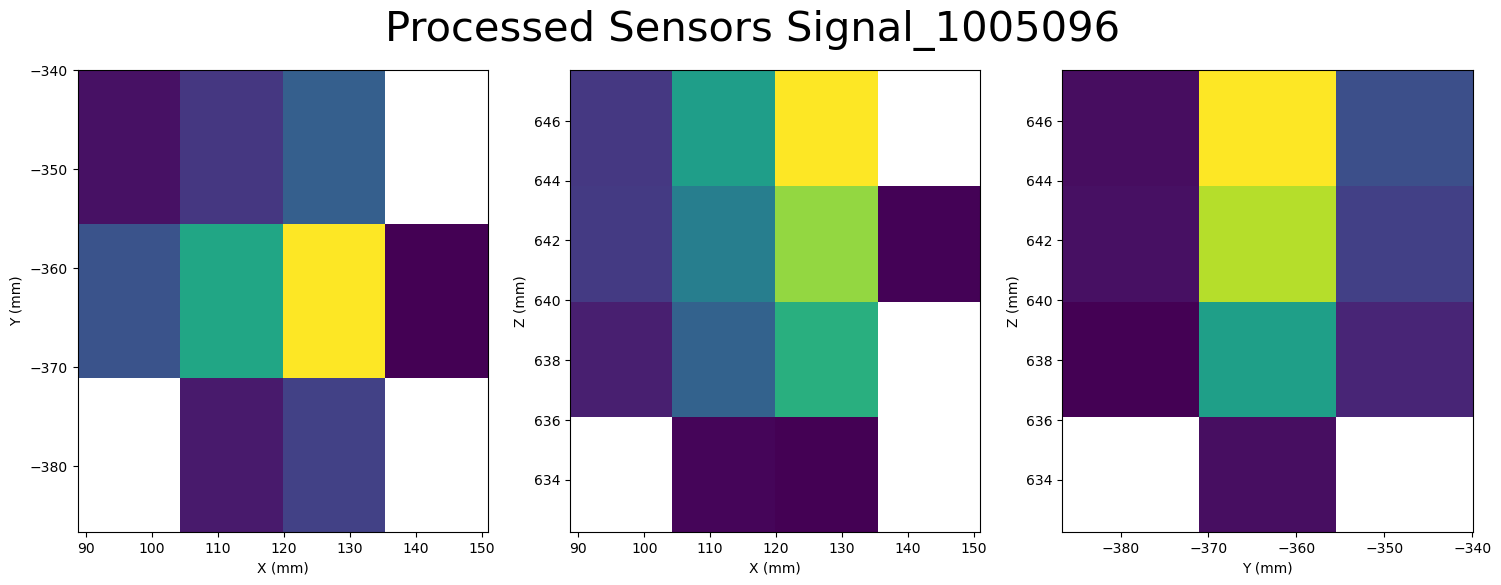

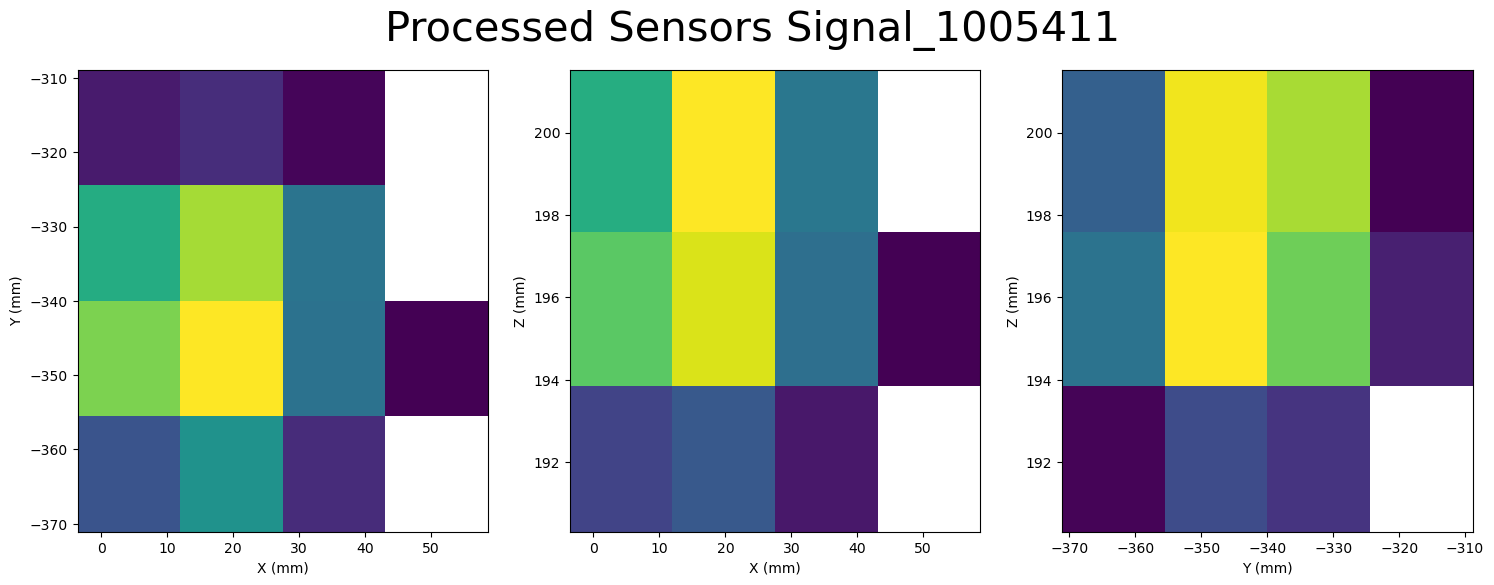

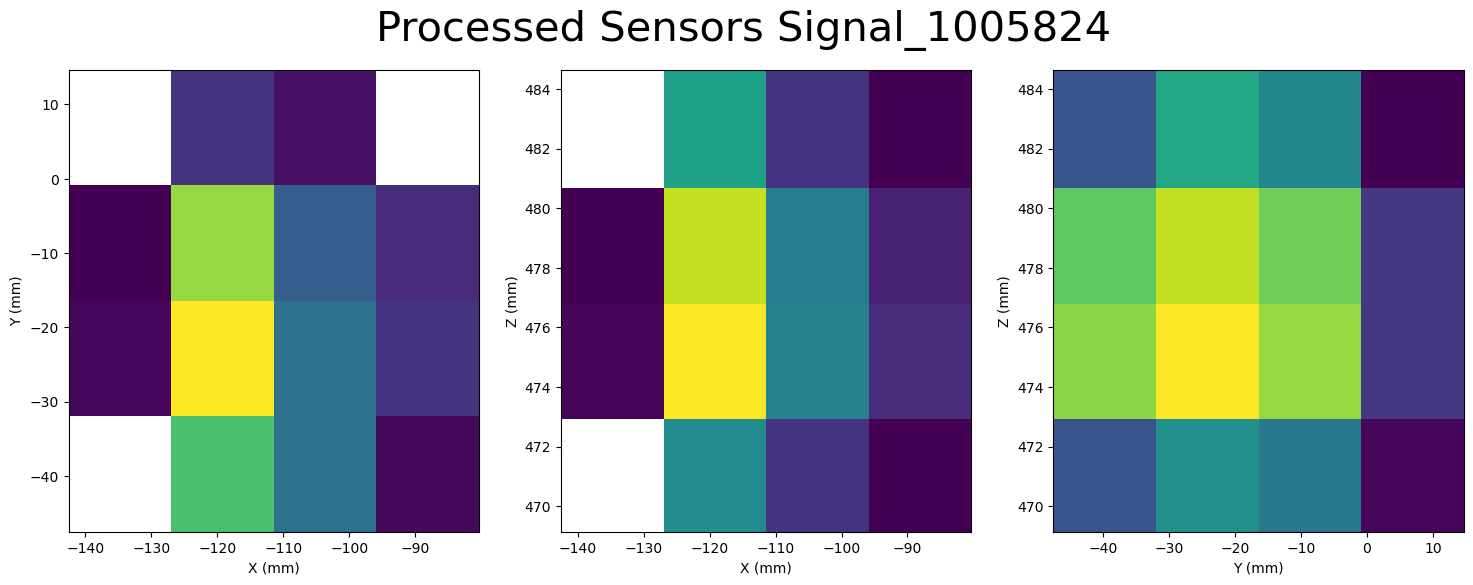

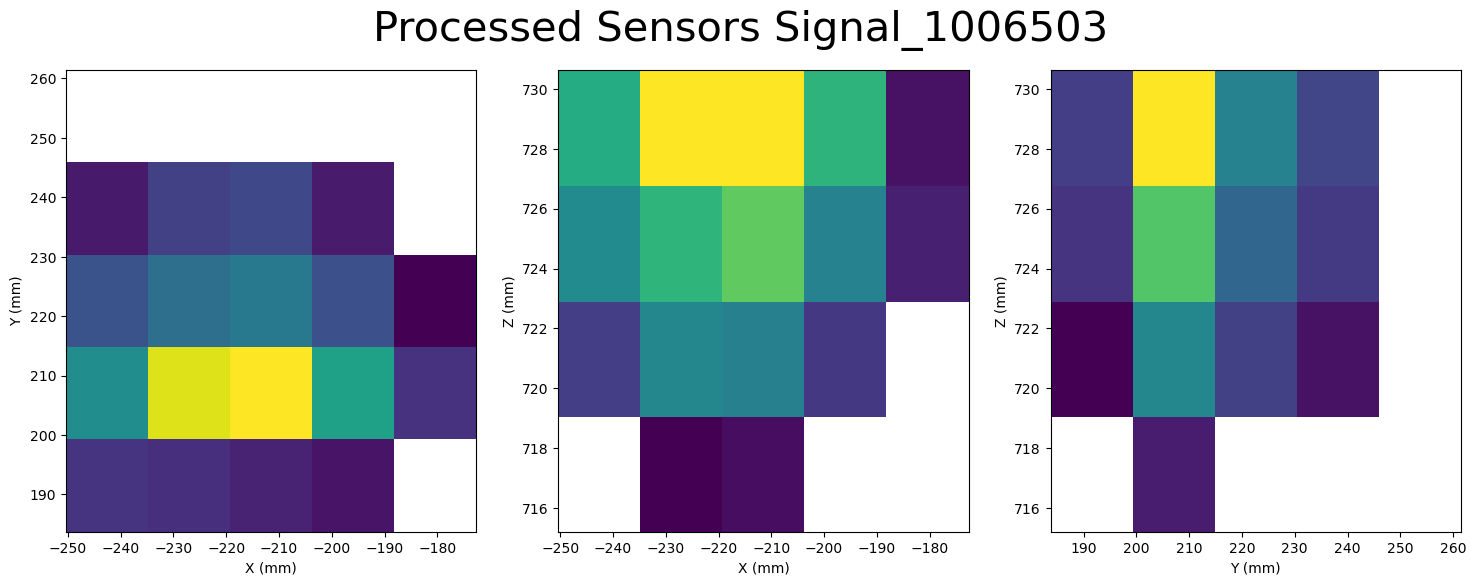

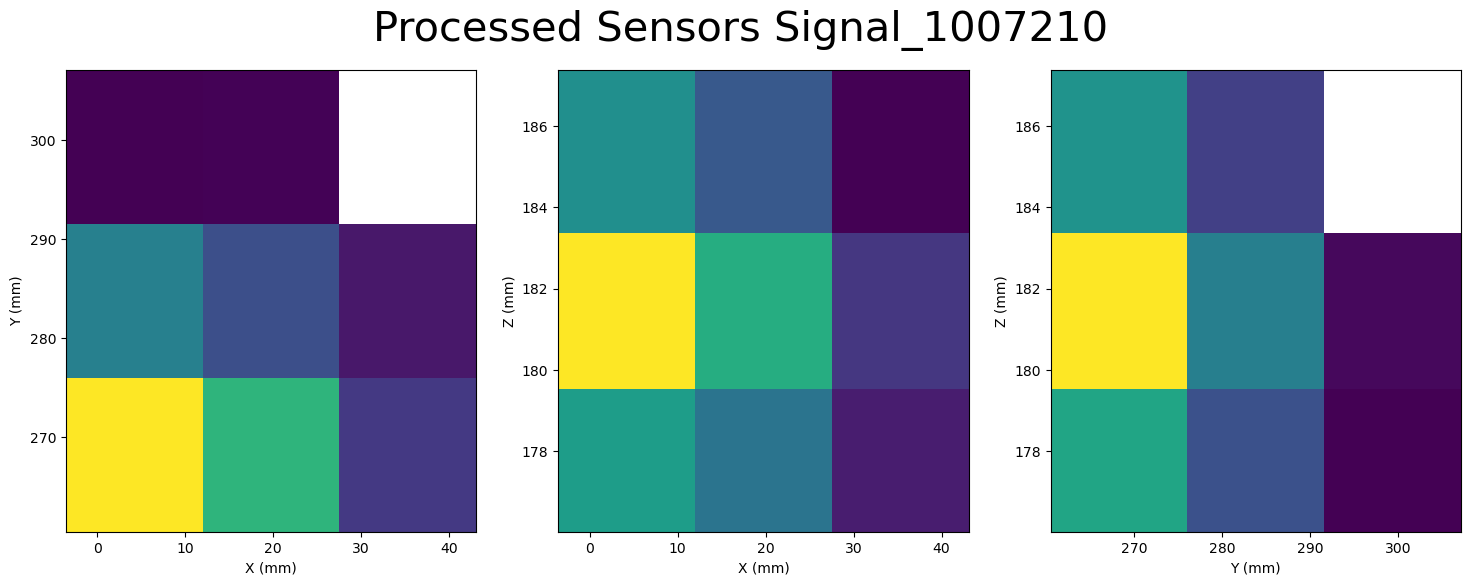

In [28]:
q_cut = 100
drop_dist       = [16, 16]

for evt, df in s2_df.groupby('event'):

    try:
        cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
        drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])
        hits_cut = coref.timefunc(cut_sensors)(df.copy())
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
        pitch = 15.55
        # then applying transformations to convert to 'SiPM outputs'
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    
        xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
        yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
        zz = hits_cut.Z.unique()
    
        axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
        axes[0].set_xlabel('X (mm)');
        axes[0].set_ylabel('Y (mm)');
    
        axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
        axes[1].set_xlabel('X (mm)');
        axes[1].set_ylabel('Z (mm)');
    
    
        axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
        axes[2].set_xlabel('Y (mm)');
        axes[2].set_ylabel('Z (mm)');
    
        fig.suptitle('Processed Sensors Signal_' + str(evt), fontsize=30)
        fig.show()
    except:
        print("One broke, ignoring")

In [2]:
# just read in 10, then create teh seaborn histplot
import seaborn as sns

In [3]:
folder_path = '../data/'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
file_paths = [os.path.join(folder_path, f) for f in file_names]



reco_l = []
dst_l = []

for i, file_path in enumerate(file_paths):
    q = (pd.read_hdf(file_path, 'RECO/Events'), pd.read_hdf(file_path, 'DST/Events'))
    #display(q[0])
    #display(q[1])
    
    #Separate the results into respective lists
    reco, dst = q #Concatenate all the dataframes at once
    reco_l.append(reco)
    dst_l.append(dst)

    if i > 50:
        break

reco = pd.concat(reco_l, axis=0, ignore_index=True)
dst = pd.concat(dst_l, ignore_index=True)


In [4]:
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

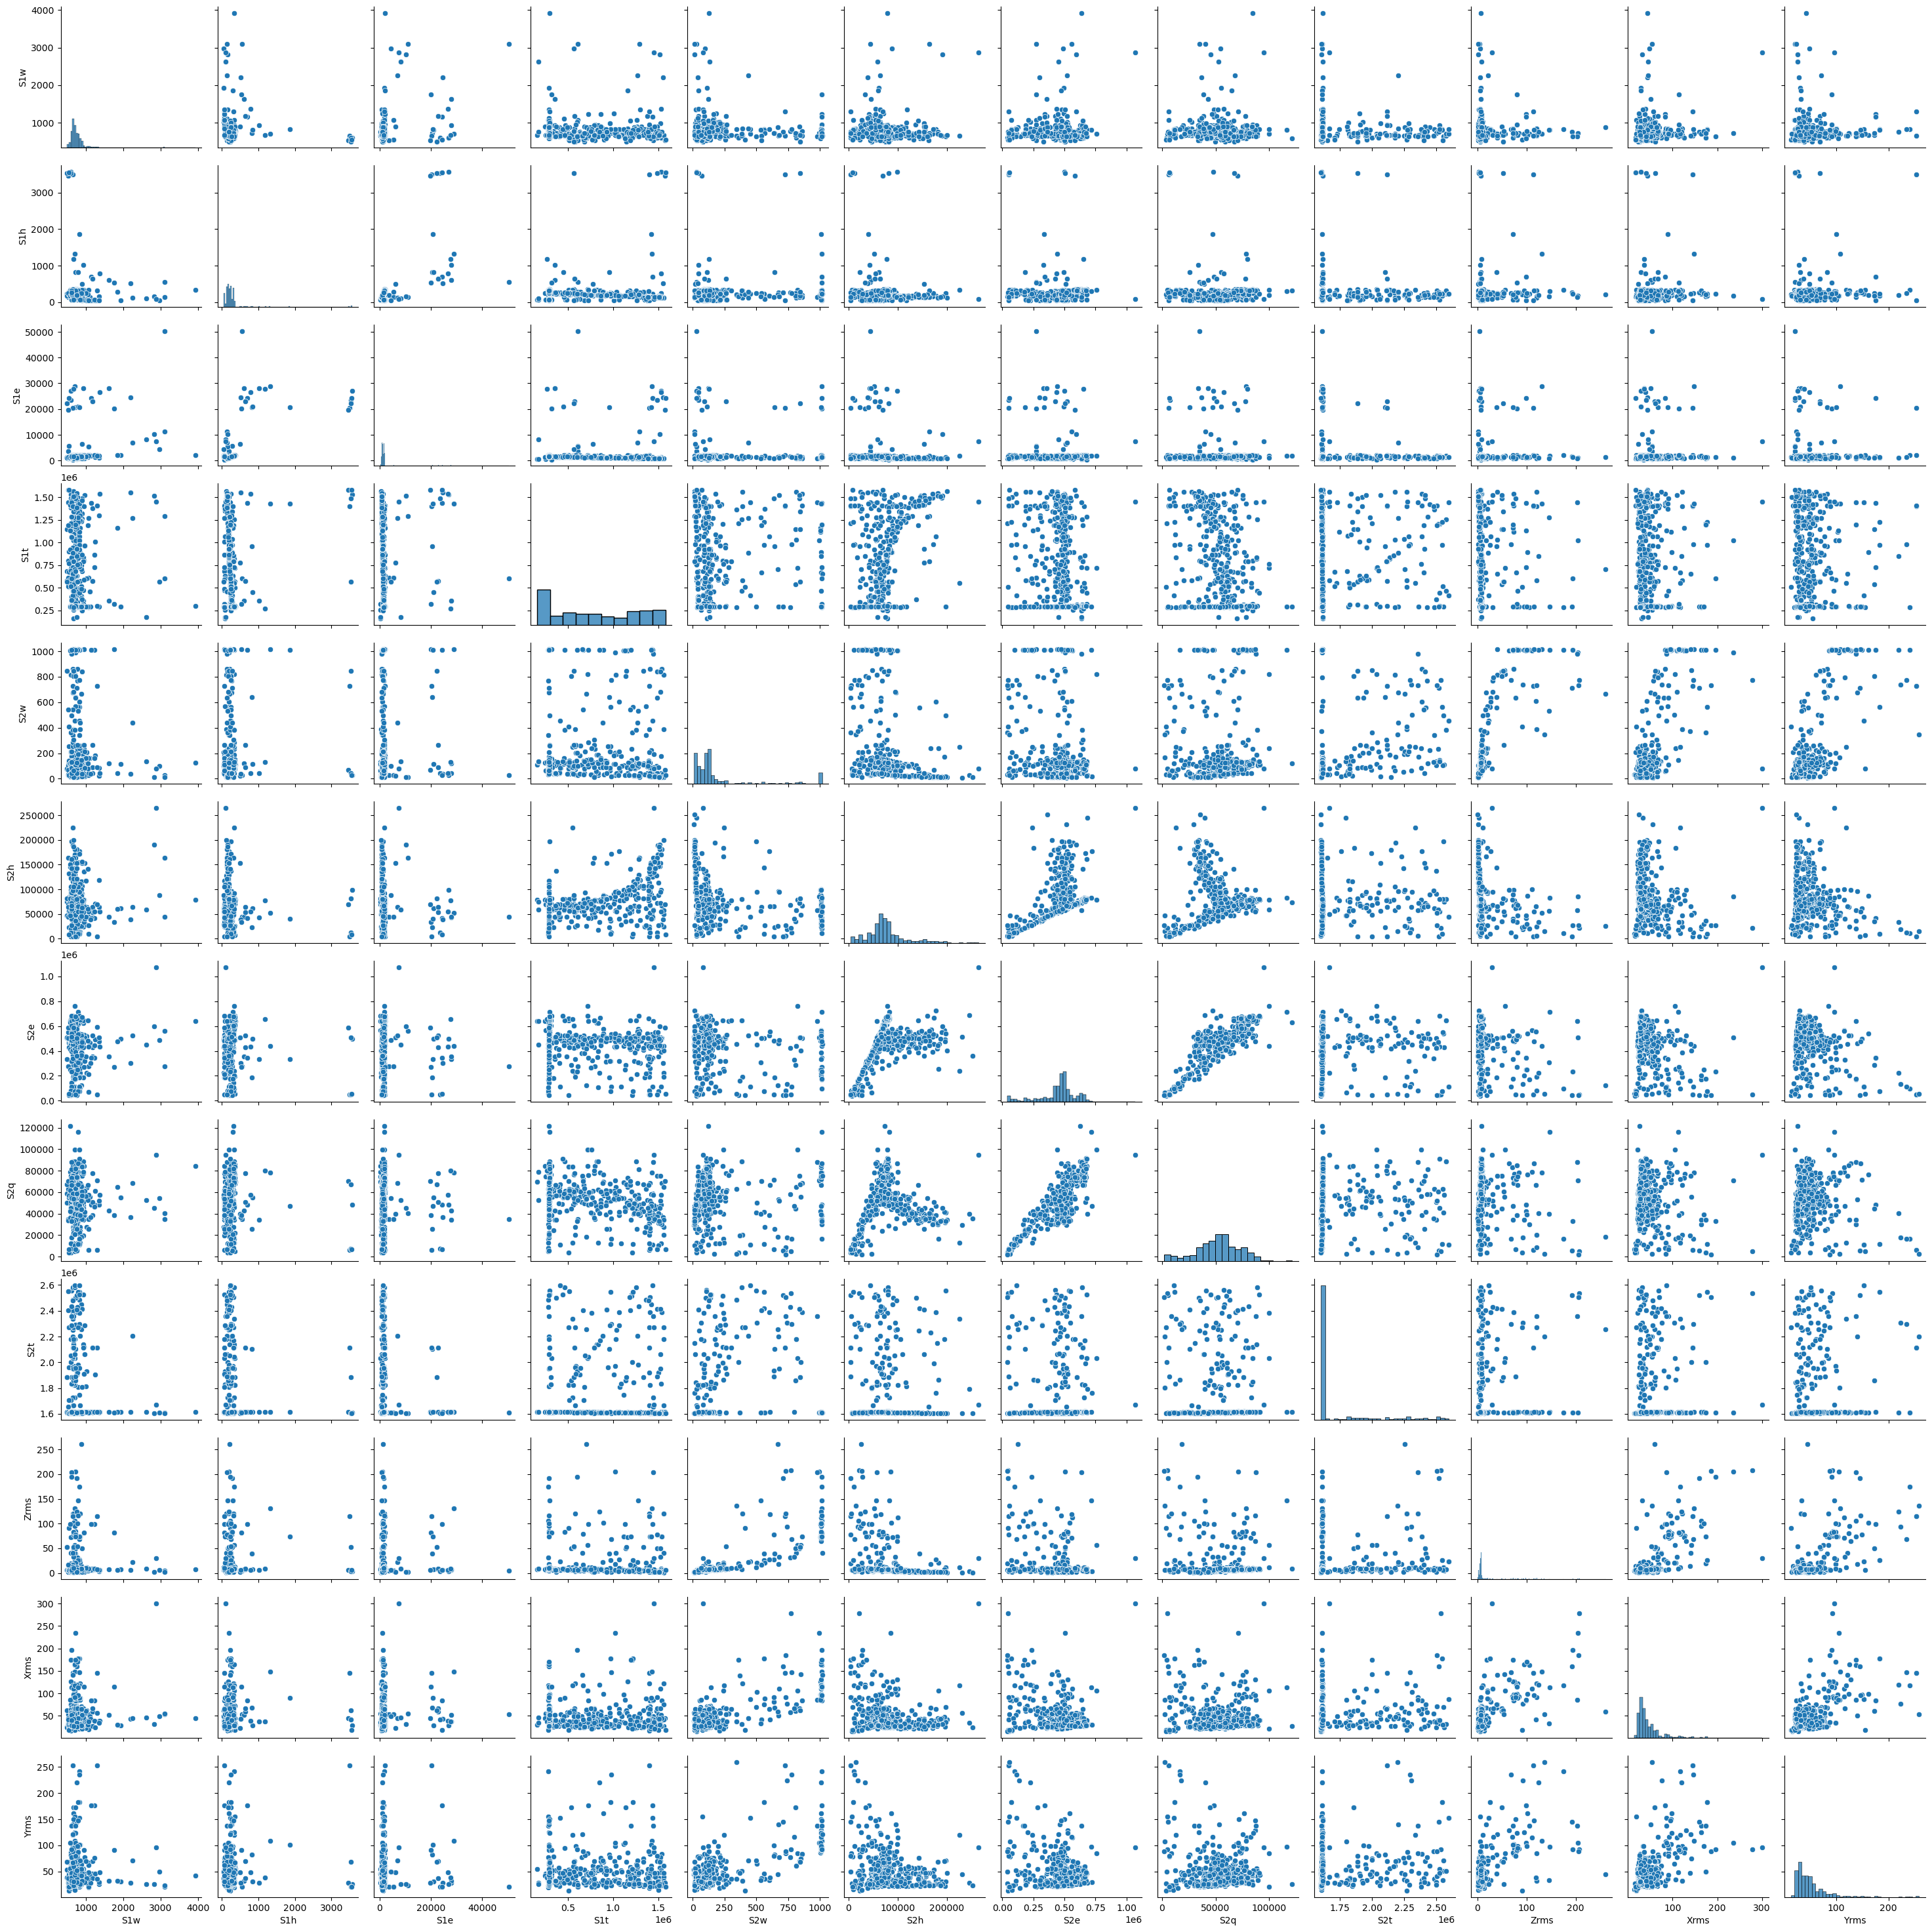

In [5]:
# Plot data
variable_list = ['S1w', 'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Zrms', 'Xrms', 'Yrms']
#variable_list = ['Zrms', 'Xrms', 'Yrms']
sns.pairplot(dst[variable_list], palette = 'bright')

(array([1.120598e+06, 2.320000e+02, 8.500000e+01, 4.700000e+01,
        2.900000e+01, 1.300000e+01, 1.900000e+01, 1.400000e+01,
        1.700000e+01, 2.700000e+01]),
 array([  100.        ,  1369.60878906,  2639.21757812,  3908.82636719,
         5178.43515625,  6448.04394531,  7717.65273437,  8987.26152344,
        10256.8703125 , 11526.47910156, 12796.08789062]),
 <BarContainer object of 10 artists>)

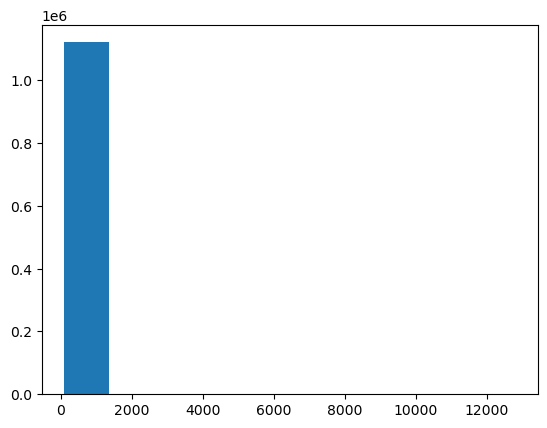

In [6]:
folder_path = '../data/'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
file_paths = [os.path.join(folder_path, f) for f in file_names]

list_of_qs = []

for i, file_path in enumerate(file_paths):
    q = pd.read_hdf(file_path, 'RECO/Events')

    list_of_qs.append(q.Q.to_numpy())

    if i > 1000:
        break

list_of_qs = flatten(list_of_qs)



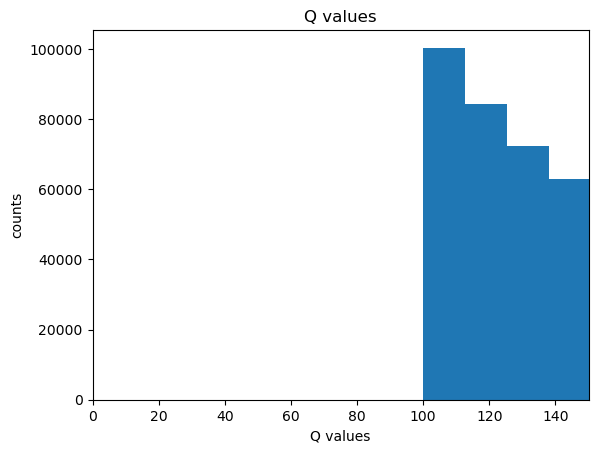

In [9]:
plt.hist(list_of_qs, bins = 1000)
plt.xlim([0, 150])
plt.title("Q values")
plt.xlabel("Q values")
plt.ylabel("counts")
plt.show()